In [1]:
import os
import random
import re
import math
import time
import pickle
import functools
random.seed(a=42)
from itertools import cycle
from IPython.display import display, HTML

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, roc_curve, auc, f1_score, confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/

Mounted at /content/drive
MyDrive


In [3]:
DRIVE_DIRECTORY = "/content/drive/MyDrive"

OUTPUT_DIR = DRIVE_DIRECTORY + "/renal_carcinoma/_output"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

GENES_DIR = OUTPUT_DIR + "/all_genes"
if not os.path.exists(GENES_DIR):
    os.makedirs(GENES_DIR)

MODEL_DIR = OUTPUT_DIR + "/models"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

training_file = 'training_set.csv'
test_file = 'test_set.csv'

training_labels = 'training_labels.csv'
test_labels = 'test_labels.csv'

In [4]:
train_data = pd.read_csv(training_file, index_col=0)
test_data = pd.read_csv(test_file, index_col=0)

train_labels = pd.read_csv(training_labels, index_col=0)
test_labels = pd.read_csv(test_labels, index_col=0)

In [5]:
train_data.head()

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001561.7,ENSG00000001617.12,ENSG00000001626.16,...,ENSG00000287627.1,ENSG00000287649.1,ENSG00000287733.1,ENSG00000287770.1,ENSG00000287837.1,ENSG00000288003.1,ENSG00000288057.1,ENSG00000288066.1,ENSG00000288162.1,ENSG00000288545.1
TCGA-SX-A71S-01A,48.3953,0.0000,84.1344,9.7777,42.1879,101.1447,29.2480,36.3200,117.8496,0.4795,...,0.1251,0.0000,11.0668,0.0000,4.8663,0.0000,0.000,45.8299,0.1325,0.1035
TCGA-BQ-7051-01A,72.3775,0.1354,90.8544,2.2342,8.1109,106.9732,73.7317,31.1117,7.9526,0.0523,...,0.0661,0.0243,15.8320,0.0000,1.4569,0.0000,0.014,21.5157,0.0700,0.0000
TCGA-B2-5635-01A.1,28.8629,0.2152,67.0498,34.4290,46.0427,59.8095,9.6487,44.9480,126.4023,0.3450,...,0.0000,8.8593,48.4421,0.0000,3.0638,19.9184,0.000,34.7520,2.1879,0.0869
TCGA-BP-4967-01A,51.9280,0.1329,69.3944,7.4124,9.8914,52.0490,10.8936,29.6939,79.0725,0.6906,...,0.1297,9.1269,16.7283,0.0000,1.8081,35.6296,0.000,12.1059,1.1222,0.1610
TCGA-B8-5552-01B,34.3976,1.3407,78.6941,29.6986,94.5079,68.8465,19.1207,47.0522,174.6127,0.3800,...,1.0903,5.0031,9.1114,6.1868,3.3421,10.6716,0.000,29.7941,12.6020,0.2461


In [6]:
genes = train_data.columns

In [7]:
genes

Index(['ENSG00000000003.15', 'ENSG00000000005.6', 'ENSG00000000419.13',
       'ENSG00000000938.13', 'ENSG00000000971.16', 'ENSG00000001036.14',
       'ENSG00000001084.13', 'ENSG00000001561.7', 'ENSG00000001617.12',
       'ENSG00000001626.16',
       ...
       'ENSG00000287627.1', 'ENSG00000287649.1', 'ENSG00000287733.1',
       'ENSG00000287770.1', 'ENSG00000287837.1', 'ENSG00000288003.1',
       'ENSG00000288057.1', 'ENSG00000288066.1', 'ENSG00000288162.1',
       'ENSG00000288545.1'],
      dtype='object', length=8540)

In [8]:
train_labels.head()

,project_id
871,Kidney Renal Papillary Cell Carcinoma
741,Kidney Renal Papillary Cell Carcinoma
232,Kidney Renal Clear Cell Carcinoma
389,Kidney Renal Clear Cell Carcinoma
119,Kidney Renal Clear Cell Carcinoma


In [9]:
test_labels.head()

,project_id
332,Kidney Renal Clear Cell Carcinoma
639,Kidney Renal Papillary Cell Carcinoma
327,Kidney Renal Clear Cell Carcinoma
848,Kidney Renal Papillary Cell Carcinoma
40,Kidney Chromophobe


In [10]:
train_labels['project_id'].value_counts()

Kidney Renal Clear Cell Carcinoma        427
Kidney Renal Papillary Cell Carcinoma    237
Kidney Chromophobe                        53
Name: project_id, dtype: int64

In [11]:
test_labels['project_id'].value_counts()

Kidney Renal Clear Cell Carcinoma        114
Kidney Renal Papillary Cell Carcinoma     53
Kidney Chromophobe                        13
Name: project_id, dtype: int64

In [12]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels['project_id'])
test_labels = le.transform(test_labels['project_id'])

In [13]:
le.classes_

array(['Kidney Chromophobe', 'Kidney Renal Clear Cell Carcinoma',
       'Kidney Renal Papillary Cell Carcinoma'], dtype=object)

In [14]:
train_labels

array([2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1,
       1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 0,
       2, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0,
       1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2,
       0, 0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1,

In [15]:
test_labels

array([1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1,
       1, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 1, 2, 1,
       1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       0, 1, 0, 1])

In [16]:
label_mapping = {i: l for i, l in enumerate(le.classes_)}
label_mapping

{0: 'Kidney Chromophobe',
 1: 'Kidney Renal Clear Cell Carcinoma',
 2: 'Kidney Renal Papillary Cell Carcinoma'}

In [17]:
for key, value in label_mapping.items():
    if value == 'Kidney Chromophobe':
        label_mapping[key] = 'KICH'
    elif value == 'Kidney Renal Clear Cell Carcinoma':
        label_mapping[key] = 'KIRC'
    elif value == 'Kidney Renal Papillary Cell Carcinoma':
        label_mapping[key] = 'KIRP'
    else:
        pass

In [18]:
label_mapping

{0: 'KICH', 1: 'KIRC', 2: 'KIRP'}

In [19]:
random_state = 42

In [20]:
metrics = ["Accuracy", "Precision", "Recall", "Specificity", "F1", "AUC"]

In [21]:
def plot_roc_curve(y_test, y_pred, model_name):

    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(7,5))
    #plt.figure(dpi=200)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
      label="Micro",
      color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
      label="Macro",
      color="navy", linestyle=":", linewidth=4,)

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
          label="{0}".format(label_mapping[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate", weight='bold')
    plt.ylabel("True Positive Rate", weight='bold')
    plt.title(f"{model_name} ROC Curve", weight='bold')
    plt.legend()
    plt.savefig(GENES_DIR + f'/{model_name}_rocauc.png', facecolor='w', dpi=200, bbox_inches='tight')

In [22]:
def evaluate(model, model_name, test_data, test_labels):
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(test_data)
    cnf_matrix = confusion_matrix(y_test, predictions)

    num_classes = len(cnf_matrix)
    accuracy, precision, recall, specificity, f1_score = [], [], [], [], []

    for i in range(num_classes):
        true_positives = cnf_matrix[i, i]
        false_negatives = sum(cnf_matrix[i, :]) - true_positives
        false_positives = sum(cnf_matrix[:, i]) - true_positives
        true_negatives = sum(sum(cnf_matrix)) - false_positives - false_negatives - true_positives

        acc = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        prec = (true_positives) / (true_positives + false_positives)
        rec = (true_positives) / (true_positives + false_negatives)
        spec = (true_negatives) / (true_negatives + false_positives)
        f1 = 2 * (prec * rec) / (prec + rec)

        accuracy.append(acc*100)
        precision.append(prec*100)
        recall.append(rec*100)
        specificity.append(spec*100)
        f1_score.append(f1*100)

    total_accuracy = np.mean(accuracy)
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_specificity = np.mean(specificity)
    total_f1 = np.mean(f1_score)
    roc_auc = roc_auc_score(test_labels, probabilities, multi_class='ovr')*100

    print('- Results:')
    print(f"Accuracy: {total_accuracy:.2f}%")
    print(f"Precision: {total_precision:.2f}%")
    print(f"Recall: {total_recall:.2f}%")
    print(f"Specificity: {total_specificity:.2f}%")
    print(f"F1: {total_f1:.2f}%")
    print(f"AUC: {roc_auc:.2f}%")

    d = []
    for class_num in range(num_classes):
        d.append(
            {
                'Accuracy': f'{accuracy[class_num]:.2f}',
                'Precision': f'{precision[class_num]:.2f}',
                'Recall':  f'{recall[class_num]:.2f}',
                'Specificity': f'{specificity[class_num]:.2f}',
                'F1': f'{f1_score[class_num]:.2f}',
            }
        )

    per_class_metric = pd.DataFrame(d, index=label_mapping.values())
    per_class_metric = per_class_metric.T
    print("\n- Results per class:")
    display(per_class_metric)


    cnf_matrix = cnf_matrix.astype('float')/cnf_matrix.sum(axis=1)[:, np.newaxis]
    #cnf_matrix *= 100

    ax= plt.subplot()
    sns.heatmap(cnf_matrix, annot=True, cmap='Greens', annot_kws={"weight": "bold", "size": 12},
                fmt='.1%', ax=ax)

    ax.xaxis.set_ticklabels([label_mapping[0], label_mapping[1], label_mapping[2]], weight='bold')
    ax.yaxis.set_ticklabels([label_mapping[0], label_mapping[1], label_mapping[2]], weight='bold')
    plt.savefig(GENES_DIR + f'/{model_name}_confmatrix.png', facecolor='w', dpi=200, bbox_inches='tight')


    plot_roc_curve(y_test=test_labels, y_pred=probabilities, model_name=model_name)


    results = pd.DataFrame(
        [f"{total_accuracy:.2f}", f"{total_precision:.2f}", f"{total_recall:.2f}",
         f"{total_specificity:.2f}", f"{total_f1:.2f}", f"{roc_auc:.2f}"],
        index = metrics,
        columns = [model_name]
    )

    return results

In [23]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [24]:
search_metrics = {
    "Accuracy": "accuracy",
    "Balanced accuracy": "balanced_accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "AUC": roc_auc_scorer
}

In [25]:
def get_scores(model, metrics):
    scores = dict()
    for metric in metrics.keys():
        best_index = np.nonzero(model.cv_results_["rank_test_%s" % metric] == 1)[0][0]
        best_score = model.cv_results_["mean_test_%s" % metric][best_index]
        scores[metric] = f"{best_score:.4f}"
        print(f"{metric}: {best_score:.4f}")
    return scores

In [26]:
cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

In [27]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(train_labels),
    y=train_labels
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)

{0: 4.509433962264151, 1: 0.5597189695550351, 2: 1.0084388185654007}


In [28]:
feature_selector = SelectKBest(score_func=f_classif)

In [29]:
X_train = train_data
X_test = test_data

y_train = train_labels
y_test = test_labels

In [30]:
print(X_train.shape)
print(X_test.shape)

(717, 8540)
(180, 8540)


In [31]:
pip install scikeras

In [32]:
from scikeras.wrappers import KerasClassifier

In [33]:
def get_clf(meta, hidden_layer_1, hidden_layer_2, dropout_rate_1, dropout_rate_2):
    n_features_in_ = meta["n_features_in_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    #Add a dense layer with x neurons
    model.add(Dense(units = hidden_layer_1, activation=keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Dropout(dropout_rate_1))
    #Add a dense layer with y neurons
    model.add(Dense(units = hidden_layer_2, activation=keras.layers.LeakyReLU(alpha=0.001)))
    model.add(Dropout(dropout_rate_2))
    #Softmax as last layer with three outputs
    model.add(Dense(units = 3, activation='softmax'))

    return model

In [34]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [35]:
clf = KerasClassifier(
    model=get_clf,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer="adam",
    optimizer__learning_rate=0.005,
    batch_size=16,
    epochs=100,
    fit__validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights,
    random_state=random_state,
    hidden_layer_1=64,
    hidden_layer_2=32,
    dropout_rate_1=0.4,
    dropout_rate_2=0.4
)

In [36]:
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("clf", clf)])

In [37]:
space = dict()
space['clf__model__hidden_layer_1'] = [64, 128, 256]
space['clf__model__hidden_layer_2'] = [32, 64, 128]
#space['clf__model__dropout_rate_1'] = [0.3, 0.4, 0.5]
#space['clf__model__dropout_rate_2'] = [0.3, 0.4, 0.5]

In [38]:
search = GridSearchCV(
    pipe, space, scoring=search_metrics, refit="AUC",
    cv=10
)

search.fit(X_train, y_train)

Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 6.5993 - accuracy: 0.7371

33/33 [==============================] - 2s 19ms/step - loss: 6.1871 - accuracy: 0.7519 - val_loss: 2.3419 - val_accuracy: 0.8682
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 3.3463 - accuracy: 0.8728

33/33 [==============================] - 0s 9ms/step - loss: 3.5336 - accuracy: 0.8624 - val_loss: 0.8900 - val_accuracy: 0.9225
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 6.7090 - accuracy: 0.8795

33/33 [==============================] - 0s 9ms/step - loss: 6.6844 - accuracy: 0.8779 - val_loss: 1.9725 - val_accuracy: 0.8837
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 3.0762 - accuracy: 0.8652

33/33 [==============================] - 0s 15ms/step - loss: 3.0523 - accuracy: 0.8663 - val_loss: 1.6003 - val_accuracy: 0.9147
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 1.5783 - accuracy: 0.8931

33/33 [==============================] - 0s 12ms/step - loss: 1.5671 - accuracy: 0.8915 - val_loss: 0.8419 - val_accuracy: 0.9147
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 1.8029 - accuracy: 0.9028

33/33 [==============================] - 0s 11ms/step - loss: 1.6754 - accuracy: 0.9050 - val_loss: 0.8281 - val_accuracy: 0.9147
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 1.8593 - accuracy: 0.8818

33/33 [==============================] - 0s 10ms/step - loss: 1.8593 - accuracy: 0.8818 - val_loss: 1.1688 - val_accuracy: 0.9070
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 1.8724 - accuracy: 0.8958

33/33 [==============================] - 0s 10ms/step - loss: 1.7196 - accuracy: 0.8895 - val_loss: 0.8850 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 2.2327 - accuracy: 0.9052

33/33 [==============================] - 0s 9ms/step - loss: 2.3945 - accuracy: 0.9089 - val_loss: 0.7959 - val_accuracy: 0.8992
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8066 - accuracy: 0.9129

33/33 [==============================] - 0s 10ms/step - loss: 0.7422 - accuracy: 0.9147 - val_loss: 0.4639 - val_accuracy: 0.9147
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4713 - accuracy: 0.9289

33/33 [==============================] - 0s 11ms/step - loss: 0.4600 - accuracy: 0.9244 - val_loss: 0.4188 - val_accuracy: 0.9070
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.3752 - accuracy: 0.9302

33/33 [==============================] - 1s 18ms/step - loss: 0.3752 - accuracy: 0.9302 - val_loss: 0.4674 - val_accuracy: 0.9147
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4695 - accuracy: 0.9246

33/33 [==============================] - 1s 15ms/step - loss: 0.4592 - accuracy: 0.9205 - val_loss: 0.4397 - val_accuracy: 0.9225
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.9419

33/33 [==============================] - 1s 20ms/step - loss: 0.2902 - accuracy: 0.9419 - val_loss: 0.5418 - val_accuracy: 0.9070
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9419

33/33 [==============================] - 1s 19ms/step - loss: 0.1867 - accuracy: 0.9419 - val_loss: 0.5406 - val_accuracy: 0.9225
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.5971 - accuracy: 0.9492

33/33 [==============================] - 1s 23ms/step - loss: 0.5925 - accuracy: 0.9496 - val_loss: 0.4107 - val_accuracy: 0.9225
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.7703 - accuracy: 0.9141

33/33 [==============================] - 1s 27ms/step - loss: 0.7646 - accuracy: 0.9147 - val_loss: 0.2756 - val_accuracy: 0.9147
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6232 - accuracy: 0.9093

33/33 [==============================] - 1s 30ms/step - loss: 1.5883 - accuracy: 0.9109 - val_loss: 0.2451 - val_accuracy: 0.9225
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2961 - accuracy: 0.9335

33/33 [==============================] - 1s 24ms/step - loss: 0.2846 - accuracy: 0.9360 - val_loss: 0.3421 - val_accuracy: 0.9147
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2065 - accuracy: 0.9456

33/33 [==============================] - 1s 25ms/step - loss: 0.2026 - accuracy: 0.9457 - val_loss: 0.3064 - val_accuracy: 0.9147
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9199

33/33 [==============================] - 1s 27ms/step - loss: 0.2423 - accuracy: 0.9205 - val_loss: 0.2849 - val_accuracy: 0.9147
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.9141

33/33 [==============================] - 1s 22ms/step - loss: 0.2952 - accuracy: 0.9128 - val_loss: 0.4803 - val_accuracy: 0.9070
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4674 - accuracy: 0.9274

33/33 [==============================] - 1s 18ms/step - loss: 0.4520 - accuracy: 0.9283 - val_loss: 0.2365 - val_accuracy: 0.9070
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1750 - accuracy: 0.9354

33/33 [==============================] - 1s 17ms/step - loss: 0.1730 - accuracy: 0.9380 - val_loss: 0.2805 - val_accuracy: 0.9147
Epoch 25/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2088 - accuracy: 0.9292

33/33 [==============================] - 1s 18ms/step - loss: 0.1985 - accuracy: 0.9322 - val_loss: 0.2494 - val_accuracy: 0.9225
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.9360

33/33 [==============================] - 1s 18ms/step - loss: 0.3077 - accuracy: 0.9360 - val_loss: 0.2484 - val_accuracy: 0.9225
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.9434

33/33 [==============================] - 1s 19ms/step - loss: 0.2985 - accuracy: 0.9438 - val_loss: 0.3359 - val_accuracy: 0.9225
Epoch 28/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2371 - accuracy: 0.9500

33/33 [==============================] - 0s 14ms/step - loss: 0.2223 - accuracy: 0.9516 - val_loss: 0.3347 - val_accuracy: 0.9147
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9496

33/33 [==============================] - 0s 15ms/step - loss: 0.1662 - accuracy: 0.9496 - val_loss: 0.3399 - val_accuracy: 0.9147
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1944 - accuracy: 0.9456

33/33 [==============================] - 1s 16ms/step - loss: 0.1901 - accuracy: 0.9438 - val_loss: 0.3692 - val_accuracy: 0.9225
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1433 - accuracy: 0.9375

33/33 [==============================] - 0s 14ms/step - loss: 0.1438 - accuracy: 0.9399 - val_loss: 0.3317 - val_accuracy: 0.9225
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.7593 - accuracy: 0.9531

33/33 [==============================] - 1s 16ms/step - loss: 0.7627 - accuracy: 0.9516 - val_loss: 0.3428 - val_accuracy: 0.9147
Epoch 33/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3325 - accuracy: 0.9396

33/33 [==============================] - 1s 17ms/step - loss: 0.3199 - accuracy: 0.9399 - val_loss: 0.4940 - val_accuracy: 0.8992
Epoch 34/100
29/33 [=========================>....] - ETA: 0s - loss: 0.8251 - accuracy: 0.9181

33/33 [==============================] - 1s 16ms/step - loss: 0.8352 - accuracy: 0.9167 - val_loss: 0.4151 - val_accuracy: 0.9302
Epoch 35/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6534 - accuracy: 0.8911

33/33 [==============================] - 1s 17ms/step - loss: 0.6328 - accuracy: 0.8934 - val_loss: 0.4274 - val_accuracy: 0.8837
Epoch 36/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3527 - accuracy: 0.9129

33/33 [==============================] - 0s 14ms/step - loss: 0.3308 - accuracy: 0.9050 - val_loss: 0.2563 - val_accuracy: 0.8760
Epoch 37/100
32/33 [============================>.] - ETA: 0s - loss: 0.3880 - accuracy: 0.9238

33/33 [==============================] - 1s 18ms/step - loss: 0.3850 - accuracy: 0.9244 - val_loss: 0.3334 - val_accuracy: 0.9070
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9322

Restoring model weights from the end of the best epoch: 23.
33/33 [==============================] - 1s 17ms/step - loss: 0.1387 - accuracy: 0.9322 - val_loss: 0.4629 - val_accuracy: 0.9302
Epoch 38: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 7.6735 - accuracy: 0.7306

33/33 [==============================] - 5s 35ms/step - loss: 7.0683 - accuracy: 0.7481 - val_loss: 1.8809 - val_accuracy: 0.8527
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 6.9591 - accuracy: 0.8566

33/33 [==============================] - 1s 19ms/step - loss: 6.9591 - accuracy: 0.8566 - val_loss: 1.9549 - val_accuracy: 0.8992
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 5.2735 - accuracy: 0.8810

33/33 [==============================] - 1s 19ms/step - loss: 5.2303 - accuracy: 0.8798 - val_loss: 1.5158 - val_accuracy: 0.9147
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 6.6608 - accuracy: 0.8646

33/33 [==============================] - 1s 17ms/step - loss: 6.3305 - accuracy: 0.8682 - val_loss: 1.1168 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 1.3979 - accuracy: 0.9004

33/33 [==============================] - 1s 17ms/step - loss: 1.3871 - accuracy: 0.9012 - val_loss: 1.2924 - val_accuracy: 0.9302
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 1.1964 - accuracy: 0.9146

33/33 [==============================] - 1s 18ms/step - loss: 1.4313 - accuracy: 0.9167 - val_loss: 0.8286 - val_accuracy: 0.9070
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0988 - accuracy: 0.8669

33/33 [==============================] - 1s 17ms/step - loss: 2.2783 - accuracy: 0.8663 - val_loss: 0.9576 - val_accuracy: 0.8837
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 1.9807 - accuracy: 0.8542

33/33 [==============================] - 1s 19ms/step - loss: 1.9505 - accuracy: 0.8585 - val_loss: 0.3336 - val_accuracy: 0.8992
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 1.5188 - accuracy: 0.8613

33/33 [==============================] - 1s 18ms/step - loss: 1.5072 - accuracy: 0.8624 - val_loss: 0.6258 - val_accuracy: 0.8992
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6989 - accuracy: 0.8938

33/33 [==============================] - 1s 17ms/step - loss: 0.8112 - accuracy: 0.8934 - val_loss: 0.3713 - val_accuracy: 0.8915
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.7864 - accuracy: 0.9109

33/33 [==============================] - 1s 18ms/step - loss: 0.7864 - accuracy: 0.9109 - val_loss: 0.7434 - val_accuracy: 0.8915
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 1.3011 - accuracy: 0.8875

33/33 [==============================] - 1s 17ms/step - loss: 1.2236 - accuracy: 0.8915 - val_loss: 0.4212 - val_accuracy: 0.8915
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5025 - accuracy: 0.9250

33/33 [==============================] - 1s 17ms/step - loss: 0.4979 - accuracy: 0.9225 - val_loss: 0.3510 - val_accuracy: 0.8992
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 1.1506 - accuracy: 0.9254

33/33 [==============================] - 1s 16ms/step - loss: 1.1089 - accuracy: 0.9283 - val_loss: 0.2637 - val_accuracy: 0.9070
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.9128

33/33 [==============================] - 1s 21ms/step - loss: 0.3425 - accuracy: 0.9128 - val_loss: 0.2102 - val_accuracy: 0.9302
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5479 - accuracy: 0.9250

33/33 [==============================] - 1s 23ms/step - loss: 0.5259 - accuracy: 0.9244 - val_loss: 0.2259 - val_accuracy: 0.8837
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3519 - accuracy: 0.9335

33/33 [==============================] - 1s 23ms/step - loss: 0.3433 - accuracy: 0.9341 - val_loss: 0.1795 - val_accuracy: 0.8837
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4813 - accuracy: 0.9146

33/33 [==============================] - 1s 27ms/step - loss: 0.4492 - accuracy: 0.9186 - val_loss: 0.3199 - val_accuracy: 0.8915
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4683 - accuracy: 0.9093

33/33 [==============================] - 1s 32ms/step - loss: 0.4533 - accuracy: 0.9109 - val_loss: 0.2373 - val_accuracy: 0.9070
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9496

33/33 [==============================] - 1s 29ms/step - loss: 0.2095 - accuracy: 0.9496 - val_loss: 0.2083 - val_accuracy: 0.9070
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1981 - accuracy: 0.9292

33/33 [==============================] - 1s 23ms/step - loss: 0.1890 - accuracy: 0.9283 - val_loss: 0.1923 - val_accuracy: 0.9070
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9457

33/33 [==============================] - 0s 15ms/step - loss: 0.1561 - accuracy: 0.9457 - val_loss: 0.1748 - val_accuracy: 0.9147
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.7411 - accuracy: 0.9473

33/33 [==============================] - 1s 20ms/step - loss: 0.7353 - accuracy: 0.9477 - val_loss: 0.2222 - val_accuracy: 0.8992
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3375 - accuracy: 0.9353

33/33 [==============================] - 1s 18ms/step - loss: 0.3433 - accuracy: 0.9360 - val_loss: 0.2372 - val_accuracy: 0.9070
Epoch 25/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2264 - accuracy: 0.9267

33/33 [==============================] - 0s 9ms/step - loss: 0.2060 - accuracy: 0.9302 - val_loss: 0.2420 - val_accuracy: 0.9070
Epoch 26/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2201 - accuracy: 0.9397

33/33 [==============================] - 0s 9ms/step - loss: 0.1945 - accuracy: 0.9438 - val_loss: 0.2623 - val_accuracy: 0.9147
Epoch 27/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1183 - accuracy: 0.9531

33/33 [==============================] - 0s 10ms/step - loss: 0.1187 - accuracy: 0.9535 - val_loss: 0.2324 - val_accuracy: 0.9225
Epoch 28/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1331 - accuracy: 0.9665

33/33 [==============================] - 0s 11ms/step - loss: 0.1277 - accuracy: 0.9651 - val_loss: 0.2115 - val_accuracy: 0.9225
Epoch 29/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1148 - accuracy: 0.9720

33/33 [==============================] - 0s 9ms/step - loss: 0.1128 - accuracy: 0.9729 - val_loss: 0.2078 - val_accuracy: 0.9147
Epoch 30/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3586 - accuracy: 0.9353

33/33 [==============================] - 0s 9ms/step - loss: 0.3242 - accuracy: 0.9399 - val_loss: 0.3568 - val_accuracy: 0.9070
Epoch 31/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1408 - accuracy: 0.9537

33/33 [==============================] - 0s 11ms/step - loss: 0.4562 - accuracy: 0.9477 - val_loss: 0.2248 - val_accuracy: 0.9147
Epoch 32/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2257 - accuracy: 0.9353

33/33 [==============================] - 0s 9ms/step - loss: 0.2188 - accuracy: 0.9360 - val_loss: 0.2685 - val_accuracy: 0.9147
Epoch 33/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2026 - accuracy: 0.9375

33/33 [==============================] - 0s 11ms/step - loss: 0.1864 - accuracy: 0.9419 - val_loss: 0.2897 - val_accuracy: 0.9225
Epoch 34/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2500 - accuracy: 0.9440

33/33 [==============================] - 0s 11ms/step - loss: 0.2260 - accuracy: 0.9496 - val_loss: 0.2886 - val_accuracy: 0.9302
Epoch 35/100
29/33 [=========================>....] - ETA: 0s - loss: 0.9904 - accuracy: 0.9440

33/33 [==============================] - 0s 10ms/step - loss: 0.9100 - accuracy: 0.9457 - val_loss: 0.3437 - val_accuracy: 0.9225
Epoch 36/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2438 - accuracy: 0.9420

33/33 [==============================] - 0s 9ms/step - loss: 0.2248 - accuracy: 0.9419 - val_loss: 0.5527 - val_accuracy: 0.9147
Epoch 37/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2919 - accuracy: 0.9461

Restoring model weights from the end of the best epoch: 22.
33/33 [==============================] - 0s 10ms/step - loss: 0.2806 - accuracy: 0.9438 - val_loss: 0.3049 - val_accuracy: 0.9380
Epoch 37: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 8.2923 - accuracy: 0.7589

33/33 [==============================] - 1s 17ms/step - loss: 7.6780 - accuracy: 0.7771 - val_loss: 1.7276 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 7.4272 - accuracy: 0.8542

33/33 [==============================] - 0s 11ms/step - loss: 6.5722 - accuracy: 0.8547 - val_loss: 1.6616 - val_accuracy: 0.8605
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 4.6492 - accuracy: 0.8664

33/33 [==============================] - 0s 9ms/step - loss: 4.3056 - accuracy: 0.8605 - val_loss: 1.6197 - val_accuracy: 0.9070
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 6.3498 - accuracy: 0.8527

33/33 [==============================] - 0s 11ms/step - loss: 6.0078 - accuracy: 0.8643 - val_loss: 1.5579 - val_accuracy: 0.8992
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 2.2826 - accuracy: 0.8839

33/33 [==============================] - 0s 11ms/step - loss: 2.0412 - accuracy: 0.8857 - val_loss: 1.1792 - val_accuracy: 0.9070
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.8351 - accuracy: 0.9070

33/33 [==============================] - 0s 10ms/step - loss: 0.8351 - accuracy: 0.9070 - val_loss: 1.0891 - val_accuracy: 0.9070
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 1.3716 - accuracy: 0.9030

33/33 [==============================] - 0s 11ms/step - loss: 1.2459 - accuracy: 0.9070 - val_loss: 0.7501 - val_accuracy: 0.9302
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7635 - accuracy: 0.9120

33/33 [==============================] - 0s 10ms/step - loss: 0.7054 - accuracy: 0.9128 - val_loss: 0.6790 - val_accuracy: 0.9225
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 1.2987 - accuracy: 0.8884

33/33 [==============================] - 0s 11ms/step - loss: 1.1978 - accuracy: 0.8895 - val_loss: 0.7565 - val_accuracy: 0.9070
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5941 - accuracy: 0.9286

33/33 [==============================] - 0s 11ms/step - loss: 0.5689 - accuracy: 0.9302 - val_loss: 0.6884 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5101 - accuracy: 0.9420

33/33 [==============================] - 0s 11ms/step - loss: 0.5109 - accuracy: 0.9264 - val_loss: 0.6773 - val_accuracy: 0.9147
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3236 - accuracy: 0.9330

33/33 [==============================] - 0s 10ms/step - loss: 0.2859 - accuracy: 0.9399 - val_loss: 0.6858 - val_accuracy: 0.9302
Epoch 13/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1643 - accuracy: 0.9468

33/33 [==============================] - 0s 11ms/step - loss: 0.2299 - accuracy: 0.9457 - val_loss: 0.5586 - val_accuracy: 0.9302
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 1.9805 - accuracy: 0.9310

33/33 [==============================] - 0s 10ms/step - loss: 1.7977 - accuracy: 0.9341 - val_loss: 0.7539 - val_accuracy: 0.9225
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3630 - accuracy: 0.9375

33/33 [==============================] - 0s 9ms/step - loss: 0.3867 - accuracy: 0.9380 - val_loss: 0.5404 - val_accuracy: 0.9225
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 1.0884 - accuracy: 0.9397

33/33 [==============================] - 0s 11ms/step - loss: 0.9754 - accuracy: 0.9399 - val_loss: 0.2316 - val_accuracy: 0.9070
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3828 - accuracy: 0.9116

33/33 [==============================] - 0s 9ms/step - loss: 0.4412 - accuracy: 0.9147 - val_loss: 0.3697 - val_accuracy: 0.9070
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2670 - accuracy: 0.9159

33/33 [==============================] - 0s 11ms/step - loss: 0.2477 - accuracy: 0.9244 - val_loss: 0.4764 - val_accuracy: 0.9147
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3399 - accuracy: 0.9329

33/33 [==============================] - 0s 10ms/step - loss: 0.3003 - accuracy: 0.9341 - val_loss: 0.4714 - val_accuracy: 0.9070
Epoch 20/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1771 - accuracy: 0.9444

33/33 [==============================] - 0s 10ms/step - loss: 0.1787 - accuracy: 0.9438 - val_loss: 0.4474 - val_accuracy: 0.9070
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 1.3141 - accuracy: 0.9250

33/33 [==============================] - 0s 13ms/step - loss: 1.2365 - accuracy: 0.9264 - val_loss: 0.3692 - val_accuracy: 0.9070
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2173 - accuracy: 0.9355

33/33 [==============================] - 0s 14ms/step - loss: 0.2121 - accuracy: 0.9380 - val_loss: 0.4636 - val_accuracy: 0.9225
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2013 - accuracy: 0.9456

33/33 [==============================] - 0s 14ms/step - loss: 0.1947 - accuracy: 0.9477 - val_loss: 0.5000 - val_accuracy: 0.9147
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1696 - accuracy: 0.9500

33/33 [==============================] - 0s 15ms/step - loss: 0.1841 - accuracy: 0.9477 - val_loss: 0.4716 - val_accuracy: 0.9147
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 1.5338 - accuracy: 0.9199

33/33 [==============================] - 0s 13ms/step - loss: 1.5219 - accuracy: 0.9205 - val_loss: 0.4677 - val_accuracy: 0.9070
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2623 - accuracy: 0.9332

33/33 [==============================] - 0s 12ms/step - loss: 0.2374 - accuracy: 0.9399 - val_loss: 0.7462 - val_accuracy: 0.9147
Epoch 27/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1765 - accuracy: 0.9440

33/33 [==============================] - 1s 15ms/step - loss: 0.1843 - accuracy: 0.9438 - val_loss: 0.7919 - val_accuracy: 0.9225
Epoch 28/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1230 - accuracy: 0.9521

33/33 [==============================] - 0s 14ms/step - loss: 0.1215 - accuracy: 0.9496 - val_loss: 0.8045 - val_accuracy: 0.9225
Epoch 29/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2879 - accuracy: 0.9591

33/33 [==============================] - 0s 15ms/step - loss: 0.2685 - accuracy: 0.9574 - val_loss: 0.7211 - val_accuracy: 0.9225
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.1609 - accuracy: 0.9395

33/33 [==============================] - 0s 13ms/step - loss: 0.1617 - accuracy: 0.9380 - val_loss: 0.7051 - val_accuracy: 0.9070
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9496

Restoring model weights from the end of the best epoch: 16.
33/33 [==============================] - 0s 11ms/step - loss: 0.2543 - accuracy: 0.9496 - val_loss: 0.6235 - val_accuracy: 0.9070
Epoch 31: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 6.7864 - accuracy: 0.7896

33/33 [==============================] - 2s 23ms/step - loss: 6.3383 - accuracy: 0.8004 - val_loss: 1.8709 - val_accuracy: 0.9147
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 4.2477 - accuracy: 0.8448

33/33 [==============================] - 0s 14ms/step - loss: 4.3124 - accuracy: 0.8430 - val_loss: 2.6539 - val_accuracy: 0.8605
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 5.1518 - accuracy: 0.8649

33/33 [==============================] - 0s 14ms/step - loss: 5.6642 - accuracy: 0.8605 - val_loss: 1.7607 - val_accuracy: 0.8992
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 4.4536 - accuracy: 0.8642

33/33 [==============================] - 0s 15ms/step - loss: 4.0367 - accuracy: 0.8702 - val_loss: 1.0342 - val_accuracy: 0.9070
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3531 - accuracy: 0.8972

33/33 [==============================] - 0s 14ms/step - loss: 1.3042 - accuracy: 0.8992 - val_loss: 0.6459 - val_accuracy: 0.9070
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 2.9939 - accuracy: 0.8953

33/33 [==============================] - 0s 15ms/step - loss: 2.9939 - accuracy: 0.8953 - val_loss: 0.5543 - val_accuracy: 0.9070
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 1.2365 - accuracy: 0.8858

33/33 [==============================] - 0s 14ms/step - loss: 1.1536 - accuracy: 0.8895 - val_loss: 0.3785 - val_accuracy: 0.9225
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.7631 - accuracy: 0.8809

33/33 [==============================] - 0s 10ms/step - loss: 0.7572 - accuracy: 0.8818 - val_loss: 0.5172 - val_accuracy: 0.9147
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 1.7038 - accuracy: 0.8858

33/33 [==============================] - 0s 10ms/step - loss: 1.5624 - accuracy: 0.8934 - val_loss: 0.4509 - val_accuracy: 0.9147
Epoch 10/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5717 - accuracy: 0.9332

33/33 [==============================] - 0s 11ms/step - loss: 0.5504 - accuracy: 0.9341 - val_loss: 0.3265 - val_accuracy: 0.9147
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3661 - accuracy: 0.9263

33/33 [==============================] - 0s 11ms/step - loss: 0.4502 - accuracy: 0.9205 - val_loss: 0.2824 - val_accuracy: 0.9070
Epoch 12/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4720 - accuracy: 0.9282

33/33 [==============================] - 0s 10ms/step - loss: 0.4167 - accuracy: 0.9302 - val_loss: 0.3842 - val_accuracy: 0.9225
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2312 - accuracy: 0.9547

33/33 [==============================] - 0s 10ms/step - loss: 0.2790 - accuracy: 0.9516 - val_loss: 0.3334 - val_accuracy: 0.9225
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2916 - accuracy: 0.9442

33/33 [==============================] - 0s 10ms/step - loss: 0.2918 - accuracy: 0.9360 - val_loss: 0.4685 - val_accuracy: 0.9070
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2472 - accuracy: 0.9310

33/33 [==============================] - 0s 11ms/step - loss: 0.2399 - accuracy: 0.9283 - val_loss: 0.3495 - val_accuracy: 0.9225
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2642 - accuracy: 0.9504

33/33 [==============================] - 0s 11ms/step - loss: 0.2495 - accuracy: 0.9535 - val_loss: 0.2684 - val_accuracy: 0.9225
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3365 - accuracy: 0.9483

33/33 [==============================] - 0s 10ms/step - loss: 0.3121 - accuracy: 0.9496 - val_loss: 0.3186 - val_accuracy: 0.9147
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9438

33/33 [==============================] - 0s 11ms/step - loss: 0.2597 - accuracy: 0.9438 - val_loss: 0.2118 - val_accuracy: 0.9225
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2348 - accuracy: 0.9312

33/33 [==============================] - 0s 9ms/step - loss: 0.2188 - accuracy: 0.9360 - val_loss: 0.3045 - val_accuracy: 0.9225
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1907 - accuracy: 0.9487

33/33 [==============================] - 0s 10ms/step - loss: 0.1864 - accuracy: 0.9457 - val_loss: 0.3533 - val_accuracy: 0.9225
Epoch 21/100
29/33 [=========================>....] - ETA: 0s - loss: 1.5687 - accuracy: 0.9440

33/33 [==============================] - 0s 10ms/step - loss: 1.4228 - accuracy: 0.9438 - val_loss: 0.3942 - val_accuracy: 0.9380
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2091 - accuracy: 0.9353

33/33 [==============================] - 0s 9ms/step - loss: 0.2100 - accuracy: 0.9341 - val_loss: 0.4550 - val_accuracy: 0.9147
Epoch 23/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1306 - accuracy: 0.9531

33/33 [==============================] - 0s 10ms/step - loss: 0.1690 - accuracy: 0.9516 - val_loss: 0.3552 - val_accuracy: 0.9302
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.8091 - accuracy: 0.9095

33/33 [==============================] - 0s 10ms/step - loss: 1.8226 - accuracy: 0.9050 - val_loss: 0.4909 - val_accuracy: 0.9070
Epoch 25/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7891 - accuracy: 0.8147

33/33 [==============================] - 0s 11ms/step - loss: 0.7669 - accuracy: 0.8198 - val_loss: 0.3345 - val_accuracy: 0.9070
Epoch 26/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3273 - accuracy: 0.8906

33/33 [==============================] - 0s 10ms/step - loss: 0.3032 - accuracy: 0.9012 - val_loss: 0.3883 - val_accuracy: 0.9225
Epoch 27/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3016 - accuracy: 0.9018

33/33 [==============================] - 0s 10ms/step - loss: 0.2911 - accuracy: 0.9050 - val_loss: 0.4116 - val_accuracy: 0.8915
Epoch 28/100
28/33 [========================>.....] - ETA: 0s - loss: 1.0016 - accuracy: 0.8906

33/33 [==============================] - 0s 10ms/step - loss: 0.9280 - accuracy: 0.8857 - val_loss: 0.8377 - val_accuracy: 0.8372
Epoch 29/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7896 - accuracy: 0.8565

33/33 [==============================] - 0s 10ms/step - loss: 0.7188 - accuracy: 0.8585 - val_loss: 0.2855 - val_accuracy: 0.8915
Epoch 30/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2590 - accuracy: 0.9129

33/33 [==============================] - 0s 10ms/step - loss: 0.2594 - accuracy: 0.9070 - val_loss: 0.2019 - val_accuracy: 0.9070
Epoch 31/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4466 - accuracy: 0.8836

33/33 [==============================] - 0s 11ms/step - loss: 0.4048 - accuracy: 0.8934 - val_loss: 0.3234 - val_accuracy: 0.8450
Epoch 32/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2698 - accuracy: 0.9018

33/33 [==============================] - 0s 10ms/step - loss: 0.2497 - accuracy: 0.8992 - val_loss: 0.4621 - val_accuracy: 0.8372
Epoch 33/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3400 - accuracy: 0.8929

33/33 [==============================] - 0s 10ms/step - loss: 0.3007 - accuracy: 0.9031 - val_loss: 0.3459 - val_accuracy: 0.8837
Epoch 34/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2170 - accuracy: 0.9009

33/33 [==============================] - 0s 9ms/step - loss: 0.2068 - accuracy: 0.9012 - val_loss: 0.3010 - val_accuracy: 0.8915
Epoch 35/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3004 - accuracy: 0.9159

33/33 [==============================] - 0s 9ms/step - loss: 0.2741 - accuracy: 0.9225 - val_loss: 0.5583 - val_accuracy: 0.9147
Epoch 36/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2940 - accuracy: 0.9375

33/33 [==============================] - 0s 9ms/step - loss: 0.2651 - accuracy: 0.9438 - val_loss: 0.5690 - val_accuracy: 0.8992
Epoch 37/100
32/33 [============================>.] - ETA: 0s - loss: 0.2005 - accuracy: 0.9180

33/33 [==============================] - 0s 11ms/step - loss: 0.1989 - accuracy: 0.9186 - val_loss: 0.3454 - val_accuracy: 0.8915
Epoch 38/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3864 - accuracy: 0.8813

33/33 [==============================] - 0s 15ms/step - loss: 0.3598 - accuracy: 0.8895 - val_loss: 0.4537 - val_accuracy: 0.8605
Epoch 39/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6098 - accuracy: 0.9021

33/33 [==============================] - 0s 13ms/step - loss: 0.5861 - accuracy: 0.9050 - val_loss: 1.0722 - val_accuracy: 0.8760
Epoch 40/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5908 - accuracy: 0.9173

33/33 [==============================] - 0s 15ms/step - loss: 0.6653 - accuracy: 0.9167 - val_loss: 0.2989 - val_accuracy: 0.8605
Epoch 41/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5840 - accuracy: 0.9052

33/33 [==============================] - 0s 13ms/step - loss: 0.5648 - accuracy: 0.9070 - val_loss: 0.2703 - val_accuracy: 0.8760
Epoch 42/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3735 - accuracy: 0.8958

33/33 [==============================] - 0s 14ms/step - loss: 0.3598 - accuracy: 0.8992 - val_loss: 0.3746 - val_accuracy: 0.9070
Epoch 43/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3439 - accuracy: 0.9214

33/33 [==============================] - 0s 14ms/step - loss: 0.3524 - accuracy: 0.9147 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 44/100
33/33 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.8876

33/33 [==============================] - 0s 15ms/step - loss: 0.2628 - accuracy: 0.8876 - val_loss: 0.3798 - val_accuracy: 0.8450
Epoch 45/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2562 - accuracy: 0.9042

Restoring model weights from the end of the best epoch: 30.
33/33 [==============================] - 0s 15ms/step - loss: 0.2630 - accuracy: 0.9031 - val_loss: 0.3106 - val_accuracy: 0.8837
Epoch 45: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 7.1577 - accuracy: 0.7543

33/33 [==============================] - 1s 17ms/step - loss: 7.6069 - accuracy: 0.7636 - val_loss: 2.2557 - val_accuracy: 0.8915
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 7.4660 - accuracy: 0.8310

33/33 [==============================] - 0s 11ms/step - loss: 7.0666 - accuracy: 0.8314 - val_loss: 1.9845 - val_accuracy: 0.9225
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 5.5035 - accuracy: 0.8750

33/33 [==============================] - 0s 11ms/step - loss: 5.4244 - accuracy: 0.8663 - val_loss: 1.7109 - val_accuracy: 0.9070
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 3.2419 - accuracy: 0.8691

33/33 [==============================] - 0s 12ms/step - loss: 3.2977 - accuracy: 0.8663 - val_loss: 1.2189 - val_accuracy: 0.9147
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 1.8080 - accuracy: 0.8901

33/33 [==============================] - 0s 11ms/step - loss: 1.8766 - accuracy: 0.8895 - val_loss: 1.8028 - val_accuracy: 0.9070
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 1.0446 - accuracy: 0.9073

33/33 [==============================] - 0s 9ms/step - loss: 1.0238 - accuracy: 0.9031 - val_loss: 1.1330 - val_accuracy: 0.9302
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.9091 - accuracy: 0.9074

33/33 [==============================] - 0s 10ms/step - loss: 1.3636 - accuracy: 0.9031 - val_loss: 1.4849 - val_accuracy: 0.8992
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 1.4546 - accuracy: 0.9129

33/33 [==============================] - 0s 9ms/step - loss: 1.3800 - accuracy: 0.9109 - val_loss: 1.2780 - val_accuracy: 0.9070
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4276 - accuracy: 0.9353

33/33 [==============================] - 0s 11ms/step - loss: 0.4441 - accuracy: 0.9302 - val_loss: 1.2830 - val_accuracy: 0.9147
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 1.8008 - accuracy: 0.9028

33/33 [==============================] - 0s 10ms/step - loss: 1.6384 - accuracy: 0.8973 - val_loss: 0.6902 - val_accuracy: 0.9225
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7630 - accuracy: 0.9040

33/33 [==============================] - 0s 10ms/step - loss: 0.7388 - accuracy: 0.8934 - val_loss: 0.3862 - val_accuracy: 0.9225
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5476 - accuracy: 0.9116

33/33 [==============================] - 0s 11ms/step - loss: 0.5002 - accuracy: 0.9186 - val_loss: 0.3871 - val_accuracy: 0.9070
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.5638 - accuracy: 0.9477

33/33 [==============================] - 0s 10ms/step - loss: 0.5638 - accuracy: 0.9477 - val_loss: 0.4373 - val_accuracy: 0.9225
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.8702 - accuracy: 0.9418

33/33 [==============================] - 0s 12ms/step - loss: 0.8706 - accuracy: 0.9322 - val_loss: 0.5510 - val_accuracy: 0.8992
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.9477

33/33 [==============================] - 1s 22ms/step - loss: 0.4762 - accuracy: 0.9477 - val_loss: 0.3192 - val_accuracy: 0.9070
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4538 - accuracy: 0.9208

33/33 [==============================] - 0s 11ms/step - loss: 0.4275 - accuracy: 0.9225 - val_loss: 0.2800 - val_accuracy: 0.8992
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2814 - accuracy: 0.9526

33/33 [==============================] - 0s 10ms/step - loss: 0.2562 - accuracy: 0.9574 - val_loss: 0.2509 - val_accuracy: 0.9147
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.9380

33/33 [==============================] - 0s 11ms/step - loss: 0.3024 - accuracy: 0.9380 - val_loss: 0.3468 - val_accuracy: 0.8837
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1967 - accuracy: 0.9289

33/33 [==============================] - 0s 9ms/step - loss: 0.1797 - accuracy: 0.9360 - val_loss: 0.2997 - val_accuracy: 0.9070
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2424 - accuracy: 0.9375

33/33 [==============================] - 0s 9ms/step - loss: 0.2317 - accuracy: 0.9341 - val_loss: 0.2816 - val_accuracy: 0.8915
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4533 - accuracy: 0.9421

33/33 [==============================] - 0s 10ms/step - loss: 0.4084 - accuracy: 0.9438 - val_loss: 0.3918 - val_accuracy: 0.9147
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3014 - accuracy: 0.9224

33/33 [==============================] - 0s 11ms/step - loss: 0.2748 - accuracy: 0.9283 - val_loss: 0.3453 - val_accuracy: 0.9070
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5592 - accuracy: 0.8981

33/33 [==============================] - 0s 11ms/step - loss: 0.5052 - accuracy: 0.9070 - val_loss: 0.3632 - val_accuracy: 0.8760
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3136 - accuracy: 0.9234

33/33 [==============================] - 0s 15ms/step - loss: 0.3015 - accuracy: 0.9264 - val_loss: 0.3363 - val_accuracy: 0.8915
Epoch 25/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2578 - accuracy: 0.9310

33/33 [==============================] - 0s 14ms/step - loss: 0.2442 - accuracy: 0.9283 - val_loss: 0.4356 - val_accuracy: 0.8837
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3188 - accuracy: 0.9271

33/33 [==============================] - 0s 15ms/step - loss: 0.3009 - accuracy: 0.9264 - val_loss: 0.3091 - val_accuracy: 0.8915
Epoch 27/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4003 - accuracy: 0.9289

33/33 [==============================] - 1s 15ms/step - loss: 0.4033 - accuracy: 0.9225 - val_loss: 0.3116 - val_accuracy: 0.8992
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.9128

33/33 [==============================] - 1s 15ms/step - loss: 0.3530 - accuracy: 0.9128 - val_loss: 0.3636 - val_accuracy: 0.8992
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 2.1086 - accuracy: 0.9294

33/33 [==============================] - 0s 15ms/step - loss: 2.0309 - accuracy: 0.9283 - val_loss: 0.5500 - val_accuracy: 0.8992
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.8068 - accuracy: 0.8965

33/33 [==============================] - 0s 15ms/step - loss: 0.8017 - accuracy: 0.8953 - val_loss: 0.8246 - val_accuracy: 0.8605
Epoch 31/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5608 - accuracy: 0.8813

33/33 [==============================] - 0s 15ms/step - loss: 0.5309 - accuracy: 0.8876 - val_loss: 0.4406 - val_accuracy: 0.8992
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.2875 - accuracy: 0.9141

Restoring model weights from the end of the best epoch: 17.
33/33 [==============================] - 1s 16ms/step - loss: 0.2860 - accuracy: 0.9147 - val_loss: 0.4873 - val_accuracy: 0.8915
Epoch 32: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 6.7839 - accuracy: 0.8027

33/33 [==============================] - 1s 18ms/step - loss: 6.7759 - accuracy: 0.8023 - val_loss: 3.0771 - val_accuracy: 0.8837
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 6.8328 - accuracy: 0.8528

33/33 [==============================] - 0s 10ms/step - loss: 6.5680 - accuracy: 0.8585 - val_loss: 2.7372 - val_accuracy: 0.8527
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 5.0128 - accuracy: 0.8727

33/33 [==============================] - 0s 11ms/step - loss: 4.9588 - accuracy: 0.8663 - val_loss: 1.6235 - val_accuracy: 0.9225
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 4.1549 - accuracy: 0.8770

33/33 [==============================] - 0s 15ms/step - loss: 4.1540 - accuracy: 0.8740 - val_loss: 1.8517 - val_accuracy: 0.9070
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8278 - accuracy: 0.9335

33/33 [==============================] - 0s 14ms/step - loss: 0.7978 - accuracy: 0.9341 - val_loss: 1.2007 - val_accuracy: 0.9070
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 1.3482 - accuracy: 0.9199

33/33 [==============================] - 0s 15ms/step - loss: 1.3378 - accuracy: 0.9205 - val_loss: 1.1346 - val_accuracy: 0.9225
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 3.0753 - accuracy: 0.8685

33/33 [==============================] - 0s 14ms/step - loss: 2.7883 - accuracy: 0.8779 - val_loss: 0.7450 - val_accuracy: 0.8915
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.9430 - accuracy: 0.8896

33/33 [==============================] - 0s 15ms/step - loss: 0.9050 - accuracy: 0.8915 - val_loss: 0.3325 - val_accuracy: 0.8682
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5485 - accuracy: 0.9083

33/33 [==============================] - 0s 14ms/step - loss: 0.7694 - accuracy: 0.9050 - val_loss: 0.2933 - val_accuracy: 0.8992
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4379 - accuracy: 0.9042

33/33 [==============================] - 1s 16ms/step - loss: 0.4370 - accuracy: 0.9031 - val_loss: 0.4133 - val_accuracy: 0.9070
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3335 - accuracy: 0.8952

33/33 [==============================] - 1s 17ms/step - loss: 1.2864 - accuracy: 0.8973 - val_loss: 0.2763 - val_accuracy: 0.8837
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2213 - accuracy: 0.9234

33/33 [==============================] - 1s 17ms/step - loss: 0.2161 - accuracy: 0.9225 - val_loss: 0.3471 - val_accuracy: 0.9070
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1572 - accuracy: 0.9464

33/33 [==============================] - 0s 11ms/step - loss: 0.2312 - accuracy: 0.9380 - val_loss: 0.3029 - val_accuracy: 0.9147
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 1.6146 - accuracy: 0.9203

33/33 [==============================] - 0s 10ms/step - loss: 1.4774 - accuracy: 0.9205 - val_loss: 0.2886 - val_accuracy: 0.9147
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.9225

33/33 [==============================] - 0s 10ms/step - loss: 0.3306 - accuracy: 0.9225 - val_loss: 0.3981 - val_accuracy: 0.9225
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3649 - accuracy: 0.9306

33/33 [==============================] - 0s 10ms/step - loss: 0.3339 - accuracy: 0.9283 - val_loss: 0.3147 - val_accuracy: 0.9147
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2036 - accuracy: 0.9375

33/33 [==============================] - 0s 11ms/step - loss: 0.1963 - accuracy: 0.9438 - val_loss: 0.5322 - val_accuracy: 0.8992
Epoch 18/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1732 - accuracy: 0.9464

33/33 [==============================] - 0s 10ms/step - loss: 0.1677 - accuracy: 0.9496 - val_loss: 0.4487 - val_accuracy: 0.9147
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2086 - accuracy: 0.9375

33/33 [==============================] - 0s 9ms/step - loss: 0.2028 - accuracy: 0.9419 - val_loss: 0.4153 - val_accuracy: 0.9147
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2100 - accuracy: 0.9483

33/33 [==============================] - 0s 11ms/step - loss: 0.3069 - accuracy: 0.9457 - val_loss: 0.3784 - val_accuracy: 0.9070
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9457

33/33 [==============================] - 0s 12ms/step - loss: 0.2366 - accuracy: 0.9457 - val_loss: 0.5124 - val_accuracy: 0.8915
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1499 - accuracy: 0.9274

33/33 [==============================] - 0s 10ms/step - loss: 0.1466 - accuracy: 0.9302 - val_loss: 0.4867 - val_accuracy: 0.9070
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1277 - accuracy: 0.9630

33/33 [==============================] - 0s 10ms/step - loss: 0.1342 - accuracy: 0.9554 - val_loss: 0.3985 - val_accuracy: 0.9147
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9457

33/33 [==============================] - 0s 10ms/step - loss: 0.1818 - accuracy: 0.9457 - val_loss: 0.4085 - val_accuracy: 0.9147
Epoch 25/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1282 - accuracy: 0.9464

33/33 [==============================] - 0s 9ms/step - loss: 0.1269 - accuracy: 0.9399 - val_loss: 0.4542 - val_accuracy: 0.9225
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1525 - accuracy: 0.9461

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 11ms/step - loss: 0.1376 - accuracy: 0.9516 - val_loss: 0.5163 - val_accuracy: 0.9225
Epoch 26: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 8.2503 - accuracy: 0.7823

33/33 [==============================] - 1s 17ms/step - loss: 7.8592 - accuracy: 0.7868 - val_loss: 1.8753 - val_accuracy: 0.8915
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 4.3799 - accuracy: 0.8588

33/33 [==============================] - 0s 10ms/step - loss: 4.3497 - accuracy: 0.8663 - val_loss: 1.8860 - val_accuracy: 0.9147
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 2.7488 - accuracy: 0.8929

33/33 [==============================] - 0s 10ms/step - loss: 4.3224 - accuracy: 0.8915 - val_loss: 1.8298 - val_accuracy: 0.8915
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 5.0177 - accuracy: 0.8817

33/33 [==============================] - 0s 11ms/step - loss: 4.6017 - accuracy: 0.8740 - val_loss: 1.7186 - val_accuracy: 0.8992
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 1.6704 - accuracy: 0.9116

33/33 [==============================] - 0s 11ms/step - loss: 1.8502 - accuracy: 0.9070 - val_loss: 0.8397 - val_accuracy: 0.9070
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 0.9617 - accuracy: 0.9196

33/33 [==============================] - 0s 11ms/step - loss: 0.9889 - accuracy: 0.9186 - val_loss: 0.6892 - val_accuracy: 0.9225
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 1.6120 - accuracy: 0.9031

33/33 [==============================] - 0s 10ms/step - loss: 1.6120 - accuracy: 0.9031 - val_loss: 0.8851 - val_accuracy: 0.9147
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 1.4038 - accuracy: 0.9030

33/33 [==============================] - 0s 10ms/step - loss: 1.3290 - accuracy: 0.9031 - val_loss: 0.6123 - val_accuracy: 0.9147
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.6949 - accuracy: 0.9286

33/33 [==============================] - 0s 10ms/step - loss: 0.6116 - accuracy: 0.9341 - val_loss: 0.5034 - val_accuracy: 0.9070
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5656 - accuracy: 0.9335

33/33 [==============================] - 0s 13ms/step - loss: 0.5448 - accuracy: 0.9360 - val_loss: 0.5639 - val_accuracy: 0.9070
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5332 - accuracy: 0.9355

33/33 [==============================] - 0s 13ms/step - loss: 0.5226 - accuracy: 0.9341 - val_loss: 0.7091 - val_accuracy: 0.8760
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4365 - accuracy: 0.9333

33/33 [==============================] - 0s 14ms/step - loss: 0.4206 - accuracy: 0.9322 - val_loss: 0.3998 - val_accuracy: 0.9070
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.9781 - accuracy: 0.9199

33/33 [==============================] - 0s 15ms/step - loss: 0.9706 - accuracy: 0.9205 - val_loss: 0.3961 - val_accuracy: 0.9070
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2937 - accuracy: 0.9354

33/33 [==============================] - 0s 14ms/step - loss: 0.2970 - accuracy: 0.9322 - val_loss: 0.4984 - val_accuracy: 0.8992
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4684 - accuracy: 0.9194

33/33 [==============================] - 0s 13ms/step - loss: 0.4538 - accuracy: 0.9205 - val_loss: 0.4321 - val_accuracy: 0.9147
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.9419

33/33 [==============================] - 0s 14ms/step - loss: 0.2797 - accuracy: 0.9419 - val_loss: 0.3661 - val_accuracy: 0.9302
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.5004 - accuracy: 0.9121

33/33 [==============================] - 0s 15ms/step - loss: 0.4998 - accuracy: 0.9128 - val_loss: 0.3662 - val_accuracy: 0.8837
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2870 - accuracy: 0.8979

33/33 [==============================] - 1s 15ms/step - loss: 0.2761 - accuracy: 0.9012 - val_loss: 0.3111 - val_accuracy: 0.8992
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.3998 - accuracy: 0.9258

33/33 [==============================] - 1s 15ms/step - loss: 0.3967 - accuracy: 0.9264 - val_loss: 0.2787 - val_accuracy: 0.9070
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.9160

33/33 [==============================] - 0s 14ms/step - loss: 0.3085 - accuracy: 0.9147 - val_loss: 0.3728 - val_accuracy: 0.9147
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2914 - accuracy: 0.9144

33/33 [==============================] - 0s 10ms/step - loss: 0.2756 - accuracy: 0.9205 - val_loss: 0.3504 - val_accuracy: 0.9147
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2163 - accuracy: 0.9308

33/33 [==============================] - 0s 10ms/step - loss: 0.2849 - accuracy: 0.9322 - val_loss: 0.3533 - val_accuracy: 0.8760
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8760

33/33 [==============================] - 0s 10ms/step - loss: 0.2802 - accuracy: 0.8760 - val_loss: 0.5373 - val_accuracy: 0.8217
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2909 - accuracy: 0.8966

33/33 [==============================] - 0s 9ms/step - loss: 0.3330 - accuracy: 0.8915 - val_loss: 0.3640 - val_accuracy: 0.8605
Epoch 25/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2467 - accuracy: 0.8843

33/33 [==============================] - 0s 10ms/step - loss: 0.2587 - accuracy: 0.8779 - val_loss: 0.3520 - val_accuracy: 0.8760
Epoch 26/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2024 - accuracy: 0.9097

33/33 [==============================] - 0s 11ms/step - loss: 0.1891 - accuracy: 0.9167 - val_loss: 0.3250 - val_accuracy: 0.8837
Epoch 27/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2409 - accuracy: 0.9074

33/33 [==============================] - 0s 10ms/step - loss: 0.2213 - accuracy: 0.9147 - val_loss: 0.3425 - val_accuracy: 0.8837
Epoch 28/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1759 - accuracy: 0.9144

33/33 [==============================] - 0s 11ms/step - loss: 0.1949 - accuracy: 0.9147 - val_loss: 0.3168 - val_accuracy: 0.9070
Epoch 29/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1268 - accuracy: 0.9329

33/33 [==============================] - 0s 11ms/step - loss: 0.1313 - accuracy: 0.9322 - val_loss: 0.3664 - val_accuracy: 0.9070
Epoch 30/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1455 - accuracy: 0.9612

33/33 [==============================] - 0s 11ms/step - loss: 0.1482 - accuracy: 0.9554 - val_loss: 0.4040 - val_accuracy: 0.9070
Epoch 31/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2077 - accuracy: 0.9509

33/33 [==============================] - 0s 11ms/step - loss: 0.2005 - accuracy: 0.9516 - val_loss: 0.4108 - val_accuracy: 0.9147
Epoch 32/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1501 - accuracy: 0.9397

33/33 [==============================] - 0s 9ms/step - loss: 0.1488 - accuracy: 0.9399 - val_loss: 0.4062 - val_accuracy: 0.9225
Epoch 33/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1473 - accuracy: 0.9569

33/33 [==============================] - 0s 11ms/step - loss: 0.1419 - accuracy: 0.9554 - val_loss: 0.4420 - val_accuracy: 0.9302
Epoch 34/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1060 - accuracy: 0.9537

Restoring model weights from the end of the best epoch: 19.
33/33 [==============================] - 0s 11ms/step - loss: 0.1005 - accuracy: 0.9535 - val_loss: 0.5578 - val_accuracy: 0.9380
Epoch 34: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 13.4005 - accuracy: 0.7500

33/33 [==============================] - 1s 19ms/step - loss: 13.0645 - accuracy: 0.7519 - val_loss: 2.9333 - val_accuracy: 0.8538
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 9.9910 - accuracy: 0.8125

33/33 [==============================] - 0s 10ms/step - loss: 9.2101 - accuracy: 0.8198 - val_loss: 1.5024 - val_accuracy: 0.9000
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 3.7398 - accuracy: 0.8613

33/33 [==============================] - 0s 11ms/step - loss: 3.7108 - accuracy: 0.8624 - val_loss: 1.7656 - val_accuracy: 0.8923
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 3.2994 - accuracy: 0.8770

33/33 [==============================] - 0s 11ms/step - loss: 3.2383 - accuracy: 0.8760 - val_loss: 1.2857 - val_accuracy: 0.9077
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 1.3721 - accuracy: 0.8906

33/33 [==============================] - 0s 10ms/step - loss: 4.8376 - accuracy: 0.8973 - val_loss: 0.8196 - val_accuracy: 0.8846
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 1.3900 - accuracy: 0.8887

33/33 [==============================] - 0s 11ms/step - loss: 1.3834 - accuracy: 0.8857 - val_loss: 0.7101 - val_accuracy: 0.9077
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.9731 - accuracy: 0.9283

33/33 [==============================] - 0s 11ms/step - loss: 0.9731 - accuracy: 0.9283 - val_loss: 1.1594 - val_accuracy: 0.9077
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5437 - accuracy: 0.9352

33/33 [==============================] - 0s 10ms/step - loss: 0.5814 - accuracy: 0.9283 - val_loss: 0.8811 - val_accuracy: 0.9000
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5818 - accuracy: 0.9312

33/33 [==============================] - 0s 12ms/step - loss: 0.5529 - accuracy: 0.9341 - val_loss: 0.7791 - val_accuracy: 0.9077
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.9244

33/33 [==============================] - 0s 12ms/step - loss: 0.4869 - accuracy: 0.9244 - val_loss: 0.5656 - val_accuracy: 0.8923
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 1.3370 - accuracy: 0.9147

33/33 [==============================] - 0s 11ms/step - loss: 1.3370 - accuracy: 0.9147 - val_loss: 0.4316 - val_accuracy: 0.9231
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 1.6070 - accuracy: 0.9167

33/33 [==============================] - 0s 13ms/step - loss: 1.5072 - accuracy: 0.9167 - val_loss: 0.2996 - val_accuracy: 0.9308
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.9302

33/33 [==============================] - 0s 10ms/step - loss: 0.4298 - accuracy: 0.9302 - val_loss: 0.3546 - val_accuracy: 0.9077
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5500 - accuracy: 0.9353

33/33 [==============================] - 0s 10ms/step - loss: 0.5090 - accuracy: 0.9360 - val_loss: 0.4480 - val_accuracy: 0.9077
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3611 - accuracy: 0.9329

33/33 [==============================] - 0s 10ms/step - loss: 0.3387 - accuracy: 0.9341 - val_loss: 0.4361 - val_accuracy: 0.9154
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 1.4079 - accuracy: 0.9509

33/33 [==============================] - 0s 11ms/step - loss: 1.2910 - accuracy: 0.9380 - val_loss: 0.4786 - val_accuracy: 0.9077
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 1.2418 - accuracy: 0.9322

33/33 [==============================] - 0s 12ms/step - loss: 1.2418 - accuracy: 0.9322 - val_loss: 0.3154 - val_accuracy: 0.9308
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.9147

33/33 [==============================] - 0s 10ms/step - loss: 0.5409 - accuracy: 0.9147 - val_loss: 0.5750 - val_accuracy: 0.9308
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6634 - accuracy: 0.9159

33/33 [==============================] - 0s 9ms/step - loss: 0.6033 - accuracy: 0.9205 - val_loss: 0.4224 - val_accuracy: 0.9385
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7311 - accuracy: 0.9332

33/33 [==============================] - 0s 11ms/step - loss: 0.7824 - accuracy: 0.9380 - val_loss: 0.4351 - val_accuracy: 0.9077
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3508 - accuracy: 0.8929

33/33 [==============================] - 0s 11ms/step - loss: 0.3190 - accuracy: 0.9012 - val_loss: 0.4478 - val_accuracy: 0.9077
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.9341

33/33 [==============================] - 0s 10ms/step - loss: 0.4680 - accuracy: 0.9341 - val_loss: 0.5881 - val_accuracy: 0.9154
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.2550 - accuracy: 0.9336

33/33 [==============================] - 0s 10ms/step - loss: 0.2589 - accuracy: 0.9322 - val_loss: 0.3286 - val_accuracy: 0.9000
Epoch 24/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4487 - accuracy: 0.9509

33/33 [==============================] - 0s 11ms/step - loss: 0.5666 - accuracy: 0.9457 - val_loss: 0.4304 - val_accuracy: 0.9077
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9277

33/33 [==============================] - 1s 16ms/step - loss: 0.2118 - accuracy: 0.9283 - val_loss: 0.2785 - val_accuracy: 0.9231
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.9283

33/33 [==============================] - 0s 14ms/step - loss: 0.4195 - accuracy: 0.9283 - val_loss: 0.3628 - val_accuracy: 0.9077
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.1711 - accuracy: 0.9473

33/33 [==============================] - 0s 13ms/step - loss: 0.1698 - accuracy: 0.9477 - val_loss: 0.4217 - val_accuracy: 0.9077
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.1348 - accuracy: 0.9590

33/33 [==============================] - 0s 15ms/step - loss: 0.1337 - accuracy: 0.9593 - val_loss: 0.4469 - val_accuracy: 0.9154
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1806 - accuracy: 0.9718

33/33 [==============================] - 0s 13ms/step - loss: 0.1748 - accuracy: 0.9709 - val_loss: 0.3933 - val_accuracy: 0.9154
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.9707

33/33 [==============================] - 1s 16ms/step - loss: 0.1029 - accuracy: 0.9709 - val_loss: 0.4095 - val_accuracy: 0.9154
Epoch 31/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1955 - accuracy: 0.9458

33/33 [==============================] - 0s 14ms/step - loss: 0.1866 - accuracy: 0.9457 - val_loss: 0.3776 - val_accuracy: 0.9077
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.2702 - accuracy: 0.9535

33/33 [==============================] - 0s 15ms/step - loss: 0.2702 - accuracy: 0.9535 - val_loss: 0.9393 - val_accuracy: 0.9154
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9477

33/33 [==============================] - 1s 15ms/step - loss: 0.1971 - accuracy: 0.9477 - val_loss: 0.8176 - val_accuracy: 0.9308
Epoch 34/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1550 - accuracy: 0.9583

33/33 [==============================] - 1s 16ms/step - loss: 0.1535 - accuracy: 0.9593 - val_loss: 0.5447 - val_accuracy: 0.9308
Epoch 35/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1485 - accuracy: 0.9560

33/33 [==============================] - 0s 12ms/step - loss: 0.1379 - accuracy: 0.9574 - val_loss: 0.5934 - val_accuracy: 0.9308
Epoch 36/100
32/33 [============================>.] - ETA: 0s - loss: 0.1234 - accuracy: 0.9629

33/33 [==============================] - 0s 11ms/step - loss: 0.1224 - accuracy: 0.9632 - val_loss: 0.6984 - val_accuracy: 0.9385
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9671

33/33 [==============================] - 0s 12ms/step - loss: 0.0752 - accuracy: 0.9671 - val_loss: 0.7758 - val_accuracy: 0.9308
Epoch 38/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1146 - accuracy: 0.9569

33/33 [==============================] - 0s 10ms/step - loss: 0.1922 - accuracy: 0.9574 - val_loss: 0.9383 - val_accuracy: 0.9308
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.9244

33/33 [==============================] - 0s 11ms/step - loss: 0.3907 - accuracy: 0.9244 - val_loss: 0.9010 - val_accuracy: 0.9077
Epoch 40/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2426 - accuracy: 0.9514

Restoring model weights from the end of the best epoch: 25.
33/33 [==============================] - 0s 10ms/step - loss: 0.2260 - accuracy: 0.9457 - val_loss: 0.9773 - val_accuracy: 0.9154
Epoch 40: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 9.3176 - accuracy: 0.7845

33/33 [==============================] - 1s 16ms/step - loss: 8.6391 - accuracy: 0.7849 - val_loss: 6.7589 - val_accuracy: 0.8154
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 5.6971 - accuracy: 0.8236

33/33 [==============================] - 0s 11ms/step - loss: 5.6971 - accuracy: 0.8236 - val_loss: 9.8354 - val_accuracy: 0.9077
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 3.9496 - accuracy: 0.9030

33/33 [==============================] - 0s 9ms/step - loss: 4.1196 - accuracy: 0.8953 - val_loss: 8.1783 - val_accuracy: 0.9154
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 2.1051 - accuracy: 0.9186

33/33 [==============================] - 0s 10ms/step - loss: 2.1051 - accuracy: 0.9186 - val_loss: 6.5203 - val_accuracy: 0.9154
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 1.7972 - accuracy: 0.9213

33/33 [==============================] - 0s 11ms/step - loss: 1.9055 - accuracy: 0.9225 - val_loss: 8.1605 - val_accuracy: 0.9154
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 1.2793 - accuracy: 0.8879

33/33 [==============================] - 0s 10ms/step - loss: 1.3171 - accuracy: 0.8915 - val_loss: 6.5211 - val_accuracy: 0.9154
Epoch 7/100
27/33 [=======================>......] - ETA: 0s - loss: 0.9251 - accuracy: 0.9306

33/33 [==============================] - 0s 10ms/step - loss: 0.8642 - accuracy: 0.9302 - val_loss: 4.4947 - val_accuracy: 0.9231
Epoch 8/100
27/33 [=======================>......] - ETA: 0s - loss: 0.8415 - accuracy: 0.9097

33/33 [==============================] - 1s 20ms/step - loss: 0.8928 - accuracy: 0.9089 - val_loss: 4.6830 - val_accuracy: 0.9231
Epoch 9/100
27/33 [=======================>......] - ETA: 0s - loss: 0.8929 - accuracy: 0.9282

33/33 [==============================] - 0s 10ms/step - loss: 0.7685 - accuracy: 0.9322 - val_loss: 4.1128 - val_accuracy: 0.9077
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3766 - accuracy: 0.9274

33/33 [==============================] - 0s 12ms/step - loss: 0.4215 - accuracy: 0.9283 - val_loss: 3.1052 - val_accuracy: 0.9308
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 1.0395 - accuracy: 0.9282

33/33 [==============================] - 0s 11ms/step - loss: 0.9516 - accuracy: 0.9186 - val_loss: 3.3196 - val_accuracy: 0.9308
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4427 - accuracy: 0.9219

33/33 [==============================] - 0s 12ms/step - loss: 0.4508 - accuracy: 0.9244 - val_loss: 4.6266 - val_accuracy: 0.9154
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3780 - accuracy: 0.9420

33/33 [==============================] - 0s 10ms/step - loss: 0.3933 - accuracy: 0.9322 - val_loss: 4.4175 - val_accuracy: 0.9154
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2726 - accuracy: 0.9286

33/33 [==============================] - 0s 12ms/step - loss: 0.2461 - accuracy: 0.9302 - val_loss: 4.2932 - val_accuracy: 0.9231
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.2283 - accuracy: 0.9473

33/33 [==============================] - 1s 24ms/step - loss: 0.2266 - accuracy: 0.9477 - val_loss: 4.0725 - val_accuracy: 0.9154
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4626 - accuracy: 0.9375

33/33 [==============================] - 1s 21ms/step - loss: 0.4504 - accuracy: 0.9341 - val_loss: 3.7575 - val_accuracy: 0.9154
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.1967 - accuracy: 0.9531

33/33 [==============================] - 1s 35ms/step - loss: 0.1952 - accuracy: 0.9535 - val_loss: 3.1084 - val_accuracy: 0.9154
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2168 - accuracy: 0.9461

33/33 [==============================] - 1s 19ms/step - loss: 0.1983 - accuracy: 0.9496 - val_loss: 2.6720 - val_accuracy: 0.9308
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9360

33/33 [==============================] - 0s 14ms/step - loss: 0.1764 - accuracy: 0.9360 - val_loss: 2.4979 - val_accuracy: 0.9231
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.1263 - accuracy: 0.9551

33/33 [==============================] - 0s 13ms/step - loss: 0.1254 - accuracy: 0.9554 - val_loss: 2.7424 - val_accuracy: 0.9231
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1877 - accuracy: 0.9554

33/33 [==============================] - 0s 14ms/step - loss: 0.1633 - accuracy: 0.9612 - val_loss: 2.6450 - val_accuracy: 0.9231
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1449 - accuracy: 0.9563

33/33 [==============================] - 1s 15ms/step - loss: 0.1355 - accuracy: 0.9593 - val_loss: 2.8698 - val_accuracy: 0.9308
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0763 - accuracy: 0.9617

33/33 [==============================] - 1s 17ms/step - loss: 0.0759 - accuracy: 0.9612 - val_loss: 2.5369 - val_accuracy: 0.9231
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9535

33/33 [==============================] - 0s 12ms/step - loss: 0.1849 - accuracy: 0.9535 - val_loss: 2.6625 - val_accuracy: 0.9308
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9554

33/33 [==============================] - 0s 10ms/step - loss: 0.1169 - accuracy: 0.9554 - val_loss: 3.5345 - val_accuracy: 0.9308
Epoch 26/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5520 - accuracy: 0.9509

33/33 [==============================] - 0s 10ms/step - loss: 0.4869 - accuracy: 0.9535 - val_loss: 3.8582 - val_accuracy: 0.9077
Epoch 27/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1572 - accuracy: 0.9621

33/33 [==============================] - 0s 10ms/step - loss: 0.2664 - accuracy: 0.9612 - val_loss: 3.2656 - val_accuracy: 0.9308
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.3942 - accuracy: 0.9219

33/33 [==============================] - 0s 10ms/step - loss: 0.3912 - accuracy: 0.9225 - val_loss: 1.9243 - val_accuracy: 0.9000
Epoch 29/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2794 - accuracy: 0.9263

33/33 [==============================] - 0s 10ms/step - loss: 0.4863 - accuracy: 0.9225 - val_loss: 2.5896 - val_accuracy: 0.8231
Epoch 30/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2804 - accuracy: 0.9028

33/33 [==============================] - 0s 10ms/step - loss: 0.2740 - accuracy: 0.9070 - val_loss: 2.7696 - val_accuracy: 0.9000
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9264

33/33 [==============================] - 0s 10ms/step - loss: 0.2597 - accuracy: 0.9264 - val_loss: 2.4049 - val_accuracy: 0.9000
Epoch 32/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2626 - accuracy: 0.9353

33/33 [==============================] - 0s 10ms/step - loss: 0.2512 - accuracy: 0.9283 - val_loss: 2.7198 - val_accuracy: 0.9154
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.2693 - accuracy: 0.9360

33/33 [==============================] - 0s 10ms/step - loss: 0.2693 - accuracy: 0.9360 - val_loss: 2.4064 - val_accuracy: 0.9077
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9477

33/33 [==============================] - 0s 10ms/step - loss: 0.1605 - accuracy: 0.9477 - val_loss: 2.0383 - val_accuracy: 0.9154
Epoch 35/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2247 - accuracy: 0.9308

33/33 [==============================] - 0s 10ms/step - loss: 0.2009 - accuracy: 0.9360 - val_loss: 1.9140 - val_accuracy: 0.9077
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9457

33/33 [==============================] - 0s 10ms/step - loss: 0.1856 - accuracy: 0.9457 - val_loss: 2.0767 - val_accuracy: 0.9077
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9419

33/33 [==============================] - 0s 12ms/step - loss: 0.1347 - accuracy: 0.9419 - val_loss: 2.0150 - val_accuracy: 0.9154
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9496

33/33 [==============================] - 0s 12ms/step - loss: 0.1160 - accuracy: 0.9496 - val_loss: 2.4910 - val_accuracy: 0.9000
Epoch 39/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1948 - accuracy: 0.9560

33/33 [==============================] - 0s 10ms/step - loss: 0.1819 - accuracy: 0.9593 - val_loss: 2.7888 - val_accuracy: 0.9077
Epoch 40/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1856 - accuracy: 0.9395

33/33 [==============================] - 0s 10ms/step - loss: 0.1849 - accuracy: 0.9360 - val_loss: 2.3897 - val_accuracy: 0.9000
Epoch 41/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4539 - accuracy: 0.9468

33/33 [==============================] - 0s 10ms/step - loss: 0.4167 - accuracy: 0.9360 - val_loss: 1.8827 - val_accuracy: 0.9077
Epoch 42/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1771 - accuracy: 0.9330

33/33 [==============================] - 0s 10ms/step - loss: 0.1914 - accuracy: 0.9302 - val_loss: 1.7784 - val_accuracy: 0.9077
Epoch 43/100
32/33 [============================>.] - ETA: 0s - loss: 0.1360 - accuracy: 0.9375

33/33 [==============================] - 0s 10ms/step - loss: 0.1350 - accuracy: 0.9380 - val_loss: 1.8009 - val_accuracy: 0.9077
Epoch 44/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1787 - accuracy: 0.9583

33/33 [==============================] - 0s 10ms/step - loss: 0.1838 - accuracy: 0.9535 - val_loss: 2.3361 - val_accuracy: 0.9077
Epoch 45/100
27/33 [=======================>......] - ETA: 0s - loss: 0.5384 - accuracy: 0.9352

33/33 [==============================] - 0s 10ms/step - loss: 0.5064 - accuracy: 0.9322 - val_loss: 2.7046 - val_accuracy: 0.9077
Epoch 46/100
32/33 [============================>.] - ETA: 0s - loss: 0.3730 - accuracy: 0.9336

33/33 [==============================] - 0s 11ms/step - loss: 0.3701 - accuracy: 0.9341 - val_loss: 1.3923 - val_accuracy: 0.9154
Epoch 47/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6896 - accuracy: 0.9181

33/33 [==============================] - 0s 9ms/step - loss: 0.6906 - accuracy: 0.9225 - val_loss: 1.3791 - val_accuracy: 0.9077
Epoch 48/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5043 - accuracy: 0.9138

33/33 [==============================] - 0s 10ms/step - loss: 0.4928 - accuracy: 0.9109 - val_loss: 1.0829 - val_accuracy: 0.9077
Epoch 49/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2140 - accuracy: 0.9308

33/33 [==============================] - 0s 11ms/step - loss: 0.2080 - accuracy: 0.9341 - val_loss: 0.5372 - val_accuracy: 0.9077
Epoch 50/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3519 - accuracy: 0.9375

33/33 [==============================] - 0s 11ms/step - loss: 0.3405 - accuracy: 0.9322 - val_loss: 0.5618 - val_accuracy: 0.8769
Epoch 51/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2615 - accuracy: 0.9144

33/33 [==============================] - 0s 10ms/step - loss: 0.2224 - accuracy: 0.9264 - val_loss: 1.6399 - val_accuracy: 0.8923
Epoch 52/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2992 - accuracy: 0.9444

33/33 [==============================] - 0s 10ms/step - loss: 0.3468 - accuracy: 0.9322 - val_loss: 1.3468 - val_accuracy: 0.9077
Epoch 53/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3210 - accuracy: 0.9333

33/33 [==============================] - 0s 14ms/step - loss: 0.3015 - accuracy: 0.9360 - val_loss: 1.2623 - val_accuracy: 0.9000
Epoch 54/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3517 - accuracy: 0.9375

33/33 [==============================] - 0s 13ms/step - loss: 0.3296 - accuracy: 0.9399 - val_loss: 4.2748 - val_accuracy: 0.9000
Epoch 55/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1299 - accuracy: 0.9521

33/33 [==============================] - 1s 15ms/step - loss: 0.1343 - accuracy: 0.9457 - val_loss: 5.0113 - val_accuracy: 0.9000
Epoch 56/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1346 - accuracy: 0.9335

33/33 [==============================] - 0s 15ms/step - loss: 0.1690 - accuracy: 0.9341 - val_loss: 5.5984 - val_accuracy: 0.9154
Epoch 57/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3096 - accuracy: 0.9214

33/33 [==============================] - 0s 13ms/step - loss: 0.3145 - accuracy: 0.9225 - val_loss: 3.7097 - val_accuracy: 0.8923
Epoch 58/100
32/33 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9297

33/33 [==============================] - 0s 13ms/step - loss: 0.2344 - accuracy: 0.9302 - val_loss: 3.1699 - val_accuracy: 0.8846
Epoch 59/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1475 - accuracy: 0.9438

33/33 [==============================] - 0s 14ms/step - loss: 0.1855 - accuracy: 0.9380 - val_loss: 2.2997 - val_accuracy: 0.9000
Epoch 60/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1896 - accuracy: 0.9397

33/33 [==============================] - 0s 14ms/step - loss: 0.1734 - accuracy: 0.9438 - val_loss: 2.2953 - val_accuracy: 0.8769
Epoch 61/100
33/33 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.9031

33/33 [==============================] - 1s 16ms/step - loss: 0.6445 - accuracy: 0.9031 - val_loss: 1.9698 - val_accuracy: 0.9000
Epoch 62/100
32/33 [============================>.] - ETA: 0s - loss: 0.2816 - accuracy: 0.9043

33/33 [==============================] - 1s 16ms/step - loss: 0.2814 - accuracy: 0.9050 - val_loss: 0.9102 - val_accuracy: 0.8769
Epoch 63/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1718 - accuracy: 0.9229

33/33 [==============================] - 0s 14ms/step - loss: 0.1792 - accuracy: 0.9205 - val_loss: 1.2107 - val_accuracy: 0.8846
Epoch 64/100
33/33 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.9264

Restoring model weights from the end of the best epoch: 49.
33/33 [==============================] - 0s 11ms/step - loss: 0.2422 - accuracy: 0.9264 - val_loss: 0.6628 - val_accuracy: 0.8846
Epoch 64: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
27/33 [=======================>......] - ETA: 0s - loss: 5.9743 - accuracy: 0.7870

33/33 [==============================] - 1s 16ms/step - loss: 5.7328 - accuracy: 0.8004 - val_loss: 8.8379 - val_accuracy: 0.8923
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 4.2487 - accuracy: 0.8594

33/33 [==============================] - 0s 10ms/step - loss: 4.3688 - accuracy: 0.8585 - val_loss: 5.5279 - val_accuracy: 0.9231
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 3.3339 - accuracy: 0.8931

33/33 [==============================] - 0s 12ms/step - loss: 3.2990 - accuracy: 0.8934 - val_loss: 7.2060 - val_accuracy: 0.9077
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 2.9267 - accuracy: 0.8906

33/33 [==============================] - 0s 10ms/step - loss: 2.7421 - accuracy: 0.8915 - val_loss: 6.7135 - val_accuracy: 0.9154
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 2.1666 - accuracy: 0.8996

33/33 [==============================] - 0s 11ms/step - loss: 2.4759 - accuracy: 0.9031 - val_loss: 6.2240 - val_accuracy: 0.9077
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 1.7191 - accuracy: 0.9153

33/33 [==============================] - 0s 10ms/step - loss: 1.7534 - accuracy: 0.9128 - val_loss: 3.4678 - val_accuracy: 0.9077
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 1.1112 - accuracy: 0.9174

33/33 [==============================] - 0s 11ms/step - loss: 1.0199 - accuracy: 0.9167 - val_loss: 3.1993 - val_accuracy: 0.9154
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8774 - accuracy: 0.9129

33/33 [==============================] - 0s 11ms/step - loss: 0.9129 - accuracy: 0.9109 - val_loss: 4.2486 - val_accuracy: 0.9308
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 1.2923 - accuracy: 0.9062

33/33 [==============================] - 0s 10ms/step - loss: 1.2825 - accuracy: 0.9070 - val_loss: 3.5969 - val_accuracy: 0.9154
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4663 - accuracy: 0.9129

33/33 [==============================] - 0s 10ms/step - loss: 0.7098 - accuracy: 0.9167 - val_loss: 3.1806 - val_accuracy: 0.9308
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.4184 - accuracy: 0.9264

33/33 [==============================] - 0s 12ms/step - loss: 0.4184 - accuracy: 0.9264 - val_loss: 2.6651 - val_accuracy: 0.9308
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.3621 - accuracy: 0.9264

33/33 [==============================] - 0s 10ms/step - loss: 0.3621 - accuracy: 0.9264 - val_loss: 1.9615 - val_accuracy: 0.9231
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3627 - accuracy: 0.9397

33/33 [==============================] - 0s 10ms/step - loss: 0.5029 - accuracy: 0.9380 - val_loss: 2.6715 - val_accuracy: 0.9308
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.9438

33/33 [==============================] - 0s 11ms/step - loss: 0.3418 - accuracy: 0.9438 - val_loss: 2.2430 - val_accuracy: 0.9000
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2565 - accuracy: 0.9398

33/33 [==============================] - 0s 11ms/step - loss: 0.2460 - accuracy: 0.9438 - val_loss: 3.3451 - val_accuracy: 0.9231
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2173 - accuracy: 0.9483

33/33 [==============================] - 0s 9ms/step - loss: 0.2404 - accuracy: 0.9477 - val_loss: 3.0396 - val_accuracy: 0.9154
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.3348 - accuracy: 0.9395

33/33 [==============================] - 0s 11ms/step - loss: 0.3379 - accuracy: 0.9399 - val_loss: 2.9126 - val_accuracy: 0.9000
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1684 - accuracy: 0.9483

33/33 [==============================] - 0s 9ms/step - loss: 0.1572 - accuracy: 0.9496 - val_loss: 3.3594 - val_accuracy: 0.9154
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2870 - accuracy: 0.9330

33/33 [==============================] - 0s 10ms/step - loss: 0.2683 - accuracy: 0.9341 - val_loss: 3.6924 - val_accuracy: 0.9000
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9477

33/33 [==============================] - 0s 11ms/step - loss: 0.1844 - accuracy: 0.9477 - val_loss: 4.1541 - val_accuracy: 0.9000
Epoch 21/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4012 - accuracy: 0.9352

33/33 [==============================] - 0s 10ms/step - loss: 0.3608 - accuracy: 0.9380 - val_loss: 3.6666 - val_accuracy: 0.9154
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1860 - accuracy: 0.9577

33/33 [==============================] - 0s 13ms/step - loss: 0.1792 - accuracy: 0.9593 - val_loss: 3.8117 - val_accuracy: 0.9077
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3333 - accuracy: 0.9634

33/33 [==============================] - 0s 14ms/step - loss: 0.3218 - accuracy: 0.9612 - val_loss: 3.1436 - val_accuracy: 0.9000
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2129 - accuracy: 0.9435

33/33 [==============================] - 0s 14ms/step - loss: 0.2049 - accuracy: 0.9457 - val_loss: 3.1292 - val_accuracy: 0.9077
Epoch 25/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2384 - accuracy: 0.9375

33/33 [==============================] - 0s 14ms/step - loss: 0.2246 - accuracy: 0.9399 - val_loss: 3.0495 - val_accuracy: 0.9000
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2081 - accuracy: 0.9375

33/33 [==============================] - 1s 15ms/step - loss: 0.1880 - accuracy: 0.9438 - val_loss: 3.2426 - val_accuracy: 0.8923
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2266 - accuracy: 0.9456

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 0s 14ms/step - loss: 0.2405 - accuracy: 0.9438 - val_loss: 3.5362 - val_accuracy: 0.9231
Epoch 27: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 12.1131 - accuracy: 0.7578

33/33 [==============================] - 2s 17ms/step - loss: 12.1131 - accuracy: 0.7578 - val_loss: 4.1797 - val_accuracy: 0.8915
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 6.7932 - accuracy: 0.8384

33/33 [==============================] - 0s 10ms/step - loss: 6.5996 - accuracy: 0.8391 - val_loss: 3.4651 - val_accuracy: 0.8915
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 3.7165 - accuracy: 0.8931

33/33 [==============================] - 0s 12ms/step - loss: 3.5852 - accuracy: 0.8953 - val_loss: 1.7769 - val_accuracy: 0.9147
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.7793 - accuracy: 0.9109

33/33 [==============================] - 0s 12ms/step - loss: 1.7793 - accuracy: 0.9109 - val_loss: 1.9454 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 3.3242 - accuracy: 0.9174

33/33 [==============================] - 0s 11ms/step - loss: 2.8946 - accuracy: 0.9264 - val_loss: 1.2300 - val_accuracy: 0.9147
Epoch 6/100
27/33 [=======================>......] - ETA: 0s - loss: 1.3916 - accuracy: 0.9306

33/33 [==============================] - 0s 10ms/step - loss: 1.6549 - accuracy: 0.9283 - val_loss: 1.2825 - val_accuracy: 0.9225
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 4.2124 - accuracy: 0.8728

33/33 [==============================] - 0s 11ms/step - loss: 4.5596 - accuracy: 0.8702 - val_loss: 2.2956 - val_accuracy: 0.8837
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 3.5195 - accuracy: 0.8730

33/33 [==============================] - 0s 11ms/step - loss: 3.4922 - accuracy: 0.8740 - val_loss: 3.0885 - val_accuracy: 0.9070
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 2.9362 - accuracy: 0.8915

33/33 [==============================] - 0s 10ms/step - loss: 2.9362 - accuracy: 0.8915 - val_loss: 2.1512 - val_accuracy: 0.9147
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 4.0061 - accuracy: 0.8796

33/33 [==============================] - 0s 10ms/step - loss: 4.2386 - accuracy: 0.8702 - val_loss: 1.9738 - val_accuracy: 0.8837
Epoch 11/100
27/33 [=======================>......] - ETA: 0s - loss: 2.3730 - accuracy: 0.9120

33/33 [==============================] - 0s 11ms/step - loss: 2.2893 - accuracy: 0.9128 - val_loss: 2.0539 - val_accuracy: 0.8837
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 2.4764 - accuracy: 0.9244

33/33 [==============================] - 0s 11ms/step - loss: 2.4764 - accuracy: 0.9244 - val_loss: 1.1827 - val_accuracy: 0.9225
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 1.2908 - accuracy: 0.9129

33/33 [==============================] - 0s 11ms/step - loss: 1.2974 - accuracy: 0.9089 - val_loss: 0.5338 - val_accuracy: 0.9457
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.6913 - accuracy: 0.9375

33/33 [==============================] - 0s 12ms/step - loss: 0.6930 - accuracy: 0.9360 - val_loss: 0.5607 - val_accuracy: 0.9380
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3418 - accuracy: 0.9421

33/33 [==============================] - 0s 10ms/step - loss: 0.2980 - accuracy: 0.9477 - val_loss: 0.6289 - val_accuracy: 0.9302
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4860 - accuracy: 0.9456

33/33 [==============================] - 0s 11ms/step - loss: 0.4672 - accuracy: 0.9477 - val_loss: 0.7599 - val_accuracy: 0.9225
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3090 - accuracy: 0.9657

33/33 [==============================] - 0s 12ms/step - loss: 0.2970 - accuracy: 0.9671 - val_loss: 0.7898 - val_accuracy: 0.9225
Epoch 18/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3877 - accuracy: 0.9583

33/33 [==============================] - 0s 10ms/step - loss: 0.4016 - accuracy: 0.9535 - val_loss: 0.5589 - val_accuracy: 0.9302
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.2880 - accuracy: 0.9491

33/33 [==============================] - 0s 11ms/step - loss: 0.2653 - accuracy: 0.9457 - val_loss: 0.5804 - val_accuracy: 0.9380
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.1991 - accuracy: 0.9609

33/33 [==============================] - 0s 11ms/step - loss: 0.1976 - accuracy: 0.9612 - val_loss: 0.5489 - val_accuracy: 0.9302
Epoch 21/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1773 - accuracy: 0.9655

33/33 [==============================] - 0s 10ms/step - loss: 0.1867 - accuracy: 0.9651 - val_loss: 0.6008 - val_accuracy: 0.9225
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1711 - accuracy: 0.9643

33/33 [==============================] - 0s 10ms/step - loss: 0.1664 - accuracy: 0.9632 - val_loss: 0.5495 - val_accuracy: 0.9302
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1634 - accuracy: 0.9676

33/33 [==============================] - 0s 11ms/step - loss: 0.1559 - accuracy: 0.9690 - val_loss: 0.7492 - val_accuracy: 0.9225
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1979 - accuracy: 0.9440

33/33 [==============================] - 0s 10ms/step - loss: 0.2349 - accuracy: 0.9457 - val_loss: 0.8766 - val_accuracy: 0.9225
Epoch 25/100
29/33 [=========================>....] - ETA: 0s - loss: 1.0500 - accuracy: 0.9591

33/33 [==============================] - 0s 11ms/step - loss: 0.9442 - accuracy: 0.9632 - val_loss: 1.0023 - val_accuracy: 0.9302
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.9477

33/33 [==============================] - 0s 10ms/step - loss: 0.3447 - accuracy: 0.9477 - val_loss: 0.7872 - val_accuracy: 0.9225
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9729

33/33 [==============================] - 0s 14ms/step - loss: 0.1624 - accuracy: 0.9729 - val_loss: 1.0747 - val_accuracy: 0.9225
Epoch 28/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1629 - accuracy: 0.9643

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 14ms/step - loss: 0.1507 - accuracy: 0.9651 - val_loss: 1.0773 - val_accuracy: 0.9225
Epoch 28: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 10.0412 - accuracy: 0.7396

33/33 [==============================] - 2s 26ms/step - loss: 10.1789 - accuracy: 0.7500 - val_loss: 2.0078 - val_accuracy: 0.9225
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 5.2356 - accuracy: 0.8792

33/33 [==============================] - 0s 13ms/step - loss: 5.4091 - accuracy: 0.8740 - val_loss: 4.4414 - val_accuracy: 0.8837
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 4.5023 - accuracy: 0.9128

33/33 [==============================] - 0s 11ms/step - loss: 4.5023 - accuracy: 0.9128 - val_loss: 3.8824 - val_accuracy: 0.8915
Epoch 4/100
27/33 [=======================>......] - ETA: 0s - loss: 3.3560 - accuracy: 0.9005

33/33 [==============================] - 0s 11ms/step - loss: 3.1393 - accuracy: 0.9089 - val_loss: 2.4387 - val_accuracy: 0.8992
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 4.0805 - accuracy: 0.8926

33/33 [==============================] - 0s 10ms/step - loss: 4.0488 - accuracy: 0.8934 - val_loss: 3.2032 - val_accuracy: 0.8992
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 1.5477 - accuracy: 0.9125

33/33 [==============================] - 0s 11ms/step - loss: 1.6888 - accuracy: 0.9147 - val_loss: 2.1739 - val_accuracy: 0.9302
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 1.0709 - accuracy: 0.9360

33/33 [==============================] - 0s 10ms/step - loss: 1.0709 - accuracy: 0.9360 - val_loss: 1.2329 - val_accuracy: 0.9302
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.7913 - accuracy: 0.9302

33/33 [==============================] - 0s 12ms/step - loss: 0.7913 - accuracy: 0.9302 - val_loss: 1.0247 - val_accuracy: 0.9302
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5717 - accuracy: 0.9435

33/33 [==============================] - 0s 12ms/step - loss: 0.5505 - accuracy: 0.9457 - val_loss: 1.1480 - val_accuracy: 0.9302
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 3.9466 - accuracy: 0.9109

33/33 [==============================] - 0s 12ms/step - loss: 3.9466 - accuracy: 0.9109 - val_loss: 0.7399 - val_accuracy: 0.9457
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 5.8918 - accuracy: 0.9160

33/33 [==============================] - 0s 10ms/step - loss: 5.8462 - accuracy: 0.9167 - val_loss: 2.3952 - val_accuracy: 0.8915
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.9398 - accuracy: 0.9355

33/33 [==============================] - 0s 11ms/step - loss: 0.9325 - accuracy: 0.9360 - val_loss: 0.5492 - val_accuracy: 0.9070
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5613 - accuracy: 0.9397

33/33 [==============================] - 0s 11ms/step - loss: 0.5757 - accuracy: 0.9399 - val_loss: 0.5145 - val_accuracy: 0.9147
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.4193 - accuracy: 0.9477

33/33 [==============================] - 0s 10ms/step - loss: 0.4193 - accuracy: 0.9477 - val_loss: 0.4768 - val_accuracy: 0.9225
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 1.1124 - accuracy: 0.9329

33/33 [==============================] - 0s 10ms/step - loss: 0.9513 - accuracy: 0.9341 - val_loss: 0.9619 - val_accuracy: 0.9380
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4554 - accuracy: 0.9487

33/33 [==============================] - 0s 10ms/step - loss: 0.4850 - accuracy: 0.9477 - val_loss: 0.5783 - val_accuracy: 0.9225
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2336 - accuracy: 0.9476

33/33 [==============================] - 0s 11ms/step - loss: 0.2246 - accuracy: 0.9496 - val_loss: 0.3740 - val_accuracy: 0.9302
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.9477

33/33 [==============================] - 0s 11ms/step - loss: 0.3154 - accuracy: 0.9477 - val_loss: 0.4350 - val_accuracy: 0.9457
Epoch 19/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2619 - accuracy: 0.9397

33/33 [==============================] - 0s 10ms/step - loss: 0.2278 - accuracy: 0.9477 - val_loss: 0.5510 - val_accuracy: 0.9457
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 2.1496 - accuracy: 0.9434

33/33 [==============================] - 0s 10ms/step - loss: 2.1330 - accuracy: 0.9438 - val_loss: 0.4574 - val_accuracy: 0.9457
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9535

33/33 [==============================] - 0s 10ms/step - loss: 0.1868 - accuracy: 0.9535 - val_loss: 0.4712 - val_accuracy: 0.9457
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 3.3789 - accuracy: 0.9438

33/33 [==============================] - 0s 10ms/step - loss: 3.3789 - accuracy: 0.9438 - val_loss: 1.1232 - val_accuracy: 0.9225
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.8034 - accuracy: 0.9282

33/33 [==============================] - 0s 10ms/step - loss: 0.7272 - accuracy: 0.9322 - val_loss: 0.5446 - val_accuracy: 0.9380
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5607 - accuracy: 0.9500

33/33 [==============================] - 0s 12ms/step - loss: 0.5384 - accuracy: 0.9477 - val_loss: 0.8935 - val_accuracy: 0.9380
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.3979 - accuracy: 0.9434

33/33 [==============================] - 0s 11ms/step - loss: 0.4456 - accuracy: 0.9419 - val_loss: 0.6250 - val_accuracy: 0.9380
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 2.0253 - accuracy: 0.9453

33/33 [==============================] - 0s 11ms/step - loss: 2.0096 - accuracy: 0.9457 - val_loss: 2.2292 - val_accuracy: 0.9070
Epoch 27/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8187 - accuracy: 0.9353

33/33 [==============================] - 0s 9ms/step - loss: 0.7156 - accuracy: 0.9399 - val_loss: 1.1347 - val_accuracy: 0.9147
Epoch 28/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1891 - accuracy: 0.9554

33/33 [==============================] - 0s 10ms/step - loss: 0.1712 - accuracy: 0.9593 - val_loss: 1.0622 - val_accuracy: 0.9147
Epoch 29/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1539 - accuracy: 0.9630

33/33 [==============================] - 0s 11ms/step - loss: 0.2163 - accuracy: 0.9632 - val_loss: 1.0064 - val_accuracy: 0.9380
Epoch 30/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3730 - accuracy: 0.9418

33/33 [==============================] - 0s 13ms/step - loss: 0.3462 - accuracy: 0.9419 - val_loss: 0.7951 - val_accuracy: 0.9225
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9590

33/33 [==============================] - 0s 15ms/step - loss: 0.1367 - accuracy: 0.9593 - val_loss: 0.8603 - val_accuracy: 0.9070
Epoch 32/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1844 - accuracy: 0.9625

Restoring model weights from the end of the best epoch: 17.
33/33 [==============================] - 0s 15ms/step - loss: 0.1738 - accuracy: 0.9632 - val_loss: 0.6167 - val_accuracy: 0.9225
Epoch 32: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 9.5519 - accuracy: 0.7888

33/33 [==============================] - 1s 17ms/step - loss: 9.5519 - accuracy: 0.7888 - val_loss: 3.5146 - val_accuracy: 0.8682
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 7.1981 - accuracy: 0.8415

33/33 [==============================] - 0s 11ms/step - loss: 6.7976 - accuracy: 0.8508 - val_loss: 3.2002 - val_accuracy: 0.9070
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 2.7582 - accuracy: 0.9187

33/33 [==============================] - 0s 11ms/step - loss: 2.6123 - accuracy: 0.9167 - val_loss: 2.1389 - val_accuracy: 0.9070
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 3.3661 - accuracy: 0.8984

33/33 [==============================] - 0s 11ms/step - loss: 3.6639 - accuracy: 0.8973 - val_loss: 2.6215 - val_accuracy: 0.8992
Epoch 5/100
27/33 [=======================>......] - ETA: 0s - loss: 5.6956 - accuracy: 0.8727

33/33 [==============================] - 0s 10ms/step - loss: 5.0480 - accuracy: 0.8818 - val_loss: 1.9467 - val_accuracy: 0.9070
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 2.7390 - accuracy: 0.9196

33/33 [==============================] - 0s 10ms/step - loss: 2.7403 - accuracy: 0.9225 - val_loss: 1.8091 - val_accuracy: 0.9070
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 4.2554 - accuracy: 0.8965

33/33 [==============================] - 1s 16ms/step - loss: 4.3276 - accuracy: 0.8953 - val_loss: 4.5094 - val_accuracy: 0.8605
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 1.4735 - accuracy: 0.9021

33/33 [==============================] - 0s 15ms/step - loss: 1.4068 - accuracy: 0.9050 - val_loss: 1.4181 - val_accuracy: 0.9225
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 1.7761 - accuracy: 0.9052

33/33 [==============================] - 0s 14ms/step - loss: 1.7670 - accuracy: 0.9031 - val_loss: 0.8238 - val_accuracy: 0.9147
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.8664 - accuracy: 0.9141

33/33 [==============================] - 1s 16ms/step - loss: 0.8836 - accuracy: 0.9128 - val_loss: 1.2335 - val_accuracy: 0.9147
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0161 - accuracy: 0.9254

33/33 [==============================] - 0s 15ms/step - loss: 1.9658 - accuracy: 0.9244 - val_loss: 1.7954 - val_accuracy: 0.9070
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 5.9942 - accuracy: 0.8987

33/33 [==============================] - 0s 15ms/step - loss: 5.4130 - accuracy: 0.9050 - val_loss: 1.3241 - val_accuracy: 0.9147
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.7248 - accuracy: 0.9277

33/33 [==============================] - 1s 16ms/step - loss: 0.7213 - accuracy: 0.9244 - val_loss: 1.2556 - val_accuracy: 0.9070
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.5476 - accuracy: 0.9316

33/33 [==============================] - 0s 15ms/step - loss: 0.5477 - accuracy: 0.9283 - val_loss: 1.0006 - val_accuracy: 0.9225
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.9147

33/33 [==============================] - 1s 16ms/step - loss: 0.5244 - accuracy: 0.9147 - val_loss: 0.9623 - val_accuracy: 0.9225
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5339 - accuracy: 0.9153

33/33 [==============================] - 1s 16ms/step - loss: 0.5132 - accuracy: 0.9186 - val_loss: 1.1612 - val_accuracy: 0.9225
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7124 - accuracy: 0.9274

33/33 [==============================] - 0s 13ms/step - loss: 0.6848 - accuracy: 0.9302 - val_loss: 1.2693 - val_accuracy: 0.9225
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.4016 - accuracy: 0.9419

33/33 [==============================] - 0s 10ms/step - loss: 0.4016 - accuracy: 0.9419 - val_loss: 1.3240 - val_accuracy: 0.9070
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.2643 - accuracy: 0.9496

33/33 [==============================] - 0s 10ms/step - loss: 0.2643 - accuracy: 0.9496 - val_loss: 1.3055 - val_accuracy: 0.9070
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.9492

33/33 [==============================] - 0s 10ms/step - loss: 0.2204 - accuracy: 0.9496 - val_loss: 1.2769 - val_accuracy: 0.9147
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.9535

33/33 [==============================] - 0s 11ms/step - loss: 0.3198 - accuracy: 0.9535 - val_loss: 2.3022 - val_accuracy: 0.9070
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.5111 - accuracy: 0.9355

33/33 [==============================] - 0s 12ms/step - loss: 0.5071 - accuracy: 0.9360 - val_loss: 1.0514 - val_accuracy: 0.9380
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5006 - accuracy: 0.9234

33/33 [==============================] - 0s 12ms/step - loss: 0.5123 - accuracy: 0.9244 - val_loss: 1.0505 - val_accuracy: 0.9225
Epoch 24/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1649 - accuracy: 0.9560

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 0s 10ms/step - loss: 0.2228 - accuracy: 0.9477 - val_loss: 1.1990 - val_accuracy: 0.9380
Epoch 24: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 10.2384 - accuracy: 0.7589

33/33 [==============================] - 1s 18ms/step - loss: 9.8821 - accuracy: 0.7655 - val_loss: 2.8088 - val_accuracy: 0.8915
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 5.0776 - accuracy: 0.8643

33/33 [==============================] - 0s 12ms/step - loss: 5.0776 - accuracy: 0.8643 - val_loss: 4.5054 - val_accuracy: 0.8760
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 6.8913 - accuracy: 0.8889

33/33 [==============================] - 0s 10ms/step - loss: 7.0518 - accuracy: 0.8818 - val_loss: 3.5480 - val_accuracy: 0.9070
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 7.4027 - accuracy: 0.8951

33/33 [==============================] - 0s 10ms/step - loss: 7.1556 - accuracy: 0.8973 - val_loss: 4.2200 - val_accuracy: 0.9070
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 5.1722 - accuracy: 0.8984

33/33 [==============================] - 0s 11ms/step - loss: 5.1321 - accuracy: 0.8992 - val_loss: 2.9855 - val_accuracy: 0.8915
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 3.1163 - accuracy: 0.8992

33/33 [==============================] - 0s 11ms/step - loss: 3.1163 - accuracy: 0.8992 - val_loss: 1.9770 - val_accuracy: 0.9302
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 2.6117 - accuracy: 0.9089

33/33 [==============================] - 0s 10ms/step - loss: 2.6117 - accuracy: 0.9089 - val_loss: 1.7462 - val_accuracy: 0.8992
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9906 - accuracy: 0.9415

33/33 [==============================] - 0s 11ms/step - loss: 0.9522 - accuracy: 0.9438 - val_loss: 1.1855 - val_accuracy: 0.9070
Epoch 9/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7894 - accuracy: 0.9397

33/33 [==============================] - 0s 10ms/step - loss: 0.7465 - accuracy: 0.9380 - val_loss: 1.3231 - val_accuracy: 0.9225
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 1.0686 - accuracy: 0.9341

33/33 [==============================] - 0s 10ms/step - loss: 1.0686 - accuracy: 0.9341 - val_loss: 1.6260 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7099 - accuracy: 0.9516

33/33 [==============================] - 0s 12ms/step - loss: 0.6907 - accuracy: 0.9516 - val_loss: 1.8571 - val_accuracy: 0.9147
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5730 - accuracy: 0.9577

33/33 [==============================] - 0s 11ms/step - loss: 0.5526 - accuracy: 0.9574 - val_loss: 2.4276 - val_accuracy: 0.9070
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.9554

33/33 [==============================] - 0s 12ms/step - loss: 0.6971 - accuracy: 0.9554 - val_loss: 2.3214 - val_accuracy: 0.9302
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 1.9503 - accuracy: 0.9453

33/33 [==============================] - 0s 10ms/step - loss: 1.9352 - accuracy: 0.9457 - val_loss: 2.6739 - val_accuracy: 0.8760
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6874 - accuracy: 0.9395

33/33 [==============================] - 0s 13ms/step - loss: 0.6608 - accuracy: 0.9419 - val_loss: 2.0733 - val_accuracy: 0.8992
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4091 - accuracy: 0.9563

33/33 [==============================] - 0s 14ms/step - loss: 0.4068 - accuracy: 0.9554 - val_loss: 1.8637 - val_accuracy: 0.9302
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2141 - accuracy: 0.9563

33/33 [==============================] - 0s 15ms/step - loss: 0.2064 - accuracy: 0.9535 - val_loss: 3.4855 - val_accuracy: 0.9070
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.9492

33/33 [==============================] - 1s 16ms/step - loss: 0.6746 - accuracy: 0.9477 - val_loss: 1.9981 - val_accuracy: 0.9225
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.9535

33/33 [==============================] - 0s 15ms/step - loss: 0.3123 - accuracy: 0.9535 - val_loss: 2.0236 - val_accuracy: 0.9225
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.9554

33/33 [==============================] - 0s 14ms/step - loss: 0.3342 - accuracy: 0.9554 - val_loss: 1.6781 - val_accuracy: 0.9225
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7197 - accuracy: 0.9500

33/33 [==============================] - 0s 14ms/step - loss: 0.6776 - accuracy: 0.9516 - val_loss: 1.4922 - val_accuracy: 0.9225
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3358 - accuracy: 0.9547

33/33 [==============================] - 0s 15ms/step - loss: 0.3245 - accuracy: 0.9516 - val_loss: 2.0597 - val_accuracy: 0.9147
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 1.4262 - accuracy: 0.9395

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 1s 18ms/step - loss: 1.6132 - accuracy: 0.9341 - val_loss: 2.5110 - val_accuracy: 0.9070
Epoch 23: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 10.7269 - accuracy: 0.7616

33/33 [==============================] - 1s 17ms/step - loss: 10.7269 - accuracy: 0.7616 - val_loss: 2.6093 - val_accuracy: 0.9147
Epoch 2/100
27/33 [=======================>......] - ETA: 0s - loss: 9.4802 - accuracy: 0.8588 

33/33 [==============================] - 0s 13ms/step - loss: 9.0508 - accuracy: 0.8585 - val_loss: 3.9297 - val_accuracy: 0.8682
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 5.5473 - accuracy: 0.8848

33/33 [==============================] - 0s 11ms/step - loss: 5.5043 - accuracy: 0.8857 - val_loss: 2.4230 - val_accuracy: 0.9070
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 2.4309 - accuracy: 0.9167

33/33 [==============================] - 0s 10ms/step - loss: 2.4309 - accuracy: 0.9167 - val_loss: 2.3020 - val_accuracy: 0.9070
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 3.2726 - accuracy: 0.9434

33/33 [==============================] - 0s 12ms/step - loss: 3.2473 - accuracy: 0.9438 - val_loss: 1.5352 - val_accuracy: 0.9225
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 1.1532 - accuracy: 0.9353

33/33 [==============================] - 0s 10ms/step - loss: 1.0358 - accuracy: 0.9341 - val_loss: 1.0370 - val_accuracy: 0.9380
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 5.0851 - accuracy: 0.9032

33/33 [==============================] - 0s 12ms/step - loss: 4.8951 - accuracy: 0.9050 - val_loss: 3.0859 - val_accuracy: 0.9147
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 3.6179 - accuracy: 0.9121

33/33 [==============================] - 0s 11ms/step - loss: 3.5898 - accuracy: 0.9128 - val_loss: 2.7095 - val_accuracy: 0.9225
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 2.3220 - accuracy: 0.9199

33/33 [==============================] - 0s 12ms/step - loss: 2.3040 - accuracy: 0.9205 - val_loss: 1.1383 - val_accuracy: 0.9070
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 1.0658 - accuracy: 0.9315

33/33 [==============================] - 0s 12ms/step - loss: 1.0458 - accuracy: 0.9322 - val_loss: 2.7104 - val_accuracy: 0.9147
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.5462 - accuracy: 0.9395

33/33 [==============================] - 0s 10ms/step - loss: 0.5420 - accuracy: 0.9399 - val_loss: 1.9528 - val_accuracy: 0.9147
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.5853 - accuracy: 0.9512

33/33 [==============================] - 0s 12ms/step - loss: 0.5807 - accuracy: 0.9516 - val_loss: 2.5305 - val_accuracy: 0.9147
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7891 - accuracy: 0.9591

33/33 [==============================] - 0s 11ms/step - loss: 0.7830 - accuracy: 0.9554 - val_loss: 1.7216 - val_accuracy: 0.9147
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8700 - accuracy: 0.9556

33/33 [==============================] - 0s 11ms/step - loss: 0.8931 - accuracy: 0.9554 - val_loss: 1.4411 - val_accuracy: 0.9302
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8809 - accuracy: 0.9375

33/33 [==============================] - 0s 10ms/step - loss: 0.8650 - accuracy: 0.9341 - val_loss: 1.2841 - val_accuracy: 0.9070
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6200 - accuracy: 0.9456

33/33 [==============================] - 0s 11ms/step - loss: 0.5960 - accuracy: 0.9477 - val_loss: 1.4313 - val_accuracy: 0.9225
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6564 - accuracy: 0.9335

33/33 [==============================] - 0s 10ms/step - loss: 0.6398 - accuracy: 0.9322 - val_loss: 2.8997 - val_accuracy: 0.9147
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 1.0857 - accuracy: 0.9496

33/33 [==============================] - 0s 12ms/step - loss: 1.0857 - accuracy: 0.9496 - val_loss: 1.3128 - val_accuracy: 0.9070
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4921 - accuracy: 0.9456

33/33 [==============================] - 0s 11ms/step - loss: 0.4753 - accuracy: 0.9457 - val_loss: 1.0648 - val_accuracy: 0.9225
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.9380

33/33 [==============================] - 0s 10ms/step - loss: 0.2886 - accuracy: 0.9380 - val_loss: 1.0682 - val_accuracy: 0.9070
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.2064 - accuracy: 0.9316

Restoring model weights from the end of the best epoch: 6.
33/33 [==============================] - 0s 11ms/step - loss: 0.2048 - accuracy: 0.9322 - val_loss: 1.3679 - val_accuracy: 0.8992
Epoch 21: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 5.8993 - accuracy: 0.8004

33/33 [==============================] - 2s 23ms/step - loss: 5.8993 - accuracy: 0.8004 - val_loss: 3.2095 - val_accuracy: 0.8915
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 6.0074 - accuracy: 0.8771

33/33 [==============================] - 0s 14ms/step - loss: 5.7659 - accuracy: 0.8818 - val_loss: 5.7644 - val_accuracy: 0.8527
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 7.4381 - accuracy: 0.8710

33/33 [==============================] - 1s 16ms/step - loss: 7.3049 - accuracy: 0.8721 - val_loss: 4.3502 - val_accuracy: 0.9302
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 6.3022 - accuracy: 0.8779

33/33 [==============================] - 1s 15ms/step - loss: 6.3022 - accuracy: 0.8779 - val_loss: 5.9288 - val_accuracy: 0.8837
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 10.5717 - accuracy: 0.8583

33/33 [==============================] - 0s 15ms/step - loss: 10.1267 - accuracy: 0.8585 - val_loss: 3.1199 - val_accuracy: 0.9147
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 5.3712 - accuracy: 0.8810

33/33 [==============================] - 0s 15ms/step - loss: 6.2791 - accuracy: 0.8779 - val_loss: 2.6276 - val_accuracy: 0.9302
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 4.7646 - accuracy: 0.8953

33/33 [==============================] - 0s 11ms/step - loss: 4.7646 - accuracy: 0.8953 - val_loss: 1.3288 - val_accuracy: 0.9225
Epoch 8/100
28/33 [========================>.....] - ETA: 0s - loss: 7.5244 - accuracy: 0.8973

33/33 [==============================] - 0s 10ms/step - loss: 8.3734 - accuracy: 0.8857 - val_loss: 1.4447 - val_accuracy: 0.9147
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.4113 - accuracy: 0.9050

33/33 [==============================] - 0s 11ms/step - loss: 1.4113 - accuracy: 0.9050 - val_loss: 0.8599 - val_accuracy: 0.9147
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 2.4787 - accuracy: 0.9306

33/33 [==============================] - 0s 10ms/step - loss: 2.3065 - accuracy: 0.9302 - val_loss: 1.2376 - val_accuracy: 0.9070
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 1.1303 - accuracy: 0.9330

33/33 [==============================] - 0s 9ms/step - loss: 1.0550 - accuracy: 0.9341 - val_loss: 0.9041 - val_accuracy: 0.9302
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6907 - accuracy: 0.9456

33/33 [==============================] - 0s 11ms/step - loss: 0.6655 - accuracy: 0.9457 - val_loss: 1.0882 - val_accuracy: 0.9225
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.7952 - accuracy: 0.9414

33/33 [==============================] - 0s 11ms/step - loss: 0.7946 - accuracy: 0.9399 - val_loss: 1.2042 - val_accuracy: 0.9225
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6135 - accuracy: 0.9458

33/33 [==============================] - 0s 11ms/step - loss: 0.5980 - accuracy: 0.9457 - val_loss: 0.8838 - val_accuracy: 0.9225
Epoch 15/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2826 - accuracy: 0.9531

33/33 [==============================] - 0s 13ms/step - loss: 0.2473 - accuracy: 0.9593 - val_loss: 0.7952 - val_accuracy: 0.9225
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.6097 - accuracy: 0.9537

33/33 [==============================] - 0s 10ms/step - loss: 0.5643 - accuracy: 0.9535 - val_loss: 1.3150 - val_accuracy: 0.9070
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.7484 - accuracy: 0.9355

33/33 [==============================] - 0s 10ms/step - loss: 0.7426 - accuracy: 0.9360 - val_loss: 0.4372 - val_accuracy: 0.9302
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5847 - accuracy: 0.9208

33/33 [==============================] - 0s 11ms/step - loss: 0.5439 - accuracy: 0.9264 - val_loss: 0.3890 - val_accuracy: 0.9225
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6949 - accuracy: 0.9355

33/33 [==============================] - 0s 12ms/step - loss: 0.7106 - accuracy: 0.9360 - val_loss: 0.6194 - val_accuracy: 0.9302
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.3200 - accuracy: 0.9531

33/33 [==============================] - 0s 11ms/step - loss: 0.3186 - accuracy: 0.9516 - val_loss: 0.5632 - val_accuracy: 0.9302
Epoch 21/100
28/33 [========================>.....] - ETA: 0s - loss: 0.4784 - accuracy: 0.9442

33/33 [==============================] - 0s 11ms/step - loss: 0.4192 - accuracy: 0.9516 - val_loss: 0.8791 - val_accuracy: 0.9302
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.9612

33/33 [==============================] - 0s 10ms/step - loss: 0.2270 - accuracy: 0.9612 - val_loss: 0.7415 - val_accuracy: 0.9225
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.1866 - accuracy: 0.9609

33/33 [==============================] - 0s 11ms/step - loss: 0.2069 - accuracy: 0.9574 - val_loss: 0.6975 - val_accuracy: 0.9225
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9668

33/33 [==============================] - 0s 10ms/step - loss: 0.2181 - accuracy: 0.9671 - val_loss: 0.9590 - val_accuracy: 0.9147
Epoch 25/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1705 - accuracy: 0.9699

33/33 [==============================] - 0s 11ms/step - loss: 0.2076 - accuracy: 0.9690 - val_loss: 1.1670 - val_accuracy: 0.9070
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 1.8743 - accuracy: 0.9634

33/33 [==============================] - 0s 11ms/step - loss: 1.6909 - accuracy: 0.9632 - val_loss: 0.6361 - val_accuracy: 0.9225
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0854 - accuracy: 0.9718

33/33 [==============================] - 0s 12ms/step - loss: 0.0938 - accuracy: 0.9690 - val_loss: 0.8609 - val_accuracy: 0.9225
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9688

33/33 [==============================] - 0s 11ms/step - loss: 0.1144 - accuracy: 0.9690 - val_loss: 1.0412 - val_accuracy: 0.9302
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1014 - accuracy: 0.9738

33/33 [==============================] - 0s 11ms/step - loss: 0.0988 - accuracy: 0.9729 - val_loss: 1.1916 - val_accuracy: 0.9225
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9785

33/33 [==============================] - 0s 10ms/step - loss: 0.0986 - accuracy: 0.9787 - val_loss: 1.0870 - val_accuracy: 0.9302
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.9707

33/33 [==============================] - 0s 10ms/step - loss: 0.2958 - accuracy: 0.9709 - val_loss: 1.5209 - val_accuracy: 0.9225
Epoch 32/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1687 - accuracy: 0.9657

33/33 [==============================] - 0s 11ms/step - loss: 0.1622 - accuracy: 0.9671 - val_loss: 0.6849 - val_accuracy: 0.9302
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9651

Restoring model weights from the end of the best epoch: 18.
33/33 [==============================] - 0s 12ms/step - loss: 0.2139 - accuracy: 0.9651 - val_loss: 0.8320 - val_accuracy: 0.9225
Epoch 33: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 8.6916 - accuracy: 0.7782

33/33 [==============================] - 2s 25ms/step - loss: 8.6780 - accuracy: 0.7810 - val_loss: 4.8322 - val_accuracy: 0.8450
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 5.5185 - accuracy: 0.8643

33/33 [==============================] - 1s 16ms/step - loss: 5.5185 - accuracy: 0.8643 - val_loss: 4.3228 - val_accuracy: 0.9070
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 6.5471 - accuracy: 0.8944

33/33 [==============================] - 0s 15ms/step - loss: 6.2736 - accuracy: 0.8953 - val_loss: 2.6924 - val_accuracy: 0.9225
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 6.4151 - accuracy: 0.9146

33/33 [==============================] - 1s 16ms/step - loss: 6.4286 - accuracy: 0.9089 - val_loss: 5.0564 - val_accuracy: 0.9147
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 3.0350 - accuracy: 0.9250

33/33 [==============================] - 0s 11ms/step - loss: 2.8458 - accuracy: 0.9264 - val_loss: 2.1106 - val_accuracy: 0.9380
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 2.6573 - accuracy: 0.9294

33/33 [==============================] - 0s 11ms/step - loss: 2.5737 - accuracy: 0.9302 - val_loss: 3.1606 - val_accuracy: 0.9147
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 4.7332 - accuracy: 0.8945

33/33 [==============================] - 0s 11ms/step - loss: 4.6966 - accuracy: 0.8953 - val_loss: 1.5272 - val_accuracy: 0.9302
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 1.0270 - accuracy: 0.9250

33/33 [==============================] - 0s 11ms/step - loss: 0.9915 - accuracy: 0.9264 - val_loss: 1.0371 - val_accuracy: 0.9225
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.7316 - accuracy: 0.9453

33/33 [==============================] - 0s 10ms/step - loss: 0.7408 - accuracy: 0.9438 - val_loss: 1.7486 - val_accuracy: 0.8992
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8521 - accuracy: 0.9420

33/33 [==============================] - 0s 10ms/step - loss: 0.7402 - accuracy: 0.9496 - val_loss: 2.2861 - val_accuracy: 0.9070
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8440 - accuracy: 0.9355

33/33 [==============================] - 0s 12ms/step - loss: 0.8517 - accuracy: 0.9322 - val_loss: 1.4100 - val_accuracy: 0.9147
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2798 - accuracy: 0.9354

33/33 [==============================] - 0s 11ms/step - loss: 0.2774 - accuracy: 0.9322 - val_loss: 1.8236 - val_accuracy: 0.9147
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2874 - accuracy: 0.9435

33/33 [==============================] - 0s 11ms/step - loss: 0.3636 - accuracy: 0.9399 - val_loss: 2.1223 - val_accuracy: 0.9070
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4387 - accuracy: 0.9435

33/33 [==============================] - 0s 11ms/step - loss: 0.4250 - accuracy: 0.9438 - val_loss: 1.9760 - val_accuracy: 0.9070
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 1.0141 - accuracy: 0.9213

33/33 [==============================] - 0s 10ms/step - loss: 0.8970 - accuracy: 0.9244 - val_loss: 1.4230 - val_accuracy: 0.9225
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.1770 - accuracy: 0.9609

33/33 [==============================] - 0s 11ms/step - loss: 0.1756 - accuracy: 0.9612 - val_loss: 1.6124 - val_accuracy: 0.9147
Epoch 17/100
27/33 [=======================>......] - ETA: 0s - loss: 0.7353 - accuracy: 0.9282

33/33 [==============================] - 0s 11ms/step - loss: 0.6276 - accuracy: 0.9360 - val_loss: 2.0487 - val_accuracy: 0.9147
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.7577 - accuracy: 0.9336

33/33 [==============================] - 0s 11ms/step - loss: 0.7519 - accuracy: 0.9341 - val_loss: 3.1154 - val_accuracy: 0.9070
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4253 - accuracy: 0.9315

33/33 [==============================] - 0s 11ms/step - loss: 0.4905 - accuracy: 0.9302 - val_loss: 1.4808 - val_accuracy: 0.8992
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.5012 - accuracy: 0.9238

33/33 [==============================] - 0s 11ms/step - loss: 0.4973 - accuracy: 0.9244 - val_loss: 1.0257 - val_accuracy: 0.9147
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9554

33/33 [==============================] - 0s 10ms/step - loss: 0.2277 - accuracy: 0.9554 - val_loss: 1.2913 - val_accuracy: 0.9225
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.5447 - accuracy: 0.9375

33/33 [==============================] - 0s 11ms/step - loss: 0.5405 - accuracy: 0.9380 - val_loss: 1.4004 - val_accuracy: 0.9070
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2020 - accuracy: 0.9617

33/33 [==============================] - 0s 10ms/step - loss: 0.2703 - accuracy: 0.9593 - val_loss: 1.5657 - val_accuracy: 0.9225
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.9609

33/33 [==============================] - 0s 12ms/step - loss: 0.1319 - accuracy: 0.9612 - val_loss: 1.9630 - val_accuracy: 0.9302
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.9551

33/33 [==============================] - 0s 11ms/step - loss: 0.2860 - accuracy: 0.9554 - val_loss: 1.2048 - val_accuracy: 0.9302
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3003 - accuracy: 0.9577

33/33 [==============================] - 0s 12ms/step - loss: 0.2887 - accuracy: 0.9593 - val_loss: 1.2900 - val_accuracy: 0.9147
Epoch 27/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1584 - accuracy: 0.9504

33/33 [==============================] - 0s 12ms/step - loss: 0.1453 - accuracy: 0.9554 - val_loss: 1.3464 - val_accuracy: 0.9225
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2086 - accuracy: 0.9516

33/33 [==============================] - 0s 12ms/step - loss: 0.2088 - accuracy: 0.9496 - val_loss: 1.0765 - val_accuracy: 0.9070
Epoch 29/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1430 - accuracy: 0.9604

33/33 [==============================] - 0s 12ms/step - loss: 0.1397 - accuracy: 0.9612 - val_loss: 1.1274 - val_accuracy: 0.9070
Epoch 30/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0925 - accuracy: 0.9591

33/33 [==============================] - 0s 11ms/step - loss: 0.1169 - accuracy: 0.9535 - val_loss: 1.9721 - val_accuracy: 0.9070
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0787 - accuracy: 0.9597

33/33 [==============================] - 0s 12ms/step - loss: 0.0863 - accuracy: 0.9593 - val_loss: 1.8387 - val_accuracy: 0.9070
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.9668

33/33 [==============================] - 1s 16ms/step - loss: 0.1698 - accuracy: 0.9651 - val_loss: 1.2396 - val_accuracy: 0.9147
Epoch 33/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1252 - accuracy: 0.9646

33/33 [==============================] - 1s 16ms/step - loss: 0.1251 - accuracy: 0.9651 - val_loss: 0.9630 - val_accuracy: 0.9225
Epoch 34/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3896 - accuracy: 0.9634

33/33 [==============================] - 0s 15ms/step - loss: 0.3672 - accuracy: 0.9612 - val_loss: 1.0098 - val_accuracy: 0.9225
Epoch 35/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1137 - accuracy: 0.9637

33/33 [==============================] - 1s 16ms/step - loss: 0.1150 - accuracy: 0.9632 - val_loss: 1.1774 - val_accuracy: 0.9147
Epoch 36/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1684 - accuracy: 0.9563

33/33 [==============================] - 0s 14ms/step - loss: 0.1595 - accuracy: 0.9574 - val_loss: 1.5511 - val_accuracy: 0.9225
Epoch 37/100
32/33 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9648

33/33 [==============================] - 1s 17ms/step - loss: 0.1231 - accuracy: 0.9651 - val_loss: 1.7103 - val_accuracy: 0.9225
Epoch 38/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1370 - accuracy: 0.9536

33/33 [==============================] - 1s 17ms/step - loss: 0.1325 - accuracy: 0.9554 - val_loss: 1.4281 - val_accuracy: 0.9225
Epoch 39/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0559 - accuracy: 0.9708

33/33 [==============================] - 0s 15ms/step - loss: 0.0723 - accuracy: 0.9690 - val_loss: 1.2141 - val_accuracy: 0.9225
Epoch 40/100
32/33 [============================>.] - ETA: 0s - loss: 0.1385 - accuracy: 0.9648

33/33 [==============================] - 1s 16ms/step - loss: 0.1374 - accuracy: 0.9651 - val_loss: 1.4052 - val_accuracy: 0.9225
Epoch 41/100
32/33 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.9648

33/33 [==============================] - 1s 16ms/step - loss: 0.2879 - accuracy: 0.9651 - val_loss: 1.3645 - val_accuracy: 0.9302
Epoch 42/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1419 - accuracy: 0.9637

33/33 [==============================] - 0s 11ms/step - loss: 0.1364 - accuracy: 0.9651 - val_loss: 1.1053 - val_accuracy: 0.9302
Epoch 43/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1078 - accuracy: 0.9637

33/33 [==============================] - 0s 11ms/step - loss: 0.1325 - accuracy: 0.9593 - val_loss: 1.1395 - val_accuracy: 0.9225
Epoch 44/100
32/33 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9629

33/33 [==============================] - 0s 10ms/step - loss: 0.1492 - accuracy: 0.9632 - val_loss: 1.8451 - val_accuracy: 0.9225
Epoch 45/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2585 - accuracy: 0.9577

33/33 [==============================] - 0s 12ms/step - loss: 0.2485 - accuracy: 0.9593 - val_loss: 1.1613 - val_accuracy: 0.9302
Epoch 46/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1020 - accuracy: 0.9583

33/33 [==============================] - 0s 11ms/step - loss: 0.1113 - accuracy: 0.9593 - val_loss: 1.2596 - val_accuracy: 0.9302
Epoch 47/100
32/33 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9512

33/33 [==============================] - 0s 12ms/step - loss: 0.1146 - accuracy: 0.9516 - val_loss: 1.6727 - val_accuracy: 0.9302
Epoch 48/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1945 - accuracy: 0.9536

Restoring model weights from the end of the best epoch: 33.
33/33 [==============================] - 0s 11ms/step - loss: 0.2677 - accuracy: 0.9496 - val_loss: 1.7768 - val_accuracy: 0.9225
Epoch 48: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 10.9733 - accuracy: 0.7742

33/33 [==============================] - 1s 17ms/step - loss: 11.0087 - accuracy: 0.7694 - val_loss: 6.2381 - val_accuracy: 0.8923
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 5.8402 - accuracy: 0.8562

33/33 [==============================] - 0s 11ms/step - loss: 5.7313 - accuracy: 0.8605 - val_loss: 4.5182 - val_accuracy: 0.9000
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 4.7874 - accuracy: 0.8911

33/33 [==============================] - 0s 11ms/step - loss: 4.8536 - accuracy: 0.8915 - val_loss: 3.2738 - val_accuracy: 0.9231
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 4.9720 - accuracy: 0.9062

33/33 [==============================] - 0s 12ms/step - loss: 4.9565 - accuracy: 0.9031 - val_loss: 3.8761 - val_accuracy: 0.9154
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 2.5867 - accuracy: 0.9186

33/33 [==============================] - 0s 12ms/step - loss: 2.5867 - accuracy: 0.9186 - val_loss: 2.2275 - val_accuracy: 0.9308
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 2.6380 - accuracy: 0.9315

33/33 [==============================] - 0s 10ms/step - loss: 2.7681 - accuracy: 0.9302 - val_loss: 2.5548 - val_accuracy: 0.9000
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 2.9813 - accuracy: 0.9073

33/33 [==============================] - 0s 11ms/step - loss: 2.9577 - accuracy: 0.9089 - val_loss: 2.3709 - val_accuracy: 0.9077
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 3.2805 - accuracy: 0.9316

33/33 [==============================] - 0s 11ms/step - loss: 3.2550 - accuracy: 0.9322 - val_loss: 2.3322 - val_accuracy: 0.9077
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.9842 - accuracy: 0.9632

33/33 [==============================] - 0s 11ms/step - loss: 0.9842 - accuracy: 0.9632 - val_loss: 1.6260 - val_accuracy: 0.9000
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 1.0660 - accuracy: 0.9537

33/33 [==============================] - 0s 10ms/step - loss: 3.3975 - accuracy: 0.9535 - val_loss: 1.8530 - val_accuracy: 0.9077
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 2.0107 - accuracy: 0.9264

33/33 [==============================] - 0s 11ms/step - loss: 2.0107 - accuracy: 0.9264 - val_loss: 0.9485 - val_accuracy: 0.9231
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.7923 - accuracy: 0.9399

33/33 [==============================] - 0s 11ms/step - loss: 0.7923 - accuracy: 0.9399 - val_loss: 1.4164 - val_accuracy: 0.9231
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 1.4547 - accuracy: 0.9283

33/33 [==============================] - 0s 10ms/step - loss: 1.4547 - accuracy: 0.9283 - val_loss: 2.4605 - val_accuracy: 0.9077
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7065 - accuracy: 0.9395

33/33 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.9399 - val_loss: 1.7243 - val_accuracy: 0.9154
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 1.0622 - accuracy: 0.9355

33/33 [==============================] - 0s 10ms/step - loss: 1.0539 - accuracy: 0.9360 - val_loss: 0.9476 - val_accuracy: 0.9154
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9593

33/33 [==============================] - 0s 15ms/step - loss: 0.1693 - accuracy: 0.9593 - val_loss: 0.8160 - val_accuracy: 0.9231
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2086 - accuracy: 0.9677

33/33 [==============================] - 0s 15ms/step - loss: 0.1994 - accuracy: 0.9690 - val_loss: 0.7344 - val_accuracy: 0.9308
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9690

33/33 [==============================] - 1s 16ms/step - loss: 0.2285 - accuracy: 0.9690 - val_loss: 0.7260 - val_accuracy: 0.9154
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3449 - accuracy: 0.9563

33/33 [==============================] - 0s 14ms/step - loss: 0.3580 - accuracy: 0.9574 - val_loss: 1.0534 - val_accuracy: 0.9154
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.8266 - accuracy: 0.9629

33/33 [==============================] - 1s 16ms/step - loss: 0.8202 - accuracy: 0.9632 - val_loss: 0.8813 - val_accuracy: 0.9154
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1282 - accuracy: 0.9677

33/33 [==============================] - 0s 15ms/step - loss: 0.1255 - accuracy: 0.9671 - val_loss: 0.7242 - val_accuracy: 0.9231
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.2309 - accuracy: 0.9648

33/33 [==============================] - 1s 17ms/step - loss: 0.2495 - accuracy: 0.9632 - val_loss: 0.7550 - val_accuracy: 0.9308
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9690

33/33 [==============================] - 1s 16ms/step - loss: 0.1094 - accuracy: 0.9690 - val_loss: 0.7412 - val_accuracy: 0.9308
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2385 - accuracy: 0.9591

33/33 [==============================] - 1s 17ms/step - loss: 0.2224 - accuracy: 0.9593 - val_loss: 0.6546 - val_accuracy: 0.9077
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.0806 - accuracy: 0.9590

33/33 [==============================] - 1s 18ms/step - loss: 0.0799 - accuracy: 0.9593 - val_loss: 0.7396 - val_accuracy: 0.9077
Epoch 26/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1454 - accuracy: 0.9699

33/33 [==============================] - 0s 12ms/step - loss: 0.1269 - accuracy: 0.9729 - val_loss: 0.7763 - val_accuracy: 0.9077
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9668

33/33 [==============================] - 0s 11ms/step - loss: 0.0841 - accuracy: 0.9671 - val_loss: 0.7160 - val_accuracy: 0.9308
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9729

33/33 [==============================] - 0s 12ms/step - loss: 0.0836 - accuracy: 0.9729 - val_loss: 0.8962 - val_accuracy: 0.9000
Epoch 29/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0978 - accuracy: 0.9792

33/33 [==============================] - 0s 10ms/step - loss: 0.0914 - accuracy: 0.9787 - val_loss: 0.8955 - val_accuracy: 0.9000
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9690

33/33 [==============================] - 0s 10ms/step - loss: 0.0984 - accuracy: 0.9690 - val_loss: 0.8231 - val_accuracy: 0.9154
Epoch 31/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1356 - accuracy: 0.9677

33/33 [==============================] - 0s 12ms/step - loss: 0.1430 - accuracy: 0.9612 - val_loss: 0.6600 - val_accuracy: 0.9231
Epoch 32/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0857 - accuracy: 0.9677

33/33 [==============================] - 0s 11ms/step - loss: 0.1023 - accuracy: 0.9651 - val_loss: 0.6567 - val_accuracy: 0.9154
Epoch 33/100
32/33 [============================>.] - ETA: 0s - loss: 0.0759 - accuracy: 0.9688

33/33 [==============================] - 0s 10ms/step - loss: 0.0753 - accuracy: 0.9690 - val_loss: 0.7095 - val_accuracy: 0.9154
Epoch 34/100
32/33 [============================>.] - ETA: 0s - loss: 0.0517 - accuracy: 0.9785

33/33 [==============================] - 0s 11ms/step - loss: 0.0513 - accuracy: 0.9787 - val_loss: 0.8545 - val_accuracy: 0.9308
Epoch 35/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1301 - accuracy: 0.9819

33/33 [==============================] - 0s 10ms/step - loss: 0.1251 - accuracy: 0.9826 - val_loss: 0.8807 - val_accuracy: 0.9231
Epoch 36/100
32/33 [============================>.] - ETA: 0s - loss: 0.0701 - accuracy: 0.9746

33/33 [==============================] - 0s 11ms/step - loss: 0.0696 - accuracy: 0.9748 - val_loss: 0.7556 - val_accuracy: 0.9231
Epoch 37/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0619 - accuracy: 0.9750

33/33 [==============================] - 0s 11ms/step - loss: 0.0641 - accuracy: 0.9709 - val_loss: 0.7055 - val_accuracy: 0.9154
Epoch 38/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0465 - accuracy: 0.9799

33/33 [==============================] - 0s 11ms/step - loss: 0.0421 - accuracy: 0.9806 - val_loss: 0.7950 - val_accuracy: 0.9231
Epoch 39/100
32/33 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9844

Restoring model weights from the end of the best epoch: 24.
33/33 [==============================] - 0s 11ms/step - loss: 0.1749 - accuracy: 0.9826 - val_loss: 0.9698 - val_accuracy: 0.9077
Epoch 39: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 8.7662 - accuracy: 0.7946

33/33 [==============================] - 2s 25ms/step - loss: 8.7662 - accuracy: 0.7946 - val_loss: 8.9975 - val_accuracy: 0.9000
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 5.1601 - accuracy: 0.8987

33/33 [==============================] - 0s 15ms/step - loss: 5.0878 - accuracy: 0.8934 - val_loss: 8.7395 - val_accuracy: 0.9154
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 3.7119 - accuracy: 0.8833

33/33 [==============================] - 0s 14ms/step - loss: 3.8825 - accuracy: 0.8818 - val_loss: 11.5135 - val_accuracy: 0.9077
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 2.3673 - accuracy: 0.8931

33/33 [==============================] - 1s 16ms/step - loss: 2.4280 - accuracy: 0.8934 - val_loss: 8.7172 - val_accuracy: 0.9231
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 1.5070 - accuracy: 0.9312

33/33 [==============================] - 0s 14ms/step - loss: 1.4163 - accuracy: 0.9322 - val_loss: 8.9518 - val_accuracy: 0.9077
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.8169 - accuracy: 0.9360

33/33 [==============================] - 1s 15ms/step - loss: 0.8169 - accuracy: 0.9360 - val_loss: 7.5428 - val_accuracy: 0.9308
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2756 - accuracy: 0.9375

33/33 [==============================] - 1s 16ms/step - loss: 1.2465 - accuracy: 0.9322 - val_loss: 9.0271 - val_accuracy: 0.9077
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.9678 - accuracy: 0.9341

33/33 [==============================] - 0s 10ms/step - loss: 0.9678 - accuracy: 0.9341 - val_loss: 8.6628 - val_accuracy: 0.9154
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.9600 - accuracy: 0.9375

33/33 [==============================] - 0s 11ms/step - loss: 0.8862 - accuracy: 0.9399 - val_loss: 7.9888 - val_accuracy: 0.9231
Epoch 10/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4547 - accuracy: 0.9514

33/33 [==============================] - 0s 10ms/step - loss: 0.4026 - accuracy: 0.9516 - val_loss: 8.7434 - val_accuracy: 0.8923
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8353 - accuracy: 0.9152

33/33 [==============================] - 0s 10ms/step - loss: 0.7646 - accuracy: 0.9128 - val_loss: 8.1948 - val_accuracy: 0.8923
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2003 - accuracy: 0.9396

33/33 [==============================] - 0s 11ms/step - loss: 0.2971 - accuracy: 0.9380 - val_loss: 7.9953 - val_accuracy: 0.9308
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1451 - accuracy: 0.9496

33/33 [==============================] - 0s 10ms/step - loss: 0.1552 - accuracy: 0.9496 - val_loss: 7.5946 - val_accuracy: 0.9231
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2752 - accuracy: 0.9440

33/33 [==============================] - 0s 13ms/step - loss: 0.2613 - accuracy: 0.9438 - val_loss: 6.9304 - val_accuracy: 0.9154
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1785 - accuracy: 0.9458

33/33 [==============================] - 0s 11ms/step - loss: 0.1661 - accuracy: 0.9496 - val_loss: 6.7781 - val_accuracy: 0.9308
Epoch 16/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1245 - accuracy: 0.9653

33/33 [==============================] - 0s 10ms/step - loss: 0.2049 - accuracy: 0.9574 - val_loss: 7.3607 - val_accuracy: 0.9308
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1398 - accuracy: 0.9569

33/33 [==============================] - 0s 11ms/step - loss: 0.1591 - accuracy: 0.9554 - val_loss: 8.4276 - val_accuracy: 0.9308
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1883 - accuracy: 0.9784

33/33 [==============================] - 0s 11ms/step - loss: 0.1718 - accuracy: 0.9787 - val_loss: 20.6425 - val_accuracy: 0.9077
Epoch 19/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4197 - accuracy: 0.9468

33/33 [==============================] - 0s 10ms/step - loss: 0.3655 - accuracy: 0.9516 - val_loss: 19.7194 - val_accuracy: 0.9231
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2638 - accuracy: 0.9625

33/33 [==============================] - 0s 12ms/step - loss: 0.2462 - accuracy: 0.9651 - val_loss: 18.1562 - val_accuracy: 0.9231
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2533 - accuracy: 0.9617

33/33 [==============================] - 0s 12ms/step - loss: 0.2435 - accuracy: 0.9632 - val_loss: 15.9852 - val_accuracy: 0.9231
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4605 - accuracy: 0.9476

33/33 [==============================] - 0s 11ms/step - loss: 0.4458 - accuracy: 0.9496 - val_loss: 12.7765 - val_accuracy: 0.9231
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.9516

33/33 [==============================] - 0s 12ms/step - loss: 0.3387 - accuracy: 0.9516 - val_loss: 14.8293 - val_accuracy: 0.9000
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 1.9358 - accuracy: 0.9316

33/33 [==============================] - 0s 11ms/step - loss: 1.9208 - accuracy: 0.9322 - val_loss: 21.0459 - val_accuracy: 0.9000
Epoch 25/100
30/33 [==========================>...] - ETA: 0s - loss: 0.8714 - accuracy: 0.9187

33/33 [==============================] - 0s 11ms/step - loss: 0.8815 - accuracy: 0.9186 - val_loss: 11.9584 - val_accuracy: 0.8923
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 0.9456 - accuracy: 0.9289

33/33 [==============================] - 0s 12ms/step - loss: 0.8696 - accuracy: 0.9322 - val_loss: 12.7701 - val_accuracy: 0.9077
Epoch 27/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7049 - accuracy: 0.9418

33/33 [==============================] - 0s 11ms/step - loss: 0.6557 - accuracy: 0.9457 - val_loss: 11.0158 - val_accuracy: 0.9308
Epoch 28/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2831 - accuracy: 0.9583

33/33 [==============================] - 0s 12ms/step - loss: 0.2905 - accuracy: 0.9554 - val_loss: 12.6845 - val_accuracy: 0.9000
Epoch 29/100
32/33 [============================>.] - ETA: 0s - loss: 0.2747 - accuracy: 0.9453

33/33 [==============================] - 0s 10ms/step - loss: 0.2726 - accuracy: 0.9457 - val_loss: 10.4657 - val_accuracy: 0.9154
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.3127 - accuracy: 0.9492

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 0s 13ms/step - loss: 0.3103 - accuracy: 0.9496 - val_loss: 12.3504 - val_accuracy: 0.9385
Epoch 30: early stopping
5/5 [==============================] - 0s 8ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 7.9426 - accuracy: 0.7581

33/33 [==============================] - 1s 18ms/step - loss: 7.7108 - accuracy: 0.7597 - val_loss: 8.8582 - val_accuracy: 0.9077
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 6.0646 - accuracy: 0.8549

33/33 [==============================] - 0s 12ms/step - loss: 5.9672 - accuracy: 0.8643 - val_loss: 10.1615 - val_accuracy: 0.9077
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 5.0000 - accuracy: 0.8848

33/33 [==============================] - 0s 11ms/step - loss: 5.1709 - accuracy: 0.8837 - val_loss: 10.2099 - val_accuracy: 0.9000
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 2.7421 - accuracy: 0.9104

33/33 [==============================] - 0s 12ms/step - loss: 2.9509 - accuracy: 0.9050 - val_loss: 9.5374 - val_accuracy: 0.9077
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 2.1846 - accuracy: 0.9104

33/33 [==============================] - 0s 12ms/step - loss: 2.0578 - accuracy: 0.9147 - val_loss: 6.3080 - val_accuracy: 0.9154
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 1.2134 - accuracy: 0.9238

33/33 [==============================] - 0s 11ms/step - loss: 1.2040 - accuracy: 0.9244 - val_loss: 6.7382 - val_accuracy: 0.9231
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 1.5656 - accuracy: 0.9271

33/33 [==============================] - 0s 12ms/step - loss: 1.4749 - accuracy: 0.9302 - val_loss: 10.1197 - val_accuracy: 0.8923
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 1.3038 - accuracy: 0.9399

33/33 [==============================] - 0s 10ms/step - loss: 1.3038 - accuracy: 0.9399 - val_loss: 8.4659 - val_accuracy: 0.9231
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 2.1133 - accuracy: 0.9479

33/33 [==============================] - 0s 11ms/step - loss: 1.9897 - accuracy: 0.9457 - val_loss: 7.2916 - val_accuracy: 0.9077
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 1.4249 - accuracy: 0.9333

33/33 [==============================] - 0s 12ms/step - loss: 1.3309 - accuracy: 0.9360 - val_loss: 6.0525 - val_accuracy: 0.9077
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4308 - accuracy: 0.9476

33/33 [==============================] - 1s 16ms/step - loss: 0.4145 - accuracy: 0.9496 - val_loss: 6.6542 - val_accuracy: 0.9231
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4315 - accuracy: 0.9556

33/33 [==============================] - 0s 15ms/step - loss: 0.4186 - accuracy: 0.9535 - val_loss: 5.9270 - val_accuracy: 0.9154
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5456 - accuracy: 0.9396

33/33 [==============================] - 0s 14ms/step - loss: 0.5419 - accuracy: 0.9380 - val_loss: 5.7222 - val_accuracy: 0.9000
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3685 - accuracy: 0.9483

33/33 [==============================] - 1s 16ms/step - loss: 0.3409 - accuracy: 0.9496 - val_loss: 5.0246 - val_accuracy: 0.9154
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2440 - accuracy: 0.9461

33/33 [==============================] - 1s 15ms/step - loss: 0.2406 - accuracy: 0.9477 - val_loss: 5.2764 - val_accuracy: 0.9077
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2685 - accuracy: 0.9637

33/33 [==============================] - 0s 15ms/step - loss: 0.2582 - accuracy: 0.9651 - val_loss: 5.4777 - val_accuracy: 0.9154
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.1175 - accuracy: 0.9707

33/33 [==============================] - 1s 16ms/step - loss: 0.1166 - accuracy: 0.9709 - val_loss: 5.5779 - val_accuracy: 0.9385
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1514 - accuracy: 0.9667

33/33 [==============================] - 1s 16ms/step - loss: 0.1463 - accuracy: 0.9671 - val_loss: 5.3529 - val_accuracy: 0.9231
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2179 - accuracy: 0.9617

33/33 [==============================] - 1s 16ms/step - loss: 0.2095 - accuracy: 0.9632 - val_loss: 5.3708 - val_accuracy: 0.9231
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7265 - accuracy: 0.9438

33/33 [==============================] - 1s 17ms/step - loss: 0.6758 - accuracy: 0.9477 - val_loss: 4.1907 - val_accuracy: 0.9154
Epoch 21/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5345 - accuracy: 0.9483

33/33 [==============================] - 0s 15ms/step - loss: 0.4836 - accuracy: 0.9516 - val_loss: 3.8665 - val_accuracy: 0.9154
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.9512

33/33 [==============================] - 0s 11ms/step - loss: 0.2824 - accuracy: 0.9516 - val_loss: 3.9775 - val_accuracy: 0.9077
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1207 - accuracy: 0.9569

33/33 [==============================] - 0s 13ms/step - loss: 0.1292 - accuracy: 0.9554 - val_loss: 4.6792 - val_accuracy: 0.9000
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1519 - accuracy: 0.9708

33/33 [==============================] - 0s 11ms/step - loss: 0.1670 - accuracy: 0.9690 - val_loss: 4.4124 - val_accuracy: 0.9077
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9785

33/33 [==============================] - 0s 11ms/step - loss: 0.0925 - accuracy: 0.9787 - val_loss: 3.9754 - val_accuracy: 0.9000
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1338 - accuracy: 0.9708

33/33 [==============================] - 0s 11ms/step - loss: 0.1245 - accuracy: 0.9729 - val_loss: 4.2175 - val_accuracy: 0.9308
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0931 - accuracy: 0.9718

33/33 [==============================] - 0s 10ms/step - loss: 0.0901 - accuracy: 0.9729 - val_loss: 5.2724 - val_accuracy: 0.9154
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0939 - accuracy: 0.9677

33/33 [==============================] - 0s 11ms/step - loss: 0.0996 - accuracy: 0.9651 - val_loss: 4.5587 - val_accuracy: 0.9077
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1288 - accuracy: 0.9597

33/33 [==============================] - 0s 11ms/step - loss: 0.1273 - accuracy: 0.9593 - val_loss: 4.7001 - val_accuracy: 0.9154
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1585 - accuracy: 0.9597

33/33 [==============================] - 0s 12ms/step - loss: 0.1529 - accuracy: 0.9612 - val_loss: 4.7121 - val_accuracy: 0.9231
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9612

33/33 [==============================] - 0s 13ms/step - loss: 0.1185 - accuracy: 0.9612 - val_loss: 5.2660 - val_accuracy: 0.9077
Epoch 32/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0857 - accuracy: 0.9720

33/33 [==============================] - 0s 12ms/step - loss: 0.1154 - accuracy: 0.9651 - val_loss: 8.0638 - val_accuracy: 0.9154
Epoch 33/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5752 - accuracy: 0.9542

33/33 [==============================] - 0s 11ms/step - loss: 0.5359 - accuracy: 0.9574 - val_loss: 10.5740 - val_accuracy: 0.9231
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.9438

33/33 [==============================] - 0s 10ms/step - loss: 0.6348 - accuracy: 0.9438 - val_loss: 4.9738 - val_accuracy: 0.9231
Epoch 35/100
32/33 [============================>.] - ETA: 0s - loss: 0.5433 - accuracy: 0.9375

33/33 [==============================] - 0s 12ms/step - loss: 0.6272 - accuracy: 0.9341 - val_loss: 7.4292 - val_accuracy: 0.9154
Epoch 36/100
28/33 [========================>.....] - ETA: 0s - loss: 1.5762 - accuracy: 0.9040

Restoring model weights from the end of the best epoch: 21.
33/33 [==============================] - 0s 12ms/step - loss: 1.5053 - accuracy: 0.9050 - val_loss: 7.0348 - val_accuracy: 0.8923
Epoch 36: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 8.9542 - accuracy: 0.7812

33/33 [==============================] - 2s 22ms/step - loss: 8.7491 - accuracy: 0.7888 - val_loss: 3.7666 - val_accuracy: 0.8915
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 8.0650 - accuracy: 0.8646

33/33 [==============================] - 0s 13ms/step - loss: 7.7392 - accuracy: 0.8663 - val_loss: 5.1583 - val_accuracy: 0.8605
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 4.7572 - accuracy: 0.8896

33/33 [==============================] - 0s 11ms/step - loss: 4.7565 - accuracy: 0.8876 - val_loss: 2.2917 - val_accuracy: 0.8992
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 3.5143 - accuracy: 0.9073

33/33 [==============================] - 0s 11ms/step - loss: 3.1682 - accuracy: 0.9128 - val_loss: 2.4998 - val_accuracy: 0.9147
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 5.1579 - accuracy: 0.9181

33/33 [==============================] - 0s 13ms/step - loss: 4.8058 - accuracy: 0.9186 - val_loss: 1.8399 - val_accuracy: 0.9302
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 1.7986 - accuracy: 0.9312

33/33 [==============================] - 0s 12ms/step - loss: 1.7088 - accuracy: 0.9341 - val_loss: 1.2673 - val_accuracy: 0.9457
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 1.1224 - accuracy: 0.9500

33/33 [==============================] - 0s 11ms/step - loss: 1.3617 - accuracy: 0.9496 - val_loss: 1.5701 - val_accuracy: 0.9457
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 1.9095 - accuracy: 0.9375

33/33 [==============================] - 0s 11ms/step - loss: 1.7853 - accuracy: 0.9341 - val_loss: 1.2986 - val_accuracy: 0.9302
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 2.4027 - accuracy: 0.9208

33/33 [==============================] - 0s 11ms/step - loss: 2.6965 - accuracy: 0.9244 - val_loss: 2.5748 - val_accuracy: 0.9070
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 2.4539 - accuracy: 0.9104

33/33 [==============================] - 0s 12ms/step - loss: 2.3698 - accuracy: 0.9109 - val_loss: 1.7866 - val_accuracy: 0.9147
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 2.1906 - accuracy: 0.9375

33/33 [==============================] - 0s 11ms/step - loss: 2.1262 - accuracy: 0.9341 - val_loss: 2.0287 - val_accuracy: 0.8682
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 3.2043 - accuracy: 0.9113

33/33 [==============================] - 0s 11ms/step - loss: 3.0802 - accuracy: 0.9147 - val_loss: 1.9524 - val_accuracy: 0.8837
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 2.8218 - accuracy: 0.9042

33/33 [==============================] - 0s 11ms/step - loss: 2.6912 - accuracy: 0.9050 - val_loss: 2.1029 - val_accuracy: 0.8837
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 1.3906 - accuracy: 0.9181

33/33 [==============================] - 0s 11ms/step - loss: 1.4333 - accuracy: 0.9147 - val_loss: 0.8223 - val_accuracy: 0.9380
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.7485 - accuracy: 0.9310

33/33 [==============================] - 0s 13ms/step - loss: 0.7645 - accuracy: 0.9302 - val_loss: 1.2156 - val_accuracy: 0.9147
Epoch 16/100
29/33 [=========================>....] - ETA: 0s - loss: 1.5196 - accuracy: 0.9159

33/33 [==============================] - 0s 12ms/step - loss: 1.4238 - accuracy: 0.9167 - val_loss: 2.1141 - val_accuracy: 0.9225
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.3924 - accuracy: 0.9277

33/33 [==============================] - 0s 11ms/step - loss: 0.3894 - accuracy: 0.9283 - val_loss: 2.8272 - val_accuracy: 0.9147
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 1.4151 - accuracy: 0.9294

33/33 [==============================] - 0s 11ms/step - loss: 1.4185 - accuracy: 0.9283 - val_loss: 2.5524 - val_accuracy: 0.8992
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.9380

33/33 [==============================] - 0s 11ms/step - loss: 0.5778 - accuracy: 0.9380 - val_loss: 2.2038 - val_accuracy: 0.9147
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 1.3995 - accuracy: 0.9292

33/33 [==============================] - 0s 11ms/step - loss: 1.3758 - accuracy: 0.9283 - val_loss: 4.0083 - val_accuracy: 0.9070
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4615 - accuracy: 0.9536

33/33 [==============================] - 0s 11ms/step - loss: 0.4436 - accuracy: 0.9554 - val_loss: 1.0519 - val_accuracy: 0.9302
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5602 - accuracy: 0.9583

33/33 [==============================] - 0s 11ms/step - loss: 0.5521 - accuracy: 0.9535 - val_loss: 1.0796 - val_accuracy: 0.9070
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3845 - accuracy: 0.9577

33/33 [==============================] - 0s 12ms/step - loss: 0.3742 - accuracy: 0.9574 - val_loss: 1.1389 - val_accuracy: 0.9225
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1694 - accuracy: 0.9657

33/33 [==============================] - 0s 11ms/step - loss: 0.1720 - accuracy: 0.9651 - val_loss: 0.9550 - val_accuracy: 0.9147
Epoch 25/100
27/33 [=======================>......] - ETA: 0s - loss: 0.3473 - accuracy: 0.9468

33/33 [==============================] - 0s 11ms/step - loss: 0.2993 - accuracy: 0.9496 - val_loss: 2.0510 - val_accuracy: 0.9147
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3510 - accuracy: 0.9569

33/33 [==============================] - 0s 11ms/step - loss: 0.3156 - accuracy: 0.9612 - val_loss: 2.1048 - val_accuracy: 0.9147
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.1831 - accuracy: 0.9668

33/33 [==============================] - 0s 14ms/step - loss: 0.1817 - accuracy: 0.9671 - val_loss: 2.1626 - val_accuracy: 0.9147
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1365 - accuracy: 0.9698

33/33 [==============================] - 1s 16ms/step - loss: 0.1714 - accuracy: 0.9690 - val_loss: 2.2284 - val_accuracy: 0.9070
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 1.5507 - accuracy: 0.9554

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 1s 16ms/step - loss: 1.5507 - accuracy: 0.9554 - val_loss: 1.2464 - val_accuracy: 0.9225
Epoch 29: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 9.9444 - accuracy: 0.7565 

33/33 [==============================] - 2s 26ms/step - loss: 9.3331 - accuracy: 0.7694 - val_loss: 3.1825 - val_accuracy: 0.8915
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 7.3930 - accuracy: 0.8917

33/33 [==============================] - 0s 11ms/step - loss: 7.3557 - accuracy: 0.8895 - val_loss: 3.4514 - val_accuracy: 0.9147
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 3.7239 - accuracy: 0.9234

33/33 [==============================] - 0s 12ms/step - loss: 3.6073 - accuracy: 0.9244 - val_loss: 2.0531 - val_accuracy: 0.9302
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 5.6303 - accuracy: 0.9181

33/33 [==============================] - 0s 12ms/step - loss: 5.3542 - accuracy: 0.9186 - val_loss: 6.2519 - val_accuracy: 0.9070
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 4.2617 - accuracy: 0.9052

33/33 [==============================] - 0s 11ms/step - loss: 4.1367 - accuracy: 0.9070 - val_loss: 1.5848 - val_accuracy: 0.9535
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 3.7865 - accuracy: 0.9214

33/33 [==============================] - 0s 13ms/step - loss: 4.1252 - accuracy: 0.9186 - val_loss: 3.1691 - val_accuracy: 0.9147
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 10.6417 - accuracy: 0.8792

33/33 [==============================] - 0s 11ms/step - loss: 10.2948 - accuracy: 0.8857 - val_loss: 6.1997 - val_accuracy: 0.8992
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 3.8266 - accuracy: 0.9246

33/33 [==============================] - 0s 12ms/step - loss: 3.7385 - accuracy: 0.9244 - val_loss: 3.8025 - val_accuracy: 0.9070
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 2.8104 - accuracy: 0.9316

33/33 [==============================] - 0s 11ms/step - loss: 2.7887 - accuracy: 0.9322 - val_loss: 4.5971 - val_accuracy: 0.9225
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 2.5067 - accuracy: 0.9375

33/33 [==============================] - 0s 11ms/step - loss: 2.4343 - accuracy: 0.9380 - val_loss: 5.6391 - val_accuracy: 0.9225
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 2.1907 - accuracy: 0.9496

33/33 [==============================] - 0s 12ms/step - loss: 2.1184 - accuracy: 0.9496 - val_loss: 2.1880 - val_accuracy: 0.9302
Epoch 12/100
28/33 [========================>.....] - ETA: 0s - loss: 1.7686 - accuracy: 0.9420

33/33 [==============================] - 0s 12ms/step - loss: 1.7646 - accuracy: 0.9477 - val_loss: 2.0662 - val_accuracy: 0.9380
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 1.0663 - accuracy: 0.9353

33/33 [==============================] - 0s 13ms/step - loss: 1.2523 - accuracy: 0.9341 - val_loss: 1.7107 - val_accuracy: 0.9380
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6537 - accuracy: 0.9625

33/33 [==============================] - 0s 11ms/step - loss: 0.6584 - accuracy: 0.9612 - val_loss: 1.0771 - val_accuracy: 0.9380
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 1.3349 - accuracy: 0.9593

33/33 [==============================] - 0s 11ms/step - loss: 1.3349 - accuracy: 0.9593 - val_loss: 0.9883 - val_accuracy: 0.9457
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5390 - accuracy: 0.9556

33/33 [==============================] - 0s 12ms/step - loss: 0.5181 - accuracy: 0.9574 - val_loss: 1.3066 - val_accuracy: 0.9380
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3035 - accuracy: 0.9547

33/33 [==============================] - 0s 11ms/step - loss: 0.2745 - accuracy: 0.9593 - val_loss: 1.1138 - val_accuracy: 0.9225
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3689 - accuracy: 0.9583

33/33 [==============================] - 0s 11ms/step - loss: 0.3432 - accuracy: 0.9612 - val_loss: 1.4201 - val_accuracy: 0.9225
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0907 - accuracy: 0.9634

33/33 [==============================] - 0s 12ms/step - loss: 0.0816 - accuracy: 0.9671 - val_loss: 1.1627 - val_accuracy: 0.9380
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3995 - accuracy: 0.9667

33/33 [==============================] - 0s 11ms/step - loss: 0.3753 - accuracy: 0.9651 - val_loss: 1.1167 - val_accuracy: 0.9225
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2718 - accuracy: 0.9677

33/33 [==============================] - 0s 12ms/step - loss: 0.2613 - accuracy: 0.9690 - val_loss: 2.5833 - val_accuracy: 0.8837
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3889 - accuracy: 0.9655

33/33 [==============================] - 0s 13ms/step - loss: 0.3500 - accuracy: 0.9690 - val_loss: 2.2672 - val_accuracy: 0.9147
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.8775 - accuracy: 0.9551

33/33 [==============================] - 0s 11ms/step - loss: 0.8707 - accuracy: 0.9554 - val_loss: 2.3598 - val_accuracy: 0.9070
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5159 - accuracy: 0.9708

33/33 [==============================] - 0s 11ms/step - loss: 0.4902 - accuracy: 0.9690 - val_loss: 2.3688 - val_accuracy: 0.9147
Epoch 25/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1926 - accuracy: 0.9754

33/33 [==============================] - 0s 11ms/step - loss: 0.1716 - accuracy: 0.9767 - val_loss: 1.8701 - val_accuracy: 0.9147
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1909 - accuracy: 0.9771

33/33 [==============================] - 0s 11ms/step - loss: 0.1791 - accuracy: 0.9787 - val_loss: 2.4019 - val_accuracy: 0.9147
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0986 - accuracy: 0.9758

33/33 [==============================] - 0s 12ms/step - loss: 0.0948 - accuracy: 0.9767 - val_loss: 2.3925 - val_accuracy: 0.9070
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1466 - accuracy: 0.9778

33/33 [==============================] - 1s 16ms/step - loss: 0.1409 - accuracy: 0.9787 - val_loss: 2.0375 - val_accuracy: 0.9070
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1673 - accuracy: 0.9738

33/33 [==============================] - 1s 17ms/step - loss: 0.2670 - accuracy: 0.9729 - val_loss: 1.7647 - val_accuracy: 0.9302
Epoch 30/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3053 - accuracy: 0.9833

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 1s 17ms/step - loss: 0.2840 - accuracy: 0.9845 - val_loss: 1.4783 - val_accuracy: 0.9302
Epoch 30: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 10.7821 - accuracy: 0.7903

33/33 [==============================] - 2s 19ms/step - loss: 10.3785 - accuracy: 0.7965 - val_loss: 2.2363 - val_accuracy: 0.9070
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 6.0744 - accuracy: 0.8813

33/33 [==============================] - 0s 11ms/step - loss: 5.9607 - accuracy: 0.8818 - val_loss: 2.8223 - val_accuracy: 0.8527
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 3.1882 - accuracy: 0.9083

33/33 [==============================] - 0s 12ms/step - loss: 3.1221 - accuracy: 0.9031 - val_loss: 1.3184 - val_accuracy: 0.9147
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 4.5379 - accuracy: 0.8992

33/33 [==============================] - 0s 12ms/step - loss: 4.6597 - accuracy: 0.9012 - val_loss: 1.4169 - val_accuracy: 0.9380
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 2.0289 - accuracy: 0.9224

33/33 [==============================] - 0s 15ms/step - loss: 2.0217 - accuracy: 0.9225 - val_loss: 3.1148 - val_accuracy: 0.9070
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 3.1704 - accuracy: 0.9396

33/33 [==============================] - 0s 13ms/step - loss: 3.2201 - accuracy: 0.9380 - val_loss: 1.2611 - val_accuracy: 0.9147
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 2.8734 - accuracy: 0.9141

33/33 [==============================] - 1s 17ms/step - loss: 2.8606 - accuracy: 0.9128 - val_loss: 0.8175 - val_accuracy: 0.9380
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 1.9846 - accuracy: 0.9102

33/33 [==============================] - 1s 15ms/step - loss: 1.9693 - accuracy: 0.9109 - val_loss: 2.2639 - val_accuracy: 0.8915
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 1.8778 - accuracy: 0.9093

33/33 [==============================] - 1s 16ms/step - loss: 1.8050 - accuracy: 0.9128 - val_loss: 2.0958 - val_accuracy: 0.9070
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.9399

33/33 [==============================] - 1s 17ms/step - loss: 0.5825 - accuracy: 0.9399 - val_loss: 1.0076 - val_accuracy: 0.9225
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 1.7766 - accuracy: 0.9479

33/33 [==============================] - 1s 17ms/step - loss: 1.6702 - accuracy: 0.9457 - val_loss: 0.9987 - val_accuracy: 0.9147
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 1.0977 - accuracy: 0.9417

33/33 [==============================] - 0s 15ms/step - loss: 1.0212 - accuracy: 0.9457 - val_loss: 0.5350 - val_accuracy: 0.9302
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5923 - accuracy: 0.9476

33/33 [==============================] - 1s 18ms/step - loss: 0.5709 - accuracy: 0.9496 - val_loss: 0.2869 - val_accuracy: 0.9380
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7853 - accuracy: 0.9577

33/33 [==============================] - 1s 17ms/step - loss: 0.7677 - accuracy: 0.9516 - val_loss: 0.6865 - val_accuracy: 0.9302
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5313 - accuracy: 0.9418

33/33 [==============================] - 1s 16ms/step - loss: 0.4780 - accuracy: 0.9477 - val_loss: 1.1135 - val_accuracy: 0.9225
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.9612

33/33 [==============================] - 0s 12ms/step - loss: 0.2939 - accuracy: 0.9612 - val_loss: 0.9109 - val_accuracy: 0.9225
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2845 - accuracy: 0.9612

33/33 [==============================] - 0s 11ms/step - loss: 0.2583 - accuracy: 0.9651 - val_loss: 0.5698 - val_accuracy: 0.9380
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1826 - accuracy: 0.9597

33/33 [==============================] - 0s 11ms/step - loss: 0.1755 - accuracy: 0.9612 - val_loss: 0.7376 - val_accuracy: 0.9302
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3482 - accuracy: 0.9617

33/33 [==============================] - 0s 12ms/step - loss: 0.3347 - accuracy: 0.9632 - val_loss: 0.8558 - val_accuracy: 0.9302
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9574

33/33 [==============================] - 0s 12ms/step - loss: 0.2078 - accuracy: 0.9574 - val_loss: 0.5867 - val_accuracy: 0.9457
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0884 - accuracy: 0.9677

33/33 [==============================] - 0s 11ms/step - loss: 0.0850 - accuracy: 0.9690 - val_loss: 0.6014 - val_accuracy: 0.9380
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5814 - accuracy: 0.9526

33/33 [==============================] - 0s 13ms/step - loss: 0.5296 - accuracy: 0.9535 - val_loss: 0.7587 - val_accuracy: 0.9225
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3406 - accuracy: 0.9612

33/33 [==============================] - 0s 13ms/step - loss: 0.3731 - accuracy: 0.9612 - val_loss: 0.7142 - val_accuracy: 0.9302
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2614 - accuracy: 0.9688

33/33 [==============================] - 0s 12ms/step - loss: 0.2669 - accuracy: 0.9671 - val_loss: 1.4856 - val_accuracy: 0.9147
Epoch 25/100
29/33 [=========================>....] - ETA: 0s - loss: 1.2405 - accuracy: 0.9461

33/33 [==============================] - 0s 12ms/step - loss: 1.2284 - accuracy: 0.9438 - val_loss: 0.7611 - val_accuracy: 0.9380
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 3.0104 - accuracy: 0.9333

33/33 [==============================] - 0s 11ms/step - loss: 2.8453 - accuracy: 0.9322 - val_loss: 3.6212 - val_accuracy: 0.9070
Epoch 27/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7863 - accuracy: 0.9354

33/33 [==============================] - 0s 13ms/step - loss: 0.8519 - accuracy: 0.9380 - val_loss: 2.2619 - val_accuracy: 0.9225
Epoch 28/100
30/33 [==========================>...] - ETA: 0s - loss: 0.8551 - accuracy: 0.9167

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 0s 13ms/step - loss: 0.8150 - accuracy: 0.9167 - val_loss: 2.5164 - val_accuracy: 0.9225
Epoch 28: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 10.6601 - accuracy: 0.8125

33/33 [==============================] - 2s 19ms/step - loss: 10.4255 - accuracy: 0.8101 - val_loss: 3.2858 - val_accuracy: 0.9147
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 7.6252 - accuracy: 0.8798

33/33 [==============================] - 0s 12ms/step - loss: 7.6252 - accuracy: 0.8798 - val_loss: 3.5389 - val_accuracy: 0.9070
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 6.1332 - accuracy: 0.9104

33/33 [==============================] - 0s 11ms/step - loss: 5.8882 - accuracy: 0.9070 - val_loss: 1.6084 - val_accuracy: 0.9302
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 3.2501 - accuracy: 0.9042

33/33 [==============================] - 0s 12ms/step - loss: 3.0973 - accuracy: 0.8992 - val_loss: 1.4904 - val_accuracy: 0.9302
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 4.5439 - accuracy: 0.9129

33/33 [==============================] - 0s 12ms/step - loss: 4.1350 - accuracy: 0.9147 - val_loss: 2.1134 - val_accuracy: 0.9147
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 2.3791 - accuracy: 0.9271

33/33 [==============================] - 0s 12ms/step - loss: 2.2473 - accuracy: 0.9302 - val_loss: 1.8067 - val_accuracy: 0.8915
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 1.1955 - accuracy: 0.9438

33/33 [==============================] - 0s 12ms/step - loss: 1.1525 - accuracy: 0.9419 - val_loss: 1.3186 - val_accuracy: 0.9070
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 0.8617 - accuracy: 0.9289

33/33 [==============================] - 0s 15ms/step - loss: 0.9743 - accuracy: 0.9322 - val_loss: 0.8372 - val_accuracy: 0.9225
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.5137 - accuracy: 0.9473

33/33 [==============================] - 1s 18ms/step - loss: 0.5097 - accuracy: 0.9477 - val_loss: 0.8383 - val_accuracy: 0.9147
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 1.8929 - accuracy: 0.9316

33/33 [==============================] - 0s 15ms/step - loss: 1.8783 - accuracy: 0.9322 - val_loss: 1.0063 - val_accuracy: 0.9070
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3026 - accuracy: 0.9667

33/33 [==============================] - 1s 17ms/step - loss: 0.3085 - accuracy: 0.9651 - val_loss: 1.1329 - val_accuracy: 0.9225
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5472 - accuracy: 0.9375

33/33 [==============================] - 1s 15ms/step - loss: 0.7042 - accuracy: 0.9380 - val_loss: 1.3243 - val_accuracy: 0.9147
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5721 - accuracy: 0.9604

33/33 [==============================] - 0s 15ms/step - loss: 0.5843 - accuracy: 0.9593 - val_loss: 0.9479 - val_accuracy: 0.9225
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6850 - accuracy: 0.9577

33/33 [==============================] - 1s 16ms/step - loss: 0.6614 - accuracy: 0.9574 - val_loss: 1.2849 - val_accuracy: 0.9225
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3156 - accuracy: 0.9542

33/33 [==============================] - 1s 17ms/step - loss: 0.3191 - accuracy: 0.9496 - val_loss: 1.0185 - val_accuracy: 0.9302
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.3812 - accuracy: 0.9414

33/33 [==============================] - 1s 17ms/step - loss: 0.3906 - accuracy: 0.9399 - val_loss: 0.9535 - val_accuracy: 0.9302
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5776 - accuracy: 0.9556

33/33 [==============================] - 1s 16ms/step - loss: 0.5552 - accuracy: 0.9574 - val_loss: 1.8367 - val_accuracy: 0.9380
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 1.0527 - accuracy: 0.9417

33/33 [==============================] - 1s 17ms/step - loss: 0.9793 - accuracy: 0.9457 - val_loss: 1.3378 - val_accuracy: 0.9225
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2874 - accuracy: 0.9617

33/33 [==============================] - 0s 11ms/step - loss: 0.2763 - accuracy: 0.9632 - val_loss: 1.3116 - val_accuracy: 0.9147
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2679 - accuracy: 0.9604

33/33 [==============================] - 0s 11ms/step - loss: 0.2599 - accuracy: 0.9554 - val_loss: 2.4304 - val_accuracy: 0.9225
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4548 - accuracy: 0.9688

33/33 [==============================] - 0s 11ms/step - loss: 0.4231 - accuracy: 0.9709 - val_loss: 1.6686 - val_accuracy: 0.9225
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.9152 - accuracy: 0.9646

33/33 [==============================] - 0s 13ms/step - loss: 0.8567 - accuracy: 0.9632 - val_loss: 1.8749 - val_accuracy: 0.9070
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2600 - accuracy: 0.9612

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 0s 12ms/step - loss: 0.2810 - accuracy: 0.9612 - val_loss: 1.5331 - val_accuracy: 0.9070
Epoch 23: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 8.4265 - accuracy: 0.8188

33/33 [==============================] - 1s 18ms/step - loss: 8.1780 - accuracy: 0.8198 - val_loss: 2.4635 - val_accuracy: 0.8992
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 5.6222 - accuracy: 0.8891

33/33 [==============================] - 0s 12ms/step - loss: 5.7023 - accuracy: 0.8895 - val_loss: 5.7243 - val_accuracy: 0.9147
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 5.3558 - accuracy: 0.9021

33/33 [==============================] - 0s 13ms/step - loss: 5.1760 - accuracy: 0.9050 - val_loss: 4.1838 - val_accuracy: 0.9070
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 2.9853 - accuracy: 0.9335

33/33 [==============================] - 0s 12ms/step - loss: 2.9154 - accuracy: 0.9302 - val_loss: 5.9608 - val_accuracy: 0.9147
Epoch 5/100
28/33 [========================>.....] - ETA: 0s - loss: 5.3326 - accuracy: 0.9219

33/33 [==============================] - 0s 11ms/step - loss: 4.9101 - accuracy: 0.9264 - val_loss: 3.6316 - val_accuracy: 0.9070
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 2.7276 - accuracy: 0.9274

33/33 [==============================] - 0s 11ms/step - loss: 3.1590 - accuracy: 0.9264 - val_loss: 2.0906 - val_accuracy: 0.9457
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 3.5532 - accuracy: 0.9199

33/33 [==============================] - 0s 11ms/step - loss: 3.6091 - accuracy: 0.9186 - val_loss: 4.3135 - val_accuracy: 0.8915
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 1.9427 - accuracy: 0.9353

33/33 [==============================] - 0s 13ms/step - loss: 1.8962 - accuracy: 0.9360 - val_loss: 5.5708 - val_accuracy: 0.9147
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 2.1595 - accuracy: 0.9479

33/33 [==============================] - 0s 11ms/step - loss: 2.1313 - accuracy: 0.9457 - val_loss: 3.6448 - val_accuracy: 0.9147
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6038 - accuracy: 0.9435

33/33 [==============================] - 0s 11ms/step - loss: 1.5416 - accuracy: 0.9457 - val_loss: 4.5280 - val_accuracy: 0.9070
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 3.0895 - accuracy: 0.9174

33/33 [==============================] - 0s 12ms/step - loss: 2.8088 - accuracy: 0.9167 - val_loss: 3.0309 - val_accuracy: 0.9147
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 1.1010 - accuracy: 0.9224

33/33 [==============================] - 0s 11ms/step - loss: 0.9900 - accuracy: 0.9302 - val_loss: 3.0000 - val_accuracy: 0.9302
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.7531 - accuracy: 0.9598

33/33 [==============================] - 0s 13ms/step - loss: 0.8562 - accuracy: 0.9535 - val_loss: 2.1982 - val_accuracy: 0.9380
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 1.4787 - accuracy: 0.9458

33/33 [==============================] - 0s 11ms/step - loss: 1.5696 - accuracy: 0.9438 - val_loss: 2.1211 - val_accuracy: 0.9225
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 2.1814 - accuracy: 0.9312

33/33 [==============================] - 0s 11ms/step - loss: 2.0535 - accuracy: 0.9341 - val_loss: 1.7070 - val_accuracy: 0.9302
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 2.2247 - accuracy: 0.9264

33/33 [==============================] - 0s 13ms/step - loss: 2.2247 - accuracy: 0.9264 - val_loss: 2.6773 - val_accuracy: 0.9147
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 2.6001 - accuracy: 0.9294

33/33 [==============================] - 1s 16ms/step - loss: 2.5139 - accuracy: 0.9302 - val_loss: 2.0537 - val_accuracy: 0.9147
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 2.6827 - accuracy: 0.9167

33/33 [==============================] - 1s 18ms/step - loss: 2.6827 - accuracy: 0.9167 - val_loss: 2.1411 - val_accuracy: 0.9457
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 3.3771 - accuracy: 0.9238

33/33 [==============================] - 1s 16ms/step - loss: 3.3509 - accuracy: 0.9244 - val_loss: 2.7668 - val_accuracy: 0.9147
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 1.9535 - accuracy: 0.9457

33/33 [==============================] - 1s 17ms/step - loss: 1.9535 - accuracy: 0.9457 - val_loss: 3.1261 - val_accuracy: 0.9147
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6318 - accuracy: 0.9597

33/33 [==============================] - 1s 17ms/step - loss: 1.5686 - accuracy: 0.9612 - val_loss: 1.4627 - val_accuracy: 0.9302
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3759 - accuracy: 0.9542

33/33 [==============================] - 1s 16ms/step - loss: 0.3767 - accuracy: 0.9535 - val_loss: 1.2617 - val_accuracy: 0.9380
Epoch 23/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2263 - accuracy: 0.9634

33/33 [==============================] - 1s 15ms/step - loss: 0.3406 - accuracy: 0.9574 - val_loss: 1.4607 - val_accuracy: 0.9225
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy: 0.9609

33/33 [==============================] - 1s 17ms/step - loss: 0.2967 - accuracy: 0.9612 - val_loss: 1.0660 - val_accuracy: 0.9457
Epoch 25/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1359 - accuracy: 0.9688

33/33 [==============================] - 1s 16ms/step - loss: 0.1264 - accuracy: 0.9709 - val_loss: 1.2697 - val_accuracy: 0.9380
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1618 - accuracy: 0.9738

33/33 [==============================] - 1s 20ms/step - loss: 0.1555 - accuracy: 0.9748 - val_loss: 0.9844 - val_accuracy: 0.9457
Epoch 27/100
28/33 [========================>.....] - ETA: 0s - loss: 0.5732 - accuracy: 0.9688

33/33 [==============================] - 1s 15ms/step - loss: 0.5158 - accuracy: 0.9690 - val_loss: 1.3240 - val_accuracy: 0.9302
Epoch 28/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1980 - accuracy: 0.9634

33/33 [==============================] - 0s 12ms/step - loss: 0.1838 - accuracy: 0.9651 - val_loss: 1.4078 - val_accuracy: 0.9302
Epoch 29/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1349 - accuracy: 0.9677

33/33 [==============================] - 0s 13ms/step - loss: 0.1224 - accuracy: 0.9690 - val_loss: 1.3956 - val_accuracy: 0.9225
Epoch 30/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1203 - accuracy: 0.9763

33/33 [==============================] - 0s 11ms/step - loss: 0.1204 - accuracy: 0.9767 - val_loss: 1.3625 - val_accuracy: 0.9225
Epoch 31/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1594 - accuracy: 0.9750

33/33 [==============================] - 0s 11ms/step - loss: 0.1483 - accuracy: 0.9767 - val_loss: 1.5148 - val_accuracy: 0.9225
Epoch 32/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0825 - accuracy: 0.9828

33/33 [==============================] - 0s 11ms/step - loss: 0.0762 - accuracy: 0.9826 - val_loss: 1.8639 - val_accuracy: 0.9225
Epoch 33/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2077 - accuracy: 0.9844

33/33 [==============================] - 0s 11ms/step - loss: 0.1841 - accuracy: 0.9845 - val_loss: 1.6467 - val_accuracy: 0.9225
Epoch 34/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1453 - accuracy: 0.9806

33/33 [==============================] - 0s 11ms/step - loss: 0.1352 - accuracy: 0.9806 - val_loss: 1.9514 - val_accuracy: 0.9302
Epoch 35/100
29/33 [=========================>....] - ETA: 0s - loss: 1.2099 - accuracy: 0.9828

33/33 [==============================] - 0s 12ms/step - loss: 1.2179 - accuracy: 0.9806 - val_loss: 2.1917 - val_accuracy: 0.9147
Epoch 36/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4831 - accuracy: 0.9612

33/33 [==============================] - 0s 11ms/step - loss: 0.4375 - accuracy: 0.9632 - val_loss: 2.3996 - val_accuracy: 0.9147
Epoch 37/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2264 - accuracy: 0.9708

33/33 [==============================] - 0s 11ms/step - loss: 0.2106 - accuracy: 0.9729 - val_loss: 3.2719 - val_accuracy: 0.9225
Epoch 38/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4857 - accuracy: 0.9720

33/33 [==============================] - 0s 12ms/step - loss: 0.4564 - accuracy: 0.9709 - val_loss: 1.3436 - val_accuracy: 0.9380
Epoch 39/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1976 - accuracy: 0.9771

33/33 [==============================] - 0s 12ms/step - loss: 0.1992 - accuracy: 0.9767 - val_loss: 1.5741 - val_accuracy: 0.9302
Epoch 40/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1781 - accuracy: 0.9806

33/33 [==============================] - 0s 13ms/step - loss: 0.1628 - accuracy: 0.9806 - val_loss: 1.3016 - val_accuracy: 0.9147
Epoch 41/100
33/33 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9845

Restoring model weights from the end of the best epoch: 26.
33/33 [==============================] - 0s 13ms/step - loss: 0.1021 - accuracy: 0.9845 - val_loss: 1.4910 - val_accuracy: 0.9070
Epoch 41: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
29/33 [=========================>....] - ETA: 0s - loss: 8.3913 - accuracy: 0.7845

33/33 [==============================] - 1s 18ms/step - loss: 8.3045 - accuracy: 0.7849 - val_loss: 3.0828 - val_accuracy: 0.9302
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 8.1068 - accuracy: 0.8708

33/33 [==============================] - 0s 12ms/step - loss: 7.9646 - accuracy: 0.8740 - val_loss: 6.7539 - val_accuracy: 0.8915
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 5.5685 - accuracy: 0.8922

33/33 [==============================] - 0s 12ms/step - loss: 7.7158 - accuracy: 0.8876 - val_loss: 3.0601 - val_accuracy: 0.9302
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 5.9235 - accuracy: 0.9052

33/33 [==============================] - 0s 11ms/step - loss: 6.0538 - accuracy: 0.9012 - val_loss: 3.4381 - val_accuracy: 0.8992
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 2.4101 - accuracy: 0.9396

33/33 [==============================] - 0s 12ms/step - loss: 2.3186 - accuracy: 0.9419 - val_loss: 2.5950 - val_accuracy: 0.9147
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 3.1185 - accuracy: 0.9042

33/33 [==============================] - 0s 12ms/step - loss: 4.6731 - accuracy: 0.8992 - val_loss: 1.9306 - val_accuracy: 0.9457
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 3.4922 - accuracy: 0.8992

33/33 [==============================] - 1s 16ms/step - loss: 3.8525 - accuracy: 0.9012 - val_loss: 4.4468 - val_accuracy: 0.8915
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 4.6998 - accuracy: 0.8979

33/33 [==============================] - 0s 14ms/step - loss: 4.5992 - accuracy: 0.9012 - val_loss: 3.6325 - val_accuracy: 0.8992
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 1.8952 - accuracy: 0.9153

33/33 [==============================] - 0s 14ms/step - loss: 1.8218 - accuracy: 0.9186 - val_loss: 1.7939 - val_accuracy: 0.9147
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 1.1148 - accuracy: 0.9229

33/33 [==============================] - 0s 14ms/step - loss: 1.1234 - accuracy: 0.9225 - val_loss: 3.0679 - val_accuracy: 0.9070
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 2.6892 - accuracy: 0.9214

33/33 [==============================] - 1s 16ms/step - loss: 2.5868 - accuracy: 0.9225 - val_loss: 1.6328 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4759 - accuracy: 0.9583

33/33 [==============================] - 1s 15ms/step - loss: 0.4781 - accuracy: 0.9574 - val_loss: 1.6074 - val_accuracy: 0.9380
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3346 - accuracy: 0.9569

33/33 [==============================] - 1s 17ms/step - loss: 0.3170 - accuracy: 0.9574 - val_loss: 1.7307 - val_accuracy: 0.9070
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 3.8355 - accuracy: 0.9395

33/33 [==============================] - 1s 16ms/step - loss: 3.6925 - accuracy: 0.9399 - val_loss: 1.3663 - val_accuracy: 0.9225
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7505 - accuracy: 0.9254

33/33 [==============================] - 1s 16ms/step - loss: 0.7327 - accuracy: 0.9264 - val_loss: 1.1796 - val_accuracy: 0.9225
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.9427 - accuracy: 0.9375

33/33 [==============================] - 1s 16ms/step - loss: 0.9354 - accuracy: 0.9380 - val_loss: 1.8423 - val_accuracy: 0.8992
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.9582 - accuracy: 0.9551

33/33 [==============================] - 1s 19ms/step - loss: 0.9508 - accuracy: 0.9554 - val_loss: 3.7628 - val_accuracy: 0.8992
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3439 - accuracy: 0.9617

33/33 [==============================] - 1s 18ms/step - loss: 0.3320 - accuracy: 0.9612 - val_loss: 1.8474 - val_accuracy: 0.9147
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7537 - accuracy: 0.9375

33/33 [==============================] - 0s 13ms/step - loss: 0.7013 - accuracy: 0.9419 - val_loss: 2.6866 - val_accuracy: 0.9147
Epoch 20/100
28/33 [========================>.....] - ETA: 0s - loss: 1.2581 - accuracy: 0.9487

33/33 [==============================] - 0s 13ms/step - loss: 1.1082 - accuracy: 0.9496 - val_loss: 2.4791 - val_accuracy: 0.9225
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3136 - accuracy: 0.9646

33/33 [==============================] - 0s 11ms/step - loss: 0.3065 - accuracy: 0.9651 - val_loss: 1.9073 - val_accuracy: 0.9302
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2244 - accuracy: 0.9677

33/33 [==============================] - 0s 11ms/step - loss: 0.3818 - accuracy: 0.9651 - val_loss: 2.1326 - val_accuracy: 0.9380
Epoch 23/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4041 - accuracy: 0.9699

33/33 [==============================] - 0s 11ms/step - loss: 0.3794 - accuracy: 0.9651 - val_loss: 2.9315 - val_accuracy: 0.9225
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1550 - accuracy: 0.9738

33/33 [==============================] - 0s 12ms/step - loss: 0.1490 - accuracy: 0.9748 - val_loss: 2.3577 - val_accuracy: 0.9380
Epoch 25/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1932 - accuracy: 0.9688

33/33 [==============================] - 0s 12ms/step - loss: 0.1994 - accuracy: 0.9671 - val_loss: 2.9172 - val_accuracy: 0.9147
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3389 - accuracy: 0.9583

33/33 [==============================] - 0s 11ms/step - loss: 0.3153 - accuracy: 0.9612 - val_loss: 2.7266 - val_accuracy: 0.9380
Epoch 27/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8615 - accuracy: 0.9621

33/33 [==============================] - 0s 12ms/step - loss: 0.7542 - accuracy: 0.9651 - val_loss: 3.6846 - val_accuracy: 0.9147
Epoch 28/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1246 - accuracy: 0.9732

33/33 [==============================] - 0s 11ms/step - loss: 0.1247 - accuracy: 0.9690 - val_loss: 3.6063 - val_accuracy: 0.9147
Epoch 29/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6134 - accuracy: 0.9604

33/33 [==============================] - 0s 11ms/step - loss: 0.5706 - accuracy: 0.9632 - val_loss: 3.6839 - val_accuracy: 0.8992
Epoch 30/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4393 - accuracy: 0.9625

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 0s 11ms/step - loss: 0.4118 - accuracy: 0.9632 - val_loss: 2.7121 - val_accuracy: 0.9380
Epoch 30: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 6.4520 - accuracy: 0.7984

33/33 [==============================] - 1s 18ms/step - loss: 7.2717 - accuracy: 0.8004 - val_loss: 4.7125 - val_accuracy: 0.8915
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 3.4779 - accuracy: 0.8901

33/33 [==============================] - 0s 12ms/step - loss: 4.4875 - accuracy: 0.8876 - val_loss: 7.9129 - val_accuracy: 0.8527
Epoch 3/100
29/33 [=========================>....] - ETA: 0s - loss: 10.4238 - accuracy: 0.8728

33/33 [==============================] - 0s 13ms/step - loss: 9.9373 - accuracy: 0.8740 - val_loss: 2.3343 - val_accuracy: 0.9380
Epoch 4/100
29/33 [=========================>....] - ETA: 0s - loss: 1.8735 - accuracy: 0.9246

33/33 [==============================] - 0s 13ms/step - loss: 1.9697 - accuracy: 0.9205 - val_loss: 1.8147 - val_accuracy: 0.9225
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 2.4611 - accuracy: 0.9116

33/33 [==============================] - 0s 13ms/step - loss: 2.4402 - accuracy: 0.9109 - val_loss: 1.6128 - val_accuracy: 0.9225
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 1.5950 - accuracy: 0.9208

33/33 [==============================] - 0s 12ms/step - loss: 1.5549 - accuracy: 0.9225 - val_loss: 1.3051 - val_accuracy: 0.9380
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 1.0060 - accuracy: 0.9438

33/33 [==============================] - 0s 13ms/step - loss: 0.9360 - accuracy: 0.9477 - val_loss: 0.9292 - val_accuracy: 0.9302
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6712 - accuracy: 0.9395

33/33 [==============================] - 0s 11ms/step - loss: 1.6845 - accuracy: 0.9380 - val_loss: 0.8626 - val_accuracy: 0.9380
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4401 - accuracy: 0.9504

33/33 [==============================] - 0s 12ms/step - loss: 0.7320 - accuracy: 0.9516 - val_loss: 0.5612 - val_accuracy: 0.9457
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1883 - accuracy: 0.9577

33/33 [==============================] - 1s 17ms/step - loss: 0.1811 - accuracy: 0.9593 - val_loss: 0.5648 - val_accuracy: 0.9380
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.1302 - accuracy: 0.9668

33/33 [==============================] - 1s 16ms/step - loss: 0.1292 - accuracy: 0.9671 - val_loss: 0.5094 - val_accuracy: 0.9535
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.9554

33/33 [==============================] - 1s 19ms/step - loss: 0.3393 - accuracy: 0.9554 - val_loss: 0.5296 - val_accuracy: 0.9457
Epoch 13/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2752 - accuracy: 0.9591

33/33 [==============================] - 1s 17ms/step - loss: 0.2819 - accuracy: 0.9535 - val_loss: 0.5163 - val_accuracy: 0.9457
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4283 - accuracy: 0.9547

33/33 [==============================] - 0s 15ms/step - loss: 0.4049 - accuracy: 0.9516 - val_loss: 0.3714 - val_accuracy: 0.9612
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2505 - accuracy: 0.9583

33/33 [==============================] - 1s 16ms/step - loss: 0.3459 - accuracy: 0.9574 - val_loss: 0.6064 - val_accuracy: 0.9457
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2833 - accuracy: 0.9593

33/33 [==============================] - 1s 16ms/step - loss: 0.2833 - accuracy: 0.9593 - val_loss: 0.5833 - val_accuracy: 0.9457
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1069 - accuracy: 0.9646

33/33 [==============================] - 1s 17ms/step - loss: 0.1002 - accuracy: 0.9671 - val_loss: 0.5277 - val_accuracy: 0.9457
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0740 - accuracy: 0.9667

33/33 [==============================] - 1s 15ms/step - loss: 0.0688 - accuracy: 0.9690 - val_loss: 0.5394 - val_accuracy: 0.9457
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9593

33/33 [==============================] - 1s 17ms/step - loss: 0.1669 - accuracy: 0.9593 - val_loss: 0.5968 - val_accuracy: 0.9302
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9651

33/33 [==============================] - 1s 16ms/step - loss: 0.0841 - accuracy: 0.9651 - val_loss: 0.8938 - val_accuracy: 0.9302
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0855 - accuracy: 0.9625

33/33 [==============================] - 0s 15ms/step - loss: 0.0823 - accuracy: 0.9612 - val_loss: 0.9430 - val_accuracy: 0.9302
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1099 - accuracy: 0.9604

33/33 [==============================] - 0s 11ms/step - loss: 0.1062 - accuracy: 0.9612 - val_loss: 0.8795 - val_accuracy: 0.9380
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0754 - accuracy: 0.9718

33/33 [==============================] - 0s 12ms/step - loss: 0.0810 - accuracy: 0.9690 - val_loss: 0.6875 - val_accuracy: 0.9380
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1068 - accuracy: 0.9637

33/33 [==============================] - 0s 11ms/step - loss: 0.1029 - accuracy: 0.9651 - val_loss: 1.4971 - val_accuracy: 0.9225
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0665 - accuracy: 0.9718

33/33 [==============================] - 0s 11ms/step - loss: 0.0639 - accuracy: 0.9729 - val_loss: 1.8510 - val_accuracy: 0.9302
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.1432 - accuracy: 0.9688

33/33 [==============================] - 0s 12ms/step - loss: 0.1421 - accuracy: 0.9690 - val_loss: 0.6990 - val_accuracy: 0.9380
Epoch 27/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1093 - accuracy: 0.9569

33/33 [==============================] - 0s 12ms/step - loss: 0.1007 - accuracy: 0.9612 - val_loss: 0.8918 - val_accuracy: 0.9380
Epoch 28/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1115 - accuracy: 0.9741

33/33 [==============================] - 0s 11ms/step - loss: 0.1058 - accuracy: 0.9729 - val_loss: 1.8486 - val_accuracy: 0.9225
Epoch 29/100
29/33 [=========================>....] - ETA: 0s - loss: 0.3327 - accuracy: 0.9634

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 0s 13ms/step - loss: 0.3128 - accuracy: 0.9612 - val_loss: 2.3822 - val_accuracy: 0.9302
Epoch 29: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 7.2820 - accuracy: 0.7946

33/33 [==============================] - 1s 18ms/step - loss: 7.2458 - accuracy: 0.7946 - val_loss: 3.0354 - val_accuracy: 0.8846
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 5.1847 - accuracy: 0.8646

33/33 [==============================] - 0s 11ms/step - loss: 4.9845 - accuracy: 0.8702 - val_loss: 2.4061 - val_accuracy: 0.9308
Epoch 3/100
28/33 [========================>.....] - ETA: 0s - loss: 6.5533 - accuracy: 0.8817

33/33 [==============================] - 0s 12ms/step - loss: 8.1431 - accuracy: 0.8779 - val_loss: 3.8121 - val_accuracy: 0.9000
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 4.1243 - accuracy: 0.9174

33/33 [==============================] - 0s 13ms/step - loss: 4.9970 - accuracy: 0.9128 - val_loss: 2.8926 - val_accuracy: 0.9077
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 2.0373 - accuracy: 0.9289

33/33 [==============================] - 0s 12ms/step - loss: 4.6318 - accuracy: 0.9302 - val_loss: 3.4611 - val_accuracy: 0.9231
Epoch 6/100
28/33 [========================>.....] - ETA: 0s - loss: 2.2869 - accuracy: 0.9040

33/33 [==============================] - 0s 12ms/step - loss: 2.2568 - accuracy: 0.9089 - val_loss: 3.4775 - val_accuracy: 0.9154
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 3.0566 - accuracy: 0.9354

33/33 [==============================] - 0s 12ms/step - loss: 2.9410 - accuracy: 0.9360 - val_loss: 2.8961 - val_accuracy: 0.9077
Epoch 8/100
29/33 [=========================>....] - ETA: 0s - loss: 1.5911 - accuracy: 0.9397

33/33 [==============================] - 0s 13ms/step - loss: 1.5917 - accuracy: 0.9419 - val_loss: 1.8875 - val_accuracy: 0.9385
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 1.0477 - accuracy: 0.9547

33/33 [==============================] - 0s 13ms/step - loss: 0.9620 - accuracy: 0.9574 - val_loss: 2.9867 - val_accuracy: 0.9308
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 1.0448 - accuracy: 0.9536

33/33 [==============================] - 0s 12ms/step - loss: 1.0264 - accuracy: 0.9516 - val_loss: 2.0823 - val_accuracy: 0.9308
Epoch 11/100
28/33 [========================>.....] - ETA: 0s - loss: 1.1972 - accuracy: 0.9665

33/33 [==============================] - 0s 12ms/step - loss: 1.0700 - accuracy: 0.9632 - val_loss: 1.4167 - val_accuracy: 0.9308
Epoch 12/100
29/33 [=========================>....] - ETA: 0s - loss: 0.5912 - accuracy: 0.9655

33/33 [==============================] - 0s 12ms/step - loss: 0.7913 - accuracy: 0.9593 - val_loss: 1.5228 - val_accuracy: 0.9231
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9415 - accuracy: 0.9597

33/33 [==============================] - 1s 16ms/step - loss: 0.9051 - accuracy: 0.9612 - val_loss: 1.4833 - val_accuracy: 0.9385
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 1.4823 - accuracy: 0.9551

33/33 [==============================] - 1s 17ms/step - loss: 1.4708 - accuracy: 0.9554 - val_loss: 2.2056 - val_accuracy: 0.9308
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0816 - accuracy: 0.9476

33/33 [==============================] - 1s 17ms/step - loss: 2.3343 - accuracy: 0.9477 - val_loss: 2.0084 - val_accuracy: 0.9308
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.8701 - accuracy: 0.9604

33/33 [==============================] - 1s 17ms/step - loss: 0.8583 - accuracy: 0.9612 - val_loss: 1.8225 - val_accuracy: 0.9308
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6446 - accuracy: 0.9677

33/33 [==============================] - 1s 17ms/step - loss: 0.6196 - accuracy: 0.9690 - val_loss: 2.4438 - val_accuracy: 0.9231
Epoch 18/100
29/33 [=========================>....] - ETA: 0s - loss: 1.1925 - accuracy: 0.9526

33/33 [==============================] - 1s 17ms/step - loss: 1.0724 - accuracy: 0.9574 - val_loss: 2.7221 - val_accuracy: 0.9154
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.9442 - accuracy: 0.9667

33/33 [==============================] - 0s 15ms/step - loss: 0.8786 - accuracy: 0.9690 - val_loss: 2.0789 - val_accuracy: 0.9231
Epoch 20/100
29/33 [=========================>....] - ETA: 0s - loss: 0.6689 - accuracy: 0.9655

33/33 [==============================] - 1s 15ms/step - loss: 0.6246 - accuracy: 0.9671 - val_loss: 2.1373 - val_accuracy: 0.9154
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.9651

33/33 [==============================] - 1s 18ms/step - loss: 0.3492 - accuracy: 0.9651 - val_loss: 2.0820 - val_accuracy: 0.9231
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.9709

33/33 [==============================] - 1s 18ms/step - loss: 0.1997 - accuracy: 0.9709 - val_loss: 1.6065 - val_accuracy: 0.9385
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.9748

33/33 [==============================] - 1s 19ms/step - loss: 0.2438 - accuracy: 0.9748 - val_loss: 1.8586 - val_accuracy: 0.9308
Epoch 24/100
28/33 [========================>.....] - ETA: 0s - loss: 0.2876 - accuracy: 0.9821

33/33 [==============================] - 0s 13ms/step - loss: 0.2628 - accuracy: 0.9826 - val_loss: 3.6822 - val_accuracy: 0.9231
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.9864

33/33 [==============================] - 0s 13ms/step - loss: 0.2848 - accuracy: 0.9864 - val_loss: 1.9597 - val_accuracy: 0.9385
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4722 - accuracy: 0.9698

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 13ms/step - loss: 0.4246 - accuracy: 0.9729 - val_loss: 1.7478 - val_accuracy: 0.9308
Epoch 26: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 5.2209 - accuracy: 0.8145

33/33 [==============================] - 1s 19ms/step - loss: 5.2810 - accuracy: 0.8159 - val_loss: 10.8807 - val_accuracy: 0.8846
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 4.6805 - accuracy: 0.8938

33/33 [==============================] - 0s 12ms/step - loss: 4.5347 - accuracy: 0.8992 - val_loss: 6.3826 - val_accuracy: 0.9154
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 6.5129 - accuracy: 0.9089

33/33 [==============================] - 0s 13ms/step - loss: 6.5129 - accuracy: 0.9089 - val_loss: 7.8724 - val_accuracy: 0.9154
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 3.4551 - accuracy: 0.9208

33/33 [==============================] - 0s 12ms/step - loss: 3.2665 - accuracy: 0.9205 - val_loss: 10.4137 - val_accuracy: 0.9231
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 3.8043 - accuracy: 0.9335

33/33 [==============================] - 0s 11ms/step - loss: 3.7075 - accuracy: 0.9341 - val_loss: 8.4834 - val_accuracy: 0.9077
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 3.1088 - accuracy: 0.8966

33/33 [==============================] - 0s 11ms/step - loss: 3.5746 - accuracy: 0.8992 - val_loss: 6.4045 - val_accuracy: 0.9154
Epoch 7/100
28/33 [========================>.....] - ETA: 0s - loss: 2.3190 - accuracy: 0.9219

33/33 [==============================] - 0s 11ms/step - loss: 3.3836 - accuracy: 0.9225 - val_loss: 7.2108 - val_accuracy: 0.8923
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 2.5400 - accuracy: 0.9208

33/33 [==============================] - 0s 13ms/step - loss: 2.5100 - accuracy: 0.9225 - val_loss: 6.1033 - val_accuracy: 0.9154
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 1.5815 - accuracy: 0.9333

33/33 [==============================] - 0s 13ms/step - loss: 1.4820 - accuracy: 0.9341 - val_loss: 4.6047 - val_accuracy: 0.9077
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9513 - accuracy: 0.9456

33/33 [==============================] - 0s 11ms/step - loss: 0.9145 - accuracy: 0.9477 - val_loss: 5.2148 - val_accuracy: 0.9000
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.9877 - accuracy: 0.9667

33/33 [==============================] - 0s 11ms/step - loss: 1.0201 - accuracy: 0.9612 - val_loss: 5.9032 - val_accuracy: 0.9000
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 1.2778 - accuracy: 0.9477

33/33 [==============================] - 0s 14ms/step - loss: 1.2778 - accuracy: 0.9477 - val_loss: 3.1913 - val_accuracy: 0.9385
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 1.3451 - accuracy: 0.9458

33/33 [==============================] - 0s 12ms/step - loss: 1.2812 - accuracy: 0.9457 - val_loss: 3.0190 - val_accuracy: 0.9385
Epoch 14/100
29/33 [=========================>....] - ETA: 0s - loss: 0.4257 - accuracy: 0.9698

33/33 [==============================] - 0s 12ms/step - loss: 0.4361 - accuracy: 0.9690 - val_loss: 2.6333 - val_accuracy: 0.9231
Epoch 15/100
27/33 [=======================>......] - ETA: 0s - loss: 0.4315 - accuracy: 0.9583

33/33 [==============================] - 0s 12ms/step - loss: 0.4121 - accuracy: 0.9593 - val_loss: 2.0857 - val_accuracy: 0.9231
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1580 - accuracy: 0.9738

33/33 [==============================] - 0s 11ms/step - loss: 0.1519 - accuracy: 0.9748 - val_loss: 3.0908 - val_accuracy: 0.9231
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1529 - accuracy: 0.9750

33/33 [==============================] - 0s 11ms/step - loss: 0.1479 - accuracy: 0.9748 - val_loss: 3.1573 - val_accuracy: 0.9308
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1668 - accuracy: 0.9750

33/33 [==============================] - 1s 15ms/step - loss: 0.1584 - accuracy: 0.9748 - val_loss: 2.9215 - val_accuracy: 0.9154
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1212 - accuracy: 0.9741

33/33 [==============================] - 1s 18ms/step - loss: 0.1109 - accuracy: 0.9767 - val_loss: 3.0662 - val_accuracy: 0.9077
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9727

33/33 [==============================] - 1s 17ms/step - loss: 0.1735 - accuracy: 0.9729 - val_loss: 2.6704 - val_accuracy: 0.9308
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9748

33/33 [==============================] - 1s 19ms/step - loss: 0.0520 - accuracy: 0.9748 - val_loss: 2.4941 - val_accuracy: 0.9308
Epoch 22/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0663 - accuracy: 0.9763

33/33 [==============================] - 0s 15ms/step - loss: 0.0680 - accuracy: 0.9767 - val_loss: 2.4255 - val_accuracy: 0.9385
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9748

33/33 [==============================] - 1s 17ms/step - loss: 0.1213 - accuracy: 0.9748 - val_loss: 2.8416 - val_accuracy: 0.9308
Epoch 24/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0515 - accuracy: 0.9892

33/33 [==============================] - 0s 15ms/step - loss: 0.0524 - accuracy: 0.9884 - val_loss: 3.0077 - val_accuracy: 0.9385
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.2347 - accuracy: 0.9785

33/33 [==============================] - 1s 16ms/step - loss: 0.2332 - accuracy: 0.9787 - val_loss: 3.0677 - val_accuracy: 0.9462
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.9826

33/33 [==============================] - 1s 16ms/step - loss: 0.2725 - accuracy: 0.9826 - val_loss: 3.2061 - val_accuracy: 0.9385
Epoch 27/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0559 - accuracy: 0.9849

33/33 [==============================] - 1s 16ms/step - loss: 0.0522 - accuracy: 0.9864 - val_loss: 4.2089 - val_accuracy: 0.9385
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9864

33/33 [==============================] - 1s 18ms/step - loss: 0.0535 - accuracy: 0.9864 - val_loss: 4.5698 - val_accuracy: 0.9385
Epoch 29/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1998 - accuracy: 0.9708

33/33 [==============================] - 0s 14ms/step - loss: 0.1859 - accuracy: 0.9729 - val_loss: 6.0573 - val_accuracy: 0.9231
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0821 - accuracy: 0.9819

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 0s 11ms/step - loss: 0.0792 - accuracy: 0.9826 - val_loss: 6.3916 - val_accuracy: 0.9231
Epoch 30: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 5.5378 - accuracy: 0.8146

33/33 [==============================] - 1s 19ms/step - loss: 5.5019 - accuracy: 0.8178 - val_loss: 21.2341 - val_accuracy: 0.8615
Epoch 2/100
28/33 [========================>.....] - ETA: 0s - loss: 5.9244 - accuracy: 0.8817

33/33 [==============================] - 0s 12ms/step - loss: 7.8489 - accuracy: 0.8837 - val_loss: 13.2599 - val_accuracy: 0.9154
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 7.3266 - accuracy: 0.9021

33/33 [==============================] - 0s 15ms/step - loss: 9.4197 - accuracy: 0.8973 - val_loss: 8.6075 - val_accuracy: 0.9385
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 3.1685 - accuracy: 0.9153

33/33 [==============================] - 1s 17ms/step - loss: 3.0457 - accuracy: 0.9186 - val_loss: 12.8258 - val_accuracy: 0.9077
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 4.6283 - accuracy: 0.9380

33/33 [==============================] - 1s 16ms/step - loss: 4.6283 - accuracy: 0.9380 - val_loss: 12.8941 - val_accuracy: 0.9000
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 2.9100 - accuracy: 0.9521

33/33 [==============================] - 1s 17ms/step - loss: 3.0653 - accuracy: 0.9477 - val_loss: 8.2289 - val_accuracy: 0.9154
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 1.9510 - accuracy: 0.9457

33/33 [==============================] - 1s 17ms/step - loss: 1.9510 - accuracy: 0.9457 - val_loss: 6.0012 - val_accuracy: 0.9231
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 3.5149 - accuracy: 0.9417

33/33 [==============================] - 1s 17ms/step - loss: 3.2739 - accuracy: 0.9438 - val_loss: 6.9591 - val_accuracy: 0.9231
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.8314 - accuracy: 0.9414

33/33 [==============================] - 1s 17ms/step - loss: 0.8250 - accuracy: 0.9419 - val_loss: 6.9137 - val_accuracy: 0.9231
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.9946 - accuracy: 0.9590

33/33 [==============================] - 1s 17ms/step - loss: 0.9868 - accuracy: 0.9593 - val_loss: 5.9106 - val_accuracy: 0.9308
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 1.3895 - accuracy: 0.9646

33/33 [==============================] - 1s 16ms/step - loss: 1.3840 - accuracy: 0.9612 - val_loss: 5.6015 - val_accuracy: 0.9308
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 1.0410 - accuracy: 0.9688

33/33 [==============================] - 1s 17ms/step - loss: 1.1546 - accuracy: 0.9671 - val_loss: 5.7053 - val_accuracy: 0.9308
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.8711 - accuracy: 0.9542

33/33 [==============================] - 1s 18ms/step - loss: 0.8779 - accuracy: 0.9516 - val_loss: 5.9398 - val_accuracy: 0.9231
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.7919 - accuracy: 0.9492

33/33 [==============================] - 1s 16ms/step - loss: 0.7858 - accuracy: 0.9496 - val_loss: 6.3113 - val_accuracy: 0.9308
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.4017 - accuracy: 0.9590

33/33 [==============================] - 0s 11ms/step - loss: 0.3986 - accuracy: 0.9593 - val_loss: 6.1497 - val_accuracy: 0.9308
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.3355 - accuracy: 0.9732

33/33 [==============================] - 0s 13ms/step - loss: 0.3466 - accuracy: 0.9729 - val_loss: 7.3386 - val_accuracy: 0.9231
Epoch 17/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2221 - accuracy: 0.9763

33/33 [==============================] - 0s 12ms/step - loss: 0.2309 - accuracy: 0.9767 - val_loss: 7.5605 - val_accuracy: 0.9077
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4274 - accuracy: 0.9646

33/33 [==============================] - 0s 13ms/step - loss: 0.3980 - accuracy: 0.9671 - val_loss: 7.0391 - val_accuracy: 0.9077
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3769 - accuracy: 0.9667

33/33 [==============================] - 0s 12ms/step - loss: 0.3744 - accuracy: 0.9671 - val_loss: 8.8659 - val_accuracy: 0.9231
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4596 - accuracy: 0.9667

33/33 [==============================] - 0s 11ms/step - loss: 0.4323 - accuracy: 0.9671 - val_loss: 8.2479 - val_accuracy: 0.9231
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 1.8389 - accuracy: 0.9729

33/33 [==============================] - 0s 13ms/step - loss: 1.7106 - accuracy: 0.9748 - val_loss: 8.7514 - val_accuracy: 0.9231
Epoch 22/100
28/33 [========================>.....] - ETA: 0s - loss: 0.8773 - accuracy: 0.9710

33/33 [==============================] - 0s 11ms/step - loss: 0.7771 - accuracy: 0.9729 - val_loss: 7.6864 - val_accuracy: 0.9154
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 1.0296 - accuracy: 0.9500

33/33 [==============================] - 0s 11ms/step - loss: 0.9609 - accuracy: 0.9535 - val_loss: 7.1418 - val_accuracy: 0.9231
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.5824 - accuracy: 0.9709

33/33 [==============================] - 0s 13ms/step - loss: 0.5824 - accuracy: 0.9709 - val_loss: 12.1615 - val_accuracy: 0.9154
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8043 - accuracy: 0.9536

33/33 [==============================] - 0s 11ms/step - loss: 0.7732 - accuracy: 0.9554 - val_loss: 8.8219 - val_accuracy: 0.9231
Epoch 26/100
29/33 [=========================>....] - ETA: 0s - loss: 0.2420 - accuracy: 0.9677

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 0s 12ms/step - loss: 0.2567 - accuracy: 0.9690 - val_loss: 9.4274 - val_accuracy: 0.9308
Epoch 26: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 10.8747 - accuracy: 0.8105

33/33 [==============================] - 2s 23ms/step - loss: 10.4807 - accuracy: 0.8140 - val_loss: 3.1436 - val_accuracy: 0.8915
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 6.0455 - accuracy: 0.8730

33/33 [==============================] - 1s 17ms/step - loss: 5.9986 - accuracy: 0.8740 - val_loss: 1.9017 - val_accuracy: 0.8760
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 4.9486 - accuracy: 0.8790

33/33 [==============================] - 1s 18ms/step - loss: 4.8166 - accuracy: 0.8760 - val_loss: 1.7090 - val_accuracy: 0.8217
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 2.0247 - accuracy: 0.8691

33/33 [==============================] - 1s 18ms/step - loss: 2.0090 - accuracy: 0.8702 - val_loss: 1.1999 - val_accuracy: 0.9147
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3825 - accuracy: 0.8972

33/33 [==============================] - 1s 18ms/step - loss: 1.3886 - accuracy: 0.8973 - val_loss: 0.4407 - val_accuracy: 0.8915
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 1.5160 - accuracy: 0.8691

33/33 [==============================] - 1s 21ms/step - loss: 1.5129 - accuracy: 0.8682 - val_loss: 0.3959 - val_accuracy: 0.8915
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0.8876

33/33 [==============================] - 1s 23ms/step - loss: 0.9302 - accuracy: 0.8876 - val_loss: 0.4426 - val_accuracy: 0.8837
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8779

33/33 [==============================] - 1s 23ms/step - loss: 0.4354 - accuracy: 0.8779 - val_loss: 0.4050 - val_accuracy: 0.9070
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2996 - accuracy: 0.9194

33/33 [==============================] - 1s 25ms/step - loss: 0.2951 - accuracy: 0.9225 - val_loss: 0.4041 - val_accuracy: 0.9070
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7631 - accuracy: 0.8911

33/33 [==============================] - 1s 26ms/step - loss: 0.7535 - accuracy: 0.8876 - val_loss: 0.4111 - val_accuracy: 0.8295
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2731 - accuracy: 0.8770

33/33 [==============================] - 1s 23ms/step - loss: 0.3095 - accuracy: 0.8760 - val_loss: 0.3543 - val_accuracy: 0.8915
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.4005 - accuracy: 0.8789

33/33 [==============================] - 1s 26ms/step - loss: 0.3974 - accuracy: 0.8798 - val_loss: 0.2910 - val_accuracy: 0.8915
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.2599 - accuracy: 0.9141

33/33 [==============================] - 1s 26ms/step - loss: 0.2604 - accuracy: 0.9128 - val_loss: 0.3245 - val_accuracy: 0.8760
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4997 - accuracy: 0.9133

33/33 [==============================] - 1s 17ms/step - loss: 0.5079 - accuracy: 0.9070 - val_loss: 0.5133 - val_accuracy: 0.8837
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6175 - accuracy: 0.9012

33/33 [==============================] - 1s 18ms/step - loss: 0.6023 - accuracy: 0.9012 - val_loss: 0.3438 - val_accuracy: 0.8760
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 3.7724 - accuracy: 0.8871

33/33 [==============================] - 1s 17ms/step - loss: 3.6304 - accuracy: 0.8876 - val_loss: 0.3589 - val_accuracy: 0.8062
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8633

33/33 [==============================] - 1s 18ms/step - loss: 0.3112 - accuracy: 0.8643 - val_loss: 0.3806 - val_accuracy: 0.8217
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2323 - accuracy: 0.8854

33/33 [==============================] - 1s 19ms/step - loss: 0.2385 - accuracy: 0.8876 - val_loss: 0.3043 - val_accuracy: 0.8605
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.2247 - accuracy: 0.9043

33/33 [==============================] - 1s 17ms/step - loss: 0.2230 - accuracy: 0.9050 - val_loss: 0.3720 - val_accuracy: 0.8682
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.5218 - accuracy: 0.9082

33/33 [==============================] - 1s 17ms/step - loss: 0.5196 - accuracy: 0.9070 - val_loss: 0.2869 - val_accuracy: 0.9225
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3116 - accuracy: 0.9133

33/33 [==============================] - 1s 16ms/step - loss: 0.3021 - accuracy: 0.9147 - val_loss: 0.5196 - val_accuracy: 0.8837
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.9070

33/33 [==============================] - 1s 17ms/step - loss: 0.4286 - accuracy: 0.9070 - val_loss: 0.3878 - val_accuracy: 0.8837
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2162 - accuracy: 0.9104

33/33 [==============================] - 1s 18ms/step - loss: 0.2268 - accuracy: 0.9050 - val_loss: 0.3870 - val_accuracy: 0.9070
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.7867 - accuracy: 0.9336

33/33 [==============================] - 1s 18ms/step - loss: 0.7806 - accuracy: 0.9341 - val_loss: 0.3813 - val_accuracy: 0.8992
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2791 - accuracy: 0.9012

33/33 [==============================] - 1s 19ms/step - loss: 0.2703 - accuracy: 0.9031 - val_loss: 0.3789 - val_accuracy: 0.9147
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.4487 - accuracy: 0.9199

33/33 [==============================] - 1s 17ms/step - loss: 0.4452 - accuracy: 0.9205 - val_loss: 0.9526 - val_accuracy: 0.8992
Epoch 27/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4929 - accuracy: 0.9292

33/33 [==============================] - 1s 19ms/step - loss: 0.4683 - accuracy: 0.9302 - val_loss: 0.4700 - val_accuracy: 0.8837
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4381 - accuracy: 0.8992

33/33 [==============================] - 1s 17ms/step - loss: 0.4212 - accuracy: 0.9031 - val_loss: 0.5627 - val_accuracy: 0.8992
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 2.8436 - accuracy: 0.9012

33/33 [==============================] - 1s 18ms/step - loss: 2.7552 - accuracy: 0.9012 - val_loss: 0.4621 - val_accuracy: 0.8605
Epoch 30/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3588 - accuracy: 0.8958

33/33 [==============================] - 1s 18ms/step - loss: 0.3504 - accuracy: 0.8915 - val_loss: 0.6129 - val_accuracy: 0.8682
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2858 - accuracy: 0.9093

33/33 [==============================] - 1s 24ms/step - loss: 0.2826 - accuracy: 0.9109 - val_loss: 0.3972 - val_accuracy: 0.8760
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.9302

33/33 [==============================] - 1s 24ms/step - loss: 0.3249 - accuracy: 0.9302 - val_loss: 0.4466 - val_accuracy: 0.8760
Epoch 33/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4557 - accuracy: 0.9173

33/33 [==============================] - 1s 22ms/step - loss: 0.4415 - accuracy: 0.9186 - val_loss: 0.4871 - val_accuracy: 0.8682
Epoch 34/100
32/33 [============================>.] - ETA: 0s - loss: 0.5638 - accuracy: 0.9004

33/33 [==============================] - 1s 21ms/step - loss: 0.5595 - accuracy: 0.9012 - val_loss: 0.5991 - val_accuracy: 0.8295
Epoch 35/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2755 - accuracy: 0.8952

Restoring model weights from the end of the best epoch: 20.
33/33 [==============================] - 1s 23ms/step - loss: 0.2807 - accuracy: 0.8953 - val_loss: 0.5474 - val_accuracy: 0.8450
Epoch 35: early stopping
5/5 [==============================] - 0s 8ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 8.6955 - accuracy: 0.8066

33/33 [==============================] - 2s 24ms/step - loss: 8.6298 - accuracy: 0.8062 - val_loss: 6.6542 - val_accuracy: 0.8915
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 10.9943 - accuracy: 0.8711

33/33 [==============================] - 1s 17ms/step - loss: 10.9091 - accuracy: 0.8721 - val_loss: 3.0999 - val_accuracy: 0.9147
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 10.7395 - accuracy: 0.8867

33/33 [==============================] - 1s 17ms/step - loss: 10.6562 - accuracy: 0.8876 - val_loss: 0.8937 - val_accuracy: 0.9147
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 3.0010 - accuracy: 0.8396

33/33 [==============================] - 1s 18ms/step - loss: 2.9511 - accuracy: 0.8391 - val_loss: 0.9817 - val_accuracy: 0.8295
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 3.8003 - accuracy: 0.8438

33/33 [==============================] - 1s 19ms/step - loss: 3.5531 - accuracy: 0.8450 - val_loss: 0.7910 - val_accuracy: 0.8682
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 1.8809 - accuracy: 0.8569

33/33 [==============================] - 1s 18ms/step - loss: 1.8169 - accuracy: 0.8605 - val_loss: 0.7874 - val_accuracy: 0.8372
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7282 - accuracy: 0.8875

33/33 [==============================] - 1s 17ms/step - loss: 0.7035 - accuracy: 0.8857 - val_loss: 0.3534 - val_accuracy: 0.8605
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.3814 - accuracy: 0.8837

33/33 [==============================] - 1s 22ms/step - loss: 0.3814 - accuracy: 0.8837 - val_loss: 0.4584 - val_accuracy: 0.8760
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3306 - accuracy: 0.9052

33/33 [==============================] - 1s 24ms/step - loss: 0.3268 - accuracy: 0.9070 - val_loss: 0.2894 - val_accuracy: 0.8450
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.7497 - accuracy: 0.8711

33/33 [==============================] - 1s 21ms/step - loss: 0.7499 - accuracy: 0.8721 - val_loss: 0.6305 - val_accuracy: 0.8760
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.7015 - accuracy: 0.8770

33/33 [==============================] - 1s 26ms/step - loss: 0.6979 - accuracy: 0.8760 - val_loss: 0.4767 - val_accuracy: 0.8837
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.5088 - accuracy: 0.8887

33/33 [==============================] - 1s 24ms/step - loss: 0.5049 - accuracy: 0.8895 - val_loss: 0.3054 - val_accuracy: 0.9070
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.3425 - accuracy: 0.8770

33/33 [==============================] - 1s 20ms/step - loss: 0.3795 - accuracy: 0.8721 - val_loss: 0.3410 - val_accuracy: 0.8372
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8828

33/33 [==============================] - 1s 27ms/step - loss: 0.3353 - accuracy: 0.8818 - val_loss: 0.3485 - val_accuracy: 0.8682
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.4185 - accuracy: 0.9012

33/33 [==============================] - 1s 26ms/step - loss: 0.4185 - accuracy: 0.9012 - val_loss: 0.3249 - val_accuracy: 0.8760
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.9012

33/33 [==============================] - 1s 23ms/step - loss: 0.3591 - accuracy: 0.9012 - val_loss: 0.3148 - val_accuracy: 0.8682
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4390 - accuracy: 0.8931

33/33 [==============================] - 1s 18ms/step - loss: 0.4246 - accuracy: 0.8973 - val_loss: 0.3303 - val_accuracy: 0.8837
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 2.3692 - accuracy: 0.8710

33/33 [==============================] - 1s 18ms/step - loss: 2.2786 - accuracy: 0.8760 - val_loss: 0.8514 - val_accuracy: 0.8760
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4068 - accuracy: 0.8891

33/33 [==============================] - 1s 17ms/step - loss: 0.3927 - accuracy: 0.8915 - val_loss: 0.4615 - val_accuracy: 0.8915
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2950 - accuracy: 0.9032

33/33 [==============================] - 1s 18ms/step - loss: 0.2962 - accuracy: 0.9012 - val_loss: 0.3978 - val_accuracy: 0.8915
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2431 - accuracy: 0.9032

33/33 [==============================] - 1s 17ms/step - loss: 0.2372 - accuracy: 0.9031 - val_loss: 0.4409 - val_accuracy: 0.8992
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2392 - accuracy: 0.9153

33/33 [==============================] - 1s 18ms/step - loss: 0.2304 - accuracy: 0.9186 - val_loss: 0.4542 - val_accuracy: 0.8837
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2507 - accuracy: 0.9214

33/33 [==============================] - 1s 18ms/step - loss: 0.2450 - accuracy: 0.9244 - val_loss: 0.4362 - val_accuracy: 0.8915
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1570 - accuracy: 0.9133

Restoring model weights from the end of the best epoch: 9.
33/33 [==============================] - 1s 19ms/step - loss: 0.1597 - accuracy: 0.9147 - val_loss: 0.4918 - val_accuracy: 0.8915
Epoch 24: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 13.1587 - accuracy: 0.7832

33/33 [==============================] - 2s 23ms/step - loss: 13.1008 - accuracy: 0.7829 - val_loss: 1.2755 - val_accuracy: 0.9147
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 5.0873 - accuracy: 0.8398

33/33 [==============================] - 1s 18ms/step - loss: 5.0479 - accuracy: 0.8411 - val_loss: 1.3884 - val_accuracy: 0.8605
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 6.4601 - accuracy: 0.8548

33/33 [==============================] - 1s 18ms/step - loss: 6.4935 - accuracy: 0.8488 - val_loss: 0.9346 - val_accuracy: 0.8760
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0689 - accuracy: 0.8629

33/33 [==============================] - 1s 19ms/step - loss: 1.9911 - accuracy: 0.8663 - val_loss: 0.7933 - val_accuracy: 0.8527
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 1.4799 - accuracy: 0.8771

33/33 [==============================] - 1s 19ms/step - loss: 1.3870 - accuracy: 0.8779 - val_loss: 0.3414 - val_accuracy: 0.9070
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.9004

33/33 [==============================] - 1s 23ms/step - loss: 0.6499 - accuracy: 0.8992 - val_loss: 0.4337 - val_accuracy: 0.9070
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5923 - accuracy: 0.8790

33/33 [==============================] - 1s 20ms/step - loss: 0.5800 - accuracy: 0.8798 - val_loss: 0.2900 - val_accuracy: 0.9302
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.5012 - accuracy: 0.8809

33/33 [==============================] - 1s 21ms/step - loss: 0.4973 - accuracy: 0.8818 - val_loss: 0.2497 - val_accuracy: 0.9147
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6089 - accuracy: 0.9113

33/33 [==============================] - 1s 23ms/step - loss: 0.6696 - accuracy: 0.9089 - val_loss: 0.2847 - val_accuracy: 0.8992
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9730 - accuracy: 0.8931

33/33 [==============================] - 1s 24ms/step - loss: 0.9842 - accuracy: 0.8837 - val_loss: 0.5955 - val_accuracy: 0.8295
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.5646 - accuracy: 0.8457

33/33 [==============================] - 1s 25ms/step - loss: 0.5632 - accuracy: 0.8450 - val_loss: 0.6159 - val_accuracy: 0.8450
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.5747 - accuracy: 0.8809

33/33 [==============================] - 1s 25ms/step - loss: 0.5711 - accuracy: 0.8818 - val_loss: 0.2953 - val_accuracy: 0.9070
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.3521 - accuracy: 0.9004

33/33 [==============================] - 1s 22ms/step - loss: 0.3509 - accuracy: 0.8992 - val_loss: 0.2981 - val_accuracy: 0.9070
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3125 - accuracy: 0.9133

33/33 [==============================] - 1s 22ms/step - loss: 0.3023 - accuracy: 0.9147 - val_loss: 0.3019 - val_accuracy: 0.8760
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 1.4663 - accuracy: 0.8609

33/33 [==============================] - 1s 20ms/step - loss: 1.4140 - accuracy: 0.8624 - val_loss: 0.7761 - val_accuracy: 0.8450
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.7568 - accuracy: 0.8438

33/33 [==============================] - 1s 18ms/step - loss: 0.7525 - accuracy: 0.8430 - val_loss: 0.6662 - val_accuracy: 0.8140
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4441 - accuracy: 0.8479

33/33 [==============================] - 1s 17ms/step - loss: 0.4233 - accuracy: 0.8469 - val_loss: 0.2801 - val_accuracy: 0.8062
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.3463 - accuracy: 0.8398

33/33 [==============================] - 1s 18ms/step - loss: 0.3436 - accuracy: 0.8411 - val_loss: 0.3017 - val_accuracy: 0.8450
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.3011 - accuracy: 0.8535

33/33 [==============================] - 1s 17ms/step - loss: 0.2988 - accuracy: 0.8547 - val_loss: 0.2855 - val_accuracy: 0.8450
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.8555

33/33 [==============================] - 1s 17ms/step - loss: 0.4534 - accuracy: 0.8547 - val_loss: 0.2135 - val_accuracy: 0.8682
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.4309 - accuracy: 0.8340

33/33 [==============================] - 1s 18ms/step - loss: 0.4290 - accuracy: 0.8333 - val_loss: 0.2889 - val_accuracy: 0.8760
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4274 - accuracy: 0.8875

33/33 [==============================] - 1s 17ms/step - loss: 0.4085 - accuracy: 0.8857 - val_loss: 0.3868 - val_accuracy: 0.9070
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.4231 - accuracy: 0.9082

33/33 [==============================] - 1s 18ms/step - loss: 0.4208 - accuracy: 0.9089 - val_loss: 0.4446 - val_accuracy: 0.8915
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4975 - accuracy: 0.8548

33/33 [==============================] - 1s 17ms/step - loss: 0.6803 - accuracy: 0.8547 - val_loss: 0.5326 - val_accuracy: 0.8682
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8525 - accuracy: 0.8367

33/33 [==============================] - 1s 18ms/step - loss: 0.8242 - accuracy: 0.8391 - val_loss: 0.4959 - val_accuracy: 0.8140
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 1.8855 - accuracy: 0.8427

33/33 [==============================] - 1s 18ms/step - loss: 1.8142 - accuracy: 0.8469 - val_loss: 0.3613 - val_accuracy: 0.8295
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.4986 - accuracy: 0.8730

33/33 [==============================] - 1s 18ms/step - loss: 0.4998 - accuracy: 0.8740 - val_loss: 0.3295 - val_accuracy: 0.8605
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2700 - accuracy: 0.8891

33/33 [==============================] - 1s 17ms/step - loss: 0.2711 - accuracy: 0.8876 - val_loss: 0.3215 - val_accuracy: 0.8527
Epoch 29/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2532 - accuracy: 0.9042

33/33 [==============================] - 1s 17ms/step - loss: 0.2509 - accuracy: 0.9012 - val_loss: 0.2325 - val_accuracy: 0.8837
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.2717 - accuracy: 0.8828

33/33 [==============================] - 1s 17ms/step - loss: 0.2696 - accuracy: 0.8837 - val_loss: 0.2101 - val_accuracy: 0.8837
Epoch 31/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2158 - accuracy: 0.8979

33/33 [==============================] - 1s 19ms/step - loss: 0.2136 - accuracy: 0.9012 - val_loss: 0.2374 - val_accuracy: 0.8992
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.3988 - accuracy: 0.8770

33/33 [==============================] - 1s 20ms/step - loss: 0.3957 - accuracy: 0.8779 - val_loss: 0.3340 - val_accuracy: 0.8760
Epoch 33/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2953 - accuracy: 0.8833

33/33 [==============================] - 1s 24ms/step - loss: 0.2837 - accuracy: 0.8876 - val_loss: 0.2593 - val_accuracy: 0.8837
Epoch 34/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2381 - accuracy: 0.9012

33/33 [==============================] - 1s 24ms/step - loss: 0.2301 - accuracy: 0.9031 - val_loss: 0.3171 - val_accuracy: 0.8760
Epoch 35/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2400 - accuracy: 0.8952

33/33 [==============================] - 1s 25ms/step - loss: 0.2385 - accuracy: 0.8934 - val_loss: 0.2948 - val_accuracy: 0.8837
Epoch 36/100
32/33 [============================>.] - ETA: 0s - loss: 0.2206 - accuracy: 0.9082

33/33 [==============================] - 1s 26ms/step - loss: 0.2229 - accuracy: 0.9050 - val_loss: 0.2442 - val_accuracy: 0.8527
Epoch 37/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1703 - accuracy: 0.9012

33/33 [==============================] - 1s 25ms/step - loss: 0.1673 - accuracy: 0.9012 - val_loss: 0.3275 - val_accuracy: 0.8837
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.9070

33/33 [==============================] - 1s 27ms/step - loss: 0.2690 - accuracy: 0.9070 - val_loss: 0.2119 - val_accuracy: 0.8915
Epoch 39/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2659 - accuracy: 0.8871

33/33 [==============================] - 1s 22ms/step - loss: 0.2739 - accuracy: 0.8876 - val_loss: 0.2259 - val_accuracy: 0.8837
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.9012

33/33 [==============================] - 1s 19ms/step - loss: 0.3344 - accuracy: 0.9012 - val_loss: 0.2898 - val_accuracy: 0.8837
Epoch 41/100
32/33 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9160

33/33 [==============================] - 1s 19ms/step - loss: 0.1878 - accuracy: 0.9167 - val_loss: 0.3366 - val_accuracy: 0.8760
Epoch 42/100
32/33 [============================>.] - ETA: 0s - loss: 0.8260 - accuracy: 0.9121

33/33 [==============================] - 1s 17ms/step - loss: 0.8210 - accuracy: 0.9109 - val_loss: 0.4004 - val_accuracy: 0.8527
Epoch 43/100
33/33 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.8953

33/33 [==============================] - 1s 18ms/step - loss: 0.3576 - accuracy: 0.8953 - val_loss: 0.2630 - val_accuracy: 0.8682
Epoch 44/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2172 - accuracy: 0.8972

33/33 [==============================] - 1s 19ms/step - loss: 0.2251 - accuracy: 0.8934 - val_loss: 0.2948 - val_accuracy: 0.8837
Epoch 45/100
33/33 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9012

Restoring model weights from the end of the best epoch: 30.
33/33 [==============================] - 1s 17ms/step - loss: 0.1820 - accuracy: 0.9012 - val_loss: 0.3188 - val_accuracy: 0.8527
Epoch 45: early stopping
5/5 [==============================] - 0s 10ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 10.0523 - accuracy: 0.8217

33/33 [==============================] - 2s 24ms/step - loss: 10.0523 - accuracy: 0.8217 - val_loss: 7.4644 - val_accuracy: 0.8527
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 11.2832 - accuracy: 0.8594

33/33 [==============================] - 1s 18ms/step - loss: 11.1957 - accuracy: 0.8605 - val_loss: 3.3982 - val_accuracy: 0.8682
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 5.2757 - accuracy: 0.8891

33/33 [==============================] - 1s 19ms/step - loss: 5.1924 - accuracy: 0.8876 - val_loss: 1.5187 - val_accuracy: 0.9070
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 3.9412 - accuracy: 0.8953

33/33 [==============================] - 1s 18ms/step - loss: 3.9412 - accuracy: 0.8953 - val_loss: 3.6892 - val_accuracy: 0.8837
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 4.4855 - accuracy: 0.8583

33/33 [==============================] - 1s 18ms/step - loss: 4.2834 - accuracy: 0.8585 - val_loss: 2.6634 - val_accuracy: 0.8450
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 2.7650 - accuracy: 0.8792

33/33 [==============================] - 1s 17ms/step - loss: 2.6712 - accuracy: 0.8818 - val_loss: 1.8939 - val_accuracy: 0.8992
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 1.5095 - accuracy: 0.8926

33/33 [==============================] - 1s 17ms/step - loss: 1.5006 - accuracy: 0.8915 - val_loss: 1.3398 - val_accuracy: 0.8760
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 1.6381 - accuracy: 0.9062

33/33 [==============================] - 1s 19ms/step - loss: 1.5577 - accuracy: 0.9031 - val_loss: 0.9485 - val_accuracy: 0.9070
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 1.4433 - accuracy: 0.8770

33/33 [==============================] - 1s 19ms/step - loss: 1.4035 - accuracy: 0.8740 - val_loss: 0.8996 - val_accuracy: 0.8837
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6399 - accuracy: 0.8952

33/33 [==============================] - 1s 19ms/step - loss: 0.6299 - accuracy: 0.8953 - val_loss: 0.6089 - val_accuracy: 0.8605
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4098 - accuracy: 0.9052

33/33 [==============================] - 1s 22ms/step - loss: 0.4089 - accuracy: 0.9050 - val_loss: 0.6479 - val_accuracy: 0.8915
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.8973

33/33 [==============================] - 1s 22ms/step - loss: 0.5383 - accuracy: 0.8973 - val_loss: 0.3956 - val_accuracy: 0.8760
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.3323 - accuracy: 0.9012

33/33 [==============================] - 1s 20ms/step - loss: 0.3323 - accuracy: 0.9012 - val_loss: 0.2780 - val_accuracy: 0.8992
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4290 - accuracy: 0.8992

33/33 [==============================] - 1s 27ms/step - loss: 0.4235 - accuracy: 0.8934 - val_loss: 0.3415 - val_accuracy: 0.8992
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.9089

33/33 [==============================] - 1s 24ms/step - loss: 0.6999 - accuracy: 0.9089 - val_loss: 0.3960 - val_accuracy: 0.8992
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2570 - accuracy: 0.9274

33/33 [==============================] - 1s 24ms/step - loss: 0.2482 - accuracy: 0.9283 - val_loss: 0.3271 - val_accuracy: 0.8992
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9167

33/33 [==============================] - 1s 26ms/step - loss: 0.2239 - accuracy: 0.9167 - val_loss: 0.3108 - val_accuracy: 0.8992
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2670 - accuracy: 0.9395

33/33 [==============================] - 1s 24ms/step - loss: 0.2625 - accuracy: 0.9399 - val_loss: 0.3008 - val_accuracy: 0.8760
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4797 - accuracy: 0.9214

33/33 [==============================] - 1s 26ms/step - loss: 0.4613 - accuracy: 0.9244 - val_loss: 0.3935 - val_accuracy: 0.8682
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.4359 - accuracy: 0.9121

33/33 [==============================] - 1s 18ms/step - loss: 0.4340 - accuracy: 0.9109 - val_loss: 0.3140 - val_accuracy: 0.8915
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2487 - accuracy: 0.9274

33/33 [==============================] - 1s 17ms/step - loss: 0.2390 - accuracy: 0.9302 - val_loss: 0.3365 - val_accuracy: 0.8915
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9277

33/33 [==============================] - 1s 19ms/step - loss: 0.1687 - accuracy: 0.9283 - val_loss: 0.4823 - val_accuracy: 0.9147
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1928 - accuracy: 0.9500

33/33 [==============================] - 1s 18ms/step - loss: 0.1930 - accuracy: 0.9477 - val_loss: 0.4034 - val_accuracy: 0.9070
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2024 - accuracy: 0.9234

33/33 [==============================] - 1s 18ms/step - loss: 0.2073 - accuracy: 0.9205 - val_loss: 0.3673 - val_accuracy: 0.8915
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.5622 - accuracy: 0.9121

33/33 [==============================] - 1s 18ms/step - loss: 0.5578 - accuracy: 0.9128 - val_loss: 0.4410 - val_accuracy: 0.8915
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.2688 - accuracy: 0.9199

33/33 [==============================] - 1s 17ms/step - loss: 0.2667 - accuracy: 0.9205 - val_loss: 0.5139 - val_accuracy: 0.8915
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.2096 - accuracy: 0.9399

33/33 [==============================] - 1s 18ms/step - loss: 0.2096 - accuracy: 0.9399 - val_loss: 0.4589 - val_accuracy: 0.9070
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8848

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 1s 19ms/step - loss: 0.3092 - accuracy: 0.8857 - val_loss: 0.4361 - val_accuracy: 0.8760
Epoch 28: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 12.6204 - accuracy: 0.7832

33/33 [==============================] - 2s 23ms/step - loss: 12.5514 - accuracy: 0.7829 - val_loss: 6.4859 - val_accuracy: 0.8140
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 7.0763 - accuracy: 0.8672

33/33 [==============================] - 1s 19ms/step - loss: 7.0215 - accuracy: 0.8682 - val_loss: 4.2842 - val_accuracy: 0.9147
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 6.9730 - accuracy: 0.9032

33/33 [==============================] - 1s 17ms/step - loss: 6.7658 - accuracy: 0.9012 - val_loss: 2.4404 - val_accuracy: 0.9070
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 5.0472 - accuracy: 0.8770

33/33 [==============================] - 1s 17ms/step - loss: 4.8591 - accuracy: 0.8798 - val_loss: 2.9335 - val_accuracy: 0.9147
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 5.6633 - accuracy: 0.8891

33/33 [==============================] - 1s 21ms/step - loss: 5.4730 - accuracy: 0.8915 - val_loss: 2.5658 - val_accuracy: 0.9070
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 3.5434 - accuracy: 0.8952

33/33 [==============================] - 1s 23ms/step - loss: 3.4298 - accuracy: 0.8934 - val_loss: 1.0509 - val_accuracy: 0.9302
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 2.9096 - accuracy: 0.9109

33/33 [==============================] - 1s 24ms/step - loss: 2.9096 - accuracy: 0.9109 - val_loss: 0.3593 - val_accuracy: 0.9225
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 2.9817 - accuracy: 0.9133

33/33 [==============================] - 1s 23ms/step - loss: 2.8735 - accuracy: 0.9128 - val_loss: 0.4091 - val_accuracy: 0.8915
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 1.5601 - accuracy: 0.8911

33/33 [==============================] - 1s 25ms/step - loss: 1.5077 - accuracy: 0.8895 - val_loss: 0.6010 - val_accuracy: 0.9225
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 2.4893 - accuracy: 0.9073

33/33 [==============================] - 1s 24ms/step - loss: 2.4044 - accuracy: 0.9070 - val_loss: 0.8036 - val_accuracy: 0.9147
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.9195 - accuracy: 0.8979

33/33 [==============================] - 1s 21ms/step - loss: 0.8585 - accuracy: 0.9031 - val_loss: 0.5773 - val_accuracy: 0.8837
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5514 - accuracy: 0.9274

33/33 [==============================] - 1s 23ms/step - loss: 0.5402 - accuracy: 0.9264 - val_loss: 0.4319 - val_accuracy: 0.9070
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3090 - accuracy: 0.9234

33/33 [==============================] - 1s 22ms/step - loss: 0.3022 - accuracy: 0.9244 - val_loss: 0.3136 - val_accuracy: 0.9147
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4153 - accuracy: 0.9375

33/33 [==============================] - 1s 22ms/step - loss: 0.4039 - accuracy: 0.9360 - val_loss: 0.3018 - val_accuracy: 0.8915
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1756 - accuracy: 0.9335

33/33 [==============================] - 1s 19ms/step - loss: 0.1881 - accuracy: 0.9322 - val_loss: 0.2783 - val_accuracy: 0.8915
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2222 - accuracy: 0.9194

33/33 [==============================] - 1s 17ms/step - loss: 0.2151 - accuracy: 0.9205 - val_loss: 0.2659 - val_accuracy: 0.9070
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9360

33/33 [==============================] - 1s 18ms/step - loss: 0.1356 - accuracy: 0.9360 - val_loss: 0.3756 - val_accuracy: 0.8915
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3105 - accuracy: 0.9292

33/33 [==============================] - 1s 19ms/step - loss: 0.2932 - accuracy: 0.9322 - val_loss: 0.2602 - val_accuracy: 0.9147
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6363 - accuracy: 0.9375

33/33 [==============================] - 1s 18ms/step - loss: 0.6232 - accuracy: 0.9380 - val_loss: 2.3426 - val_accuracy: 0.8992
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 2.5684 - accuracy: 0.9274

33/33 [==============================] - 1s 17ms/step - loss: 2.4751 - accuracy: 0.9283 - val_loss: 0.3957 - val_accuracy: 0.9070
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7834 - accuracy: 0.9032

33/33 [==============================] - 1s 19ms/step - loss: 0.7578 - accuracy: 0.9031 - val_loss: 0.2932 - val_accuracy: 0.8915
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4188 - accuracy: 0.9173

33/33 [==============================] - 1s 17ms/step - loss: 0.4029 - accuracy: 0.9205 - val_loss: 0.2679 - val_accuracy: 0.9147
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9219

33/33 [==============================] - 1s 17ms/step - loss: 0.1919 - accuracy: 0.9205 - val_loss: 0.3285 - val_accuracy: 0.9070
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.2624 - accuracy: 0.9219

33/33 [==============================] - 1s 19ms/step - loss: 0.2604 - accuracy: 0.9225 - val_loss: 0.3727 - val_accuracy: 0.9070
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2827 - accuracy: 0.9234

33/33 [==============================] - 1s 19ms/step - loss: 0.2719 - accuracy: 0.9264 - val_loss: 0.4203 - val_accuracy: 0.8992
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1688 - accuracy: 0.9333

33/33 [==============================] - 1s 17ms/step - loss: 0.1649 - accuracy: 0.9322 - val_loss: 0.4522 - val_accuracy: 0.9070
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2113 - accuracy: 0.9274

33/33 [==============================] - 1s 18ms/step - loss: 0.2035 - accuracy: 0.9302 - val_loss: 0.5208 - val_accuracy: 0.9070
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9360

33/33 [==============================] - 1s 18ms/step - loss: 0.1439 - accuracy: 0.9360 - val_loss: 0.5317 - val_accuracy: 0.8915
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.9419

33/33 [==============================] - 1s 18ms/step - loss: 0.2630 - accuracy: 0.9419 - val_loss: 0.5923 - val_accuracy: 0.8837
Epoch 30/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2332 - accuracy: 0.9500

33/33 [==============================] - 1s 18ms/step - loss: 0.2256 - accuracy: 0.9516 - val_loss: 0.6833 - val_accuracy: 0.8837
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2870 - accuracy: 0.9315

33/33 [==============================] - 1s 21ms/step - loss: 0.2781 - accuracy: 0.9322 - val_loss: 0.2218 - val_accuracy: 0.8837
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.9225

33/33 [==============================] - 1s 26ms/step - loss: 0.3205 - accuracy: 0.9225 - val_loss: 0.2405 - val_accuracy: 0.8837
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9283

33/33 [==============================] - 1s 28ms/step - loss: 0.1645 - accuracy: 0.9283 - val_loss: 0.2681 - val_accuracy: 0.8837
Epoch 34/100
32/33 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.9414

33/33 [==============================] - 1s 25ms/step - loss: 0.1331 - accuracy: 0.9399 - val_loss: 0.2770 - val_accuracy: 0.9147
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9399

33/33 [==============================] - 1s 25ms/step - loss: 0.1836 - accuracy: 0.9399 - val_loss: 0.3501 - val_accuracy: 0.9070
Epoch 36/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3267 - accuracy: 0.9294

33/33 [==============================] - 1s 26ms/step - loss: 0.3219 - accuracy: 0.9264 - val_loss: 0.6866 - val_accuracy: 0.8992
Epoch 37/100
32/33 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.9297

33/33 [==============================] - 1s 24ms/step - loss: 0.3008 - accuracy: 0.9302 - val_loss: 0.4696 - val_accuracy: 0.8992
Epoch 38/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2422 - accuracy: 0.9294

33/33 [==============================] - 1s 22ms/step - loss: 0.8267 - accuracy: 0.9283 - val_loss: 0.6036 - val_accuracy: 0.8605
Epoch 39/100
32/33 [============================>.] - ETA: 0s - loss: 0.6315 - accuracy: 0.8672

33/33 [==============================] - 1s 22ms/step - loss: 0.6318 - accuracy: 0.8663 - val_loss: 0.3856 - val_accuracy: 0.8372
Epoch 40/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5850 - accuracy: 0.8813

33/33 [==============================] - 1s 19ms/step - loss: 0.5528 - accuracy: 0.8857 - val_loss: 0.3755 - val_accuracy: 0.8605
Epoch 41/100
32/33 [============================>.] - ETA: 0s - loss: 0.2867 - accuracy: 0.8867

33/33 [==============================] - 1s 17ms/step - loss: 0.2845 - accuracy: 0.8876 - val_loss: 0.3564 - val_accuracy: 0.8527
Epoch 42/100
32/33 [============================>.] - ETA: 0s - loss: 0.2433 - accuracy: 0.8945

33/33 [==============================] - 1s 19ms/step - loss: 0.2414 - accuracy: 0.8953 - val_loss: 0.3189 - val_accuracy: 0.8992
Epoch 43/100
32/33 [============================>.] - ETA: 0s - loss: 0.2043 - accuracy: 0.9121

33/33 [==============================] - 1s 19ms/step - loss: 0.2027 - accuracy: 0.9128 - val_loss: 0.3771 - val_accuracy: 0.9147
Epoch 44/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3194 - accuracy: 0.8871

33/33 [==============================] - 1s 18ms/step - loss: 0.3204 - accuracy: 0.8876 - val_loss: 0.2907 - val_accuracy: 0.8760
Epoch 45/100
32/33 [============================>.] - ETA: 0s - loss: 0.5606 - accuracy: 0.8750

33/33 [==============================] - 1s 18ms/step - loss: 0.5573 - accuracy: 0.8760 - val_loss: 0.3275 - val_accuracy: 0.8682
Epoch 46/100
32/33 [============================>.] - ETA: 0s - loss: 0.2733 - accuracy: 0.8652

Restoring model weights from the end of the best epoch: 31.
33/33 [==============================] - 1s 19ms/step - loss: 0.2723 - accuracy: 0.8663 - val_loss: 0.4535 - val_accuracy: 0.8837
Epoch 46: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 11.5032 - accuracy: 0.8198

33/33 [==============================] - 2s 25ms/step - loss: 11.5032 - accuracy: 0.8198 - val_loss: 4.7379 - val_accuracy: 0.8837
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 7.3952 - accuracy: 0.8867

33/33 [==============================] - 1s 17ms/step - loss: 7.3379 - accuracy: 0.8876 - val_loss: 5.5943 - val_accuracy: 0.9225
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 7.4826 - accuracy: 0.9050

33/33 [==============================] - 1s 19ms/step - loss: 7.4826 - accuracy: 0.9050 - val_loss: 2.7265 - val_accuracy: 0.9302
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 4.3398 - accuracy: 0.8871

33/33 [==============================] - 1s 17ms/step - loss: 4.2377 - accuracy: 0.8876 - val_loss: 1.8033 - val_accuracy: 0.9302
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 3.9618 - accuracy: 0.8992

33/33 [==============================] - 1s 19ms/step - loss: 3.9618 - accuracy: 0.8992 - val_loss: 1.7114 - val_accuracy: 0.8682
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 3.5811 - accuracy: 0.8857

33/33 [==============================] - 1s 18ms/step - loss: 3.5811 - accuracy: 0.8857 - val_loss: 2.4038 - val_accuracy: 0.8760
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 4.1488 - accuracy: 0.8917

33/33 [==============================] - 1s 17ms/step - loss: 3.9558 - accuracy: 0.8973 - val_loss: 2.1905 - val_accuracy: 0.8605
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 1.4329 - accuracy: 0.8934

33/33 [==============================] - 1s 18ms/step - loss: 1.4329 - accuracy: 0.8934 - val_loss: 0.7620 - val_accuracy: 0.8760
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3852 - accuracy: 0.9312

33/33 [==============================] - 1s 18ms/step - loss: 0.4013 - accuracy: 0.9302 - val_loss: 0.5009 - val_accuracy: 0.9070
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.9128

33/33 [==============================] - 1s 20ms/step - loss: 0.6225 - accuracy: 0.9128 - val_loss: 0.4580 - val_accuracy: 0.9147
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7294 - accuracy: 0.9113

33/33 [==============================] - 1s 20ms/step - loss: 0.7245 - accuracy: 0.9128 - val_loss: 0.4047 - val_accuracy: 0.8915
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.9341

33/33 [==============================] - 1s 24ms/step - loss: 0.2542 - accuracy: 0.9341 - val_loss: 0.4484 - val_accuracy: 0.8992
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3476 - accuracy: 0.9234

33/33 [==============================] - 1s 24ms/step - loss: 0.3417 - accuracy: 0.9244 - val_loss: 0.4897 - val_accuracy: 0.9070
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.7544 - accuracy: 0.9322

33/33 [==============================] - 1s 25ms/step - loss: 0.7544 - accuracy: 0.9322 - val_loss: 0.3864 - val_accuracy: 0.8915
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 1.0012 - accuracy: 0.8891

33/33 [==============================] - 1s 25ms/step - loss: 0.9674 - accuracy: 0.8895 - val_loss: 0.3624 - val_accuracy: 0.9070
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5389 - accuracy: 0.9062

33/33 [==============================] - 1s 19ms/step - loss: 0.5251 - accuracy: 0.9031 - val_loss: 0.5551 - val_accuracy: 0.8992
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.2823 - accuracy: 0.9121

33/33 [==============================] - 1s 23ms/step - loss: 0.2801 - accuracy: 0.9128 - val_loss: 0.4899 - val_accuracy: 0.9070
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.3591 - accuracy: 0.8945

33/33 [==============================] - 1s 24ms/step - loss: 0.3563 - accuracy: 0.8953 - val_loss: 0.3617 - val_accuracy: 0.8760
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2900 - accuracy: 0.8972

33/33 [==============================] - 1s 22ms/step - loss: 0.2840 - accuracy: 0.8973 - val_loss: 0.3096 - val_accuracy: 0.9225
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2659 - accuracy: 0.9032

33/33 [==============================] - 1s 25ms/step - loss: 0.2581 - accuracy: 0.9050 - val_loss: 0.2871 - val_accuracy: 0.9302
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1429 - accuracy: 0.9375

33/33 [==============================] - 1s 18ms/step - loss: 0.1465 - accuracy: 0.9360 - val_loss: 0.3188 - val_accuracy: 0.9380
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.1815 - accuracy: 0.9316

33/33 [==============================] - 1s 18ms/step - loss: 0.1801 - accuracy: 0.9322 - val_loss: 0.3544 - val_accuracy: 0.9380
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.2039 - accuracy: 0.9180

33/33 [==============================] - 1s 18ms/step - loss: 0.2055 - accuracy: 0.9167 - val_loss: 0.3359 - val_accuracy: 0.9225
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 1.0930 - accuracy: 0.9153

33/33 [==============================] - 1s 17ms/step - loss: 1.0664 - accuracy: 0.9147 - val_loss: 0.3664 - val_accuracy: 0.8992
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.9012

33/33 [==============================] - 1s 19ms/step - loss: 0.3534 - accuracy: 0.9012 - val_loss: 0.4011 - val_accuracy: 0.8760
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8984

33/33 [==============================] - 1s 17ms/step - loss: 0.3045 - accuracy: 0.8992 - val_loss: 0.4142 - val_accuracy: 0.8837
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2500 - accuracy: 0.8992

33/33 [==============================] - 1s 18ms/step - loss: 0.2503 - accuracy: 0.8992 - val_loss: 0.5265 - val_accuracy: 0.8760
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9238

33/33 [==============================] - 1s 18ms/step - loss: 0.1454 - accuracy: 0.9244 - val_loss: 0.5456 - val_accuracy: 0.8837
Epoch 29/100
32/33 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9414

33/33 [==============================] - 1s 17ms/step - loss: 0.1602 - accuracy: 0.9419 - val_loss: 0.4063 - val_accuracy: 0.9147
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1687 - accuracy: 0.9355

33/33 [==============================] - 1s 18ms/step - loss: 0.1689 - accuracy: 0.9360 - val_loss: 0.5645 - val_accuracy: 0.8992
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1248 - accuracy: 0.9395

33/33 [==============================] - 1s 17ms/step - loss: 0.7892 - accuracy: 0.9380 - val_loss: 0.6838 - val_accuracy: 0.8992
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 1.5564 - accuracy: 0.9205

33/33 [==============================] - 1s 19ms/step - loss: 1.5564 - accuracy: 0.9205 - val_loss: 1.3344 - val_accuracy: 0.8760
Epoch 33/100
32/33 [============================>.] - ETA: 0s - loss: 3.7084 - accuracy: 0.9102

33/33 [==============================] - 1s 18ms/step - loss: 3.6796 - accuracy: 0.9109 - val_loss: 0.9621 - val_accuracy: 0.8760
Epoch 34/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6649 - accuracy: 0.9146

33/33 [==============================] - 1s 17ms/step - loss: 0.6354 - accuracy: 0.9070 - val_loss: 0.7789 - val_accuracy: 0.8915
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 1.1716 - accuracy: 0.9109

Restoring model weights from the end of the best epoch: 20.
33/33 [==============================] - 1s 20ms/step - loss: 1.1716 - accuracy: 0.9109 - val_loss: 0.5854 - val_accuracy: 0.9147
Epoch 35: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 10.5521 - accuracy: 0.7946

33/33 [==============================] - 2s 24ms/step - loss: 10.5521 - accuracy: 0.7946 - val_loss: 2.1298 - val_accuracy: 0.9147
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 3.8603 - accuracy: 0.8915

33/33 [==============================] - 1s 19ms/step - loss: 3.8603 - accuracy: 0.8915 - val_loss: 2.1142 - val_accuracy: 0.8992
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 4.0707 - accuracy: 0.8857

33/33 [==============================] - 1s 19ms/step - loss: 4.0707 - accuracy: 0.8857 - val_loss: 1.8036 - val_accuracy: 0.8992
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.7882 - accuracy: 0.8740

33/33 [==============================] - 1s 19ms/step - loss: 1.7882 - accuracy: 0.8740 - val_loss: 0.6536 - val_accuracy: 0.9225
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2441 - accuracy: 0.8831

33/33 [==============================] - 1s 19ms/step - loss: 1.1962 - accuracy: 0.8876 - val_loss: 0.4135 - val_accuracy: 0.9302
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9133 - accuracy: 0.8972

33/33 [==============================] - 1s 19ms/step - loss: 0.9017 - accuracy: 0.8992 - val_loss: 0.5143 - val_accuracy: 0.9380
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.5854 - accuracy: 0.8906

33/33 [==============================] - 1s 19ms/step - loss: 0.5810 - accuracy: 0.8915 - val_loss: 0.5150 - val_accuracy: 0.8837
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 1.2171 - accuracy: 0.8687

33/33 [==============================] - 1s 18ms/step - loss: 1.1363 - accuracy: 0.8740 - val_loss: 0.3821 - val_accuracy: 0.8760
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.8760

33/33 [==============================] - 1s 18ms/step - loss: 0.7643 - accuracy: 0.8760 - val_loss: 0.4307 - val_accuracy: 0.8760
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.5032 - accuracy: 0.8809

33/33 [==============================] - 1s 24ms/step - loss: 0.4993 - accuracy: 0.8818 - val_loss: 0.3655 - val_accuracy: 0.8915
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5054 - accuracy: 0.8891

33/33 [==============================] - 1s 24ms/step - loss: 0.4987 - accuracy: 0.8876 - val_loss: 0.3389 - val_accuracy: 0.9070
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6415 - accuracy: 0.8917

33/33 [==============================] - 1s 24ms/step - loss: 0.6230 - accuracy: 0.8915 - val_loss: 0.2632 - val_accuracy: 0.9380
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.8945

33/33 [==============================] - 1s 27ms/step - loss: 0.2611 - accuracy: 0.8953 - val_loss: 0.3260 - val_accuracy: 0.9147
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.8973

33/33 [==============================] - 1s 23ms/step - loss: 0.4083 - accuracy: 0.8973 - val_loss: 0.2960 - val_accuracy: 0.9070
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.3042 - accuracy: 0.9199

33/33 [==============================] - 1s 23ms/step - loss: 0.3089 - accuracy: 0.9186 - val_loss: 0.3166 - val_accuracy: 0.9147
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.9050

33/33 [==============================] - 1s 23ms/step - loss: 0.5634 - accuracy: 0.9050 - val_loss: 0.5203 - val_accuracy: 0.8682
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6539 - accuracy: 0.8548

33/33 [==============================] - 1s 22ms/step - loss: 0.6443 - accuracy: 0.8547 - val_loss: 0.5291 - val_accuracy: 0.8140
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2758 - accuracy: 0.8649

33/33 [==============================] - 1s 25ms/step - loss: 0.2693 - accuracy: 0.8663 - val_loss: 0.4102 - val_accuracy: 0.8605
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 1.4825 - accuracy: 0.8652

33/33 [==============================] - 1s 19ms/step - loss: 1.4710 - accuracy: 0.8663 - val_loss: 0.4187 - val_accuracy: 0.7597
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6212 - accuracy: 0.8165

33/33 [==============================] - 1s 18ms/step - loss: 0.6351 - accuracy: 0.8198 - val_loss: 0.4123 - val_accuracy: 0.8915
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3874 - accuracy: 0.8479

33/33 [==============================] - 1s 19ms/step - loss: 0.3732 - accuracy: 0.8469 - val_loss: 0.4416 - val_accuracy: 0.8062
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4477 - accuracy: 0.8542

33/33 [==============================] - 1s 19ms/step - loss: 0.4293 - accuracy: 0.8585 - val_loss: 0.5333 - val_accuracy: 0.8062
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.8837

33/33 [==============================] - 1s 18ms/step - loss: 0.3344 - accuracy: 0.8837 - val_loss: 0.5319 - val_accuracy: 0.8682
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.4031 - accuracy: 0.8945

33/33 [==============================] - 1s 18ms/step - loss: 0.4000 - accuracy: 0.8953 - val_loss: 0.3863 - val_accuracy: 0.8605
Epoch 25/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2172 - accuracy: 0.8875

33/33 [==============================] - 1s 19ms/step - loss: 0.2137 - accuracy: 0.8876 - val_loss: 0.3422 - val_accuracy: 0.8682
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2381 - accuracy: 0.8917

33/33 [==============================] - 1s 18ms/step - loss: 0.2311 - accuracy: 0.8953 - val_loss: 0.3061 - val_accuracy: 0.8837
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1800 - accuracy: 0.9052

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 1s 18ms/step - loss: 0.1805 - accuracy: 0.9070 - val_loss: 0.6635 - val_accuracy: 0.9070
Epoch 27: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 10.2476 - accuracy: 0.8047

33/33 [==============================] - 2s 43ms/step - loss: 10.2187 - accuracy: 0.8043 - val_loss: 2.5521 - val_accuracy: 0.9077
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 8.5085 - accuracy: 0.8854

33/33 [==============================] - 1s 19ms/step - loss: 8.1460 - accuracy: 0.8876 - val_loss: 4.7118 - val_accuracy: 0.8923
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 5.6860 - accuracy: 0.8831

33/33 [==============================] - 1s 17ms/step - loss: 5.4670 - accuracy: 0.8857 - val_loss: 1.4828 - val_accuracy: 0.9231
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 3.4126 - accuracy: 0.8574

33/33 [==============================] - 1s 25ms/step - loss: 3.3861 - accuracy: 0.8585 - val_loss: 1.6435 - val_accuracy: 0.9154
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 3.3058 - accuracy: 0.8798

33/33 [==============================] - 1s 26ms/step - loss: 3.3058 - accuracy: 0.8798 - val_loss: 0.7911 - val_accuracy: 0.8385
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.9481 - accuracy: 0.8934

33/33 [==============================] - 1s 26ms/step - loss: 0.9481 - accuracy: 0.8934 - val_loss: 0.5905 - val_accuracy: 0.8615
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8880 - accuracy: 0.9133

33/33 [==============================] - 1s 23ms/step - loss: 0.8606 - accuracy: 0.9109 - val_loss: 0.5896 - val_accuracy: 0.8615
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.6066 - accuracy: 0.8798

33/33 [==============================] - 1s 21ms/step - loss: 0.6066 - accuracy: 0.8798 - val_loss: 0.3693 - val_accuracy: 0.8769
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.3609 - accuracy: 0.8837

33/33 [==============================] - 1s 22ms/step - loss: 0.3609 - accuracy: 0.8837 - val_loss: 0.2839 - val_accuracy: 0.8692
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4375 - accuracy: 0.8649

33/33 [==============================] - 1s 22ms/step - loss: 0.4311 - accuracy: 0.8663 - val_loss: 0.2819 - val_accuracy: 0.8615
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.8760

33/33 [==============================] - 1s 24ms/step - loss: 0.4518 - accuracy: 0.8760 - val_loss: 0.2522 - val_accuracy: 0.8385
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2488 - accuracy: 0.8931

33/33 [==============================] - 1s 27ms/step - loss: 0.2587 - accuracy: 0.8895 - val_loss: 0.1899 - val_accuracy: 0.9077
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 2.7048 - accuracy: 0.8906

33/33 [==============================] - 1s 21ms/step - loss: 2.6838 - accuracy: 0.8915 - val_loss: 0.3321 - val_accuracy: 0.8846
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.8288 - accuracy: 0.9229

33/33 [==============================] - 1s 18ms/step - loss: 0.7769 - accuracy: 0.9225 - val_loss: 0.3042 - val_accuracy: 0.8769
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3252 - accuracy: 0.9012

33/33 [==============================] - 1s 18ms/step - loss: 0.3203 - accuracy: 0.8992 - val_loss: 0.2143 - val_accuracy: 0.8846
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.0793 - accuracy: 0.8934

33/33 [==============================] - 1s 17ms/step - loss: 1.0793 - accuracy: 0.8934 - val_loss: 0.3002 - val_accuracy: 0.8692
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.3877 - accuracy: 0.8984

33/33 [==============================] - 1s 18ms/step - loss: 0.3847 - accuracy: 0.8992 - val_loss: 0.3178 - val_accuracy: 0.8692
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.3578 - accuracy: 0.9109

33/33 [==============================] - 1s 20ms/step - loss: 0.3578 - accuracy: 0.9109 - val_loss: 0.3030 - val_accuracy: 0.8846
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.8973

33/33 [==============================] - 1s 17ms/step - loss: 0.3350 - accuracy: 0.8973 - val_loss: 0.6198 - val_accuracy: 0.8846
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2882 - accuracy: 0.9153

33/33 [==============================] - 1s 19ms/step - loss: 0.2772 - accuracy: 0.9186 - val_loss: 0.2387 - val_accuracy: 0.9000
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.2543 - accuracy: 0.9355

33/33 [==============================] - 1s 18ms/step - loss: 0.2524 - accuracy: 0.9360 - val_loss: 0.2465 - val_accuracy: 0.8923
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4567 - accuracy: 0.9062

33/33 [==============================] - 1s 17ms/step - loss: 0.4415 - accuracy: 0.9070 - val_loss: 0.1630 - val_accuracy: 0.9077
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3513 - accuracy: 0.9208

33/33 [==============================] - 1s 19ms/step - loss: 0.3467 - accuracy: 0.9186 - val_loss: 0.1781 - val_accuracy: 0.9000
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2226 - accuracy: 0.9229

33/33 [==============================] - 1s 18ms/step - loss: 0.2618 - accuracy: 0.9186 - val_loss: 0.2251 - val_accuracy: 0.8769
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1697 - accuracy: 0.9355

33/33 [==============================] - 1s 18ms/step - loss: 0.1649 - accuracy: 0.9360 - val_loss: 0.3135 - val_accuracy: 0.9308
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4449 - accuracy: 0.9229

33/33 [==============================] - 1s 18ms/step - loss: 0.4274 - accuracy: 0.9225 - val_loss: 0.2092 - val_accuracy: 0.9000
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1947 - accuracy: 0.9194

33/33 [==============================] - 1s 20ms/step - loss: 0.1952 - accuracy: 0.9186 - val_loss: 0.2434 - val_accuracy: 0.8923
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1343 - accuracy: 0.9335

33/33 [==============================] - 1s 19ms/step - loss: 0.1614 - accuracy: 0.9322 - val_loss: 0.2646 - val_accuracy: 0.9000
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.9205

33/33 [==============================] - 1s 22ms/step - loss: 0.3924 - accuracy: 0.9205 - val_loss: 0.4439 - val_accuracy: 0.9000
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.1868 - accuracy: 0.9316

33/33 [==============================] - 1s 23ms/step - loss: 0.1853 - accuracy: 0.9322 - val_loss: 0.3244 - val_accuracy: 0.8923
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 0.2322 - accuracy: 0.9102

33/33 [==============================] - 1s 27ms/step - loss: 0.2304 - accuracy: 0.9109 - val_loss: 0.3407 - val_accuracy: 0.9000
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.9205

33/33 [==============================] - 1s 25ms/step - loss: 0.2657 - accuracy: 0.9205 - val_loss: 0.2542 - val_accuracy: 0.8846
Epoch 33/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1779 - accuracy: 0.9375

33/33 [==============================] - 1s 26ms/step - loss: 0.1710 - accuracy: 0.9399 - val_loss: 0.3800 - val_accuracy: 0.8923
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.9322

33/33 [==============================] - 1s 25ms/step - loss: 0.3168 - accuracy: 0.9322 - val_loss: 0.4258 - val_accuracy: 0.9000
Epoch 35/100
32/33 [============================>.] - ETA: 0s - loss: 0.1537 - accuracy: 0.9258

33/33 [==============================] - 1s 27ms/step - loss: 0.1540 - accuracy: 0.9244 - val_loss: 0.5298 - val_accuracy: 0.9154
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9496

33/33 [==============================] - 1s 27ms/step - loss: 0.1698 - accuracy: 0.9496 - val_loss: 0.3561 - val_accuracy: 0.9308
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.9399

Restoring model weights from the end of the best epoch: 22.
33/33 [==============================] - 1s 23ms/step - loss: 0.6451 - accuracy: 0.9399 - val_loss: 0.5226 - val_accuracy: 0.9231
Epoch 37: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 9.1707 - accuracy: 0.8145

33/33 [==============================] - 2s 25ms/step - loss: 9.0725 - accuracy: 0.8101 - val_loss: 7.4638 - val_accuracy: 0.8231
Epoch 2/100
30/33 [==========================>...] - ETA: 0s - loss: 4.8710 - accuracy: 0.8687

33/33 [==============================] - 1s 18ms/step - loss: 4.6401 - accuracy: 0.8682 - val_loss: 5.3792 - val_accuracy: 0.8923
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 2.9762 - accuracy: 0.8750

33/33 [==============================] - 1s 18ms/step - loss: 2.8530 - accuracy: 0.8760 - val_loss: 5.4764 - val_accuracy: 0.8308
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 2.2965 - accuracy: 0.8867

33/33 [==============================] - 1s 20ms/step - loss: 2.2787 - accuracy: 0.8876 - val_loss: 3.2224 - val_accuracy: 0.9231
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 1.4883 - accuracy: 0.8958

33/33 [==============================] - 1s 20ms/step - loss: 2.1532 - accuracy: 0.8915 - val_loss: 4.2623 - val_accuracy: 0.8769
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 1.1894 - accuracy: 0.8730

33/33 [==============================] - 1s 19ms/step - loss: 1.1802 - accuracy: 0.8740 - val_loss: 2.1320 - val_accuracy: 0.9000
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.8566

33/33 [==============================] - 1s 19ms/step - loss: 0.8152 - accuracy: 0.8566 - val_loss: 1.6330 - val_accuracy: 0.8231
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 1.0366 - accuracy: 0.8730

33/33 [==============================] - 1s 18ms/step - loss: 1.0016 - accuracy: 0.8760 - val_loss: 1.8871 - val_accuracy: 0.9000
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.2773 - accuracy: 0.8857

33/33 [==============================] - 1s 19ms/step - loss: 0.2773 - accuracy: 0.8857 - val_loss: 2.2384 - val_accuracy: 0.9000
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.3649 - accuracy: 0.9102

33/33 [==============================] - 1s 19ms/step - loss: 0.4794 - accuracy: 0.9089 - val_loss: 1.8307 - val_accuracy: 0.8769
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5786 - accuracy: 0.8710

33/33 [==============================] - 1s 27ms/step - loss: 0.5670 - accuracy: 0.8682 - val_loss: 2.4543 - val_accuracy: 0.8692
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.6629 - accuracy: 0.9050

33/33 [==============================] - 1s 28ms/step - loss: 0.6629 - accuracy: 0.9050 - val_loss: 2.0981 - val_accuracy: 0.9000
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.4465 - accuracy: 0.8828

33/33 [==============================] - 1s 27ms/step - loss: 0.4431 - accuracy: 0.8837 - val_loss: 1.1190 - val_accuracy: 0.9154
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.2525 - accuracy: 0.9199

33/33 [==============================] - 1s 26ms/step - loss: 0.2505 - accuracy: 0.9205 - val_loss: 1.4506 - val_accuracy: 0.9077
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2051 - accuracy: 0.9254

33/33 [==============================] - 1s 25ms/step - loss: 0.2043 - accuracy: 0.9264 - val_loss: 1.4471 - val_accuracy: 0.9154
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2199 - accuracy: 0.9133

33/33 [==============================] - 1s 23ms/step - loss: 0.2185 - accuracy: 0.9128 - val_loss: 1.4187 - val_accuracy: 0.9000
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.9128

33/33 [==============================] - 1s 25ms/step - loss: 0.2984 - accuracy: 0.9128 - val_loss: 1.7214 - val_accuracy: 0.9154
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8965

33/33 [==============================] - 1s 26ms/step - loss: 0.3213 - accuracy: 0.8973 - val_loss: 2.5247 - val_accuracy: 0.9000
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.2593 - accuracy: 0.9160

33/33 [==============================] - 1s 22ms/step - loss: 0.2573 - accuracy: 0.9167 - val_loss: 9.2776 - val_accuracy: 0.9077
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.3987 - accuracy: 0.9043

33/33 [==============================] - 1s 19ms/step - loss: 0.3978 - accuracy: 0.9031 - val_loss: 7.7346 - val_accuracy: 0.9077
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.9205

33/33 [==============================] - 1s 19ms/step - loss: 0.3285 - accuracy: 0.9205 - val_loss: 5.6409 - val_accuracy: 0.8923
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4252 - accuracy: 0.9052

33/33 [==============================] - 1s 18ms/step - loss: 0.4141 - accuracy: 0.9070 - val_loss: 6.2532 - val_accuracy: 0.8846
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.8011 - accuracy: 0.9360

33/33 [==============================] - 1s 19ms/step - loss: 0.8011 - accuracy: 0.9360 - val_loss: 3.8718 - val_accuracy: 0.9154
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6040 - accuracy: 0.8952

33/33 [==============================] - 1s 19ms/step - loss: 0.5852 - accuracy: 0.8973 - val_loss: 5.5073 - val_accuracy: 0.9000
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9225

33/33 [==============================] - 1s 18ms/step - loss: 0.1887 - accuracy: 0.9225 - val_loss: 6.1085 - val_accuracy: 0.8923
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2841 - accuracy: 0.9208

33/33 [==============================] - 1s 18ms/step - loss: 0.2719 - accuracy: 0.9225 - val_loss: 7.7884 - val_accuracy: 0.8846
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1786 - accuracy: 0.9214

33/33 [==============================] - 1s 19ms/step - loss: 0.1898 - accuracy: 0.9186 - val_loss: 7.9499 - val_accuracy: 0.8923
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9322

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 1s 19ms/step - loss: 0.1569 - accuracy: 0.9322 - val_loss: 7.7930 - val_accuracy: 0.9000
Epoch 28: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 9.4352 - accuracy: 0.8256

33/33 [==============================] - 2s 27ms/step - loss: 9.4352 - accuracy: 0.8256 - val_loss: 12.7334 - val_accuracy: 0.9000
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 5.7006 - accuracy: 0.8770

33/33 [==============================] - 1s 20ms/step - loss: 5.8311 - accuracy: 0.8779 - val_loss: 12.5984 - val_accuracy: 0.8692
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 7.1911 - accuracy: 0.8721

33/33 [==============================] - 1s 21ms/step - loss: 7.1911 - accuracy: 0.8721 - val_loss: 13.5423 - val_accuracy: 0.8923
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 3.2216 - accuracy: 0.8895

33/33 [==============================] - 1s 26ms/step - loss: 3.2216 - accuracy: 0.8895 - val_loss: 10.4079 - val_accuracy: 0.9154
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 2.2642 - accuracy: 0.9297

33/33 [==============================] - 1s 24ms/step - loss: 2.2468 - accuracy: 0.9302 - val_loss: 8.5122 - val_accuracy: 0.8923
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 1.5419 - accuracy: 0.9238

33/33 [==============================] - 1s 22ms/step - loss: 1.5300 - accuracy: 0.9244 - val_loss: 6.1860 - val_accuracy: 0.8923
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2767 - accuracy: 0.9173

33/33 [==============================] - 1s 21ms/step - loss: 1.2368 - accuracy: 0.9167 - val_loss: 4.8542 - val_accuracy: 0.9154
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.5242 - accuracy: 0.9434

33/33 [==============================] - 1s 21ms/step - loss: 0.5202 - accuracy: 0.9438 - val_loss: 3.8448 - val_accuracy: 0.9231
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.5849 - accuracy: 0.9070

33/33 [==============================] - 1s 26ms/step - loss: 1.5849 - accuracy: 0.9070 - val_loss: 3.3197 - val_accuracy: 0.8923
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1787 - accuracy: 0.9133

33/33 [==============================] - 1s 26ms/step - loss: 0.1718 - accuracy: 0.9167 - val_loss: 2.5735 - val_accuracy: 0.9154
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.9089

33/33 [==============================] - 1s 25ms/step - loss: 0.4469 - accuracy: 0.9089 - val_loss: 2.2982 - val_accuracy: 0.9000
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4802 - accuracy: 0.9173

33/33 [==============================] - 1s 20ms/step - loss: 0.4727 - accuracy: 0.9167 - val_loss: 2.5673 - val_accuracy: 0.8846
Epoch 13/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4755 - accuracy: 0.9229

33/33 [==============================] - 1s 19ms/step - loss: 0.4704 - accuracy: 0.9225 - val_loss: 1.8316 - val_accuracy: 0.9308
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.3770 - accuracy: 0.9167

33/33 [==============================] - 1s 18ms/step - loss: 0.3770 - accuracy: 0.9167 - val_loss: 2.1087 - val_accuracy: 0.9077
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.3344 - accuracy: 0.9322

33/33 [==============================] - 1s 19ms/step - loss: 0.3344 - accuracy: 0.9322 - val_loss: 1.3814 - val_accuracy: 0.9154
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9322

33/33 [==============================] - 1s 19ms/step - loss: 0.2101 - accuracy: 0.9322 - val_loss: 1.1105 - val_accuracy: 0.9154
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2936 - accuracy: 0.9234

33/33 [==============================] - 1s 19ms/step - loss: 0.2866 - accuracy: 0.9264 - val_loss: 1.3630 - val_accuracy: 0.8923
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2321 - accuracy: 0.9208

33/33 [==============================] - 1s 19ms/step - loss: 0.2239 - accuracy: 0.9205 - val_loss: 0.6910 - val_accuracy: 0.8846
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2968 - accuracy: 0.9042

33/33 [==============================] - 1s 18ms/step - loss: 0.2871 - accuracy: 0.9050 - val_loss: 0.6294 - val_accuracy: 0.9231
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9341

33/33 [==============================] - 1s 19ms/step - loss: 0.1583 - accuracy: 0.9341 - val_loss: 0.6545 - val_accuracy: 0.9154
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5332 - accuracy: 0.9187

33/33 [==============================] - 1s 17ms/step - loss: 0.5184 - accuracy: 0.9205 - val_loss: 1.4613 - val_accuracy: 0.9077
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2585 - accuracy: 0.9214

33/33 [==============================] - 1s 18ms/step - loss: 0.2571 - accuracy: 0.9244 - val_loss: 1.1949 - val_accuracy: 0.9000
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9225

33/33 [==============================] - 1s 19ms/step - loss: 0.2129 - accuracy: 0.9225 - val_loss: 1.2173 - val_accuracy: 0.9077
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3682 - accuracy: 0.9417

33/33 [==============================] - 1s 19ms/step - loss: 0.3577 - accuracy: 0.9399 - val_loss: 0.8910 - val_accuracy: 0.9077
Epoch 25/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1586 - accuracy: 0.9438

33/33 [==============================] - 1s 18ms/step - loss: 0.1552 - accuracy: 0.9457 - val_loss: 2.1199 - val_accuracy: 0.9154
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1556 - accuracy: 0.9476

33/33 [==============================] - 1s 18ms/step - loss: 0.1512 - accuracy: 0.9477 - val_loss: 3.0698 - val_accuracy: 0.9000
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.2085 - accuracy: 0.9453

33/33 [==============================] - 1s 20ms/step - loss: 0.2069 - accuracy: 0.9457 - val_loss: 4.0649 - val_accuracy: 0.9154
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.2423 - accuracy: 0.9160

33/33 [==============================] - 1s 22ms/step - loss: 0.2405 - accuracy: 0.9167 - val_loss: 3.8326 - val_accuracy: 0.9154
Epoch 29/100
32/33 [============================>.] - ETA: 0s - loss: 0.4756 - accuracy: 0.9336

33/33 [==============================] - 1s 27ms/step - loss: 0.4719 - accuracy: 0.9341 - val_loss: 4.3092 - val_accuracy: 0.8692
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 1.1062 - accuracy: 0.9133

33/33 [==============================] - 1s 23ms/step - loss: 1.0644 - accuracy: 0.9167 - val_loss: 1.7817 - val_accuracy: 0.9231
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4348 - accuracy: 0.9153

33/33 [==============================] - 1s 24ms/step - loss: 0.4196 - accuracy: 0.9167 - val_loss: 1.7547 - val_accuracy: 0.9231
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.3609 - accuracy: 0.9434

33/33 [==============================] - 1s 27ms/step - loss: 0.3628 - accuracy: 0.9419 - val_loss: 2.1035 - val_accuracy: 0.9231
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.3683 - accuracy: 0.9012

33/33 [==============================] - 1s 26ms/step - loss: 0.3683 - accuracy: 0.9012 - val_loss: 2.4671 - val_accuracy: 0.8692
Epoch 34/100
31/33 [===========================>..] - ETA: 0s - loss: 1.8430 - accuracy: 0.8911

Restoring model weights from the end of the best epoch: 19.
33/33 [==============================] - 1s 24ms/step - loss: 1.7823 - accuracy: 0.8915 - val_loss: 2.6625 - val_accuracy: 0.8308
Epoch 34: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 8.3199 - accuracy: 0.8024

33/33 [==============================] - 2s 25ms/step - loss: 8.1775 - accuracy: 0.8043 - val_loss: 4.3693 - val_accuracy: 0.9070
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 8.3692 - accuracy: 0.8750

33/33 [==============================] - 1s 18ms/step - loss: 8.4340 - accuracy: 0.8643 - val_loss: 4.2329 - val_accuracy: 0.9070
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 4.8977 - accuracy: 0.8851

33/33 [==============================] - 1s 21ms/step - loss: 4.7558 - accuracy: 0.8876 - val_loss: 4.2093 - val_accuracy: 0.8450
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 3.5895 - accuracy: 0.8809

33/33 [==============================] - 1s 19ms/step - loss: 3.5618 - accuracy: 0.8818 - val_loss: 1.6865 - val_accuracy: 0.9070
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 4.9389 - accuracy: 0.9167

33/33 [==============================] - 1s 20ms/step - loss: 4.9389 - accuracy: 0.9167 - val_loss: 1.4385 - val_accuracy: 0.9302
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 4.7825 - accuracy: 0.9180

33/33 [==============================] - 1s 20ms/step - loss: 4.7732 - accuracy: 0.9167 - val_loss: 1.9634 - val_accuracy: 0.9225
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 4.1502 - accuracy: 0.8891

33/33 [==============================] - 1s 20ms/step - loss: 4.2575 - accuracy: 0.8876 - val_loss: 2.1166 - val_accuracy: 0.9070
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 3.3642 - accuracy: 0.8984

33/33 [==============================] - 1s 20ms/step - loss: 3.3381 - accuracy: 0.8992 - val_loss: 1.3167 - val_accuracy: 0.9147
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.1699 - accuracy: 0.9031

33/33 [==============================] - 1s 18ms/step - loss: 1.1699 - accuracy: 0.9031 - val_loss: 0.7743 - val_accuracy: 0.9147
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6927 - accuracy: 0.9271

33/33 [==============================] - 1s 19ms/step - loss: 0.7574 - accuracy: 0.9244 - val_loss: 0.7360 - val_accuracy: 0.8992
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 1.3931 - accuracy: 0.9128

33/33 [==============================] - 1s 18ms/step - loss: 1.3931 - accuracy: 0.9128 - val_loss: 1.0800 - val_accuracy: 0.8992
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 1.1917 - accuracy: 0.9012

33/33 [==============================] - 1s 18ms/step - loss: 1.1917 - accuracy: 0.9012 - val_loss: 0.5374 - val_accuracy: 0.8915
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.9205

33/33 [==============================] - 1s 18ms/step - loss: 0.3982 - accuracy: 0.9205 - val_loss: 0.5251 - val_accuracy: 0.9070
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 0.9186

33/33 [==============================] - 1s 21ms/step - loss: 1.0439 - accuracy: 0.9186 - val_loss: 0.3383 - val_accuracy: 0.8992
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.9070

33/33 [==============================] - 1s 25ms/step - loss: 0.5870 - accuracy: 0.9070 - val_loss: 0.3292 - val_accuracy: 0.8915
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9457

33/33 [==============================] - 1s 26ms/step - loss: 0.2062 - accuracy: 0.9457 - val_loss: 0.3342 - val_accuracy: 0.9070
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.2893 - accuracy: 0.9551

33/33 [==============================] - 1s 25ms/step - loss: 0.2943 - accuracy: 0.9554 - val_loss: 0.4027 - val_accuracy: 0.9147
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.4432 - accuracy: 0.9199

33/33 [==============================] - 1s 27ms/step - loss: 0.4398 - accuracy: 0.9205 - val_loss: 0.3267 - val_accuracy: 0.9070
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.1799 - accuracy: 0.9492

33/33 [==============================] - 1s 27ms/step - loss: 0.1785 - accuracy: 0.9496 - val_loss: 0.3205 - val_accuracy: 0.8992
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.8950 - accuracy: 0.9297

33/33 [==============================] - 1s 25ms/step - loss: 0.8892 - accuracy: 0.9283 - val_loss: 1.0558 - val_accuracy: 0.8992
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3194 - accuracy: 0.9395

33/33 [==============================] - 1s 28ms/step - loss: 0.3081 - accuracy: 0.9419 - val_loss: 0.5963 - val_accuracy: 0.8992
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9438

33/33 [==============================] - 1s 25ms/step - loss: 0.1734 - accuracy: 0.9438 - val_loss: 0.8445 - val_accuracy: 0.8915
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.9457

33/33 [==============================] - 1s 20ms/step - loss: 0.4745 - accuracy: 0.9457 - val_loss: 0.5929 - val_accuracy: 0.8992
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9554

33/33 [==============================] - 1s 18ms/step - loss: 0.1964 - accuracy: 0.9554 - val_loss: 0.2788 - val_accuracy: 0.9070
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.9496

33/33 [==============================] - 1s 20ms/step - loss: 0.2191 - accuracy: 0.9496 - val_loss: 0.3673 - val_accuracy: 0.9147
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1529 - accuracy: 0.9516

33/33 [==============================] - 1s 19ms/step - loss: 0.1502 - accuracy: 0.9535 - val_loss: 0.6342 - val_accuracy: 0.9070
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.2557 - accuracy: 0.9492

33/33 [==============================] - 1s 20ms/step - loss: 0.2537 - accuracy: 0.9496 - val_loss: 0.7320 - val_accuracy: 0.9147
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.2017 - accuracy: 0.9512

33/33 [==============================] - 1s 18ms/step - loss: 0.2001 - accuracy: 0.9516 - val_loss: 0.5223 - val_accuracy: 0.9070
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.7925 - accuracy: 0.9671

33/33 [==============================] - 1s 19ms/step - loss: 0.7925 - accuracy: 0.9671 - val_loss: 0.3704 - val_accuracy: 0.9380
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1225 - accuracy: 0.9597

33/33 [==============================] - 1s 20ms/step - loss: 0.1417 - accuracy: 0.9574 - val_loss: 0.3760 - val_accuracy: 0.9147
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 0.2765 - accuracy: 0.9551

33/33 [==============================] - 1s 20ms/step - loss: 0.2743 - accuracy: 0.9554 - val_loss: 0.3835 - val_accuracy: 0.9070
Epoch 32/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0848 - accuracy: 0.9657

33/33 [==============================] - 1s 19ms/step - loss: 0.0990 - accuracy: 0.9651 - val_loss: 0.4864 - val_accuracy: 0.9070
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.9612

33/33 [==============================] - 1s 19ms/step - loss: 0.2550 - accuracy: 0.9612 - val_loss: 0.9693 - val_accuracy: 0.8992
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9574

33/33 [==============================] - 1s 19ms/step - loss: 0.1470 - accuracy: 0.9574 - val_loss: 0.8440 - val_accuracy: 0.8915
Epoch 35/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3482 - accuracy: 0.9496

33/33 [==============================] - 1s 19ms/step - loss: 0.3363 - accuracy: 0.9496 - val_loss: 0.5646 - val_accuracy: 0.9070
Epoch 36/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1036 - accuracy: 0.9625

33/33 [==============================] - 1s 19ms/step - loss: 0.1731 - accuracy: 0.9574 - val_loss: 0.9834 - val_accuracy: 0.9147
Epoch 37/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2780 - accuracy: 0.9542

33/33 [==============================] - 1s 20ms/step - loss: 0.2669 - accuracy: 0.9554 - val_loss: 0.6869 - val_accuracy: 0.8837
Epoch 38/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1288 - accuracy: 0.9577

33/33 [==============================] - 1s 24ms/step - loss: 0.1282 - accuracy: 0.9574 - val_loss: 0.6301 - val_accuracy: 0.9147
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9516

Restoring model weights from the end of the best epoch: 24.
33/33 [==============================] - 1s 27ms/step - loss: 0.1969 - accuracy: 0.9516 - val_loss: 0.5060 - val_accuracy: 0.9070
Epoch 39: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 7.7629 - accuracy: 0.8105

33/33 [==============================] - 2s 27ms/step - loss: 7.7107 - accuracy: 0.8101 - val_loss: 2.4232 - val_accuracy: 0.9302
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 9.6532 - accuracy: 0.8810

33/33 [==============================] - 1s 19ms/step - loss: 9.6815 - accuracy: 0.8760 - val_loss: 5.7090 - val_accuracy: 0.8682
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 6.0397 - accuracy: 0.8798

33/33 [==============================] - 1s 21ms/step - loss: 6.0397 - accuracy: 0.8798 - val_loss: 2.5587 - val_accuracy: 0.9225
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 4.8794 - accuracy: 0.8779

33/33 [==============================] - 1s 20ms/step - loss: 4.8794 - accuracy: 0.8779 - val_loss: 4.2431 - val_accuracy: 0.8837
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 3.1031 - accuracy: 0.9180

33/33 [==============================] - 1s 20ms/step - loss: 3.0791 - accuracy: 0.9186 - val_loss: 2.0791 - val_accuracy: 0.9070
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 4.9939 - accuracy: 0.8854

33/33 [==============================] - 1s 18ms/step - loss: 4.7098 - accuracy: 0.8876 - val_loss: 2.2467 - val_accuracy: 0.8837
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 4.6115 - accuracy: 0.9199

33/33 [==============================] - 1s 21ms/step - loss: 4.7386 - accuracy: 0.9186 - val_loss: 1.5638 - val_accuracy: 0.9225
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 1.8766 - accuracy: 0.9187

33/33 [==============================] - 1s 18ms/step - loss: 1.7856 - accuracy: 0.9186 - val_loss: 1.5654 - val_accuracy: 0.8682
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3250 - accuracy: 0.9214

33/33 [==============================] - 1s 19ms/step - loss: 1.2773 - accuracy: 0.9225 - val_loss: 0.9691 - val_accuracy: 0.8992
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3954 - accuracy: 0.9435

33/33 [==============================] - 1s 20ms/step - loss: 1.4396 - accuracy: 0.9399 - val_loss: 0.9349 - val_accuracy: 0.9147
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6172 - accuracy: 0.9375

33/33 [==============================] - 1s 20ms/step - loss: 0.6611 - accuracy: 0.9360 - val_loss: 0.5819 - val_accuracy: 0.8992
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 1.5670 - accuracy: 0.9109

33/33 [==============================] - 1s 19ms/step - loss: 1.5670 - accuracy: 0.9109 - val_loss: 0.7544 - val_accuracy: 0.9070
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 1.1180 - accuracy: 0.9121

33/33 [==============================] - 1s 18ms/step - loss: 1.1320 - accuracy: 0.9109 - val_loss: 0.7167 - val_accuracy: 0.8760
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3015 - accuracy: 0.9354

33/33 [==============================] - 1s 19ms/step - loss: 0.3282 - accuracy: 0.9264 - val_loss: 0.5465 - val_accuracy: 0.8992
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.4368 - accuracy: 0.9302

33/33 [==============================] - 1s 24ms/step - loss: 0.4368 - accuracy: 0.9302 - val_loss: 0.5568 - val_accuracy: 0.9070
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8338 - accuracy: 0.9214

33/33 [==============================] - 1s 26ms/step - loss: 0.8422 - accuracy: 0.9147 - val_loss: 0.7198 - val_accuracy: 0.8682
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2112 - accuracy: 0.9315

33/33 [==============================] - 1s 27ms/step - loss: 1.1669 - accuracy: 0.9322 - val_loss: 0.4424 - val_accuracy: 0.8605
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.5706 - accuracy: 0.9199

33/33 [==============================] - 1s 27ms/step - loss: 0.5662 - accuracy: 0.9205 - val_loss: 0.3546 - val_accuracy: 0.8992
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.3722 - accuracy: 0.9399

33/33 [==============================] - 1s 27ms/step - loss: 0.3722 - accuracy: 0.9399 - val_loss: 0.3855 - val_accuracy: 0.8837
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3054 - accuracy: 0.9335

33/33 [==============================] - 1s 26ms/step - loss: 0.2954 - accuracy: 0.9360 - val_loss: 0.3972 - val_accuracy: 0.8837
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.9322

33/33 [==============================] - 1s 27ms/step - loss: 0.5051 - accuracy: 0.9322 - val_loss: 0.3650 - val_accuracy: 0.9070
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 2.0784 - accuracy: 0.9283

33/33 [==============================] - 1s 28ms/step - loss: 2.0784 - accuracy: 0.9283 - val_loss: 0.8719 - val_accuracy: 0.8992
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 1.1377 - accuracy: 0.9229

33/33 [==============================] - 1s 22ms/step - loss: 1.0728 - accuracy: 0.9244 - val_loss: 0.2810 - val_accuracy: 0.9070
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 2.7941 - accuracy: 0.9219

33/33 [==============================] - 1s 21ms/step - loss: 2.7725 - accuracy: 0.9225 - val_loss: 1.7227 - val_accuracy: 0.8760
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.9283

33/33 [==============================] - 1s 18ms/step - loss: 0.5427 - accuracy: 0.9283 - val_loss: 0.7812 - val_accuracy: 0.8915
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3872 - accuracy: 0.9194

33/33 [==============================] - 1s 20ms/step - loss: 0.3723 - accuracy: 0.9225 - val_loss: 0.7139 - val_accuracy: 0.8915
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.2419 - accuracy: 0.9316

33/33 [==============================] - 1s 19ms/step - loss: 0.2407 - accuracy: 0.9322 - val_loss: 0.4688 - val_accuracy: 0.9070
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5260 - accuracy: 0.9274

33/33 [==============================] - 1s 20ms/step - loss: 0.5066 - accuracy: 0.9302 - val_loss: 0.3989 - val_accuracy: 0.8682
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.9341

33/33 [==============================] - 1s 18ms/step - loss: 0.2522 - accuracy: 0.9341 - val_loss: 0.3886 - val_accuracy: 0.8837
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9360

33/33 [==============================] - 1s 18ms/step - loss: 0.2806 - accuracy: 0.9360 - val_loss: 0.5500 - val_accuracy: 0.8837
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4212 - accuracy: 0.9335

33/33 [==============================] - 1s 19ms/step - loss: 0.4049 - accuracy: 0.9360 - val_loss: 0.5306 - val_accuracy: 0.8992
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.1513 - accuracy: 0.9473

33/33 [==============================] - 1s 20ms/step - loss: 0.1501 - accuracy: 0.9477 - val_loss: 0.5338 - val_accuracy: 0.8915
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.9496

33/33 [==============================] - 1s 18ms/step - loss: 0.3256 - accuracy: 0.9496 - val_loss: 0.9028 - val_accuracy: 0.8527
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.7223 - accuracy: 0.9283

33/33 [==============================] - 1s 19ms/step - loss: 0.7223 - accuracy: 0.9283 - val_loss: 0.4823 - val_accuracy: 0.9070
Epoch 35/100
32/33 [============================>.] - ETA: 0s - loss: 0.1522 - accuracy: 0.9492

33/33 [==============================] - 1s 20ms/step - loss: 0.1530 - accuracy: 0.9496 - val_loss: 0.3434 - val_accuracy: 0.9147
Epoch 36/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1802 - accuracy: 0.9395

33/33 [==============================] - 1s 20ms/step - loss: 0.2241 - accuracy: 0.9360 - val_loss: 0.3416 - val_accuracy: 0.8992
Epoch 37/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1940 - accuracy: 0.9516

33/33 [==============================] - 1s 19ms/step - loss: 0.2119 - accuracy: 0.9496 - val_loss: 0.3507 - val_accuracy: 0.8915
Epoch 38/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1263 - accuracy: 0.9657

Restoring model weights from the end of the best epoch: 23.
33/33 [==============================] - 1s 21ms/step - loss: 0.1387 - accuracy: 0.9632 - val_loss: 0.3376 - val_accuracy: 0.8992
Epoch 38: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 11.9547 - accuracy: 0.7896

33/33 [==============================] - 2s 24ms/step - loss: 11.1520 - accuracy: 0.8004 - val_loss: 5.6849 - val_accuracy: 0.8217
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 13.3748 - accuracy: 0.8468

33/33 [==============================] - 1s 18ms/step - loss: 13.7098 - accuracy: 0.8411 - val_loss: 4.9417 - val_accuracy: 0.8915
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 6.9008 - accuracy: 0.8911

33/33 [==============================] - 1s 20ms/step - loss: 6.8146 - accuracy: 0.8895 - val_loss: 2.0026 - val_accuracy: 0.9225
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 1.7402 - accuracy: 0.9160

33/33 [==============================] - 1s 19ms/step - loss: 1.7284 - accuracy: 0.9147 - val_loss: 2.8360 - val_accuracy: 0.9147
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 4.1313 - accuracy: 0.8871

33/33 [==============================] - 1s 20ms/step - loss: 4.1899 - accuracy: 0.8837 - val_loss: 1.0284 - val_accuracy: 0.9457
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 3.0797 - accuracy: 0.9043

33/33 [==============================] - 1s 21ms/step - loss: 3.1277 - accuracy: 0.9012 - val_loss: 2.0642 - val_accuracy: 0.9070
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 2.6897 - accuracy: 0.8931

33/33 [==============================] - 1s 19ms/step - loss: 2.7666 - accuracy: 0.8934 - val_loss: 2.3286 - val_accuracy: 0.8837
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 7.0535 - accuracy: 0.9043

33/33 [==============================] - 1s 20ms/step - loss: 6.9988 - accuracy: 0.9050 - val_loss: 1.1940 - val_accuracy: 0.9302
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 1.4498 - accuracy: 0.8750

33/33 [==============================] - 1s 18ms/step - loss: 2.4299 - accuracy: 0.8702 - val_loss: 1.2364 - val_accuracy: 0.8992
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 1.0721 - accuracy: 0.9012

33/33 [==============================] - 1s 18ms/step - loss: 1.0642 - accuracy: 0.8992 - val_loss: 0.2866 - val_accuracy: 0.9302
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 3.0808 - accuracy: 0.9214

33/33 [==============================] - 1s 19ms/step - loss: 2.9860 - accuracy: 0.9186 - val_loss: 0.3598 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7716 - accuracy: 0.9208

33/33 [==============================] - 1s 20ms/step - loss: 0.7255 - accuracy: 0.9205 - val_loss: 0.2327 - val_accuracy: 0.9070
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.9262 - accuracy: 0.9186

33/33 [==============================] - 1s 19ms/step - loss: 0.9262 - accuracy: 0.9186 - val_loss: 0.3549 - val_accuracy: 0.9225
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.5157 - accuracy: 0.9238

33/33 [==============================] - 1s 19ms/step - loss: 0.5137 - accuracy: 0.9225 - val_loss: 0.5256 - val_accuracy: 0.8992
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.9244

33/33 [==============================] - 1s 23ms/step - loss: 0.4190 - accuracy: 0.9244 - val_loss: 0.2516 - val_accuracy: 0.8992
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2948 - accuracy: 0.9173

33/33 [==============================] - 1s 23ms/step - loss: 0.2836 - accuracy: 0.9205 - val_loss: 0.2435 - val_accuracy: 0.8992
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9302

33/33 [==============================] - 1s 25ms/step - loss: 0.2370 - accuracy: 0.9302 - val_loss: 0.2110 - val_accuracy: 0.8992
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 1.2068 - accuracy: 0.9336

33/33 [==============================] - 1s 26ms/step - loss: 1.1975 - accuracy: 0.9341 - val_loss: 0.3244 - val_accuracy: 0.8992
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4270 - accuracy: 0.9274

33/33 [==============================] - 1s 25ms/step - loss: 0.4107 - accuracy: 0.9302 - val_loss: 0.5129 - val_accuracy: 0.8837
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.3604 - accuracy: 0.9336

33/33 [==============================] - 1s 27ms/step - loss: 0.3593 - accuracy: 0.9322 - val_loss: 0.3385 - val_accuracy: 0.8915
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.5065 - accuracy: 0.9082

33/33 [==============================] - 1s 26ms/step - loss: 0.5025 - accuracy: 0.9089 - val_loss: 0.3626 - val_accuracy: 0.8915
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3002 - accuracy: 0.9294

33/33 [==============================] - 1s 26ms/step - loss: 0.2886 - accuracy: 0.9322 - val_loss: 0.2555 - val_accuracy: 0.9070
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.9199

33/33 [==============================] - 1s 22ms/step - loss: 0.2892 - accuracy: 0.9167 - val_loss: 0.7220 - val_accuracy: 0.8837
Epoch 24/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3681 - accuracy: 0.9396

33/33 [==============================] - 1s 20ms/step - loss: 0.4639 - accuracy: 0.9360 - val_loss: 0.4228 - val_accuracy: 0.8992
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2539 - accuracy: 0.9456

33/33 [==============================] - 1s 20ms/step - loss: 0.2450 - accuracy: 0.9477 - val_loss: 0.3768 - val_accuracy: 0.8837
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.9477

33/33 [==============================] - 1s 19ms/step - loss: 0.2384 - accuracy: 0.9477 - val_loss: 0.3913 - val_accuracy: 0.8992
Epoch 27/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3336 - accuracy: 0.9438

33/33 [==============================] - 1s 18ms/step - loss: 0.3258 - accuracy: 0.9457 - val_loss: 0.2903 - val_accuracy: 0.9070
Epoch 28/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2965 - accuracy: 0.9417

33/33 [==============================] - 1s 19ms/step - loss: 0.2837 - accuracy: 0.9380 - val_loss: 0.2968 - val_accuracy: 0.9147
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9344 - accuracy: 0.9395

33/33 [==============================] - 1s 17ms/step - loss: 0.9048 - accuracy: 0.9399 - val_loss: 0.4111 - val_accuracy: 0.9070
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.2755 - accuracy: 0.9180

33/33 [==============================] - 1s 19ms/step - loss: 0.2734 - accuracy: 0.9186 - val_loss: 0.2692 - val_accuracy: 0.8992
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4382 - accuracy: 0.9194

33/33 [==============================] - 1s 19ms/step - loss: 0.4242 - accuracy: 0.9225 - val_loss: 0.2183 - val_accuracy: 0.8992
Epoch 32/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2202 - accuracy: 0.9417

Restoring model weights from the end of the best epoch: 17.
33/33 [==============================] - 1s 20ms/step - loss: 0.2098 - accuracy: 0.9419 - val_loss: 0.2767 - val_accuracy: 0.8682
Epoch 32: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 10.6544 - accuracy: 0.8043

33/33 [==============================] - 2s 25ms/step - loss: 10.6544 - accuracy: 0.8043 - val_loss: 4.4215 - val_accuracy: 0.9070
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 8.8981 - accuracy: 0.8649 

33/33 [==============================] - 1s 20ms/step - loss: 9.3286 - accuracy: 0.8624 - val_loss: 3.0101 - val_accuracy: 0.9147
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 6.1058 - accuracy: 0.8867

33/33 [==============================] - 1s 20ms/step - loss: 6.0585 - accuracy: 0.8876 - val_loss: 1.6829 - val_accuracy: 0.9070
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 2.1432 - accuracy: 0.9244

33/33 [==============================] - 1s 25ms/step - loss: 2.1432 - accuracy: 0.9244 - val_loss: 0.9360 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 6.4115 - accuracy: 0.9102

33/33 [==============================] - 1s 25ms/step - loss: 6.3767 - accuracy: 0.9089 - val_loss: 1.4549 - val_accuracy: 0.9225
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 3.3893 - accuracy: 0.9052

33/33 [==============================] - 1s 25ms/step - loss: 3.3987 - accuracy: 0.9070 - val_loss: 0.7888 - val_accuracy: 0.9225
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 8.3312 - accuracy: 0.9050

33/33 [==============================] - 1s 26ms/step - loss: 8.3312 - accuracy: 0.9050 - val_loss: 1.7947 - val_accuracy: 0.8915
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 2.8479 - accuracy: 0.9102

33/33 [==============================] - 1s 23ms/step - loss: 2.8259 - accuracy: 0.9109 - val_loss: 1.0993 - val_accuracy: 0.9302
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 2.5735 - accuracy: 0.9238

33/33 [==============================] - 1s 23ms/step - loss: 2.5535 - accuracy: 0.9244 - val_loss: 0.7334 - val_accuracy: 0.8837
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.8935 - accuracy: 0.9277

33/33 [==============================] - 1s 27ms/step - loss: 0.8866 - accuracy: 0.9283 - val_loss: 0.6894 - val_accuracy: 0.9147
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9267 - accuracy: 0.9395

33/33 [==============================] - 1s 26ms/step - loss: 0.8922 - accuracy: 0.9399 - val_loss: 0.6952 - val_accuracy: 0.9225
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 2.6278 - accuracy: 0.9000

33/33 [==============================] - 1s 22ms/step - loss: 2.4521 - accuracy: 0.9050 - val_loss: 1.0449 - val_accuracy: 0.9147
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 1.7875 - accuracy: 0.9335

33/33 [==============================] - 1s 19ms/step - loss: 1.7672 - accuracy: 0.9283 - val_loss: 0.9033 - val_accuracy: 0.9147
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.8968 - accuracy: 0.9396

33/33 [==============================] - 1s 20ms/step - loss: 0.9478 - accuracy: 0.9302 - val_loss: 0.7715 - val_accuracy: 0.9380
Epoch 15/100
30/33 [==========================>...] - ETA: 0s - loss: 2.9359 - accuracy: 0.9167

33/33 [==============================] - 1s 17ms/step - loss: 2.7640 - accuracy: 0.9186 - val_loss: 0.4891 - val_accuracy: 0.9302
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.9147

33/33 [==============================] - 1s 19ms/step - loss: 1.0871 - accuracy: 0.9147 - val_loss: 0.9895 - val_accuracy: 0.9147
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 1.8593 - accuracy: 0.9277

33/33 [==============================] - 1s 20ms/step - loss: 1.8449 - accuracy: 0.9283 - val_loss: 0.3881 - val_accuracy: 0.9225
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5124 - accuracy: 0.9335

33/33 [==============================] - 1s 20ms/step - loss: 0.4926 - accuracy: 0.9360 - val_loss: 0.4853 - val_accuracy: 0.9225
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2748 - accuracy: 0.9415

33/33 [==============================] - 1s 20ms/step - loss: 0.3239 - accuracy: 0.9399 - val_loss: 0.4015 - val_accuracy: 0.9225
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.5176 - accuracy: 0.9453

33/33 [==============================] - 1s 18ms/step - loss: 0.5148 - accuracy: 0.9438 - val_loss: 0.5639 - val_accuracy: 0.9147
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.5241 - accuracy: 0.9302

33/33 [==============================] - 1s 19ms/step - loss: 0.5241 - accuracy: 0.9302 - val_loss: 0.6850 - val_accuracy: 0.8992
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5784 - accuracy: 0.9234

33/33 [==============================] - 1s 18ms/step - loss: 0.5560 - accuracy: 0.9264 - val_loss: 0.6669 - val_accuracy: 0.9070
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.3471 - accuracy: 0.9531

33/33 [==============================] - 1s 19ms/step - loss: 0.3510 - accuracy: 0.9516 - val_loss: 0.6064 - val_accuracy: 0.8992
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 3.5428 - accuracy: 0.9360

33/33 [==============================] - 1s 19ms/step - loss: 3.5428 - accuracy: 0.9360 - val_loss: 0.7819 - val_accuracy: 0.8837
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3181 - accuracy: 0.9415

33/33 [==============================] - 1s 17ms/step - loss: 0.3095 - accuracy: 0.9438 - val_loss: 0.6311 - val_accuracy: 0.8992
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3513 - accuracy: 0.9476

33/33 [==============================] - 1s 20ms/step - loss: 0.3413 - accuracy: 0.9477 - val_loss: 0.5735 - val_accuracy: 0.9070
Epoch 27/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2490 - accuracy: 0.9458

33/33 [==============================] - 1s 18ms/step - loss: 0.2406 - accuracy: 0.9496 - val_loss: 0.2494 - val_accuracy: 0.9070
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.4306 - accuracy: 0.9512

33/33 [==============================] - 1s 25ms/step - loss: 0.4272 - accuracy: 0.9516 - val_loss: 1.1356 - val_accuracy: 0.8915
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9535

33/33 [==============================] - 1s 25ms/step - loss: 0.1751 - accuracy: 0.9535 - val_loss: 0.5246 - val_accuracy: 0.9147
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2206 - accuracy: 0.9617

33/33 [==============================] - 1s 25ms/step - loss: 0.2120 - accuracy: 0.9632 - val_loss: 0.5238 - val_accuracy: 0.9070
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.9651

33/33 [==============================] - 1s 26ms/step - loss: 0.0850 - accuracy: 0.9651 - val_loss: 0.6413 - val_accuracy: 0.9070
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9632

33/33 [==============================] - 1s 26ms/step - loss: 0.1137 - accuracy: 0.9632 - val_loss: 0.4606 - val_accuracy: 0.9070
Epoch 33/100
32/33 [============================>.] - ETA: 0s - loss: 0.2116 - accuracy: 0.9590

33/33 [==============================] - 1s 26ms/step - loss: 0.2100 - accuracy: 0.9593 - val_loss: 0.5339 - val_accuracy: 0.8915
Epoch 34/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1174 - accuracy: 0.9577

33/33 [==============================] - 1s 24ms/step - loss: 0.1167 - accuracy: 0.9593 - val_loss: 0.5234 - val_accuracy: 0.8992
Epoch 35/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2002 - accuracy: 0.9657

33/33 [==============================] - 1s 27ms/step - loss: 0.2057 - accuracy: 0.9651 - val_loss: 0.7779 - val_accuracy: 0.8992
Epoch 36/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1559 - accuracy: 0.9583

33/33 [==============================] - 1s 20ms/step - loss: 0.1450 - accuracy: 0.9612 - val_loss: 0.4763 - val_accuracy: 0.9147
Epoch 37/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2992 - accuracy: 0.9657

33/33 [==============================] - 1s 20ms/step - loss: 0.2901 - accuracy: 0.9651 - val_loss: 0.5066 - val_accuracy: 0.9147
Epoch 38/100
32/33 [============================>.] - ETA: 0s - loss: 0.1569 - accuracy: 0.9570

33/33 [==============================] - 1s 20ms/step - loss: 0.1558 - accuracy: 0.9574 - val_loss: 0.6212 - val_accuracy: 0.8992
Epoch 39/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1224 - accuracy: 0.9597

33/33 [==============================] - 1s 21ms/step - loss: 0.1447 - accuracy: 0.9574 - val_loss: 0.6134 - val_accuracy: 0.8915
Epoch 40/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1345 - accuracy: 0.9496

33/33 [==============================] - 1s 20ms/step - loss: 0.1321 - accuracy: 0.9516 - val_loss: 0.7310 - val_accuracy: 0.8915
Epoch 41/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1470 - accuracy: 0.9542

33/33 [==============================] - 1s 18ms/step - loss: 0.1381 - accuracy: 0.9574 - val_loss: 0.7323 - val_accuracy: 0.8992
Epoch 42/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3145 - accuracy: 0.9556

Restoring model weights from the end of the best epoch: 27.
33/33 [==============================] - 1s 20ms/step - loss: 0.3063 - accuracy: 0.9554 - val_loss: 0.4390 - val_accuracy: 0.9225
Epoch 42: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 13.5427 - accuracy: 0.8042

33/33 [==============================] - 2s 24ms/step - loss: 12.6979 - accuracy: 0.8101 - val_loss: 5.9311 - val_accuracy: 0.8837
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 10.1547 - accuracy: 0.8730

33/33 [==============================] - 1s 20ms/step - loss: 10.0760 - accuracy: 0.8740 - val_loss: 4.0749 - val_accuracy: 0.9070
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 5.5402 - accuracy: 0.8917

33/33 [==============================] - 1s 19ms/step - loss: 5.4362 - accuracy: 0.8973 - val_loss: 4.4611 - val_accuracy: 0.9380
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 6.5257 - accuracy: 0.9128

33/33 [==============================] - 1s 19ms/step - loss: 6.5257 - accuracy: 0.9128 - val_loss: 6.6126 - val_accuracy: 0.8915
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 7.2575 - accuracy: 0.8833

33/33 [==============================] - 1s 18ms/step - loss: 6.8198 - accuracy: 0.8837 - val_loss: 5.8800 - val_accuracy: 0.8915
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 6.7954 - accuracy: 0.9102

33/33 [==============================] - 1s 20ms/step - loss: 6.7428 - accuracy: 0.9109 - val_loss: 3.1407 - val_accuracy: 0.8837
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 1.7894 - accuracy: 0.9173

33/33 [==============================] - 1s 25ms/step - loss: 2.0791 - accuracy: 0.9167 - val_loss: 4.9270 - val_accuracy: 0.9147
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0423 - accuracy: 0.9395

33/33 [==============================] - 1s 27ms/step - loss: 1.9631 - accuracy: 0.9419 - val_loss: 2.6812 - val_accuracy: 0.9302
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.5486 - accuracy: 0.9205

33/33 [==============================] - 1s 26ms/step - loss: 1.5486 - accuracy: 0.9205 - val_loss: 2.8433 - val_accuracy: 0.9070
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 1.9076 - accuracy: 0.9380

33/33 [==============================] - 1s 26ms/step - loss: 1.9076 - accuracy: 0.9380 - val_loss: 3.6962 - val_accuracy: 0.9070
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 1.7784 - accuracy: 0.9435

33/33 [==============================] - 1s 25ms/step - loss: 1.7271 - accuracy: 0.9438 - val_loss: 2.6357 - val_accuracy: 0.9302
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 4.0946 - accuracy: 0.9277

33/33 [==============================] - 1s 26ms/step - loss: 4.0858 - accuracy: 0.9264 - val_loss: 4.7593 - val_accuracy: 0.9070
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 1.9006 - accuracy: 0.9536

33/33 [==============================] - 1s 28ms/step - loss: 1.8269 - accuracy: 0.9554 - val_loss: 3.3268 - val_accuracy: 0.9225
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 1.8932 - accuracy: 0.9500

33/33 [==============================] - 1s 25ms/step - loss: 1.7852 - accuracy: 0.9477 - val_loss: 1.2751 - val_accuracy: 0.8992
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 1.1947 - accuracy: 0.9355

33/33 [==============================] - 1s 20ms/step - loss: 1.1855 - accuracy: 0.9360 - val_loss: 2.2485 - val_accuracy: 0.9147
Epoch 16/100
30/33 [==========================>...] - ETA: 0s - loss: 1.4849 - accuracy: 0.9396

33/33 [==============================] - 1s 18ms/step - loss: 1.4255 - accuracy: 0.9399 - val_loss: 3.1718 - val_accuracy: 0.8682
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 1.5981 - accuracy: 0.9225

33/33 [==============================] - 1s 19ms/step - loss: 1.5981 - accuracy: 0.9225 - val_loss: 1.6306 - val_accuracy: 0.9302
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.7631 - accuracy: 0.9531

33/33 [==============================] - 1s 20ms/step - loss: 0.7572 - accuracy: 0.9535 - val_loss: 1.0358 - val_accuracy: 0.9147
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 0.9583 - accuracy: 0.9396

33/33 [==============================] - 1s 21ms/step - loss: 0.9669 - accuracy: 0.9419 - val_loss: 1.1634 - val_accuracy: 0.9070
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 2.8258 - accuracy: 0.9355

33/33 [==============================] - 1s 19ms/step - loss: 2.8039 - accuracy: 0.9360 - val_loss: 2.0141 - val_accuracy: 0.8915
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7328 - accuracy: 0.9375

33/33 [==============================] - 1s 20ms/step - loss: 0.7569 - accuracy: 0.9341 - val_loss: 1.8116 - val_accuracy: 0.8992
Epoch 22/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4454 - accuracy: 0.9583

33/33 [==============================] - 1s 20ms/step - loss: 0.4223 - accuracy: 0.9574 - val_loss: 2.0282 - val_accuracy: 0.8992
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.6037 - accuracy: 0.9629

33/33 [==============================] - 1s 19ms/step - loss: 0.5990 - accuracy: 0.9632 - val_loss: 2.3435 - val_accuracy: 0.9070
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.9496

33/33 [==============================] - 1s 19ms/step - loss: 0.6948 - accuracy: 0.9496 - val_loss: 1.9590 - val_accuracy: 0.9147
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.4007 - accuracy: 0.9651

33/33 [==============================] - 1s 19ms/step - loss: 0.4007 - accuracy: 0.9651 - val_loss: 1.9306 - val_accuracy: 0.9147
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 1.6112 - accuracy: 0.9551

33/33 [==============================] - 1s 18ms/step - loss: 1.5993 - accuracy: 0.9554 - val_loss: 1.9237 - val_accuracy: 0.9225
Epoch 27/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4586 - accuracy: 0.9542

33/33 [==============================] - 1s 20ms/step - loss: 0.4317 - accuracy: 0.9554 - val_loss: 1.5775 - val_accuracy: 0.9225
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5803 - accuracy: 0.9637

33/33 [==============================] - 1s 19ms/step - loss: 0.6283 - accuracy: 0.9612 - val_loss: 1.7572 - val_accuracy: 0.9147
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3765 - accuracy: 0.9597

33/33 [==============================] - 1s 19ms/step - loss: 0.3814 - accuracy: 0.9593 - val_loss: 1.5351 - val_accuracy: 0.9147
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9671

33/33 [==============================] - 1s 28ms/step - loss: 0.1587 - accuracy: 0.9671 - val_loss: 1.7401 - val_accuracy: 0.9147
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9632

33/33 [==============================] - 1s 21ms/step - loss: 0.2238 - accuracy: 0.9632 - val_loss: 1.6418 - val_accuracy: 0.9147
Epoch 32/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2620 - accuracy: 0.9698

33/33 [==============================] - 1s 25ms/step - loss: 0.2518 - accuracy: 0.9709 - val_loss: 1.6043 - val_accuracy: 0.9225
Epoch 33/100
32/33 [============================>.] - ETA: 0s - loss: 0.2843 - accuracy: 0.9707

Restoring model weights from the end of the best epoch: 18.
33/33 [==============================] - 1s 28ms/step - loss: 0.2821 - accuracy: 0.9709 - val_loss: 1.3724 - val_accuracy: 0.9147
Epoch 33: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 11.9162 - accuracy: 0.8023

33/33 [==============================] - 2s 28ms/step - loss: 11.9162 - accuracy: 0.8023 - val_loss: 4.3218 - val_accuracy: 0.8760
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 8.5721 - accuracy: 0.8535

33/33 [==============================] - 1s 21ms/step - loss: 8.5057 - accuracy: 0.8547 - val_loss: 5.8292 - val_accuracy: 0.8527
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 8.0931 - accuracy: 0.8915

33/33 [==============================] - 1s 20ms/step - loss: 8.0931 - accuracy: 0.8915 - val_loss: 3.8683 - val_accuracy: 0.9070
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 4.4626 - accuracy: 0.9089

33/33 [==============================] - 1s 20ms/step - loss: 4.4626 - accuracy: 0.9089 - val_loss: 2.8332 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 3.1279 - accuracy: 0.9316

33/33 [==============================] - 1s 19ms/step - loss: 3.1036 - accuracy: 0.9322 - val_loss: 2.4812 - val_accuracy: 0.9147
Epoch 6/100
30/33 [==========================>...] - ETA: 0s - loss: 3.5632 - accuracy: 0.9333

33/33 [==============================] - 1s 19ms/step - loss: 3.4647 - accuracy: 0.9283 - val_loss: 2.5177 - val_accuracy: 0.9302
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 7.7335 - accuracy: 0.9187

33/33 [==============================] - 1s 20ms/step - loss: 7.3071 - accuracy: 0.9186 - val_loss: 2.0674 - val_accuracy: 0.9147
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 1.8881 - accuracy: 0.9341

33/33 [==============================] - 1s 20ms/step - loss: 1.8881 - accuracy: 0.9341 - val_loss: 2.2404 - val_accuracy: 0.9147
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.0758 - accuracy: 0.9535

33/33 [==============================] - 1s 26ms/step - loss: 1.0758 - accuracy: 0.9535 - val_loss: 2.1061 - val_accuracy: 0.9225
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9733 - accuracy: 0.9435

33/33 [==============================] - 1s 26ms/step - loss: 0.9356 - accuracy: 0.9457 - val_loss: 2.3787 - val_accuracy: 0.9225
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 4.9078 - accuracy: 0.9375

33/33 [==============================] - 1s 26ms/step - loss: 4.8699 - accuracy: 0.9380 - val_loss: 2.7997 - val_accuracy: 0.9225
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6306 - accuracy: 0.9456

33/33 [==============================] - 1s 26ms/step - loss: 1.6265 - accuracy: 0.9438 - val_loss: 3.7902 - val_accuracy: 0.8992
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 2.1957 - accuracy: 0.9302

33/33 [==============================] - 1s 21ms/step - loss: 2.1957 - accuracy: 0.9302 - val_loss: 3.4075 - val_accuracy: 0.9147
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 3.1308 - accuracy: 0.9414

33/33 [==============================] - 1s 27ms/step - loss: 3.2064 - accuracy: 0.9399 - val_loss: 3.5686 - val_accuracy: 0.8915
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 4.4013 - accuracy: 0.9147

33/33 [==============================] - 1s 26ms/step - loss: 4.4013 - accuracy: 0.9147 - val_loss: 2.9324 - val_accuracy: 0.9070
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0601 - accuracy: 0.9617

33/33 [==============================] - 1s 24ms/step - loss: 2.0817 - accuracy: 0.9574 - val_loss: 1.8044 - val_accuracy: 0.9457
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 5.1596 - accuracy: 0.9380

33/33 [==============================] - 1s 20ms/step - loss: 5.1596 - accuracy: 0.9380 - val_loss: 3.9842 - val_accuracy: 0.8992
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3426 - accuracy: 0.9456

33/33 [==============================] - 1s 22ms/step - loss: 1.2907 - accuracy: 0.9477 - val_loss: 3.2542 - val_accuracy: 0.9302
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2340 - accuracy: 0.9435

33/33 [==============================] - 1s 22ms/step - loss: 1.2881 - accuracy: 0.9419 - val_loss: 1.8720 - val_accuracy: 0.9380
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.9729

33/33 [==============================] - 1s 21ms/step - loss: 0.5062 - accuracy: 0.9729 - val_loss: 1.6041 - val_accuracy: 0.9225
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 1.7200 - accuracy: 0.9419

33/33 [==============================] - 1s 21ms/step - loss: 1.7200 - accuracy: 0.9419 - val_loss: 3.4397 - val_accuracy: 0.9225
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 2.3013 - accuracy: 0.9516

33/33 [==============================] - 1s 20ms/step - loss: 2.3013 - accuracy: 0.9516 - val_loss: 3.3301 - val_accuracy: 0.9070
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.4381 - accuracy: 0.9648

33/33 [==============================] - 1s 18ms/step - loss: 0.4347 - accuracy: 0.9651 - val_loss: 2.1983 - val_accuracy: 0.9302
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 1.1025 - accuracy: 0.9668

33/33 [==============================] - 1s 20ms/step - loss: 1.0939 - accuracy: 0.9671 - val_loss: 1.7088 - val_accuracy: 0.9380
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3602 - accuracy: 0.9778

33/33 [==============================] - 1s 19ms/step - loss: 0.3465 - accuracy: 0.9787 - val_loss: 2.0781 - val_accuracy: 0.9302
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.2230 - accuracy: 0.9766

33/33 [==============================] - 1s 19ms/step - loss: 0.2213 - accuracy: 0.9767 - val_loss: 1.9138 - val_accuracy: 0.9380
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.9648

33/33 [==============================] - 1s 19ms/step - loss: 0.3757 - accuracy: 0.9651 - val_loss: 2.6860 - val_accuracy: 0.9380
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 1.0524 - accuracy: 0.9648

33/33 [==============================] - 1s 18ms/step - loss: 1.0442 - accuracy: 0.9651 - val_loss: 2.2872 - val_accuracy: 0.9147
Epoch 29/100
32/33 [============================>.] - ETA: 0s - loss: 0.4241 - accuracy: 0.9609

33/33 [==============================] - 1s 20ms/step - loss: 0.4208 - accuracy: 0.9612 - val_loss: 1.1386 - val_accuracy: 0.9535
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3026 - accuracy: 0.9637

33/33 [==============================] - 1s 19ms/step - loss: 0.2958 - accuracy: 0.9632 - val_loss: 1.5062 - val_accuracy: 0.9302
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3050 - accuracy: 0.9637

33/33 [==============================] - 1s 20ms/step - loss: 0.4408 - accuracy: 0.9632 - val_loss: 1.5442 - val_accuracy: 0.9302
Epoch 32/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1513 - accuracy: 0.9738

33/33 [==============================] - 1s 25ms/step - loss: 0.1454 - accuracy: 0.9748 - val_loss: 1.6658 - val_accuracy: 0.9302
Epoch 33/100
32/33 [============================>.] - ETA: 0s - loss: 0.0887 - accuracy: 0.9785

33/33 [==============================] - 1s 25ms/step - loss: 0.0881 - accuracy: 0.9787 - val_loss: 1.9019 - val_accuracy: 0.9302
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9806

33/33 [==============================] - 1s 24ms/step - loss: 0.1593 - accuracy: 0.9806 - val_loss: 2.0971 - val_accuracy: 0.9302
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.9767

33/33 [==============================] - 1s 25ms/step - loss: 0.5832 - accuracy: 0.9767 - val_loss: 1.8391 - val_accuracy: 0.9302
Epoch 36/100
32/33 [============================>.] - ETA: 0s - loss: 0.1716 - accuracy: 0.9688

33/33 [==============================] - 1s 26ms/step - loss: 0.1702 - accuracy: 0.9690 - val_loss: 1.5568 - val_accuracy: 0.9302
Epoch 37/100
32/33 [============================>.] - ETA: 0s - loss: 0.1201 - accuracy: 0.9766

33/33 [==============================] - 1s 24ms/step - loss: 0.1192 - accuracy: 0.9767 - val_loss: 1.6493 - val_accuracy: 0.9302
Epoch 38/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1425 - accuracy: 0.9839

33/33 [==============================] - 1s 27ms/step - loss: 0.1370 - accuracy: 0.9845 - val_loss: 1.8116 - val_accuracy: 0.9302
Epoch 39/100
32/33 [============================>.] - ETA: 0s - loss: 0.0645 - accuracy: 0.9785

33/33 [==============================] - 1s 23ms/step - loss: 0.0758 - accuracy: 0.9767 - val_loss: 1.8298 - val_accuracy: 0.9302
Epoch 40/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0685 - accuracy: 0.9819

33/33 [==============================] - 1s 20ms/step - loss: 0.0777 - accuracy: 0.9806 - val_loss: 1.9609 - val_accuracy: 0.9302
Epoch 41/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1518 - accuracy: 0.9819

33/33 [==============================] - 1s 20ms/step - loss: 0.1546 - accuracy: 0.9806 - val_loss: 2.1289 - val_accuracy: 0.9302
Epoch 42/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1518 - accuracy: 0.9688

33/33 [==============================] - 1s 19ms/step - loss: 0.1422 - accuracy: 0.9690 - val_loss: 1.9673 - val_accuracy: 0.9302
Epoch 43/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8048 - accuracy: 0.9677

33/33 [==============================] - 1s 20ms/step - loss: 0.7784 - accuracy: 0.9651 - val_loss: 1.1684 - val_accuracy: 0.9225
Epoch 44/100
33/33 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.9612

Restoring model weights from the end of the best epoch: 29.
33/33 [==============================] - 1s 21ms/step - loss: 0.2409 - accuracy: 0.9612 - val_loss: 1.6681 - val_accuracy: 0.9302
Epoch 44: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
30/33 [==========================>...] - ETA: 0s - loss: 10.3785 - accuracy: 0.7937

33/33 [==============================] - 2s 26ms/step - loss: 10.2366 - accuracy: 0.7984 - val_loss: 5.2735 - val_accuracy: 0.8915
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 6.0493 - accuracy: 0.8926

33/33 [==============================] - 1s 18ms/step - loss: 6.0024 - accuracy: 0.8934 - val_loss: 5.1956 - val_accuracy: 0.8992
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 7.5257 - accuracy: 0.8931

33/33 [==============================] - 1s 19ms/step - loss: 7.2340 - accuracy: 0.8973 - val_loss: 4.3448 - val_accuracy: 0.9302
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 9.1186 - accuracy: 0.9146

33/33 [==============================] - 1s 20ms/step - loss: 8.5199 - accuracy: 0.9128 - val_loss: 5.7442 - val_accuracy: 0.9070
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 4.6771 - accuracy: 0.8992

33/33 [==============================] - 1s 19ms/step - loss: 4.5130 - accuracy: 0.9012 - val_loss: 3.7465 - val_accuracy: 0.9302
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 5.1264 - accuracy: 0.9335

33/33 [==============================] - 1s 19ms/step - loss: 5.1440 - accuracy: 0.9322 - val_loss: 1.5002 - val_accuracy: 0.9225
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 4.3143 - accuracy: 0.9244

33/33 [==============================] - 1s 19ms/step - loss: 4.3143 - accuracy: 0.9244 - val_loss: 1.4164 - val_accuracy: 0.9302
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 2.3411 - accuracy: 0.9043

33/33 [==============================] - 1s 21ms/step - loss: 2.3229 - accuracy: 0.9050 - val_loss: 1.8169 - val_accuracy: 0.9225
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6040 - accuracy: 0.9355

33/33 [==============================] - 1s 23ms/step - loss: 1.5418 - accuracy: 0.9380 - val_loss: 1.5405 - val_accuracy: 0.8915
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 1.9006 - accuracy: 0.9335

33/33 [==============================] - 1s 26ms/step - loss: 1.8269 - accuracy: 0.9360 - val_loss: 2.0504 - val_accuracy: 0.8992
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0181 - accuracy: 0.8952

33/33 [==============================] - 1s 27ms/step - loss: 2.1231 - accuracy: 0.8953 - val_loss: 1.1755 - val_accuracy: 0.9302
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 1.8427 - accuracy: 0.9214

33/33 [==============================] - 1s 23ms/step - loss: 1.7787 - accuracy: 0.9205 - val_loss: 0.7268 - val_accuracy: 0.9302
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5425 - accuracy: 0.9375

33/33 [==============================] - 1s 25ms/step - loss: 0.5532 - accuracy: 0.9360 - val_loss: 0.6131 - val_accuracy: 0.9302
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.8667 - accuracy: 0.9457

33/33 [==============================] - 1s 24ms/step - loss: 0.8667 - accuracy: 0.9457 - val_loss: 0.6303 - val_accuracy: 0.9225
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 1.2978 - accuracy: 0.9477

33/33 [==============================] - 1s 28ms/step - loss: 1.2978 - accuracy: 0.9477 - val_loss: 0.7552 - val_accuracy: 0.9147
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9069 - accuracy: 0.9415

33/33 [==============================] - 1s 23ms/step - loss: 0.8762 - accuracy: 0.9419 - val_loss: 0.3567 - val_accuracy: 0.9302
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8588 - accuracy: 0.9375

33/33 [==============================] - 1s 21ms/step - loss: 0.8288 - accuracy: 0.9380 - val_loss: 0.3727 - val_accuracy: 0.9070
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.6058 - accuracy: 0.9277

33/33 [==============================] - 1s 21ms/step - loss: 0.6012 - accuracy: 0.9283 - val_loss: 0.4716 - val_accuracy: 0.9070
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.7835 - accuracy: 0.9109

33/33 [==============================] - 1s 20ms/step - loss: 0.7835 - accuracy: 0.9109 - val_loss: 0.3303 - val_accuracy: 0.9380
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.9419

33/33 [==============================] - 1s 21ms/step - loss: 0.5175 - accuracy: 0.9419 - val_loss: 0.4108 - val_accuracy: 0.9302
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.3167 - accuracy: 0.9316

33/33 [==============================] - 1s 21ms/step - loss: 0.3179 - accuracy: 0.9302 - val_loss: 0.3632 - val_accuracy: 0.8915
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3091 - accuracy: 0.9315

33/33 [==============================] - 1s 18ms/step - loss: 0.2981 - accuracy: 0.9341 - val_loss: 0.4219 - val_accuracy: 0.9070
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.3509 - accuracy: 0.9414

33/33 [==============================] - 1s 20ms/step - loss: 0.3497 - accuracy: 0.9399 - val_loss: 0.4761 - val_accuracy: 0.9380
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1240 - accuracy: 0.9556

33/33 [==============================] - 1s 20ms/step - loss: 0.1328 - accuracy: 0.9554 - val_loss: 0.4456 - val_accuracy: 0.9147
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.9551

33/33 [==============================] - 1s 20ms/step - loss: 0.3090 - accuracy: 0.9535 - val_loss: 0.5840 - val_accuracy: 0.9457
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2668 - accuracy: 0.9637

33/33 [==============================] - 1s 20ms/step - loss: 0.2567 - accuracy: 0.9651 - val_loss: 0.4469 - val_accuracy: 0.9302
Epoch 27/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2089 - accuracy: 0.9500

33/33 [==============================] - 1s 18ms/step - loss: 0.3849 - accuracy: 0.9516 - val_loss: 0.3539 - val_accuracy: 0.9302
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.7107 - accuracy: 0.9180

33/33 [==============================] - 1s 20ms/step - loss: 0.7056 - accuracy: 0.9186 - val_loss: 0.5396 - val_accuracy: 0.8527
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.9496

33/33 [==============================] - 1s 20ms/step - loss: 0.1909 - accuracy: 0.9496 - val_loss: 0.3416 - val_accuracy: 0.9147
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.4471 - accuracy: 0.9297

33/33 [==============================] - 1s 20ms/step - loss: 0.4436 - accuracy: 0.9302 - val_loss: 0.2412 - val_accuracy: 0.9147
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2876 - accuracy: 0.9335

33/33 [==============================] - 1s 23ms/step - loss: 0.2774 - accuracy: 0.9341 - val_loss: 0.2916 - val_accuracy: 0.9380
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.4458 - accuracy: 0.9121

33/33 [==============================] - 1s 26ms/step - loss: 0.4423 - accuracy: 0.9128 - val_loss: 0.4730 - val_accuracy: 0.9457
Epoch 33/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2489 - accuracy: 0.9536

33/33 [==============================] - 1s 25ms/step - loss: 0.2410 - accuracy: 0.9554 - val_loss: 0.3438 - val_accuracy: 0.9147
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9457

33/33 [==============================] - 1s 26ms/step - loss: 0.2087 - accuracy: 0.9457 - val_loss: 0.3373 - val_accuracy: 0.9302
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.9554

33/33 [==============================] - 1s 25ms/step - loss: 0.2629 - accuracy: 0.9554 - val_loss: 0.5457 - val_accuracy: 0.9225
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.9457

33/33 [==============================] - 1s 25ms/step - loss: 0.3285 - accuracy: 0.9457 - val_loss: 0.6019 - val_accuracy: 0.9302
Epoch 37/100
32/33 [============================>.] - ETA: 0s - loss: 0.2357 - accuracy: 0.9512

33/33 [==============================] - 1s 24ms/step - loss: 0.2339 - accuracy: 0.9516 - val_loss: 0.4262 - val_accuracy: 0.9225
Epoch 38/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0938 - accuracy: 0.9597

33/33 [==============================] - 1s 27ms/step - loss: 0.0923 - accuracy: 0.9593 - val_loss: 0.4760 - val_accuracy: 0.9070
Epoch 39/100
32/33 [============================>.] - ETA: 0s - loss: 0.2584 - accuracy: 0.9668

33/33 [==============================] - 1s 23ms/step - loss: 0.2693 - accuracy: 0.9651 - val_loss: 0.3842 - val_accuracy: 0.9147
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 0.2234 - accuracy: 0.9283

33/33 [==============================] - 1s 21ms/step - loss: 0.2234 - accuracy: 0.9283 - val_loss: 0.3743 - val_accuracy: 0.8915
Epoch 41/100
33/33 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.9360

33/33 [==============================] - 1s 20ms/step - loss: 0.2115 - accuracy: 0.9360 - val_loss: 0.3318 - val_accuracy: 0.9225
Epoch 42/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1298 - accuracy: 0.9536

33/33 [==============================] - 1s 21ms/step - loss: 0.1309 - accuracy: 0.9535 - val_loss: 0.4518 - val_accuracy: 0.9225
Epoch 43/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4760 - accuracy: 0.9375

33/33 [==============================] - 1s 19ms/step - loss: 0.4593 - accuracy: 0.9380 - val_loss: 1.7360 - val_accuracy: 0.9147
Epoch 44/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1292 - accuracy: 0.9577

33/33 [==============================] - 1s 19ms/step - loss: 0.1378 - accuracy: 0.9554 - val_loss: 0.7635 - val_accuracy: 0.9302
Epoch 45/100
33/33 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9477

Restoring model weights from the end of the best epoch: 30.
33/33 [==============================] - 1s 20ms/step - loss: 0.1584 - accuracy: 0.9477 - val_loss: 0.7305 - val_accuracy: 0.9457
Epoch 45: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 11.9529 - accuracy: 0.7930

33/33 [==============================] - 2s 25ms/step - loss: 11.9155 - accuracy: 0.7926 - val_loss: 3.3312 - val_accuracy: 0.9231
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 11.7814 - accuracy: 0.8851

33/33 [==============================] - 1s 19ms/step - loss: 11.3579 - accuracy: 0.8876 - val_loss: 3.3568 - val_accuracy: 0.9231
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 5.1568 - accuracy: 0.8917

33/33 [==============================] - 1s 20ms/step - loss: 4.9802 - accuracy: 0.8934 - val_loss: 1.2005 - val_accuracy: 0.9385
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 3.5429 - accuracy: 0.9160

33/33 [==============================] - 1s 20ms/step - loss: 3.5155 - accuracy: 0.9167 - val_loss: 2.1713 - val_accuracy: 0.9231
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 2.5184 - accuracy: 0.9335

33/33 [==============================] - 1s 19ms/step - loss: 6.8840 - accuracy: 0.9322 - val_loss: 2.1341 - val_accuracy: 0.8923
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 5.8544 - accuracy: 0.9012

33/33 [==============================] - 1s 18ms/step - loss: 5.6455 - accuracy: 0.9031 - val_loss: 3.5269 - val_accuracy: 0.9000
Epoch 7/100
30/33 [==========================>...] - ETA: 0s - loss: 1.8471 - accuracy: 0.9333

33/33 [==============================] - 1s 19ms/step - loss: 1.7995 - accuracy: 0.9322 - val_loss: 1.8590 - val_accuracy: 0.8615
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 8.8272 - accuracy: 0.9121

33/33 [==============================] - 1s 19ms/step - loss: 8.7587 - accuracy: 0.9128 - val_loss: 1.5762 - val_accuracy: 0.8923
Epoch 9/100
30/33 [==========================>...] - ETA: 0s - loss: 1.7451 - accuracy: 0.9208

33/33 [==============================] - 1s 19ms/step - loss: 1.6351 - accuracy: 0.9244 - val_loss: 0.9380 - val_accuracy: 0.9308
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.8457 - accuracy: 0.9512

33/33 [==============================] - 1s 20ms/step - loss: 0.8391 - accuracy: 0.9516 - val_loss: 0.8966 - val_accuracy: 0.9231
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7630 - accuracy: 0.9496

33/33 [==============================] - 1s 20ms/step - loss: 0.7524 - accuracy: 0.9496 - val_loss: 1.5043 - val_accuracy: 0.9154
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3732 - accuracy: 0.9355

33/33 [==============================] - 1s 20ms/step - loss: 1.3802 - accuracy: 0.9322 - val_loss: 1.6604 - val_accuracy: 0.9154
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.9632

33/33 [==============================] - 1s 21ms/step - loss: 0.7016 - accuracy: 0.9632 - val_loss: 0.9979 - val_accuracy: 0.9077
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5846 - accuracy: 0.9516

33/33 [==============================] - 1s 26ms/step - loss: 0.5733 - accuracy: 0.9516 - val_loss: 0.8384 - val_accuracy: 0.9231
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.3291 - accuracy: 0.9512

33/33 [==============================] - 1s 27ms/step - loss: 0.3265 - accuracy: 0.9516 - val_loss: 0.8967 - val_accuracy: 0.9077
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1771 - accuracy: 0.9738

33/33 [==============================] - 1s 25ms/step - loss: 0.1721 - accuracy: 0.9729 - val_loss: 0.6108 - val_accuracy: 0.9231
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.9593

33/33 [==============================] - 1s 24ms/step - loss: 0.3844 - accuracy: 0.9593 - val_loss: 0.5670 - val_accuracy: 0.9308
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.9688

33/33 [==============================] - 1s 27ms/step - loss: 0.2946 - accuracy: 0.9690 - val_loss: 0.5262 - val_accuracy: 0.9462
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.6198 - accuracy: 0.9629

33/33 [==============================] - 1s 25ms/step - loss: 0.6163 - accuracy: 0.9612 - val_loss: 0.4844 - val_accuracy: 0.9231
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.9632

33/33 [==============================] - 1s 27ms/step - loss: 0.2966 - accuracy: 0.9632 - val_loss: 0.5257 - val_accuracy: 0.9154
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3610 - accuracy: 0.9496

33/33 [==============================] - 1s 23ms/step - loss: 0.3732 - accuracy: 0.9477 - val_loss: 0.5006 - val_accuracy: 0.9308
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 1.1844 - accuracy: 0.9434

33/33 [==============================] - 1s 22ms/step - loss: 1.1752 - accuracy: 0.9438 - val_loss: 0.9835 - val_accuracy: 0.9154
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.9516

33/33 [==============================] - 1s 20ms/step - loss: 0.2726 - accuracy: 0.9516 - val_loss: 1.1922 - val_accuracy: 0.9154
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.9612

33/33 [==============================] - 1s 19ms/step - loss: 0.3867 - accuracy: 0.9612 - val_loss: 0.6222 - val_accuracy: 0.9154
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.2597 - accuracy: 0.9727

33/33 [==============================] - 1s 21ms/step - loss: 0.2576 - accuracy: 0.9729 - val_loss: 0.4747 - val_accuracy: 0.9308
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2411 - accuracy: 0.9657

33/33 [==============================] - 1s 20ms/step - loss: 0.2317 - accuracy: 0.9671 - val_loss: 0.6361 - val_accuracy: 0.9231
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.9590

33/33 [==============================] - 1s 20ms/step - loss: 0.3009 - accuracy: 0.9593 - val_loss: 0.6631 - val_accuracy: 0.9231
Epoch 28/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1580 - accuracy: 0.9729

33/33 [==============================] - 1s 19ms/step - loss: 0.2391 - accuracy: 0.9729 - val_loss: 0.6427 - val_accuracy: 0.9308
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9632

33/33 [==============================] - 1s 20ms/step - loss: 0.1380 - accuracy: 0.9632 - val_loss: 0.4951 - val_accuracy: 0.9231
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2993 - accuracy: 0.9698

33/33 [==============================] - 1s 18ms/step - loss: 0.2935 - accuracy: 0.9709 - val_loss: 1.2777 - val_accuracy: 0.9308
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 1.3456 - accuracy: 0.9648

33/33 [==============================] - 1s 19ms/step - loss: 1.3352 - accuracy: 0.9651 - val_loss: 0.8082 - val_accuracy: 0.9308
Epoch 32/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3898 - accuracy: 0.9657

33/33 [==============================] - 1s 19ms/step - loss: 0.3994 - accuracy: 0.9651 - val_loss: 0.7819 - val_accuracy: 0.9231
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9690

33/33 [==============================] - 1s 20ms/step - loss: 0.2132 - accuracy: 0.9690 - val_loss: 1.1311 - val_accuracy: 0.9308
Epoch 34/100
32/33 [============================>.] - ETA: 0s - loss: 0.3323 - accuracy: 0.9648

33/33 [==============================] - 1s 19ms/step - loss: 0.3297 - accuracy: 0.9651 - val_loss: 1.1686 - val_accuracy: 0.9308
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.5086 - accuracy: 0.9632

33/33 [==============================] - 1s 19ms/step - loss: 0.5086 - accuracy: 0.9632 - val_loss: 1.5948 - val_accuracy: 0.9154
Epoch 36/100
32/33 [============================>.] - ETA: 0s - loss: 1.4766 - accuracy: 0.9336

33/33 [==============================] - 1s 21ms/step - loss: 1.4652 - accuracy: 0.9341 - val_loss: 0.8750 - val_accuracy: 0.9000
Epoch 37/100
32/33 [============================>.] - ETA: 0s - loss: 1.1470 - accuracy: 0.9238

33/33 [==============================] - 1s 24ms/step - loss: 1.1381 - accuracy: 0.9244 - val_loss: 2.1099 - val_accuracy: 0.8846
Epoch 38/100
32/33 [============================>.] - ETA: 0s - loss: 1.4948 - accuracy: 0.9238

33/33 [==============================] - 1s 24ms/step - loss: 1.4833 - accuracy: 0.9244 - val_loss: 1.0644 - val_accuracy: 0.9231
Epoch 39/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2883 - accuracy: 0.9617

33/33 [==============================] - 1s 21ms/step - loss: 0.2800 - accuracy: 0.9612 - val_loss: 0.9340 - val_accuracy: 0.9308
Epoch 40/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4561 - accuracy: 0.9556

Restoring model weights from the end of the best epoch: 25.
33/33 [==============================] - 1s 26ms/step - loss: 0.5862 - accuracy: 0.9535 - val_loss: 3.5466 - val_accuracy: 0.9077
Epoch 40: early stopping
5/5 [==============================] - 0s 10ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 7.6347 - accuracy: 0.7771

33/33 [==============================] - 2s 33ms/step - loss: 7.6347 - accuracy: 0.7771 - val_loss: 7.6903 - val_accuracy: 0.9000
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 5.2265 - accuracy: 0.8926

33/33 [==============================] - 1s 20ms/step - loss: 5.1860 - accuracy: 0.8934 - val_loss: 6.7227 - val_accuracy: 0.9154
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 5.1121 - accuracy: 0.8926

33/33 [==============================] - 1s 20ms/step - loss: 5.0725 - accuracy: 0.8934 - val_loss: 8.5349 - val_accuracy: 0.9000
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0523 - accuracy: 0.9335

33/33 [==============================] - 1s 18ms/step - loss: 2.0766 - accuracy: 0.9322 - val_loss: 6.3576 - val_accuracy: 0.9000
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 3.0611 - accuracy: 0.9477

33/33 [==============================] - 1s 20ms/step - loss: 3.0611 - accuracy: 0.9477 - val_loss: 8.5352 - val_accuracy: 0.8846
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 2.9531 - accuracy: 0.8992

33/33 [==============================] - 1s 18ms/step - loss: 2.8542 - accuracy: 0.9012 - val_loss: 3.9644 - val_accuracy: 0.9154
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 1.2972 - accuracy: 0.9414

33/33 [==============================] - 1s 21ms/step - loss: 1.2871 - accuracy: 0.9419 - val_loss: 6.4222 - val_accuracy: 0.8846
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6275 - accuracy: 0.9355

33/33 [==============================] - 1s 19ms/step - loss: 1.5660 - accuracy: 0.9360 - val_loss: 5.1240 - val_accuracy: 0.9077
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.1800 - accuracy: 0.9554

33/33 [==============================] - 1s 20ms/step - loss: 1.1800 - accuracy: 0.9554 - val_loss: 4.0490 - val_accuracy: 0.9077
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 1.1610 - accuracy: 0.9473

33/33 [==============================] - 1s 21ms/step - loss: 1.1520 - accuracy: 0.9477 - val_loss: 2.4087 - val_accuracy: 0.9077
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 1.0427 - accuracy: 0.9375

33/33 [==============================] - 1s 19ms/step - loss: 1.1155 - accuracy: 0.9360 - val_loss: 1.4536 - val_accuracy: 0.8769
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.4968 - accuracy: 0.9492

33/33 [==============================] - 1s 19ms/step - loss: 0.5304 - accuracy: 0.9477 - val_loss: 1.8505 - val_accuracy: 0.9077
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5169 - accuracy: 0.9435

33/33 [==============================] - 1s 20ms/step - loss: 0.5065 - accuracy: 0.9438 - val_loss: 3.8646 - val_accuracy: 0.9154
Epoch 14/100
30/33 [==========================>...] - ETA: 0s - loss: 0.6967 - accuracy: 0.9396

33/33 [==============================] - 1s 19ms/step - loss: 0.6940 - accuracy: 0.9399 - val_loss: 3.0566 - val_accuracy: 0.9231
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.3050 - accuracy: 0.9512

33/33 [==============================] - 1s 20ms/step - loss: 0.3091 - accuracy: 0.9516 - val_loss: 2.3879 - val_accuracy: 0.9077
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9648

33/33 [==============================] - 1s 19ms/step - loss: 0.2195 - accuracy: 0.9651 - val_loss: 3.2319 - val_accuracy: 0.9308
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4852 - accuracy: 0.9597

33/33 [==============================] - 1s 23ms/step - loss: 0.5054 - accuracy: 0.9593 - val_loss: 2.3589 - val_accuracy: 0.9154
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.3668 - accuracy: 0.9609

33/33 [==============================] - 1s 27ms/step - loss: 0.3640 - accuracy: 0.9612 - val_loss: 4.9122 - val_accuracy: 0.9000
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.9651

33/33 [==============================] - 1s 25ms/step - loss: 0.4956 - accuracy: 0.9651 - val_loss: 2.2105 - val_accuracy: 0.9231
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1636 - accuracy: 0.9646

33/33 [==============================] - 1s 23ms/step - loss: 0.1967 - accuracy: 0.9632 - val_loss: 2.3502 - val_accuracy: 0.9308
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9729

33/33 [==============================] - 1s 27ms/step - loss: 0.1099 - accuracy: 0.9729 - val_loss: 1.1909 - val_accuracy: 0.9231
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.9632

33/33 [==============================] - 1s 27ms/step - loss: 0.3290 - accuracy: 0.9632 - val_loss: 1.5748 - val_accuracy: 0.9231
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2888 - accuracy: 0.9617

33/33 [==============================] - 1s 25ms/step - loss: 0.2957 - accuracy: 0.9612 - val_loss: 1.3049 - val_accuracy: 0.9154
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.2725 - accuracy: 0.9688

33/33 [==============================] - 1s 27ms/step - loss: 0.2778 - accuracy: 0.9671 - val_loss: 2.0120 - val_accuracy: 0.9308
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4023 - accuracy: 0.9516

33/33 [==============================] - 1s 26ms/step - loss: 0.3882 - accuracy: 0.9516 - val_loss: 1.6801 - val_accuracy: 0.9308
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.3770 - accuracy: 0.9492

33/33 [==============================] - 1s 21ms/step - loss: 0.3741 - accuracy: 0.9496 - val_loss: 1.6583 - val_accuracy: 0.9231
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 1.0114 - accuracy: 0.9476

33/33 [==============================] - 1s 20ms/step - loss: 0.9881 - accuracy: 0.9477 - val_loss: 1.5854 - val_accuracy: 0.9000
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.9629

33/33 [==============================] - 1s 21ms/step - loss: 0.6619 - accuracy: 0.9632 - val_loss: 1.7970 - val_accuracy: 0.9077
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 1.4029 - accuracy: 0.9456

33/33 [==============================] - 1s 20ms/step - loss: 1.3517 - accuracy: 0.9457 - val_loss: 1.5673 - val_accuracy: 0.9077
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 1.0923 - accuracy: 0.9453

33/33 [==============================] - 1s 21ms/step - loss: 1.0839 - accuracy: 0.9457 - val_loss: 1.1844 - val_accuracy: 0.9154
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 0.9472 - accuracy: 0.9570

33/33 [==============================] - 1s 18ms/step - loss: 0.9398 - accuracy: 0.9574 - val_loss: 0.6119 - val_accuracy: 0.9154
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.6114 - accuracy: 0.9419

33/33 [==============================] - 1s 19ms/step - loss: 0.6114 - accuracy: 0.9419 - val_loss: 0.7158 - val_accuracy: 0.9154
Epoch 33/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6915 - accuracy: 0.9234

33/33 [==============================] - 1s 18ms/step - loss: 0.6647 - accuracy: 0.9264 - val_loss: 2.6178 - val_accuracy: 0.9000
Epoch 34/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5187 - accuracy: 0.9395

33/33 [==============================] - 1s 20ms/step - loss: 0.4988 - accuracy: 0.9419 - val_loss: 2.1389 - val_accuracy: 0.9154
Epoch 35/100
32/33 [============================>.] - ETA: 0s - loss: 1.4260 - accuracy: 0.9336

33/33 [==============================] - 1s 20ms/step - loss: 1.4150 - accuracy: 0.9341 - val_loss: 2.2667 - val_accuracy: 0.8462
Epoch 36/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3038 - accuracy: 0.9167

33/33 [==============================] - 1s 20ms/step - loss: 0.2855 - accuracy: 0.9205 - val_loss: 2.1856 - val_accuracy: 0.8923
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.9167

33/33 [==============================] - 1s 21ms/step - loss: 0.3350 - accuracy: 0.9167 - val_loss: 2.2842 - val_accuracy: 0.8846
Epoch 38/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2314 - accuracy: 0.9294

33/33 [==============================] - 1s 19ms/step - loss: 0.2225 - accuracy: 0.9322 - val_loss: 3.5265 - val_accuracy: 0.9077
Epoch 39/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4179 - accuracy: 0.9173

33/33 [==============================] - 1s 19ms/step - loss: 0.4100 - accuracy: 0.9167 - val_loss: 1.4480 - val_accuracy: 0.9154
Epoch 40/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7058 - accuracy: 0.9294

33/33 [==============================] - 1s 21ms/step - loss: 0.6870 - accuracy: 0.9264 - val_loss: 1.6906 - val_accuracy: 0.8846
Epoch 41/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3571 - accuracy: 0.9173

33/33 [==============================] - 1s 28ms/step - loss: 0.3474 - accuracy: 0.9186 - val_loss: 1.6100 - val_accuracy: 0.8923
Epoch 42/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1868 - accuracy: 0.9187

33/33 [==============================] - 1s 21ms/step - loss: 0.1901 - accuracy: 0.9167 - val_loss: 1.5718 - val_accuracy: 0.9077
Epoch 43/100
33/33 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9360

33/33 [==============================] - 1s 24ms/step - loss: 0.2198 - accuracy: 0.9360 - val_loss: 2.3140 - val_accuracy: 0.9077
Epoch 44/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2669 - accuracy: 0.9415

33/33 [==============================] - 1s 25ms/step - loss: 0.2616 - accuracy: 0.9399 - val_loss: 2.3861 - val_accuracy: 0.9077
Epoch 45/100
33/33 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.9302

33/33 [==============================] - 1s 28ms/step - loss: 0.4131 - accuracy: 0.9302 - val_loss: 2.3927 - val_accuracy: 0.8923
Epoch 46/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1897 - accuracy: 0.9274

Restoring model weights from the end of the best epoch: 31.
33/33 [==============================] - 1s 26ms/step - loss: 0.1847 - accuracy: 0.9302 - val_loss: 1.7834 - val_accuracy: 0.9231
Epoch 46: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 9.9222 - accuracy: 0.7926 

33/33 [==============================] - 2s 26ms/step - loss: 9.9222 - accuracy: 0.7926 - val_loss: 10.1525 - val_accuracy: 0.9000
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 6.1557 - accuracy: 0.8789

33/33 [==============================] - 1s 20ms/step - loss: 6.1079 - accuracy: 0.8798 - val_loss: 9.1728 - val_accuracy: 0.9077
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 6.1109 - accuracy: 0.8984

33/33 [==============================] - 1s 24ms/step - loss: 6.0635 - accuracy: 0.8992 - val_loss: 15.7042 - val_accuracy: 0.9154
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 3.7494 - accuracy: 0.9258

33/33 [==============================] - 1s 21ms/step - loss: 3.7204 - accuracy: 0.9264 - val_loss: 14.7060 - val_accuracy: 0.9385
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 2.5028 - accuracy: 0.9355

33/33 [==============================] - 1s 27ms/step - loss: 2.4834 - accuracy: 0.9360 - val_loss: 16.3444 - val_accuracy: 0.9077
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 4.8578 - accuracy: 0.9153

33/33 [==============================] - 1s 24ms/step - loss: 4.6695 - accuracy: 0.9186 - val_loss: 18.4316 - val_accuracy: 0.9154
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 3.0922 - accuracy: 0.9434

33/33 [==============================] - 1s 26ms/step - loss: 3.0682 - accuracy: 0.9438 - val_loss: 15.6260 - val_accuracy: 0.9154
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 3.5835 - accuracy: 0.9322

33/33 [==============================] - 1s 24ms/step - loss: 3.5835 - accuracy: 0.9322 - val_loss: 16.0878 - val_accuracy: 0.9000
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0318 - accuracy: 0.9395

33/33 [==============================] - 1s 25ms/step - loss: 1.9573 - accuracy: 0.9399 - val_loss: 14.8277 - val_accuracy: 0.9231
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 1.7717 - accuracy: 0.9438

33/33 [==============================] - 1s 28ms/step - loss: 1.7717 - accuracy: 0.9438 - val_loss: 17.7899 - val_accuracy: 0.9154
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 2.0438 - accuracy: 0.9473

33/33 [==============================] - 1s 24ms/step - loss: 2.0279 - accuracy: 0.9477 - val_loss: 24.1681 - val_accuracy: 0.9077
Epoch 12/100
30/33 [==========================>...] - ETA: 0s - loss: 1.0293 - accuracy: 0.9438

33/33 [==============================] - 1s 20ms/step - loss: 1.0671 - accuracy: 0.9438 - val_loss: 16.2751 - val_accuracy: 0.9231
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6500 - accuracy: 0.9617

33/33 [==============================] - 1s 19ms/step - loss: 0.7212 - accuracy: 0.9574 - val_loss: 12.1005 - val_accuracy: 0.9231
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.5612 - accuracy: 0.9593

33/33 [==============================] - 1s 19ms/step - loss: 0.5612 - accuracy: 0.9593 - val_loss: 9.6955 - val_accuracy: 0.9154
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4326 - accuracy: 0.9597

33/33 [==============================] - 1s 21ms/step - loss: 0.4226 - accuracy: 0.9612 - val_loss: 9.9820 - val_accuracy: 0.9231
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.9570

33/33 [==============================] - 1s 21ms/step - loss: 0.3010 - accuracy: 0.9574 - val_loss: 12.5461 - val_accuracy: 0.9308
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.4456 - accuracy: 0.9570

33/33 [==============================] - 1s 20ms/step - loss: 0.4422 - accuracy: 0.9574 - val_loss: 8.9332 - val_accuracy: 0.9462
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8384 - accuracy: 0.9536

33/33 [==============================] - 1s 21ms/step - loss: 0.8110 - accuracy: 0.9535 - val_loss: 7.7409 - val_accuracy: 0.9231
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 1.0279 - accuracy: 0.9335

33/33 [==============================] - 1s 20ms/step - loss: 0.9881 - accuracy: 0.9360 - val_loss: 5.8170 - val_accuracy: 0.9308
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.9360

33/33 [==============================] - 1s 19ms/step - loss: 0.6963 - accuracy: 0.9360 - val_loss: 7.5517 - val_accuracy: 0.9308
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3368 - accuracy: 0.9521

33/33 [==============================] - 1s 18ms/step - loss: 0.3635 - accuracy: 0.9477 - val_loss: 7.9458 - val_accuracy: 0.9308
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9668

33/33 [==============================] - 1s 20ms/step - loss: 0.1433 - accuracy: 0.9671 - val_loss: 7.7117 - val_accuracy: 0.9308
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9668

33/33 [==============================] - 1s 21ms/step - loss: 0.1691 - accuracy: 0.9671 - val_loss: 8.0990 - val_accuracy: 0.9308
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9629

33/33 [==============================] - 1s 20ms/step - loss: 0.2094 - accuracy: 0.9632 - val_loss: 9.9905 - val_accuracy: 0.9308
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.1737 - accuracy: 0.9688

33/33 [==============================] - 1s 19ms/step - loss: 0.1793 - accuracy: 0.9690 - val_loss: 10.2281 - val_accuracy: 0.9308
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1838 - accuracy: 0.9657

33/33 [==============================] - 1s 23ms/step - loss: 0.1768 - accuracy: 0.9671 - val_loss: 5.6618 - val_accuracy: 0.9231
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.3657 - accuracy: 0.9629

33/33 [==============================] - 1s 26ms/step - loss: 0.3628 - accuracy: 0.9632 - val_loss: 5.5996 - val_accuracy: 0.9462
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.3328 - accuracy: 0.9690

33/33 [==============================] - 1s 25ms/step - loss: 0.3328 - accuracy: 0.9690 - val_loss: 6.5838 - val_accuracy: 0.9385
Epoch 29/100
32/33 [============================>.] - ETA: 0s - loss: 0.3717 - accuracy: 0.9629

33/33 [==============================] - 1s 25ms/step - loss: 0.3688 - accuracy: 0.9632 - val_loss: 4.8843 - val_accuracy: 0.9385
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.3521 - accuracy: 0.9629

33/33 [==============================] - 1s 22ms/step - loss: 0.3494 - accuracy: 0.9632 - val_loss: 5.3470 - val_accuracy: 0.9154
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 0.1743 - accuracy: 0.9590

33/33 [==============================] - 1s 21ms/step - loss: 0.1729 - accuracy: 0.9593 - val_loss: 5.0974 - val_accuracy: 0.9231
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9707

33/33 [==============================] - 1s 24ms/step - loss: 0.2088 - accuracy: 0.9690 - val_loss: 5.5461 - val_accuracy: 0.9308
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.9477

33/33 [==============================] - 1s 24ms/step - loss: 0.1998 - accuracy: 0.9477 - val_loss: 5.8475 - val_accuracy: 0.9077
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9457

33/33 [==============================] - 1s 25ms/step - loss: 0.2204 - accuracy: 0.9457 - val_loss: 5.7356 - val_accuracy: 0.9154
Epoch 35/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1333 - accuracy: 0.9496

33/33 [==============================] - 1s 20ms/step - loss: 0.1292 - accuracy: 0.9516 - val_loss: 7.3739 - val_accuracy: 0.9077
Epoch 36/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1436 - accuracy: 0.9556

33/33 [==============================] - 1s 20ms/step - loss: 0.1565 - accuracy: 0.9535 - val_loss: 5.4931 - val_accuracy: 0.9154
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.9380

33/33 [==============================] - 1s 20ms/step - loss: 0.2697 - accuracy: 0.9380 - val_loss: 5.3867 - val_accuracy: 0.9077
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9380

33/33 [==============================] - 1s 20ms/step - loss: 0.1891 - accuracy: 0.9380 - val_loss: 5.9815 - val_accuracy: 0.8615
Epoch 39/100
32/33 [============================>.] - ETA: 0s - loss: 0.2341 - accuracy: 0.9336

33/33 [==============================] - 1s 20ms/step - loss: 0.2571 - accuracy: 0.9322 - val_loss: 5.5105 - val_accuracy: 0.8769
Epoch 40/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6204 - accuracy: 0.9536

33/33 [==============================] - 1s 20ms/step - loss: 0.6007 - accuracy: 0.9516 - val_loss: 3.5789 - val_accuracy: 0.9077
Epoch 41/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2735 - accuracy: 0.9375

33/33 [==============================] - 1s 19ms/step - loss: 0.2736 - accuracy: 0.9360 - val_loss: 3.6098 - val_accuracy: 0.9000
Epoch 42/100
30/33 [==========================>...] - ETA: 0s - loss: 0.1108 - accuracy: 0.9583

33/33 [==============================] - 1s 20ms/step - loss: 0.1154 - accuracy: 0.9574 - val_loss: 4.4606 - val_accuracy: 0.9231
Epoch 43/100
32/33 [============================>.] - ETA: 0s - loss: 0.1194 - accuracy: 0.9590

33/33 [==============================] - 1s 20ms/step - loss: 0.1185 - accuracy: 0.9593 - val_loss: 5.1500 - val_accuracy: 0.9154
Epoch 44/100
32/33 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.9590

33/33 [==============================] - 1s 22ms/step - loss: 0.1051 - accuracy: 0.9593 - val_loss: 5.1120 - val_accuracy: 0.9231
Epoch 45/100
33/33 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9419

33/33 [==============================] - 1s 20ms/step - loss: 0.1970 - accuracy: 0.9419 - val_loss: 3.5609 - val_accuracy: 0.9154
Epoch 46/100
33/33 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.9612

33/33 [==============================] - 1s 19ms/step - loss: 0.1790 - accuracy: 0.9612 - val_loss: 5.2743 - val_accuracy: 0.9077
Epoch 47/100
32/33 [============================>.] - ETA: 0s - loss: 0.5198 - accuracy: 0.9473

33/33 [==============================] - 1s 19ms/step - loss: 0.5157 - accuracy: 0.9477 - val_loss: 5.8944 - val_accuracy: 0.9231
Epoch 48/100
32/33 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.9434

33/33 [==============================] - 1s 19ms/step - loss: 0.2636 - accuracy: 0.9419 - val_loss: 11.3540 - val_accuracy: 0.8923
Epoch 49/100
30/33 [==========================>...] - ETA: 0s - loss: 0.2570 - accuracy: 0.9479

33/33 [==============================] - 1s 20ms/step - loss: 0.2411 - accuracy: 0.9496 - val_loss: 10.7154 - val_accuracy: 0.8923
Epoch 50/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1876 - accuracy: 0.9617

33/33 [==============================] - 1s 23ms/step - loss: 0.1833 - accuracy: 0.9612 - val_loss: 7.3972 - val_accuracy: 0.9000
Epoch 51/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1719 - accuracy: 0.9577

33/33 [==============================] - 1s 25ms/step - loss: 0.1653 - accuracy: 0.9593 - val_loss: 6.7279 - val_accuracy: 0.9154
Epoch 52/100
33/33 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9651

33/33 [==============================] - 1s 28ms/step - loss: 0.1359 - accuracy: 0.9651 - val_loss: 6.7581 - val_accuracy: 0.9154
Epoch 53/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1766 - accuracy: 0.9556

33/33 [==============================] - 1s 26ms/step - loss: 0.1836 - accuracy: 0.9554 - val_loss: 5.7556 - val_accuracy: 0.9231
Epoch 54/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1392 - accuracy: 0.9597

33/33 [==============================] - 1s 28ms/step - loss: 0.1374 - accuracy: 0.9593 - val_loss: 11.2154 - val_accuracy: 0.9077
Epoch 55/100
33/33 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9651

33/33 [==============================] - 1s 26ms/step - loss: 0.1923 - accuracy: 0.9651 - val_loss: 5.2349 - val_accuracy: 0.9154
Epoch 56/100
32/33 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9648

33/33 [==============================] - 1s 26ms/step - loss: 0.1559 - accuracy: 0.9651 - val_loss: 7.4817 - val_accuracy: 0.9231
Epoch 57/100
32/33 [============================>.] - ETA: 0s - loss: 0.9370 - accuracy: 0.9512

33/33 [==============================] - 1s 27ms/step - loss: 0.9300 - accuracy: 0.9516 - val_loss: 7.3020 - val_accuracy: 0.9231
Epoch 58/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3388 - accuracy: 0.9435

33/33 [==============================] - 1s 20ms/step - loss: 0.3432 - accuracy: 0.9419 - val_loss: 5.7689 - val_accuracy: 0.9154
Epoch 59/100
32/33 [============================>.] - ETA: 0s - loss: 0.1625 - accuracy: 0.9414

33/33 [==============================] - 1s 21ms/step - loss: 0.1613 - accuracy: 0.9419 - val_loss: 6.3870 - val_accuracy: 0.9000
Epoch 60/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3989 - accuracy: 0.9294

Restoring model weights from the end of the best epoch: 45.
33/33 [==============================] - 1s 21ms/step - loss: 0.3849 - accuracy: 0.9322 - val_loss: 7.6080 - val_accuracy: 0.9077
Epoch 60: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 12.8752 - accuracy: 0.7782

33/33 [==============================] - 2s 26ms/step - loss: 12.5262 - accuracy: 0.7791 - val_loss: 7.7600 - val_accuracy: 0.8992
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 9.3781 - accuracy: 0.8730 

33/33 [==============================] - 1s 20ms/step - loss: 9.0624 - accuracy: 0.8760 - val_loss: 3.3975 - val_accuracy: 0.9380
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 6.0375 - accuracy: 0.9113

33/33 [==============================] - 1s 20ms/step - loss: 5.8628 - accuracy: 0.9089 - val_loss: 2.2685 - val_accuracy: 0.8992
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 3.7227 - accuracy: 0.9012

33/33 [==============================] - 1s 20ms/step - loss: 3.5784 - accuracy: 0.9050 - val_loss: 3.4565 - val_accuracy: 0.9147
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 1.8957 - accuracy: 0.9322

33/33 [==============================] - 1s 20ms/step - loss: 1.8957 - accuracy: 0.9322 - val_loss: 7.1183 - val_accuracy: 0.8837
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 4.2075 - accuracy: 0.9234

33/33 [==============================] - 1s 20ms/step - loss: 4.0882 - accuracy: 0.9225 - val_loss: 2.7349 - val_accuracy: 0.8992
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 5.0280 - accuracy: 0.9160

33/33 [==============================] - 1s 20ms/step - loss: 5.3578 - accuracy: 0.9128 - val_loss: 2.7558 - val_accuracy: 0.9147
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 2.5487 - accuracy: 0.9355

33/33 [==============================] - 1s 20ms/step - loss: 2.4505 - accuracy: 0.9380 - val_loss: 1.4888 - val_accuracy: 0.9380
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 1.5635 - accuracy: 0.9492

33/33 [==============================] - 1s 22ms/step - loss: 1.5514 - accuracy: 0.9496 - val_loss: 1.7749 - val_accuracy: 0.9380
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 1.7924 - accuracy: 0.9435

33/33 [==============================] - 1s 22ms/step - loss: 1.9140 - accuracy: 0.9438 - val_loss: 2.1005 - val_accuracy: 0.9380
Epoch 11/100
30/33 [==========================>...] - ETA: 0s - loss: 2.5035 - accuracy: 0.9333

33/33 [==============================] - 1s 23ms/step - loss: 2.7745 - accuracy: 0.9283 - val_loss: 1.7293 - val_accuracy: 0.9070
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 3.4442 - accuracy: 0.9254

33/33 [==============================] - 1s 26ms/step - loss: 3.3107 - accuracy: 0.9283 - val_loss: 3.4869 - val_accuracy: 0.8682
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 3.1842 - accuracy: 0.9173

33/33 [==============================] - 1s 25ms/step - loss: 3.3205 - accuracy: 0.9147 - val_loss: 4.2885 - val_accuracy: 0.8992
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 2.2103 - accuracy: 0.9415

33/33 [==============================] - 1s 23ms/step - loss: 2.3332 - accuracy: 0.9380 - val_loss: 3.6430 - val_accuracy: 0.8992
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 6.0032 - accuracy: 0.9355

33/33 [==============================] - 1s 23ms/step - loss: 5.7705 - accuracy: 0.9380 - val_loss: 2.3333 - val_accuracy: 0.9225
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 6.1166 - accuracy: 0.9205

33/33 [==============================] - 1s 25ms/step - loss: 6.1166 - accuracy: 0.9205 - val_loss: 3.7690 - val_accuracy: 0.9147
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4649 - accuracy: 0.9657

33/33 [==============================] - 1s 28ms/step - loss: 0.7128 - accuracy: 0.9651 - val_loss: 2.6056 - val_accuracy: 0.9147
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6035 - accuracy: 0.9476

33/33 [==============================] - 1s 22ms/step - loss: 1.5413 - accuracy: 0.9496 - val_loss: 3.2227 - val_accuracy: 0.9225
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 3.3337 - accuracy: 0.9476

33/33 [==============================] - 1s 21ms/step - loss: 3.2611 - accuracy: 0.9438 - val_loss: 4.6808 - val_accuracy: 0.8915
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3788 - accuracy: 0.9577

33/33 [==============================] - 1s 22ms/step - loss: 1.3432 - accuracy: 0.9574 - val_loss: 2.7547 - val_accuracy: 0.9380
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 1.8782 - accuracy: 0.9570

33/33 [==============================] - 1s 21ms/step - loss: 1.8636 - accuracy: 0.9574 - val_loss: 3.6200 - val_accuracy: 0.8992
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 1.4695 - accuracy: 0.9512

33/33 [==============================] - 1s 20ms/step - loss: 1.4581 - accuracy: 0.9516 - val_loss: 2.6509 - val_accuracy: 0.9225
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 1.1201 - accuracy: 0.9536

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 1s 22ms/step - loss: 1.0767 - accuracy: 0.9554 - val_loss: 6.0332 - val_accuracy: 0.9070
Epoch 23: early stopping
5/5 [==============================] - 0s 4ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 12.5228 - accuracy: 0.8125

33/33 [==============================] - 2s 28ms/step - loss: 12.4599 - accuracy: 0.8120 - val_loss: 8.7802 - val_accuracy: 0.8992
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 9.1890 - accuracy: 0.8779

33/33 [==============================] - 1s 20ms/step - loss: 9.1890 - accuracy: 0.8779 - val_loss: 7.6988 - val_accuracy: 0.8372
Epoch 3/100
30/33 [==========================>...] - ETA: 0s - loss: 6.3771 - accuracy: 0.8854

33/33 [==============================] - 1s 20ms/step - loss: 6.2634 - accuracy: 0.8818 - val_loss: 3.7043 - val_accuracy: 0.8760
Epoch 4/100
30/33 [==========================>...] - ETA: 0s - loss: 4.5731 - accuracy: 0.9375

33/33 [==============================] - 1s 20ms/step - loss: 4.2541 - accuracy: 0.9419 - val_loss: 2.6472 - val_accuracy: 0.9225
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 3.7138 - accuracy: 0.9415

33/33 [==============================] - 1s 20ms/step - loss: 3.5698 - accuracy: 0.9438 - val_loss: 2.5655 - val_accuracy: 0.9225
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 5.3652 - accuracy: 0.9322

33/33 [==============================] - 1s 23ms/step - loss: 5.3652 - accuracy: 0.9322 - val_loss: 4.4831 - val_accuracy: 0.8992
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 3.6810 - accuracy: 0.9316

33/33 [==============================] - 1s 27ms/step - loss: 4.5850 - accuracy: 0.9283 - val_loss: 9.3975 - val_accuracy: 0.8837
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 5.4993 - accuracy: 0.9194

33/33 [==============================] - 1s 21ms/step - loss: 5.5246 - accuracy: 0.9205 - val_loss: 7.3879 - val_accuracy: 0.9302
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 7.7758 - accuracy: 0.9173

33/33 [==============================] - 1s 24ms/step - loss: 7.4744 - accuracy: 0.9205 - val_loss: 8.5938 - val_accuracy: 0.8915
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 5.4979 - accuracy: 0.9194

33/33 [==============================] - 1s 27ms/step - loss: 5.4597 - accuracy: 0.9205 - val_loss: 6.8038 - val_accuracy: 0.9070
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 4.3452 - accuracy: 0.9551

33/33 [==============================] - 1s 26ms/step - loss: 4.3115 - accuracy: 0.9554 - val_loss: 1.8477 - val_accuracy: 0.9302
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 2.1456 - accuracy: 0.9577

33/33 [==============================] - 1s 26ms/step - loss: 2.0625 - accuracy: 0.9593 - val_loss: 2.4926 - val_accuracy: 0.9147
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 5.4861 - accuracy: 0.9375

33/33 [==============================] - 1s 28ms/step - loss: 5.6702 - accuracy: 0.9341 - val_loss: 4.9622 - val_accuracy: 0.9147
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 2.5220 - accuracy: 0.9551

33/33 [==============================] - 1s 25ms/step - loss: 2.5025 - accuracy: 0.9554 - val_loss: 7.5854 - val_accuracy: 0.9225
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 2.5378 - accuracy: 0.9574

33/33 [==============================] - 1s 21ms/step - loss: 2.5378 - accuracy: 0.9574 - val_loss: 5.5356 - val_accuracy: 0.9225
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 6.0691 - accuracy: 0.9657

33/33 [==============================] - 1s 21ms/step - loss: 5.8338 - accuracy: 0.9671 - val_loss: 12.2513 - val_accuracy: 0.8450
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 3.5088 - accuracy: 0.9458

33/33 [==============================] - 1s 21ms/step - loss: 3.3525 - accuracy: 0.9477 - val_loss: 7.0382 - val_accuracy: 0.8992
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 1.5865 - accuracy: 0.9590

33/33 [==============================] - 1s 22ms/step - loss: 1.5742 - accuracy: 0.9593 - val_loss: 6.1398 - val_accuracy: 0.8992
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 2.2410 - accuracy: 0.9648

33/33 [==============================] - 1s 20ms/step - loss: 2.2236 - accuracy: 0.9651 - val_loss: 10.8170 - val_accuracy: 0.9147
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 3.5130 - accuracy: 0.9512

33/33 [==============================] - 1s 21ms/step - loss: 3.5018 - accuracy: 0.9496 - val_loss: 7.5460 - val_accuracy: 0.9147
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 2.6027 - accuracy: 0.9657

33/33 [==============================] - 1s 22ms/step - loss: 2.5018 - accuracy: 0.9671 - val_loss: 8.7019 - val_accuracy: 0.9070
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 2.6777 - accuracy: 0.9597

33/33 [==============================] - 1s 21ms/step - loss: 2.5739 - accuracy: 0.9612 - val_loss: 6.6801 - val_accuracy: 0.9147
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 2.5823 - accuracy: 0.9577

33/33 [==============================] - 1s 22ms/step - loss: 2.4822 - accuracy: 0.9593 - val_loss: 6.3853 - val_accuracy: 0.9302
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 2.2685 - accuracy: 0.9457

33/33 [==============================] - 1s 24ms/step - loss: 2.2685 - accuracy: 0.9457 - val_loss: 8.4553 - val_accuracy: 0.9225
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 1.1108 - accuracy: 0.9738

33/33 [==============================] - 1s 23ms/step - loss: 1.1069 - accuracy: 0.9729 - val_loss: 4.7998 - val_accuracy: 0.9225
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 1.9953 - accuracy: 0.9738

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 1s 23ms/step - loss: 2.3458 - accuracy: 0.9729 - val_loss: 3.6396 - val_accuracy: 0.9457
Epoch 26: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 13.1691 - accuracy: 0.8295

33/33 [==============================] - 2s 38ms/step - loss: 13.1691 - accuracy: 0.8295 - val_loss: 8.9834 - val_accuracy: 0.8605
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 13.8304 - accuracy: 0.8547

33/33 [==============================] - 1s 26ms/step - loss: 13.8304 - accuracy: 0.8547 - val_loss: 5.8670 - val_accuracy: 0.8527
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 6.0326 - accuracy: 0.8992

33/33 [==============================] - 1s 22ms/step - loss: 6.0326 - accuracy: 0.8992 - val_loss: 4.2001 - val_accuracy: 0.8682
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 4.0689 - accuracy: 0.9109

33/33 [==============================] - 1s 28ms/step - loss: 4.0689 - accuracy: 0.9109 - val_loss: 4.0394 - val_accuracy: 0.9147
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 4.2440 - accuracy: 0.9238

33/33 [==============================] - 1s 28ms/step - loss: 4.2111 - accuracy: 0.9244 - val_loss: 4.5849 - val_accuracy: 0.8992
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 2.4716 - accuracy: 0.9297

33/33 [==============================] - 1s 25ms/step - loss: 2.6145 - accuracy: 0.9283 - val_loss: 2.7710 - val_accuracy: 0.9225
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 5.8500 - accuracy: 0.9113

33/33 [==============================] - 1s 21ms/step - loss: 7.2417 - accuracy: 0.9109 - val_loss: 7.0580 - val_accuracy: 0.8217
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 4.0249 - accuracy: 0.9121

33/33 [==============================] - 1s 20ms/step - loss: 3.9937 - accuracy: 0.9128 - val_loss: 1.9037 - val_accuracy: 0.8837
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 5.9560 - accuracy: 0.9133

33/33 [==============================] - 1s 21ms/step - loss: 5.7252 - accuracy: 0.9167 - val_loss: 2.9540 - val_accuracy: 0.9302
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 2.7088 - accuracy: 0.9244

33/33 [==============================] - 1s 21ms/step - loss: 2.7088 - accuracy: 0.9244 - val_loss: 5.8205 - val_accuracy: 0.8605
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 2.9927 - accuracy: 0.9419

33/33 [==============================] - 1s 21ms/step - loss: 2.9927 - accuracy: 0.9419 - val_loss: 2.3625 - val_accuracy: 0.8837
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 1.5542 - accuracy: 0.9274

33/33 [==============================] - 1s 21ms/step - loss: 1.5643 - accuracy: 0.9283 - val_loss: 1.4232 - val_accuracy: 0.8915
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8764 - accuracy: 0.9355

33/33 [==============================] - 1s 21ms/step - loss: 0.9081 - accuracy: 0.9302 - val_loss: 2.5723 - val_accuracy: 0.9225
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6533 - accuracy: 0.9516

33/33 [==============================] - 1s 24ms/step - loss: 1.7061 - accuracy: 0.9516 - val_loss: 4.9520 - val_accuracy: 0.9070
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 1.1576 - accuracy: 0.9492

33/33 [==============================] - 1s 21ms/step - loss: 1.1486 - accuracy: 0.9496 - val_loss: 2.6440 - val_accuracy: 0.9147
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 2.4303 - accuracy: 0.9531

33/33 [==============================] - 1s 21ms/step - loss: 2.4114 - accuracy: 0.9535 - val_loss: 2.0458 - val_accuracy: 0.9147
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 1.0086 - accuracy: 0.9395

33/33 [==============================] - 1s 21ms/step - loss: 1.0008 - accuracy: 0.9399 - val_loss: 1.4174 - val_accuracy: 0.9147
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.7315 - accuracy: 0.9583

33/33 [==============================] - 1s 20ms/step - loss: 0.6805 - accuracy: 0.9612 - val_loss: 1.7833 - val_accuracy: 0.9147
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0784 - accuracy: 0.9315

33/33 [==============================] - 1s 22ms/step - loss: 2.1487 - accuracy: 0.9283 - val_loss: 1.6485 - val_accuracy: 0.8837
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.9329 - accuracy: 0.9414

33/33 [==============================] - 1s 22ms/step - loss: 0.9257 - accuracy: 0.9419 - val_loss: 1.5652 - val_accuracy: 0.9070
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.6065 - accuracy: 0.9531

33/33 [==============================] - 1s 27ms/step - loss: 0.6018 - accuracy: 0.9535 - val_loss: 1.9246 - val_accuracy: 0.9147
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 2.1091 - accuracy: 0.9399

33/33 [==============================] - 1s 27ms/step - loss: 2.1091 - accuracy: 0.9399 - val_loss: 3.8226 - val_accuracy: 0.8682
Epoch 23/100
30/33 [==========================>...] - ETA: 0s - loss: 1.5653 - accuracy: 0.9271

33/33 [==============================] - 1s 23ms/step - loss: 1.5656 - accuracy: 0.9244 - val_loss: 3.9334 - val_accuracy: 0.8992
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 1.6270 - accuracy: 0.9496

33/33 [==============================] - 1s 26ms/step - loss: 1.6270 - accuracy: 0.9496 - val_loss: 3.2553 - val_accuracy: 0.8992
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 2.0013 - accuracy: 0.9457

33/33 [==============================] - 1s 26ms/step - loss: 2.0013 - accuracy: 0.9457 - val_loss: 3.3641 - val_accuracy: 0.8915
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6130 - accuracy: 0.9597

33/33 [==============================] - 1s 27ms/step - loss: 0.5893 - accuracy: 0.9612 - val_loss: 1.9214 - val_accuracy: 0.9147
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.9554

33/33 [==============================] - 1s 28ms/step - loss: 0.5904 - accuracy: 0.9554 - val_loss: 2.2107 - val_accuracy: 0.9070
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4773 - accuracy: 0.9556

33/33 [==============================] - 1s 22ms/step - loss: 0.6416 - accuracy: 0.9554 - val_loss: 1.1185 - val_accuracy: 0.9302
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7478 - accuracy: 0.9617

33/33 [==============================] - 1s 21ms/step - loss: 0.7428 - accuracy: 0.9612 - val_loss: 0.8517 - val_accuracy: 0.9070
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.9612

33/33 [==============================] - 1s 21ms/step - loss: 0.3777 - accuracy: 0.9612 - val_loss: 0.6399 - val_accuracy: 0.9147
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3622 - accuracy: 0.9617

33/33 [==============================] - 1s 20ms/step - loss: 0.4641 - accuracy: 0.9612 - val_loss: 1.0590 - val_accuracy: 0.8992
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.8565 - accuracy: 0.9590

33/33 [==============================] - 1s 21ms/step - loss: 0.8499 - accuracy: 0.9593 - val_loss: 1.2300 - val_accuracy: 0.9147
Epoch 33/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9178 - accuracy: 0.9456

33/33 [==============================] - 1s 21ms/step - loss: 0.8944 - accuracy: 0.9457 - val_loss: 1.6968 - val_accuracy: 0.9070
Epoch 34/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6331 - accuracy: 0.9556

33/33 [==============================] - 1s 20ms/step - loss: 0.6085 - accuracy: 0.9574 - val_loss: 2.5959 - val_accuracy: 0.9070
Epoch 35/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4225 - accuracy: 0.9718

33/33 [==============================] - 1s 19ms/step - loss: 0.4220 - accuracy: 0.9709 - val_loss: 0.7441 - val_accuracy: 0.9225
Epoch 36/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7203 - accuracy: 0.9637

33/33 [==============================] - 1s 23ms/step - loss: 0.7237 - accuracy: 0.9612 - val_loss: 1.7526 - val_accuracy: 0.9070
Epoch 37/100
31/33 [===========================>..] - ETA: 0s - loss: 0.3830 - accuracy: 0.9718

33/33 [==============================] - 1s 21ms/step - loss: 0.3685 - accuracy: 0.9729 - val_loss: 1.5496 - val_accuracy: 0.8992
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9729

33/33 [==============================] - 1s 21ms/step - loss: 0.2304 - accuracy: 0.9729 - val_loss: 1.3860 - val_accuracy: 0.9070
Epoch 39/100
32/33 [============================>.] - ETA: 0s - loss: 0.2382 - accuracy: 0.9746

33/33 [==============================] - 1s 21ms/step - loss: 0.2983 - accuracy: 0.9729 - val_loss: 0.9382 - val_accuracy: 0.9302
Epoch 40/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5995 - accuracy: 0.9637

33/33 [==============================] - 1s 22ms/step - loss: 0.5954 - accuracy: 0.9632 - val_loss: 1.7859 - val_accuracy: 0.9070
Epoch 41/100
32/33 [============================>.] - ETA: 0s - loss: 0.4369 - accuracy: 0.9512

33/33 [==============================] - 1s 20ms/step - loss: 0.4335 - accuracy: 0.9516 - val_loss: 3.5635 - val_accuracy: 0.8837
Epoch 42/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4385 - accuracy: 0.9637

33/33 [==============================] - 1s 24ms/step - loss: 0.4215 - accuracy: 0.9651 - val_loss: 2.8142 - val_accuracy: 0.9070
Epoch 43/100
32/33 [============================>.] - ETA: 0s - loss: 1.0966 - accuracy: 0.9629

33/33 [==============================] - 1s 27ms/step - loss: 1.0892 - accuracy: 0.9632 - val_loss: 3.0854 - val_accuracy: 0.9147
Epoch 44/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5421 - accuracy: 0.9496

33/33 [==============================] - 1s 23ms/step - loss: 0.5226 - accuracy: 0.9496 - val_loss: 1.1085 - val_accuracy: 0.9225
Epoch 45/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1755 - accuracy: 0.9677

Restoring model weights from the end of the best epoch: 30.
33/33 [==============================] - 1s 28ms/step - loss: 0.1692 - accuracy: 0.9690 - val_loss: 0.9477 - val_accuracy: 0.9225
Epoch 45: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 12.5775 - accuracy: 0.8145

33/33 [==============================] - 2s 29ms/step - loss: 12.0900 - accuracy: 0.8217 - val_loss: 8.5328 - val_accuracy: 0.8992
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 10.7027 - accuracy: 0.8891

33/33 [==============================] - 1s 23ms/step - loss: 10.5177 - accuracy: 0.8876 - val_loss: 5.6241 - val_accuracy: 0.8837
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 8.8786 - accuracy: 0.9093

33/33 [==============================] - 1s 20ms/step - loss: 9.2391 - accuracy: 0.9050 - val_loss: 5.9368 - val_accuracy: 0.8760
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 6.7466 - accuracy: 0.8931

33/33 [==============================] - 1s 23ms/step - loss: 6.6847 - accuracy: 0.8953 - val_loss: 5.4349 - val_accuracy: 0.9225
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 7.6366 - accuracy: 0.9093

33/33 [==============================] - 1s 22ms/step - loss: 7.6113 - accuracy: 0.9109 - val_loss: 4.4059 - val_accuracy: 0.9070
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 3.5333 - accuracy: 0.9336

33/33 [==============================] - 1s 25ms/step - loss: 4.2141 - accuracy: 0.9322 - val_loss: 3.5443 - val_accuracy: 0.9147
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 1.5626 - accuracy: 0.9438

33/33 [==============================] - 1s 28ms/step - loss: 1.5626 - accuracy: 0.9438 - val_loss: 2.6713 - val_accuracy: 0.9225
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 3.6471 - accuracy: 0.9360

33/33 [==============================] - 1s 28ms/step - loss: 3.6471 - accuracy: 0.9360 - val_loss: 1.7247 - val_accuracy: 0.9147
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 1.6192 - accuracy: 0.9492

33/33 [==============================] - 1s 28ms/step - loss: 1.6066 - accuracy: 0.9496 - val_loss: 2.7665 - val_accuracy: 0.9147
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 1.6441 - accuracy: 0.9609

33/33 [==============================] - 1s 28ms/step - loss: 1.6314 - accuracy: 0.9612 - val_loss: 3.1296 - val_accuracy: 0.9225
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 2.8253 - accuracy: 0.9283

33/33 [==============================] - 1s 29ms/step - loss: 2.8253 - accuracy: 0.9283 - val_loss: 1.9910 - val_accuracy: 0.9302
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 2.1759 - accuracy: 0.9315

33/33 [==============================] - 1s 33ms/step - loss: 2.0916 - accuracy: 0.9341 - val_loss: 3.5514 - val_accuracy: 0.8992
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 1.8704 - accuracy: 0.9476

33/33 [==============================] - 1s 27ms/step - loss: 1.8208 - accuracy: 0.9457 - val_loss: 1.9282 - val_accuracy: 0.9147
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 1.8422 - accuracy: 0.9556

33/33 [==============================] - 1s 22ms/step - loss: 1.8428 - accuracy: 0.9535 - val_loss: 2.4903 - val_accuracy: 0.9225
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 2.3991 - accuracy: 0.9194

33/33 [==============================] - 1s 22ms/step - loss: 2.3228 - accuracy: 0.9205 - val_loss: 1.8071 - val_accuracy: 0.9380
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 2.4284 - accuracy: 0.9476

33/33 [==============================] - 1s 22ms/step - loss: 2.3343 - accuracy: 0.9496 - val_loss: 1.4796 - val_accuracy: 0.9302
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 3.4020 - accuracy: 0.9516

33/33 [==============================] - 1s 22ms/step - loss: 3.2963 - accuracy: 0.9516 - val_loss: 4.5903 - val_accuracy: 0.8915
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 2.5666 - accuracy: 0.9315

33/33 [==============================] - 1s 22ms/step - loss: 2.4671 - accuracy: 0.9341 - val_loss: 2.5239 - val_accuracy: 0.9380
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 1.7707 - accuracy: 0.9456

33/33 [==============================] - 1s 23ms/step - loss: 1.7021 - accuracy: 0.9477 - val_loss: 2.8000 - val_accuracy: 0.9302
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3470 - accuracy: 0.9597

33/33 [==============================] - 1s 22ms/step - loss: 1.3249 - accuracy: 0.9593 - val_loss: 2.5169 - val_accuracy: 0.9380
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 1.7645 - accuracy: 0.9516

33/33 [==============================] - 1s 23ms/step - loss: 1.7173 - accuracy: 0.9516 - val_loss: 1.9563 - val_accuracy: 0.9380
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 1.5074 - accuracy: 0.9746

33/33 [==============================] - 1s 22ms/step - loss: 1.4957 - accuracy: 0.9748 - val_loss: 2.0061 - val_accuracy: 0.9302
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6985 - accuracy: 0.9556

33/33 [==============================] - 1s 22ms/step - loss: 1.6327 - accuracy: 0.9574 - val_loss: 2.6447 - val_accuracy: 0.9380
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 1.2963 - accuracy: 0.9473

33/33 [==============================] - 1s 20ms/step - loss: 1.2863 - accuracy: 0.9477 - val_loss: 2.1426 - val_accuracy: 0.9070
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 1.1230 - accuracy: 0.9516

33/33 [==============================] - 1s 22ms/step - loss: 1.2524 - accuracy: 0.9516 - val_loss: 2.4917 - val_accuracy: 0.9225
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 5.1385 - accuracy: 0.9435

33/33 [==============================] - 1s 22ms/step - loss: 4.9393 - accuracy: 0.9457 - val_loss: 3.7606 - val_accuracy: 0.9380
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 1.0534 - accuracy: 0.9648

33/33 [==============================] - 1s 27ms/step - loss: 1.1410 - accuracy: 0.9632 - val_loss: 6.0544 - val_accuracy: 0.9225
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 4.2345 - accuracy: 0.9375

33/33 [==============================] - 1s 26ms/step - loss: 4.2170 - accuracy: 0.9360 - val_loss: 3.3685 - val_accuracy: 0.9302
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 3.1801 - accuracy: 0.9415

33/33 [==============================] - 1s 28ms/step - loss: 3.0608 - accuracy: 0.9419 - val_loss: 3.0481 - val_accuracy: 0.8992
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 4.9413 - accuracy: 0.9341

33/33 [==============================] - 1s 28ms/step - loss: 4.9413 - accuracy: 0.9341 - val_loss: 5.0866 - val_accuracy: 0.9225
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 2.0582 - accuracy: 0.9612

Restoring model weights from the end of the best epoch: 16.
33/33 [==============================] - 1s 29ms/step - loss: 2.0582 - accuracy: 0.9612 - val_loss: 2.4983 - val_accuracy: 0.9457
Epoch 31: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 16.4647 - accuracy: 0.8024

33/33 [==============================] - 2s 28ms/step - loss: 16.8564 - accuracy: 0.8023 - val_loss: 8.1051 - val_accuracy: 0.8527
Epoch 2/100
31/33 [===========================>..] - ETA: 0s - loss: 14.4776 - accuracy: 0.8790

33/33 [==============================] - 1s 20ms/step - loss: 14.7396 - accuracy: 0.8721 - val_loss: 13.1182 - val_accuracy: 0.8062
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 9.4166 - accuracy: 0.8790

33/33 [==============================] - 1s 22ms/step - loss: 9.2663 - accuracy: 0.8779 - val_loss: 5.8921 - val_accuracy: 0.9302
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 5.8777 - accuracy: 0.9234

33/33 [==============================] - 1s 23ms/step - loss: 5.6499 - accuracy: 0.9264 - val_loss: 5.8503 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 3.1562 - accuracy: 0.9375

33/33 [==============================] - 1s 21ms/step - loss: 3.1317 - accuracy: 0.9380 - val_loss: 6.4950 - val_accuracy: 0.8992
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 3.8358 - accuracy: 0.9113

33/33 [==============================] - 1s 22ms/step - loss: 5.2107 - accuracy: 0.9109 - val_loss: 3.8181 - val_accuracy: 0.9225
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 6.9413 - accuracy: 0.9173

33/33 [==============================] - 1s 23ms/step - loss: 6.8301 - accuracy: 0.9147 - val_loss: 3.6782 - val_accuracy: 0.8760
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 2.9390 - accuracy: 0.9194

33/33 [==============================] - 1s 22ms/step - loss: 2.8299 - accuracy: 0.9205 - val_loss: 3.2665 - val_accuracy: 0.8992
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 3.4453 - accuracy: 0.9254

33/33 [==============================] - 1s 23ms/step - loss: 3.3118 - accuracy: 0.9283 - val_loss: 2.2501 - val_accuracy: 0.8837
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 2.6852 - accuracy: 0.9355

33/33 [==============================] - 1s 30ms/step - loss: 2.6644 - accuracy: 0.9360 - val_loss: 2.3244 - val_accuracy: 0.9380
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 7.1270 - accuracy: 0.9322

33/33 [==============================] - 1s 27ms/step - loss: 7.1270 - accuracy: 0.9322 - val_loss: 2.8538 - val_accuracy: 0.9225
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 2.9913 - accuracy: 0.9277

33/33 [==============================] - 1s 29ms/step - loss: 3.1195 - accuracy: 0.9264 - val_loss: 3.0800 - val_accuracy: 0.9147
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 4.6598 - accuracy: 0.9395

33/33 [==============================] - 1s 27ms/step - loss: 4.6942 - accuracy: 0.9380 - val_loss: 4.1493 - val_accuracy: 0.9147
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 3.7236 - accuracy: 0.9435

33/33 [==============================] - 1s 23ms/step - loss: 3.6101 - accuracy: 0.9438 - val_loss: 1.5552 - val_accuracy: 0.9225
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.9617

33/33 [==============================] - 1s 25ms/step - loss: 0.6506 - accuracy: 0.9632 - val_loss: 2.4803 - val_accuracy: 0.9225
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.6718 - accuracy: 0.9341

33/33 [==============================] - 1s 29ms/step - loss: 1.6718 - accuracy: 0.9341 - val_loss: 1.6947 - val_accuracy: 0.9147
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 1.9553 - accuracy: 0.9336

33/33 [==============================] - 1s 24ms/step - loss: 1.9402 - accuracy: 0.9341 - val_loss: 1.8923 - val_accuracy: 0.9380
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 5.4412 - accuracy: 0.9516

33/33 [==============================] - 1s 22ms/step - loss: 5.2361 - accuracy: 0.9516 - val_loss: 3.7231 - val_accuracy: 0.9070
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 1.3969 - accuracy: 0.9651

33/33 [==============================] - 1s 22ms/step - loss: 1.3969 - accuracy: 0.9651 - val_loss: 2.0085 - val_accuracy: 0.9225
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7724 - accuracy: 0.9758

33/33 [==============================] - 1s 22ms/step - loss: 0.7425 - accuracy: 0.9767 - val_loss: 3.1071 - val_accuracy: 0.9302
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 2.2769 - accuracy: 0.9617

33/33 [==============================] - 1s 21ms/step - loss: 2.1887 - accuracy: 0.9632 - val_loss: 2.7018 - val_accuracy: 0.9302
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 1.7791 - accuracy: 0.9677

33/33 [==============================] - 1s 21ms/step - loss: 1.7101 - accuracy: 0.9690 - val_loss: 2.6422 - val_accuracy: 0.9147
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 2.1289 - accuracy: 0.9492

33/33 [==============================] - 1s 21ms/step - loss: 2.1789 - accuracy: 0.9457 - val_loss: 5.3409 - val_accuracy: 0.8760
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 5.9608 - accuracy: 0.9315

33/33 [==============================] - 1s 21ms/step - loss: 5.8683 - accuracy: 0.9322 - val_loss: 3.5825 - val_accuracy: 0.9147
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 1.1445 - accuracy: 0.9456

33/33 [==============================] - 1s 22ms/step - loss: 1.1118 - accuracy: 0.9457 - val_loss: 2.6995 - val_accuracy: 0.8992
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3951 - accuracy: 0.9536

33/33 [==============================] - 1s 22ms/step - loss: 1.3411 - accuracy: 0.9554 - val_loss: 3.6244 - val_accuracy: 0.9302
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 2.2680 - accuracy: 0.9597

33/33 [==============================] - 1s 22ms/step - loss: 2.1801 - accuracy: 0.9612 - val_loss: 2.6795 - val_accuracy: 0.9302
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.7623 - accuracy: 0.9690

33/33 [==============================] - 1s 22ms/step - loss: 0.7623 - accuracy: 0.9690 - val_loss: 3.5509 - val_accuracy: 0.9147
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 1.4469 - accuracy: 0.9637

Restoring model weights from the end of the best epoch: 14.
33/33 [==============================] - 1s 23ms/step - loss: 1.4782 - accuracy: 0.9632 - val_loss: 5.0217 - val_accuracy: 0.9147
Epoch 29: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 11.7222 - accuracy: 0.8295

33/33 [==============================] - 2s 28ms/step - loss: 11.7222 - accuracy: 0.8295 - val_loss: 5.5795 - val_accuracy: 0.9070
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 8.5954 - accuracy: 0.8818

33/33 [==============================] - 1s 23ms/step - loss: 8.5954 - accuracy: 0.8818 - val_loss: 3.2974 - val_accuracy: 0.9225
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 6.9538 - accuracy: 0.9147

33/33 [==============================] - 1s 21ms/step - loss: 6.9538 - accuracy: 0.9147 - val_loss: 4.9553 - val_accuracy: 0.9302
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 3.7854 - accuracy: 0.9315

33/33 [==============================] - 1s 22ms/step - loss: 4.8770 - accuracy: 0.9283 - val_loss: 3.3309 - val_accuracy: 0.9225
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 7.8814 - accuracy: 0.9073

33/33 [==============================] - 1s 21ms/step - loss: 7.6031 - accuracy: 0.9089 - val_loss: 3.2509 - val_accuracy: 0.9302
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 8.5802 - accuracy: 0.9109

33/33 [==============================] - 1s 23ms/step - loss: 8.5802 - accuracy: 0.9109 - val_loss: 6.4333 - val_accuracy: 0.9147
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 15.3644 - accuracy: 0.9093

33/33 [==============================] - 1s 24ms/step - loss: 15.1741 - accuracy: 0.9109 - val_loss: 6.5977 - val_accuracy: 0.9225
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 11.1493 - accuracy: 0.9102

33/33 [==============================] - 1s 26ms/step - loss: 11.0629 - accuracy: 0.9109 - val_loss: 7.1161 - val_accuracy: 0.9225
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 4.4508 - accuracy: 0.9570

33/33 [==============================] - 1s 26ms/step - loss: 4.4163 - accuracy: 0.9574 - val_loss: 4.2791 - val_accuracy: 0.9302
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 3.4902 - accuracy: 0.9395

33/33 [==============================] - 1s 26ms/step - loss: 3.4632 - accuracy: 0.9399 - val_loss: 6.2515 - val_accuracy: 0.9302
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 1.7507 - accuracy: 0.9375

33/33 [==============================] - 1s 27ms/step - loss: 1.6828 - accuracy: 0.9399 - val_loss: 7.6640 - val_accuracy: 0.9225
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 2.3165 - accuracy: 0.9399

33/33 [==============================] - 1s 30ms/step - loss: 2.3165 - accuracy: 0.9399 - val_loss: 3.7526 - val_accuracy: 0.9225
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 3.2730 - accuracy: 0.9456

33/33 [==============================] - 1s 25ms/step - loss: 3.1461 - accuracy: 0.9477 - val_loss: 7.3476 - val_accuracy: 0.9070
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 2.2982 - accuracy: 0.9322

33/33 [==============================] - 1s 25ms/step - loss: 2.2982 - accuracy: 0.9322 - val_loss: 3.9064 - val_accuracy: 0.9225
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.8835 - accuracy: 0.9690

33/33 [==============================] - 1s 27ms/step - loss: 0.8835 - accuracy: 0.9690 - val_loss: 5.9991 - val_accuracy: 0.9225
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4376 - accuracy: 0.9677

33/33 [==============================] - 1s 22ms/step - loss: 0.4207 - accuracy: 0.9690 - val_loss: 9.2298 - val_accuracy: 0.9147
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.9758

33/33 [==============================] - 1s 21ms/step - loss: 0.6550 - accuracy: 0.9767 - val_loss: 6.8891 - val_accuracy: 0.9225
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.7108 - accuracy: 0.9688

33/33 [==============================] - 1s 20ms/step - loss: 0.7053 - accuracy: 0.9690 - val_loss: 4.6552 - val_accuracy: 0.9457
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6116 - accuracy: 0.9698

33/33 [==============================] - 1s 21ms/step - loss: 0.6358 - accuracy: 0.9690 - val_loss: 5.4274 - val_accuracy: 0.9225
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 1.4352 - accuracy: 0.9536

Restoring model weights from the end of the best epoch: 5.
33/33 [==============================] - 1s 23ms/step - loss: 1.3860 - accuracy: 0.9535 - val_loss: 4.7109 - val_accuracy: 0.9380
Epoch 20: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 16.7881 - accuracy: 0.8081

33/33 [==============================] - 2s 35ms/step - loss: 16.7881 - accuracy: 0.8081 - val_loss: 9.0397 - val_accuracy: 0.8682
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 12.4143 - accuracy: 0.8477

33/33 [==============================] - 1s 24ms/step - loss: 12.3180 - accuracy: 0.8488 - val_loss: 6.2377 - val_accuracy: 0.8992
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 5.2654 - accuracy: 0.9225

33/33 [==============================] - 1s 23ms/step - loss: 5.2654 - accuracy: 0.9225 - val_loss: 6.6052 - val_accuracy: 0.8372
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 7.2838 - accuracy: 0.9141

33/33 [==============================] - 1s 26ms/step - loss: 7.2273 - accuracy: 0.9147 - val_loss: 2.4177 - val_accuracy: 0.9225
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 5.4532 - accuracy: 0.9173

33/33 [==============================] - 1s 24ms/step - loss: 5.2419 - accuracy: 0.9205 - val_loss: 3.0778 - val_accuracy: 0.9225
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 4.0455 - accuracy: 0.9052

33/33 [==============================] - 1s 24ms/step - loss: 4.0410 - accuracy: 0.9031 - val_loss: 4.6583 - val_accuracy: 0.8527
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 4.7859 - accuracy: 0.9277

33/33 [==============================] - 1s 27ms/step - loss: 4.7488 - accuracy: 0.9283 - val_loss: 5.0892 - val_accuracy: 0.8605
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 3.0712 - accuracy: 0.9315

33/33 [==============================] - 1s 26ms/step - loss: 2.9522 - accuracy: 0.9341 - val_loss: 6.4502 - val_accuracy: 0.9147
Epoch 9/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6789 - accuracy: 0.9577

33/33 [==============================] - 1s 22ms/step - loss: 0.8915 - accuracy: 0.9535 - val_loss: 2.7919 - val_accuracy: 0.9147
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 2.0176 - accuracy: 0.9473

33/33 [==============================] - 1s 21ms/step - loss: 2.0020 - accuracy: 0.9477 - val_loss: 2.9068 - val_accuracy: 0.9302
Epoch 11/100
31/33 [===========================>..] - ETA: 0s - loss: 2.5004 - accuracy: 0.9355

33/33 [==============================] - 1s 22ms/step - loss: 2.4056 - accuracy: 0.9360 - val_loss: 5.5550 - val_accuracy: 0.9225
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 1.3036 - accuracy: 0.9570

33/33 [==============================] - 1s 20ms/step - loss: 1.2935 - accuracy: 0.9574 - val_loss: 3.9956 - val_accuracy: 0.9147
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0508 - accuracy: 0.9435

33/33 [==============================] - 1s 20ms/step - loss: 1.9778 - accuracy: 0.9438 - val_loss: 4.7753 - val_accuracy: 0.9070
Epoch 14/100
31/33 [===========================>..] - ETA: 0s - loss: 2.0262 - accuracy: 0.9496

33/33 [==============================] - 1s 21ms/step - loss: 1.9953 - accuracy: 0.9496 - val_loss: 5.3319 - val_accuracy: 0.9225
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 3.1538 - accuracy: 0.9556

33/33 [==============================] - 1s 22ms/step - loss: 3.0971 - accuracy: 0.9535 - val_loss: 4.7525 - val_accuracy: 0.9070
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.8604 - accuracy: 0.9707

33/33 [==============================] - 1s 22ms/step - loss: 1.0723 - accuracy: 0.9690 - val_loss: 6.2774 - val_accuracy: 0.9302
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 1.2239 - accuracy: 0.9512

33/33 [==============================] - 1s 20ms/step - loss: 1.2144 - accuracy: 0.9516 - val_loss: 4.9892 - val_accuracy: 0.9147
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3020 - accuracy: 0.9637

33/33 [==============================] - 1s 22ms/step - loss: 1.2516 - accuracy: 0.9651 - val_loss: 6.0208 - val_accuracy: 0.9147
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2638 - accuracy: 0.9456

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 1s 22ms/step - loss: 1.3018 - accuracy: 0.9438 - val_loss: 6.9119 - val_accuracy: 0.9070
Epoch 19: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 8.2521 - accuracy: 0.8427

33/33 [==============================] - 2s 26ms/step - loss: 9.0200 - accuracy: 0.8372 - val_loss: 6.9970 - val_accuracy: 0.8154
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 6.8757 - accuracy: 0.9062

33/33 [==============================] - 1s 20ms/step - loss: 6.9186 - accuracy: 0.9050 - val_loss: 5.2814 - val_accuracy: 0.9000
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 6.9932 - accuracy: 0.9073

33/33 [==============================] - 1s 21ms/step - loss: 6.8281 - accuracy: 0.9070 - val_loss: 3.4754 - val_accuracy: 0.9385
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 2.8920 - accuracy: 0.9336

33/33 [==============================] - 1s 20ms/step - loss: 2.8696 - accuracy: 0.9341 - val_loss: 6.6503 - val_accuracy: 0.9154
Epoch 5/100
30/33 [==========================>...] - ETA: 0s - loss: 3.9073 - accuracy: 0.9250

33/33 [==============================] - 1s 21ms/step - loss: 8.4913 - accuracy: 0.9264 - val_loss: 3.6793 - val_accuracy: 0.9308
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 4.8954 - accuracy: 0.9274

33/33 [==============================] - 1s 21ms/step - loss: 4.7821 - accuracy: 0.9283 - val_loss: 3.2411 - val_accuracy: 0.9308
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 4.3979 - accuracy: 0.9121

33/33 [==============================] - 1s 21ms/step - loss: 4.3638 - accuracy: 0.9128 - val_loss: 1.9626 - val_accuracy: 0.9231
Epoch 8/100
31/33 [===========================>..] - ETA: 0s - loss: 5.6591 - accuracy: 0.9133

33/33 [==============================] - 1s 20ms/step - loss: 5.4636 - accuracy: 0.9147 - val_loss: 2.9053 - val_accuracy: 0.9154
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 2.2297 - accuracy: 0.9219

33/33 [==============================] - 1s 19ms/step - loss: 2.2124 - accuracy: 0.9225 - val_loss: 2.6990 - val_accuracy: 0.9231
Epoch 10/100
30/33 [==========================>...] - ETA: 0s - loss: 1.2954 - accuracy: 0.9417

33/33 [==============================] - 1s 20ms/step - loss: 1.2427 - accuracy: 0.9438 - val_loss: 1.9518 - val_accuracy: 0.9231
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 1.2510 - accuracy: 0.9570

33/33 [==============================] - 1s 22ms/step - loss: 1.2413 - accuracy: 0.9574 - val_loss: 3.1903 - val_accuracy: 0.9231
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 2.4533 - accuracy: 0.9395

33/33 [==============================] - 1s 25ms/step - loss: 2.4258 - accuracy: 0.9360 - val_loss: 5.0348 - val_accuracy: 0.9231
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 2.6840 - accuracy: 0.9395

33/33 [==============================] - 1s 25ms/step - loss: 2.6937 - accuracy: 0.9399 - val_loss: 4.0445 - val_accuracy: 0.9385
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 1.9509 - accuracy: 0.9574

33/33 [==============================] - 1s 26ms/step - loss: 1.9509 - accuracy: 0.9574 - val_loss: 4.3294 - val_accuracy: 0.9308
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 3.0689 - accuracy: 0.9554

33/33 [==============================] - 1s 26ms/step - loss: 3.0689 - accuracy: 0.9554 - val_loss: 1.4835 - val_accuracy: 0.9154
Epoch 16/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6791 - accuracy: 0.9456

33/33 [==============================] - 1s 26ms/step - loss: 2.2715 - accuracy: 0.9438 - val_loss: 1.6426 - val_accuracy: 0.9462
Epoch 17/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8508 - accuracy: 0.9597

33/33 [==============================] - 1s 24ms/step - loss: 0.8179 - accuracy: 0.9612 - val_loss: 1.7108 - val_accuracy: 0.9308
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9525 - accuracy: 0.9617

33/33 [==============================] - 1s 26ms/step - loss: 0.9881 - accuracy: 0.9593 - val_loss: 1.6657 - val_accuracy: 0.9385
Epoch 19/100
30/33 [==========================>...] - ETA: 0s - loss: 4.7513 - accuracy: 0.9417

33/33 [==============================] - 1s 24ms/step - loss: 4.4369 - accuracy: 0.9438 - val_loss: 1.6008 - val_accuracy: 0.9308
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.9810 - accuracy: 0.9727

33/33 [==============================] - 1s 20ms/step - loss: 0.9734 - accuracy: 0.9729 - val_loss: 2.9973 - val_accuracy: 0.9308
Epoch 21/100
31/33 [===========================>..] - ETA: 0s - loss: 1.1631 - accuracy: 0.9758

33/33 [==============================] - 1s 21ms/step - loss: 1.3584 - accuracy: 0.9729 - val_loss: 2.2590 - val_accuracy: 0.9154
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.9793 - accuracy: 0.9609

33/33 [==============================] - 1s 20ms/step - loss: 0.9717 - accuracy: 0.9612 - val_loss: 1.6588 - val_accuracy: 0.9154
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 1.5182 - accuracy: 0.9766

33/33 [==============================] - 1s 21ms/step - loss: 1.5489 - accuracy: 0.9709 - val_loss: 1.9372 - val_accuracy: 0.9231
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 17.7987 - accuracy: 0.9556

33/33 [==============================] - 1s 21ms/step - loss: 17.2767 - accuracy: 0.9535 - val_loss: 3.2599 - val_accuracy: 0.9077
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2243 - accuracy: 0.9536

33/33 [==============================] - 1s 21ms/step - loss: 1.2465 - accuracy: 0.9516 - val_loss: 3.1693 - val_accuracy: 0.9308
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 1.4790 - accuracy: 0.9542

33/33 [==============================] - 1s 22ms/step - loss: 1.3758 - accuracy: 0.9574 - val_loss: 2.1942 - val_accuracy: 0.9385
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 1.1406 - accuracy: 0.9690

33/33 [==============================] - 1s 21ms/step - loss: 1.1406 - accuracy: 0.9690 - val_loss: 1.8716 - val_accuracy: 0.9462
Epoch 28/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2323 - accuracy: 0.9899

33/33 [==============================] - 1s 20ms/step - loss: 0.4698 - accuracy: 0.9845 - val_loss: 1.9086 - val_accuracy: 0.9385
Epoch 29/100
32/33 [============================>.] - ETA: 0s - loss: 1.4904 - accuracy: 0.9727

33/33 [==============================] - 1s 21ms/step - loss: 1.4789 - accuracy: 0.9729 - val_loss: 2.2113 - val_accuracy: 0.9308
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.9007 - accuracy: 0.9574

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 1s 22ms/step - loss: 0.9007 - accuracy: 0.9574 - val_loss: 2.6339 - val_accuracy: 0.9385
Epoch 30: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 9.6426 - accuracy: 0.8217

33/33 [==============================] - 2s 26ms/step - loss: 9.6426 - accuracy: 0.8217 - val_loss: 10.2450 - val_accuracy: 0.8538
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 11.7813 - accuracy: 0.8915

33/33 [==============================] - 1s 21ms/step - loss: 11.7813 - accuracy: 0.8915 - val_loss: 10.6167 - val_accuracy: 0.9154
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 12.1210 - accuracy: 0.8934

33/33 [==============================] - 1s 20ms/step - loss: 12.1210 - accuracy: 0.8934 - val_loss: 21.6159 - val_accuracy: 0.8692
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 6.4131 - accuracy: 0.9294

33/33 [==============================] - 1s 21ms/step - loss: 6.2896 - accuracy: 0.9302 - val_loss: 16.8456 - val_accuracy: 0.9077
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 7.6853 - accuracy: 0.9316

33/33 [==============================] - 1s 21ms/step - loss: 7.6258 - accuracy: 0.9322 - val_loss: 16.1520 - val_accuracy: 0.9231
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 4.1186 - accuracy: 0.9419

33/33 [==============================] - 1s 21ms/step - loss: 4.1186 - accuracy: 0.9419 - val_loss: 12.2583 - val_accuracy: 0.9077
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 1.5308 - accuracy: 0.9556

33/33 [==============================] - 1s 20ms/step - loss: 1.5604 - accuracy: 0.9535 - val_loss: 7.8554 - val_accuracy: 0.9231
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 2.6047 - accuracy: 0.9395

33/33 [==============================] - 1s 21ms/step - loss: 2.5845 - accuracy: 0.9399 - val_loss: 14.1115 - val_accuracy: 0.9154
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 3.0738 - accuracy: 0.9512

33/33 [==============================] - 1s 21ms/step - loss: 3.0499 - accuracy: 0.9516 - val_loss: 9.6204 - val_accuracy: 0.8923
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6955 - accuracy: 0.9415

33/33 [==============================] - 1s 23ms/step - loss: 1.6298 - accuracy: 0.9438 - val_loss: 7.7551 - val_accuracy: 0.9077
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 2.1375 - accuracy: 0.9570

33/33 [==============================] - 1s 27ms/step - loss: 2.1210 - accuracy: 0.9574 - val_loss: 7.2032 - val_accuracy: 0.9231
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3782 - accuracy: 0.9637

33/33 [==============================] - 1s 25ms/step - loss: 1.3544 - accuracy: 0.9632 - val_loss: 8.4144 - val_accuracy: 0.9077
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 2.4377 - accuracy: 0.9609

33/33 [==============================] - 1s 26ms/step - loss: 2.4387 - accuracy: 0.9593 - val_loss: 7.1075 - val_accuracy: 0.9308
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 2.3836 - accuracy: 0.9496

33/33 [==============================] - 1s 24ms/step - loss: 2.3836 - accuracy: 0.9496 - val_loss: 6.6091 - val_accuracy: 0.9385
Epoch 15/100
31/33 [===========================>..] - ETA: 0s - loss: 1.5059 - accuracy: 0.9496

33/33 [==============================] - 1s 25ms/step - loss: 1.4475 - accuracy: 0.9516 - val_loss: 5.2740 - val_accuracy: 0.9308
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.4074 - accuracy: 0.9496

33/33 [==============================] - 1s 27ms/step - loss: 1.4074 - accuracy: 0.9496 - val_loss: 5.0627 - val_accuracy: 0.9308
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.9679 - accuracy: 0.9746

33/33 [==============================] - 1s 26ms/step - loss: 0.9604 - accuracy: 0.9748 - val_loss: 4.7168 - val_accuracy: 0.9231
Epoch 18/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6222 - accuracy: 0.9677

33/33 [==============================] - 1s 21ms/step - loss: 0.5981 - accuracy: 0.9690 - val_loss: 5.9600 - val_accuracy: 0.9308
Epoch 19/100
31/33 [===========================>..] - ETA: 0s - loss: 0.8273 - accuracy: 0.9698

33/33 [==============================] - 1s 21ms/step - loss: 0.7953 - accuracy: 0.9709 - val_loss: 4.7475 - val_accuracy: 0.9385
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2730 - accuracy: 0.9758

33/33 [==============================] - 1s 22ms/step - loss: 0.2624 - accuracy: 0.9767 - val_loss: 4.1874 - val_accuracy: 0.9308
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9805

33/33 [==============================] - 1s 21ms/step - loss: 0.1924 - accuracy: 0.9806 - val_loss: 4.4263 - val_accuracy: 0.9538
Epoch 22/100
31/33 [===========================>..] - ETA: 0s - loss: 0.2842 - accuracy: 0.9758

33/33 [==============================] - 1s 21ms/step - loss: 0.2731 - accuracy: 0.9767 - val_loss: 5.8498 - val_accuracy: 0.9385
Epoch 23/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4493 - accuracy: 0.9798

33/33 [==============================] - 1s 20ms/step - loss: 0.4374 - accuracy: 0.9787 - val_loss: 4.4131 - val_accuracy: 0.9385
Epoch 24/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4006 - accuracy: 0.9798

33/33 [==============================] - 1s 21ms/step - loss: 0.3903 - accuracy: 0.9787 - val_loss: 3.7496 - val_accuracy: 0.9462
Epoch 25/100
31/33 [===========================>..] - ETA: 0s - loss: 0.6890 - accuracy: 0.9718

33/33 [==============================] - 1s 21ms/step - loss: 0.6624 - accuracy: 0.9729 - val_loss: 6.2578 - val_accuracy: 0.9231
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 0.4761 - accuracy: 0.9698

33/33 [==============================] - 1s 21ms/step - loss: 0.4576 - accuracy: 0.9709 - val_loss: 6.6478 - val_accuracy: 0.9231
Epoch 27/100
31/33 [===========================>..] - ETA: 0s - loss: 0.5623 - accuracy: 0.9839

33/33 [==============================] - 1s 21ms/step - loss: 0.5405 - accuracy: 0.9845 - val_loss: 4.9901 - val_accuracy: 0.9308
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.4923 - accuracy: 0.9785

33/33 [==============================] - 1s 21ms/step - loss: 0.4885 - accuracy: 0.9787 - val_loss: 6.4159 - val_accuracy: 0.9231
Epoch 29/100
31/33 [===========================>..] - ETA: 0s - loss: 0.9946 - accuracy: 0.9798

33/33 [==============================] - 1s 21ms/step - loss: 0.9560 - accuracy: 0.9806 - val_loss: 4.6888 - val_accuracy: 0.9231
Epoch 30/100
31/33 [===========================>..] - ETA: 0s - loss: 0.1840 - accuracy: 0.9798

33/33 [==============================] - 1s 21ms/step - loss: 0.1768 - accuracy: 0.9806 - val_loss: 2.8226 - val_accuracy: 0.9231
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 0.2490 - accuracy: 0.9883

33/33 [==============================] - 1s 22ms/step - loss: 0.2470 - accuracy: 0.9884 - val_loss: 3.5869 - val_accuracy: 0.9385
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.8907 - accuracy: 0.9748

33/33 [==============================] - 1s 26ms/step - loss: 0.8907 - accuracy: 0.9748 - val_loss: 3.2675 - val_accuracy: 0.9385
Epoch 33/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2081 - accuracy: 0.9657

33/33 [==============================] - 1s 24ms/step - loss: 1.1691 - accuracy: 0.9651 - val_loss: 7.4813 - val_accuracy: 0.9000
Epoch 34/100
32/33 [============================>.] - ETA: 0s - loss: 1.1361 - accuracy: 0.9688

33/33 [==============================] - 1s 25ms/step - loss: 1.1272 - accuracy: 0.9690 - val_loss: 8.9948 - val_accuracy: 0.9308
Epoch 35/100
31/33 [===========================>..] - ETA: 0s - loss: 2.2231 - accuracy: 0.9577

33/33 [==============================] - 1s 25ms/step - loss: 2.1369 - accuracy: 0.9593 - val_loss: 8.9233 - val_accuracy: 0.9154
Epoch 36/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3782 - accuracy: 0.9698

33/33 [==============================] - 1s 25ms/step - loss: 1.3248 - accuracy: 0.9709 - val_loss: 6.1671 - val_accuracy: 0.9231
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.9671

33/33 [==============================] - 1s 25ms/step - loss: 0.5362 - accuracy: 0.9671 - val_loss: 10.1268 - val_accuracy: 0.9308
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.9729

33/33 [==============================] - 1s 25ms/step - loss: 0.4995 - accuracy: 0.9729 - val_loss: 11.0274 - val_accuracy: 0.9308
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.9729

33/33 [==============================] - 1s 28ms/step - loss: 0.6181 - accuracy: 0.9729 - val_loss: 7.8254 - val_accuracy: 0.9462
Epoch 40/100
31/33 [===========================>..] - ETA: 0s - loss: 0.7450 - accuracy: 0.9758

33/33 [==============================] - 1s 23ms/step - loss: 0.7161 - accuracy: 0.9767 - val_loss: 11.8065 - val_accuracy: 0.9231
Epoch 41/100
32/33 [============================>.] - ETA: 0s - loss: 1.4378 - accuracy: 0.9727

33/33 [==============================] - 1s 21ms/step - loss: 1.4267 - accuracy: 0.9729 - val_loss: 11.4456 - val_accuracy: 0.9231
Epoch 42/100
32/33 [============================>.] - ETA: 0s - loss: 0.6176 - accuracy: 0.9785

33/33 [==============================] - 1s 21ms/step - loss: 0.6128 - accuracy: 0.9787 - val_loss: 20.9933 - val_accuracy: 0.9154
Epoch 43/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2723 - accuracy: 0.9677

33/33 [==============================] - 1s 21ms/step - loss: 1.2785 - accuracy: 0.9671 - val_loss: 8.8639 - val_accuracy: 0.9308
Epoch 44/100
31/33 [===========================>..] - ETA: 0s - loss: 1.3546 - accuracy: 0.9556

33/33 [==============================] - 1s 21ms/step - loss: 1.4552 - accuracy: 0.9516 - val_loss: 11.7151 - val_accuracy: 0.9231
Epoch 45/100
31/33 [===========================>..] - ETA: 0s - loss: 4.1375 - accuracy: 0.9597

Restoring model weights from the end of the best epoch: 30.
33/33 [==============================] - 1s 22ms/step - loss: 3.9771 - accuracy: 0.9612 - val_loss: 10.2329 - val_accuracy: 0.9077
Epoch 45: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 11.2060 - accuracy: 0.8448

33/33 [==============================] - 2s 32ms/step - loss: 10.8495 - accuracy: 0.8450 - val_loss: 10.9356 - val_accuracy: 0.9385
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 10.0492 - accuracy: 0.8973

33/33 [==============================] - 1s 20ms/step - loss: 10.0492 - accuracy: 0.8973 - val_loss: 10.5666 - val_accuracy: 0.9308
Epoch 3/100
31/33 [===========================>..] - ETA: 0s - loss: 5.1552 - accuracy: 0.9153

33/33 [==============================] - 1s 20ms/step - loss: 5.6713 - accuracy: 0.9128 - val_loss: 18.3000 - val_accuracy: 0.9154
Epoch 4/100
31/33 [===========================>..] - ETA: 0s - loss: 5.3253 - accuracy: 0.9355

33/33 [==============================] - 1s 21ms/step - loss: 5.1391 - accuracy: 0.9341 - val_loss: 14.4788 - val_accuracy: 0.9154
Epoch 5/100
31/33 [===========================>..] - ETA: 0s - loss: 5.7285 - accuracy: 0.9173

33/33 [==============================] - 1s 21ms/step - loss: 5.5065 - accuracy: 0.9205 - val_loss: 7.1232 - val_accuracy: 0.9385
Epoch 6/100
31/33 [===========================>..] - ETA: 0s - loss: 5.1422 - accuracy: 0.9254

33/33 [==============================] - 1s 24ms/step - loss: 4.9429 - accuracy: 0.9283 - val_loss: 14.7604 - val_accuracy: 0.9231
Epoch 7/100
31/33 [===========================>..] - ETA: 0s - loss: 2.6093 - accuracy: 0.9637

33/33 [==============================] - 1s 25ms/step - loss: 2.5270 - accuracy: 0.9632 - val_loss: 13.1563 - val_accuracy: 0.9154
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 1.6137 - accuracy: 0.9570

33/33 [==============================] - 1s 27ms/step - loss: 1.6012 - accuracy: 0.9574 - val_loss: 14.4161 - val_accuracy: 0.9077
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 2.0595 - accuracy: 0.9457

33/33 [==============================] - 1s 28ms/step - loss: 2.0595 - accuracy: 0.9457 - val_loss: 14.7662 - val_accuracy: 0.9000
Epoch 10/100
31/33 [===========================>..] - ETA: 0s - loss: 1.6035 - accuracy: 0.9516

33/33 [==============================] - 1s 26ms/step - loss: 1.5414 - accuracy: 0.9535 - val_loss: 12.3891 - val_accuracy: 0.9231
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 1.8401 - accuracy: 0.9380

33/33 [==============================] - 1s 26ms/step - loss: 1.8401 - accuracy: 0.9380 - val_loss: 14.9200 - val_accuracy: 0.9077
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 2.1506 - accuracy: 0.9531

33/33 [==============================] - 1s 26ms/step - loss: 2.1339 - accuracy: 0.9535 - val_loss: 12.9525 - val_accuracy: 0.9385
Epoch 13/100
31/33 [===========================>..] - ETA: 0s - loss: 4.7004 - accuracy: 0.9556

33/33 [==============================] - 1s 29ms/step - loss: 4.6569 - accuracy: 0.9516 - val_loss: 13.0312 - val_accuracy: 0.9308
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 2.2037 - accuracy: 0.9457

33/33 [==============================] - 1s 19ms/step - loss: 2.2037 - accuracy: 0.9457 - val_loss: 9.7875 - val_accuracy: 0.9385
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 3.8301 - accuracy: 0.9473

33/33 [==============================] - 1s 21ms/step - loss: 3.8004 - accuracy: 0.9477 - val_loss: 8.8913 - val_accuracy: 0.9308
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 2.2047 - accuracy: 0.9516

33/33 [==============================] - 1s 20ms/step - loss: 2.2047 - accuracy: 0.9516 - val_loss: 5.5604 - val_accuracy: 0.9308
Epoch 17/100
30/33 [==========================>...] - ETA: 0s - loss: 1.0857 - accuracy: 0.9604

33/33 [==============================] - 1s 21ms/step - loss: 1.0100 - accuracy: 0.9632 - val_loss: 5.0972 - val_accuracy: 0.9231
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.4086 - accuracy: 0.9629

33/33 [==============================] - 1s 20ms/step - loss: 0.4054 - accuracy: 0.9632 - val_loss: 6.3159 - val_accuracy: 0.9385
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.9976 - accuracy: 0.9492

33/33 [==============================] - 1s 20ms/step - loss: 0.9898 - accuracy: 0.9496 - val_loss: 5.2988 - val_accuracy: 0.9308
Epoch 20/100
30/33 [==========================>...] - ETA: 0s - loss: 0.4065 - accuracy: 0.9667

33/33 [==============================] - 1s 21ms/step - loss: 0.3782 - accuracy: 0.9690 - val_loss: 9.2025 - val_accuracy: 0.9154
Epoch 21/100
30/33 [==========================>...] - ETA: 0s - loss: 0.3684 - accuracy: 0.9812

33/33 [==============================] - 1s 20ms/step - loss: 0.3631 - accuracy: 0.9806 - val_loss: 9.7691 - val_accuracy: 0.9154
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.9709

33/33 [==============================] - 1s 21ms/step - loss: 0.5631 - accuracy: 0.9709 - val_loss: 8.7619 - val_accuracy: 0.9231
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.7197 - accuracy: 0.9707

33/33 [==============================] - 1s 20ms/step - loss: 0.7260 - accuracy: 0.9690 - val_loss: 10.3781 - val_accuracy: 0.9385
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.5192 - accuracy: 0.9709

33/33 [==============================] - 1s 21ms/step - loss: 0.5192 - accuracy: 0.9709 - val_loss: 9.2366 - val_accuracy: 0.9385
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 1.6704 - accuracy: 0.9535

33/33 [==============================] - 1s 20ms/step - loss: 1.6704 - accuracy: 0.9535 - val_loss: 10.2075 - val_accuracy: 0.9308
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.5916 - accuracy: 0.9667

33/33 [==============================] - 1s 21ms/step - loss: 0.5555 - accuracy: 0.9671 - val_loss: 11.3673 - val_accuracy: 0.9308
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.9846 - accuracy: 0.9512

33/33 [==============================] - 1s 21ms/step - loss: 1.0063 - accuracy: 0.9496 - val_loss: 9.6692 - val_accuracy: 0.9077
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.4317 - accuracy: 0.9668

33/33 [==============================] - 1s 23ms/step - loss: 0.4283 - accuracy: 0.9671 - val_loss: 10.0412 - val_accuracy: 0.9154
Epoch 29/100
32/33 [============================>.] - ETA: 0s - loss: 0.8000 - accuracy: 0.9609

33/33 [==============================] - 1s 27ms/step - loss: 0.7938 - accuracy: 0.9612 - val_loss: 11.2100 - val_accuracy: 0.9385
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.5089 - accuracy: 0.9668

33/33 [==============================] - 1s 26ms/step - loss: 0.5050 - accuracy: 0.9671 - val_loss: 12.5127 - val_accuracy: 0.9308
Epoch 31/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2112 - accuracy: 0.9718

33/33 [==============================] - 1s 25ms/step - loss: 1.1894 - accuracy: 0.9709 - val_loss: 9.1408 - val_accuracy: 0.9385
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.7794 - accuracy: 0.9648

Restoring model weights from the end of the best epoch: 17.
33/33 [==============================] - 1s 30ms/step - loss: 0.7734 - accuracy: 0.9651 - val_loss: 10.6071 - val_accuracy: 0.9308
Epoch 32: early stopping
5/5 [==============================] - 0s 5ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 8.0259 - accuracy: 0.7965

33/33 [==============================] - 2s 42ms/step - loss: 8.0259 - accuracy: 0.7965 - val_loss: 2.8825 - val_accuracy: 0.8837
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 10.7742 - accuracy: 0.8450

33/33 [==============================] - 1s 34ms/step - loss: 10.7742 - accuracy: 0.8450 - val_loss: 2.5400 - val_accuracy: 0.8915
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 7.8126 - accuracy: 0.8663

33/33 [==============================] - 1s 35ms/step - loss: 7.8126 - accuracy: 0.8663 - val_loss: 0.5986 - val_accuracy: 0.8527
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.2612 - accuracy: 0.8198

33/33 [==============================] - 1s 34ms/step - loss: 1.2612 - accuracy: 0.8198 - val_loss: 0.8414 - val_accuracy: 0.8062
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.8236

33/33 [==============================] - 1s 34ms/step - loss: 0.6841 - accuracy: 0.8236 - val_loss: 0.3543 - val_accuracy: 0.8217
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.8808 - accuracy: 0.8062

33/33 [==============================] - 1s 44ms/step - loss: 0.8808 - accuracy: 0.8062 - val_loss: 0.3245 - val_accuracy: 0.7907
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.7773

33/33 [==============================] - 2s 46ms/step - loss: 0.6692 - accuracy: 0.7752 - val_loss: 0.3332 - val_accuracy: 0.7674
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.4287 - accuracy: 0.8145

33/33 [==============================] - 1s 38ms/step - loss: 0.4254 - accuracy: 0.8159 - val_loss: 0.3215 - val_accuracy: 0.8140
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.5845 - accuracy: 0.8750

33/33 [==============================] - 1s 44ms/step - loss: 0.5808 - accuracy: 0.8740 - val_loss: 0.4395 - val_accuracy: 0.8450
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 1.0285 - accuracy: 0.8101

33/33 [==============================] - 1s 43ms/step - loss: 1.0285 - accuracy: 0.8101 - val_loss: 0.3634 - val_accuracy: 0.8450
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.8624

33/33 [==============================] - 1s 38ms/step - loss: 0.3331 - accuracy: 0.8624 - val_loss: 0.2610 - val_accuracy: 0.8605
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.4310 - accuracy: 0.8818

33/33 [==============================] - 1s 35ms/step - loss: 0.4310 - accuracy: 0.8818 - val_loss: 0.2733 - val_accuracy: 0.8527
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.9196 - accuracy: 0.8702

33/33 [==============================] - 1s 36ms/step - loss: 0.9196 - accuracy: 0.8702 - val_loss: 0.4340 - val_accuracy: 0.7984
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.7772 - accuracy: 0.8198

33/33 [==============================] - 1s 35ms/step - loss: 0.7772 - accuracy: 0.8198 - val_loss: 0.4166 - val_accuracy: 0.7984
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 1.0665 - accuracy: 0.7868

33/33 [==============================] - 1s 36ms/step - loss: 1.0665 - accuracy: 0.7868 - val_loss: 0.3107 - val_accuracy: 0.8450
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8314

33/33 [==============================] - 1s 35ms/step - loss: 0.3985 - accuracy: 0.8314 - val_loss: 0.3129 - val_accuracy: 0.8372
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8508

33/33 [==============================] - 1s 35ms/step - loss: 0.3912 - accuracy: 0.8508 - val_loss: 0.3069 - val_accuracy: 0.8295
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 2.2031 - accuracy: 0.8120

33/33 [==============================] - 1s 35ms/step - loss: 2.2031 - accuracy: 0.8120 - val_loss: 0.4063 - val_accuracy: 0.8217
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.8256

33/33 [==============================] - 1s 35ms/step - loss: 0.5868 - accuracy: 0.8256 - val_loss: 0.3054 - val_accuracy: 0.8527
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 2.0756 - accuracy: 0.8430

33/33 [==============================] - 1s 39ms/step - loss: 2.0756 - accuracy: 0.8430 - val_loss: 0.3297 - val_accuracy: 0.8295
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 0.4004 - accuracy: 0.8613

33/33 [==============================] - 2s 47ms/step - loss: 0.3975 - accuracy: 0.8624 - val_loss: 0.3134 - val_accuracy: 0.8450
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.4196 - accuracy: 0.8876

33/33 [==============================] - 1s 42ms/step - loss: 0.4196 - accuracy: 0.8876 - val_loss: 0.6468 - val_accuracy: 0.8837
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8876

33/33 [==============================] - 2s 46ms/step - loss: 0.3380 - accuracy: 0.8876 - val_loss: 0.2845 - val_accuracy: 0.8760
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.8061 - accuracy: 0.8574

33/33 [==============================] - 1s 41ms/step - loss: 0.7999 - accuracy: 0.8585 - val_loss: 0.2631 - val_accuracy: 0.8682
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 4.2432 - accuracy: 0.8527

33/33 [==============================] - 1s 34ms/step - loss: 4.2432 - accuracy: 0.8527 - val_loss: 0.3173 - val_accuracy: 0.8682
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.8605

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 1s 34ms/step - loss: 0.2808 - accuracy: 0.8605 - val_loss: 0.3398 - val_accuracy: 0.8915
Epoch 26: early stopping
5/5 [==============================] - 0s 9ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 7.7360 - accuracy: 0.8125

33/33 [==============================] - 3s 53ms/step - loss: 7.6797 - accuracy: 0.8120 - val_loss: 6.0186 - val_accuracy: 0.8372
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 2.3635 - accuracy: 0.8101

33/33 [==============================] - 1s 35ms/step - loss: 2.3635 - accuracy: 0.8101 - val_loss: 0.5049 - val_accuracy: 0.8760
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 1.8564 - accuracy: 0.8236

33/33 [==============================] - 1s 34ms/step - loss: 1.8564 - accuracy: 0.8236 - val_loss: 0.4171 - val_accuracy: 0.8140
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.4842 - accuracy: 0.7888

33/33 [==============================] - 1s 35ms/step - loss: 1.4842 - accuracy: 0.7888 - val_loss: 0.2757 - val_accuracy: 0.8295
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.8062

33/33 [==============================] - 1s 35ms/step - loss: 0.4723 - accuracy: 0.8062 - val_loss: 0.3633 - val_accuracy: 0.7907
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8527

33/33 [==============================] - 1s 34ms/step - loss: 0.3425 - accuracy: 0.8527 - val_loss: 0.3278 - val_accuracy: 0.8450
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.8527

33/33 [==============================] - 1s 34ms/step - loss: 0.6783 - accuracy: 0.8527 - val_loss: 0.2919 - val_accuracy: 0.8450
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.8818

33/33 [==============================] - 1s 33ms/step - loss: 0.4224 - accuracy: 0.8818 - val_loss: 0.2958 - val_accuracy: 0.8062
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.6077 - accuracy: 0.8488

33/33 [==============================] - 1s 35ms/step - loss: 0.6077 - accuracy: 0.8488 - val_loss: 0.2644 - val_accuracy: 0.8527
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.8469

33/33 [==============================] - 1s 41ms/step - loss: 0.2782 - accuracy: 0.8469 - val_loss: 0.2943 - val_accuracy: 0.8605
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 1.1516 - accuracy: 0.8828

33/33 [==============================] - 1s 44ms/step - loss: 1.1445 - accuracy: 0.8818 - val_loss: 0.2598 - val_accuracy: 0.8837
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.3641 - accuracy: 0.8691

33/33 [==============================] - 1s 44ms/step - loss: 0.3612 - accuracy: 0.8702 - val_loss: 0.2720 - val_accuracy: 0.8682
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.7168 - accuracy: 0.8818

33/33 [==============================] - 2s 46ms/step - loss: 0.7168 - accuracy: 0.8818 - val_loss: 0.2797 - val_accuracy: 0.8837
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.9070

33/33 [==============================] - 1s 42ms/step - loss: 0.4704 - accuracy: 0.9070 - val_loss: 0.2628 - val_accuracy: 0.8682
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.4997 - accuracy: 0.9012

33/33 [==============================] - 1s 40ms/step - loss: 0.4997 - accuracy: 0.9012 - val_loss: 0.2149 - val_accuracy: 0.8915
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9050

33/33 [==============================] - 1s 37ms/step - loss: 0.2324 - accuracy: 0.9050 - val_loss: 0.3021 - val_accuracy: 0.8760
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.8915

33/33 [==============================] - 1s 36ms/step - loss: 0.2492 - accuracy: 0.8915 - val_loss: 0.3024 - val_accuracy: 0.8527
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.3256 - accuracy: 0.8672

33/33 [==============================] - 1s 37ms/step - loss: 0.3235 - accuracy: 0.8682 - val_loss: 0.2724 - val_accuracy: 0.8527
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.7767 - accuracy: 0.8973

33/33 [==============================] - 1s 36ms/step - loss: 0.7767 - accuracy: 0.8973 - val_loss: 0.4476 - val_accuracy: 0.8450
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 1.2159 - accuracy: 0.8857

33/33 [==============================] - 1s 35ms/step - loss: 1.2159 - accuracy: 0.8857 - val_loss: 0.2562 - val_accuracy: 0.8760
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.7366 - accuracy: 0.8779

33/33 [==============================] - 1s 35ms/step - loss: 0.7366 - accuracy: 0.8779 - val_loss: 0.4297 - val_accuracy: 0.8760
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.9958 - accuracy: 0.8081

33/33 [==============================] - 1s 34ms/step - loss: 0.9958 - accuracy: 0.8081 - val_loss: 0.3371 - val_accuracy: 0.7829
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.8178

33/33 [==============================] - 1s 34ms/step - loss: 0.3341 - accuracy: 0.8178 - val_loss: 0.4488 - val_accuracy: 0.8295
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.8760

33/33 [==============================] - 1s 40ms/step - loss: 0.3010 - accuracy: 0.8760 - val_loss: 0.2454 - val_accuracy: 0.8605
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.4405 - accuracy: 0.8887

33/33 [==============================] - 1s 44ms/step - loss: 0.4503 - accuracy: 0.8876 - val_loss: 0.3836 - val_accuracy: 0.8140
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 5.6279 - accuracy: 0.8585

33/33 [==============================] - 2s 46ms/step - loss: 5.6279 - accuracy: 0.8585 - val_loss: 0.3920 - val_accuracy: 0.8372
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.8643

33/33 [==============================] - 2s 47ms/step - loss: 0.5396 - accuracy: 0.8643 - val_loss: 0.3390 - val_accuracy: 0.8062
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 1.6059 - accuracy: 0.8047

33/33 [==============================] - 2s 48ms/step - loss: 1.5934 - accuracy: 0.8062 - val_loss: 0.3430 - val_accuracy: 0.8217
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 1.0772 - accuracy: 0.8391

33/33 [==============================] - 1s 36ms/step - loss: 1.0772 - accuracy: 0.8391 - val_loss: 0.2959 - val_accuracy: 0.8682
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.4152 - accuracy: 0.8633

Restoring model weights from the end of the best epoch: 15.
33/33 [==============================] - 1s 38ms/step - loss: 0.4120 - accuracy: 0.8643 - val_loss: 0.2771 - val_accuracy: 0.8760
Epoch 30: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 8.2007 - accuracy: 0.7829

33/33 [==============================] - 2s 43ms/step - loss: 8.2007 - accuracy: 0.7829 - val_loss: 2.7623 - val_accuracy: 0.8062
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 4.5898 - accuracy: 0.8101

33/33 [==============================] - 1s 36ms/step - loss: 4.5898 - accuracy: 0.8101 - val_loss: 0.7895 - val_accuracy: 0.8062
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 1.4119 - accuracy: 0.8043

33/33 [==============================] - 1s 36ms/step - loss: 1.4119 - accuracy: 0.8043 - val_loss: 0.4902 - val_accuracy: 0.7442
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 0.8275

33/33 [==============================] - 1s 36ms/step - loss: 0.8844 - accuracy: 0.8275 - val_loss: 0.6228 - val_accuracy: 0.8527
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.8340 - accuracy: 0.8320

33/33 [==============================] - 1s 43ms/step - loss: 0.8298 - accuracy: 0.8333 - val_loss: 0.3779 - val_accuracy: 0.7519
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.9874 - accuracy: 0.8120

33/33 [==============================] - 1s 42ms/step - loss: 0.9874 - accuracy: 0.8120 - val_loss: 0.5231 - val_accuracy: 0.7907
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.7558

33/33 [==============================] - 1s 43ms/step - loss: 0.7110 - accuracy: 0.7558 - val_loss: 0.3857 - val_accuracy: 0.7519
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.8889 - accuracy: 0.7481

33/33 [==============================] - 1s 43ms/step - loss: 0.8889 - accuracy: 0.7481 - val_loss: 0.3265 - val_accuracy: 0.8062
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.7984

33/33 [==============================] - 1s 45ms/step - loss: 0.4805 - accuracy: 0.7984 - val_loss: 0.3991 - val_accuracy: 0.7132
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.7771

33/33 [==============================] - 1s 43ms/step - loss: 0.4484 - accuracy: 0.7771 - val_loss: 0.3641 - val_accuracy: 0.7519
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.5148 - accuracy: 0.7907

33/33 [==============================] - 1s 36ms/step - loss: 0.5148 - accuracy: 0.7907 - val_loss: 0.3728 - val_accuracy: 0.7829
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.7451 - accuracy: 0.8023

33/33 [==============================] - 1s 37ms/step - loss: 0.7451 - accuracy: 0.8023 - val_loss: 0.3663 - val_accuracy: 0.7674
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.9809 - accuracy: 0.8062

33/33 [==============================] - 1s 37ms/step - loss: 0.9809 - accuracy: 0.8062 - val_loss: 0.3726 - val_accuracy: 0.7519
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.8004

33/33 [==============================] - 1s 38ms/step - loss: 0.4638 - accuracy: 0.8004 - val_loss: 0.3402 - val_accuracy: 0.7752
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.4834 - accuracy: 0.8217

33/33 [==============================] - 1s 37ms/step - loss: 0.4834 - accuracy: 0.8217 - val_loss: 0.3508 - val_accuracy: 0.8140
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.8488

33/33 [==============================] - 1s 37ms/step - loss: 0.3841 - accuracy: 0.8488 - val_loss: 0.3941 - val_accuracy: 0.8450
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.4862 - accuracy: 0.8430

33/33 [==============================] - 1s 37ms/step - loss: 0.4862 - accuracy: 0.8430 - val_loss: 0.3002 - val_accuracy: 0.8837
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.8527

33/33 [==============================] - 1s 43ms/step - loss: 0.3076 - accuracy: 0.8527 - val_loss: 0.3229 - val_accuracy: 0.8605
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 0.2466 - accuracy: 0.9023

33/33 [==============================] - 2s 51ms/step - loss: 0.2460 - accuracy: 0.9031 - val_loss: 0.4828 - val_accuracy: 0.8682
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.3653 - accuracy: 0.8945

33/33 [==============================] - 2s 46ms/step - loss: 0.3638 - accuracy: 0.8934 - val_loss: 0.3198 - val_accuracy: 0.8837
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.3819 - accuracy: 0.8721

33/33 [==============================] - 2s 49ms/step - loss: 0.3819 - accuracy: 0.8721 - val_loss: 0.2939 - val_accuracy: 0.8372
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8730

33/33 [==============================] - 2s 48ms/step - loss: 0.2926 - accuracy: 0.8740 - val_loss: 0.2714 - val_accuracy: 0.8682
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.8710 - accuracy: 0.8818

33/33 [==============================] - 1s 38ms/step - loss: 0.8710 - accuracy: 0.8818 - val_loss: 0.3431 - val_accuracy: 0.8295
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8372

33/33 [==============================] - 1s 37ms/step - loss: 0.3204 - accuracy: 0.8372 - val_loss: 0.3179 - val_accuracy: 0.8682
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.8643

33/33 [==============================] - 1s 37ms/step - loss: 0.5698 - accuracy: 0.8643 - val_loss: 0.3113 - val_accuracy: 0.8527
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.8682

33/33 [==============================] - 1s 38ms/step - loss: 0.3497 - accuracy: 0.8682 - val_loss: 0.3436 - val_accuracy: 0.8295
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.3339 - accuracy: 0.8527

33/33 [==============================] - 1s 37ms/step - loss: 0.3339 - accuracy: 0.8527 - val_loss: 0.3209 - val_accuracy: 0.8527
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.9668 - accuracy: 0.8876

33/33 [==============================] - 1s 36ms/step - loss: 0.9668 - accuracy: 0.8876 - val_loss: 0.2506 - val_accuracy: 0.9225
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 2.0462 - accuracy: 0.8585

33/33 [==============================] - 1s 37ms/step - loss: 2.0462 - accuracy: 0.8585 - val_loss: 0.3650 - val_accuracy: 0.8605
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 2.1729 - accuracy: 0.8605

33/33 [==============================] - 1s 35ms/step - loss: 2.1729 - accuracy: 0.8605 - val_loss: 0.3361 - val_accuracy: 0.8295
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.6701 - accuracy: 0.8217

33/33 [==============================] - 2s 46ms/step - loss: 0.6701 - accuracy: 0.8217 - val_loss: 0.3103 - val_accuracy: 0.8372
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.4810 - accuracy: 0.8379

33/33 [==============================] - 2s 46ms/step - loss: 0.4779 - accuracy: 0.8391 - val_loss: 0.3590 - val_accuracy: 0.8372
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.8488

33/33 [==============================] - 1s 42ms/step - loss: 0.4991 - accuracy: 0.8488 - val_loss: 0.3642 - val_accuracy: 0.8527
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8469

33/33 [==============================] - 1s 44ms/step - loss: 0.3985 - accuracy: 0.8469 - val_loss: 0.4586 - val_accuracy: 0.8760
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 1.5386 - accuracy: 0.8643

33/33 [==============================] - 2s 48ms/step - loss: 1.5386 - accuracy: 0.8643 - val_loss: 0.4783 - val_accuracy: 0.8837
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 3.4271 - accuracy: 0.8333

33/33 [==============================] - 1s 37ms/step - loss: 3.4271 - accuracy: 0.8333 - val_loss: 0.5827 - val_accuracy: 0.8372
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.9652 - accuracy: 0.8430

33/33 [==============================] - 1s 36ms/step - loss: 0.9652 - accuracy: 0.8430 - val_loss: 0.4368 - val_accuracy: 0.8217
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.4016 - accuracy: 0.8450

33/33 [==============================] - 1s 38ms/step - loss: 0.4016 - accuracy: 0.8450 - val_loss: 0.5729 - val_accuracy: 0.8372
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.8508

33/33 [==============================] - 1s 37ms/step - loss: 0.3498 - accuracy: 0.8508 - val_loss: 0.6144 - val_accuracy: 0.8450
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.8508

33/33 [==============================] - 1s 38ms/step - loss: 0.4396 - accuracy: 0.8508 - val_loss: 0.3876 - val_accuracy: 0.8450
Epoch 41/100
33/33 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.8973

33/33 [==============================] - 1s 36ms/step - loss: 0.4504 - accuracy: 0.8973 - val_loss: 0.3518 - val_accuracy: 0.8527
Epoch 42/100
33/33 [==============================] - ETA: 0s - loss: 0.4422 - accuracy: 0.8663

33/33 [==============================] - 1s 37ms/step - loss: 0.4422 - accuracy: 0.8663 - val_loss: 0.4851 - val_accuracy: 0.8295
Epoch 43/100
33/33 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.8140

Restoring model weights from the end of the best epoch: 28.
33/33 [==============================] - 1s 37ms/step - loss: 0.5114 - accuracy: 0.8140 - val_loss: 0.4850 - val_accuracy: 0.8062
Epoch 43: early stopping
5/5 [==============================] - 0s 11ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 11.0519 - accuracy: 0.7871

33/33 [==============================] - 3s 55ms/step - loss: 10.9701 - accuracy: 0.7868 - val_loss: 6.3772 - val_accuracy: 0.8605
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 4.2997 - accuracy: 0.8411

33/33 [==============================] - 1s 44ms/step - loss: 4.2997 - accuracy: 0.8411 - val_loss: 2.2794 - val_accuracy: 0.8217
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 5.7433 - accuracy: 0.8643

33/33 [==============================] - 1s 36ms/step - loss: 5.7433 - accuracy: 0.8643 - val_loss: 1.4476 - val_accuracy: 0.8605
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.4416 - accuracy: 0.9012

33/33 [==============================] - 1s 38ms/step - loss: 1.4416 - accuracy: 0.9012 - val_loss: 0.5617 - val_accuracy: 0.8372
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 1.8780 - accuracy: 0.8915

33/33 [==============================] - 1s 35ms/step - loss: 1.8780 - accuracy: 0.8915 - val_loss: 0.5494 - val_accuracy: 0.8682
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8973

33/33 [==============================] - 1s 35ms/step - loss: 0.3424 - accuracy: 0.8973 - val_loss: 0.3246 - val_accuracy: 0.8760
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.8114 - accuracy: 0.9012

33/33 [==============================] - 1s 35ms/step - loss: 0.8114 - accuracy: 0.9012 - val_loss: 0.3500 - val_accuracy: 0.8837
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 2.0823 - accuracy: 0.9070

33/33 [==============================] - 1s 35ms/step - loss: 2.0823 - accuracy: 0.9070 - val_loss: 0.3421 - val_accuracy: 0.8760
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.5867 - accuracy: 0.8915

33/33 [==============================] - 1s 35ms/step - loss: 0.5867 - accuracy: 0.8915 - val_loss: 0.3524 - val_accuracy: 0.8760
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 3.5801 - accuracy: 0.8876

33/33 [==============================] - 1s 34ms/step - loss: 3.5801 - accuracy: 0.8876 - val_loss: 0.4863 - val_accuracy: 0.8760
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 2.1586 - accuracy: 0.8643

33/33 [==============================] - 1s 37ms/step - loss: 2.1586 - accuracy: 0.8643 - val_loss: 0.7101 - val_accuracy: 0.8760
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 0.7784 - accuracy: 0.8281

33/33 [==============================] - 2s 45ms/step - loss: 0.7766 - accuracy: 0.8256 - val_loss: 0.5967 - val_accuracy: 0.7132
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8164

33/33 [==============================] - 1s 44ms/step - loss: 0.4430 - accuracy: 0.8120 - val_loss: 0.6272 - val_accuracy: 0.7674
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8159

33/33 [==============================] - 1s 42ms/step - loss: 0.3985 - accuracy: 0.8159 - val_loss: 0.4675 - val_accuracy: 0.7907
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.5465 - accuracy: 0.8086

33/33 [==============================] - 1s 44ms/step - loss: 0.5453 - accuracy: 0.8081 - val_loss: 0.4496 - val_accuracy: 0.7829
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.8314

33/33 [==============================] - 1s 37ms/step - loss: 0.3283 - accuracy: 0.8314 - val_loss: 0.4751 - val_accuracy: 0.8140
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.8353

33/33 [==============================] - 1s 35ms/step - loss: 0.5520 - accuracy: 0.8353 - val_loss: 0.4402 - val_accuracy: 0.8295
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8333

33/33 [==============================] - 1s 36ms/step - loss: 0.3139 - accuracy: 0.8333 - val_loss: 0.5457 - val_accuracy: 0.8682
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 8.4946 - accuracy: 0.8624

33/33 [==============================] - 1s 35ms/step - loss: 8.4946 - accuracy: 0.8624 - val_loss: 0.3003 - val_accuracy: 0.8140
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 1.1271 - accuracy: 0.8295

33/33 [==============================] - 1s 36ms/step - loss: 1.1271 - accuracy: 0.8295 - val_loss: 0.3246 - val_accuracy: 0.8140
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.4987 - accuracy: 0.7946

33/33 [==============================] - 1s 37ms/step - loss: 0.4987 - accuracy: 0.7946 - val_loss: 0.5132 - val_accuracy: 0.7907
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8353

33/33 [==============================] - 1s 36ms/step - loss: 0.3409 - accuracy: 0.8353 - val_loss: 0.3925 - val_accuracy: 0.8140
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.3514 - accuracy: 0.8547

33/33 [==============================] - 1s 36ms/step - loss: 0.3514 - accuracy: 0.8547 - val_loss: 0.4063 - val_accuracy: 0.8295
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.8605

33/33 [==============================] - 1s 39ms/step - loss: 0.4959 - accuracy: 0.8605 - val_loss: 0.3875 - val_accuracy: 0.8140
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.8663

33/33 [==============================] - 2s 47ms/step - loss: 0.3202 - accuracy: 0.8663 - val_loss: 0.3223 - val_accuracy: 0.8140
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.8624

33/33 [==============================] - 1s 44ms/step - loss: 0.2694 - accuracy: 0.8624 - val_loss: 0.3317 - val_accuracy: 0.8372
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.8952 - accuracy: 0.8721

33/33 [==============================] - 1s 43ms/step - loss: 0.8952 - accuracy: 0.8721 - val_loss: 0.2920 - val_accuracy: 0.8372
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.8760

33/33 [==============================] - 1s 40ms/step - loss: 0.2561 - accuracy: 0.8760 - val_loss: 0.3142 - val_accuracy: 0.8217
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.8818

33/33 [==============================] - 1s 43ms/step - loss: 0.2634 - accuracy: 0.8818 - val_loss: 0.3127 - val_accuracy: 0.8450
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.9613 - accuracy: 0.8779

33/33 [==============================] - 1s 35ms/step - loss: 0.9613 - accuracy: 0.8779 - val_loss: 0.3161 - val_accuracy: 0.8682
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.9167

33/33 [==============================] - 1s 35ms/step - loss: 0.3233 - accuracy: 0.9167 - val_loss: 0.3312 - val_accuracy: 0.8760
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.8798

33/33 [==============================] - 1s 37ms/step - loss: 0.3475 - accuracy: 0.8798 - val_loss: 0.2852 - val_accuracy: 0.8760
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.2117 - accuracy: 0.8973

33/33 [==============================] - 1s 34ms/step - loss: 0.2117 - accuracy: 0.8973 - val_loss: 0.2690 - val_accuracy: 0.8837
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.8992

33/33 [==============================] - 1s 35ms/step - loss: 0.2203 - accuracy: 0.8992 - val_loss: 0.3261 - val_accuracy: 0.8372
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.8760

33/33 [==============================] - 1s 35ms/step - loss: 0.6839 - accuracy: 0.8760 - val_loss: 0.3164 - val_accuracy: 0.8140
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.8992

33/33 [==============================] - 1s 37ms/step - loss: 0.2864 - accuracy: 0.8992 - val_loss: 0.3539 - val_accuracy: 0.8372
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9050

33/33 [==============================] - 1s 36ms/step - loss: 0.2543 - accuracy: 0.9050 - val_loss: 0.4075 - val_accuracy: 0.8295
Epoch 38/100
32/33 [============================>.] - ETA: 0s - loss: 0.3443 - accuracy: 0.9082

33/33 [==============================] - 1s 38ms/step - loss: 0.3416 - accuracy: 0.9089 - val_loss: 0.5974 - val_accuracy: 0.8295
Epoch 39/100
32/33 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.8828

33/33 [==============================] - 1s 42ms/step - loss: 0.2724 - accuracy: 0.8818 - val_loss: 0.5993 - val_accuracy: 0.8217
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 0.2622 - accuracy: 0.8992

33/33 [==============================] - 1s 36ms/step - loss: 0.2622 - accuracy: 0.8992 - val_loss: 0.3892 - val_accuracy: 0.8837
Epoch 41/100
33/33 [==============================] - ETA: 0s - loss: 0.4555 - accuracy: 0.8663

33/33 [==============================] - 1s 41ms/step - loss: 0.4555 - accuracy: 0.8663 - val_loss: 0.4108 - val_accuracy: 0.8140
Epoch 42/100
33/33 [==============================] - ETA: 0s - loss: 0.8245 - accuracy: 0.8857

33/33 [==============================] - 1s 41ms/step - loss: 0.8245 - accuracy: 0.8857 - val_loss: 0.6350 - val_accuracy: 0.8062
Epoch 43/100
33/33 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.8508

33/33 [==============================] - 1s 38ms/step - loss: 0.6947 - accuracy: 0.8508 - val_loss: 0.6638 - val_accuracy: 0.7752
Epoch 44/100
33/33 [==============================] - ETA: 0s - loss: 0.7168 - accuracy: 0.8527

33/33 [==============================] - 1s 35ms/step - loss: 0.7168 - accuracy: 0.8527 - val_loss: 0.4090 - val_accuracy: 0.8062
Epoch 45/100
33/33 [==============================] - ETA: 0s - loss: 2.8574 - accuracy: 0.8585

33/33 [==============================] - 1s 36ms/step - loss: 2.8574 - accuracy: 0.8585 - val_loss: 0.4856 - val_accuracy: 0.8062
Epoch 46/100
33/33 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.8430

33/33 [==============================] - 1s 35ms/step - loss: 0.3995 - accuracy: 0.8430 - val_loss: 0.6789 - val_accuracy: 0.8605
Epoch 47/100
33/33 [==============================] - ETA: 0s - loss: 0.9651 - accuracy: 0.8508

33/33 [==============================] - 1s 35ms/step - loss: 0.9651 - accuracy: 0.8508 - val_loss: 1.0695 - val_accuracy: 0.8605
Epoch 48/100
33/33 [==============================] - ETA: 0s - loss: 2.1727 - accuracy: 0.8643

Restoring model weights from the end of the best epoch: 33.
33/33 [==============================] - 1s 35ms/step - loss: 2.1727 - accuracy: 0.8643 - val_loss: 0.5663 - val_accuracy: 0.8682
Epoch 48: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 10.4900 - accuracy: 0.7984

33/33 [==============================] - 2s 40ms/step - loss: 10.4900 - accuracy: 0.7984 - val_loss: 3.4559 - val_accuracy: 0.8992
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 9.2770 - accuracy: 0.8314

33/33 [==============================] - 1s 34ms/step - loss: 9.2770 - accuracy: 0.8314 - val_loss: 4.9794 - val_accuracy: 0.7984
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 4.4877 - accuracy: 0.8275

33/33 [==============================] - 1s 35ms/step - loss: 4.4877 - accuracy: 0.8275 - val_loss: 1.5869 - val_accuracy: 0.8062
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.3340 - accuracy: 0.8314

33/33 [==============================] - 1s 35ms/step - loss: 1.3340 - accuracy: 0.8314 - val_loss: 0.9074 - val_accuracy: 0.8605
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 3.2515 - accuracy: 0.8353

33/33 [==============================] - 1s 35ms/step - loss: 3.2515 - accuracy: 0.8353 - val_loss: 0.3275 - val_accuracy: 0.8760
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 1.1575 - accuracy: 0.8062

33/33 [==============================] - 1s 36ms/step - loss: 1.1575 - accuracy: 0.8062 - val_loss: 0.3897 - val_accuracy: 0.7597
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.7733

33/33 [==============================] - 1s 43ms/step - loss: 0.5861 - accuracy: 0.7733 - val_loss: 0.4082 - val_accuracy: 0.7442
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.8217

33/33 [==============================] - 1s 45ms/step - loss: 0.3887 - accuracy: 0.8217 - val_loss: 0.3370 - val_accuracy: 0.8140
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.5541 - accuracy: 0.8198

33/33 [==============================] - 1s 43ms/step - loss: 0.5541 - accuracy: 0.8198 - val_loss: 0.3440 - val_accuracy: 0.7984
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.5918 - accuracy: 0.7910

33/33 [==============================] - 1s 45ms/step - loss: 0.5913 - accuracy: 0.7926 - val_loss: 0.3536 - val_accuracy: 0.7907
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.8120

33/33 [==============================] - 1s 41ms/step - loss: 0.4053 - accuracy: 0.8120 - val_loss: 0.3305 - val_accuracy: 0.7907
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.8488

33/33 [==============================] - 1s 34ms/step - loss: 0.5054 - accuracy: 0.8488 - val_loss: 0.2979 - val_accuracy: 0.8450
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.8508

33/33 [==============================] - 1s 37ms/step - loss: 0.3841 - accuracy: 0.8508 - val_loss: 0.3302 - val_accuracy: 0.8062
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8508

33/33 [==============================] - 1s 36ms/step - loss: 0.3487 - accuracy: 0.8508 - val_loss: 0.2886 - val_accuracy: 0.8450
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8682

33/33 [==============================] - 1s 35ms/step - loss: 0.4081 - accuracy: 0.8682 - val_loss: 0.2656 - val_accuracy: 0.8605
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.6670 - accuracy: 0.8508

33/33 [==============================] - 1s 34ms/step - loss: 1.6670 - accuracy: 0.8508 - val_loss: 0.3302 - val_accuracy: 0.8217
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.8217

33/33 [==============================] - 1s 34ms/step - loss: 0.4543 - accuracy: 0.8217 - val_loss: 0.3447 - val_accuracy: 0.7984
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.8217

33/33 [==============================] - 1s 33ms/step - loss: 0.5404 - accuracy: 0.8217 - val_loss: 0.3454 - val_accuracy: 0.8295
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 0.8450

33/33 [==============================] - 1s 34ms/step - loss: 0.3615 - accuracy: 0.8450 - val_loss: 0.2856 - val_accuracy: 0.8450
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8798

33/33 [==============================] - 1s 37ms/step - loss: 0.3153 - accuracy: 0.8798 - val_loss: 0.2266 - val_accuracy: 0.8837
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 1.9461 - accuracy: 0.8411

33/33 [==============================] - 1s 35ms/step - loss: 1.9461 - accuracy: 0.8411 - val_loss: 0.3172 - val_accuracy: 0.8062
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8566

33/33 [==============================] - 1s 45ms/step - loss: 0.2820 - accuracy: 0.8566 - val_loss: 0.3158 - val_accuracy: 0.8295
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.8740

33/33 [==============================] - 1s 44ms/step - loss: 0.2382 - accuracy: 0.8740 - val_loss: 0.2630 - val_accuracy: 0.8760
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.3268 - accuracy: 0.8926

33/33 [==============================] - 1s 41ms/step - loss: 0.3269 - accuracy: 0.8934 - val_loss: 0.2621 - val_accuracy: 0.8760
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 1.3536 - accuracy: 0.8547

33/33 [==============================] - 1s 40ms/step - loss: 1.3536 - accuracy: 0.8547 - val_loss: 0.3003 - val_accuracy: 0.8605
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.9597 - accuracy: 0.8469

33/33 [==============================] - 1s 36ms/step - loss: 0.9597 - accuracy: 0.8469 - val_loss: 0.8852 - val_accuracy: 0.7984
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.8469

33/33 [==============================] - 1s 35ms/step - loss: 0.5975 - accuracy: 0.8469 - val_loss: 0.5077 - val_accuracy: 0.8062
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.4422 - accuracy: 0.8101

33/33 [==============================] - 1s 35ms/step - loss: 0.4422 - accuracy: 0.8101 - val_loss: 0.3594 - val_accuracy: 0.7907
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.4243 - accuracy: 0.8508

33/33 [==============================] - 1s 34ms/step - loss: 0.4243 - accuracy: 0.8508 - val_loss: 0.2774 - val_accuracy: 0.8527
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.7838 - accuracy: 0.8624

33/33 [==============================] - 1s 34ms/step - loss: 0.7838 - accuracy: 0.8624 - val_loss: 0.3136 - val_accuracy: 0.8062
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.8372

33/33 [==============================] - 1s 35ms/step - loss: 0.3306 - accuracy: 0.8372 - val_loss: 0.2975 - val_accuracy: 0.8140
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.8488

33/33 [==============================] - 1s 35ms/step - loss: 0.2876 - accuracy: 0.8488 - val_loss: 0.3007 - val_accuracy: 0.8372
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.8682

33/33 [==============================] - 1s 35ms/step - loss: 0.3114 - accuracy: 0.8682 - val_loss: 0.2989 - val_accuracy: 0.8527
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.8624

33/33 [==============================] - 1s 36ms/step - loss: 0.6728 - accuracy: 0.8624 - val_loss: 0.2650 - val_accuracy: 0.8450
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.4154 - accuracy: 0.8779

Restoring model weights from the end of the best epoch: 20.
33/33 [==============================] - 1s 38ms/step - loss: 0.4154 - accuracy: 0.8779 - val_loss: 0.2646 - val_accuracy: 0.8450
Epoch 35: early stopping
5/5 [==============================] - 0s 11ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 11.0205 - accuracy: 0.8256

33/33 [==============================] - 3s 43ms/step - loss: 11.0205 - accuracy: 0.8256 - val_loss: 3.1472 - val_accuracy: 0.9147
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 5.0872 - accuracy: 0.8837

33/33 [==============================] - 1s 35ms/step - loss: 5.0872 - accuracy: 0.8837 - val_loss: 0.9808 - val_accuracy: 0.8605
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 2.0919 - accuracy: 0.8217

33/33 [==============================] - 1s 35ms/step - loss: 2.0919 - accuracy: 0.8217 - val_loss: 0.9502 - val_accuracy: 0.8527
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.7355 - accuracy: 0.8295

33/33 [==============================] - 1s 39ms/step - loss: 1.7355 - accuracy: 0.8295 - val_loss: 0.9941 - val_accuracy: 0.8295
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.8469

33/33 [==============================] - 1s 37ms/step - loss: 0.6219 - accuracy: 0.8469 - val_loss: 0.6360 - val_accuracy: 0.8295
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8857

33/33 [==============================] - 1s 37ms/step - loss: 0.3908 - accuracy: 0.8857 - val_loss: 0.6296 - val_accuracy: 0.8837
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.9160 - accuracy: 0.8527

33/33 [==============================] - 1s 38ms/step - loss: 0.9160 - accuracy: 0.8527 - val_loss: 0.8296 - val_accuracy: 0.8295
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.3242 - accuracy: 0.8547

33/33 [==============================] - 1s 36ms/step - loss: 0.3242 - accuracy: 0.8547 - val_loss: 0.8721 - val_accuracy: 0.8682
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.8915

33/33 [==============================] - 1s 38ms/step - loss: 0.2368 - accuracy: 0.8915 - val_loss: 0.9352 - val_accuracy: 0.8915
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.3938 - accuracy: 0.9102

33/33 [==============================] - 1s 45ms/step - loss: 0.3923 - accuracy: 0.9089 - val_loss: 1.0939 - val_accuracy: 0.9070
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.8663

33/33 [==============================] - 1s 39ms/step - loss: 0.4771 - accuracy: 0.8663 - val_loss: 0.3058 - val_accuracy: 0.8372
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 1.5959 - accuracy: 0.8430

33/33 [==============================] - 2s 48ms/step - loss: 1.5959 - accuracy: 0.8430 - val_loss: 0.4390 - val_accuracy: 0.8450
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.5757 - accuracy: 0.8391

33/33 [==============================] - 1s 41ms/step - loss: 0.5757 - accuracy: 0.8391 - val_loss: 0.5447 - val_accuracy: 0.8295
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.4673 - accuracy: 0.8730

33/33 [==============================] - 1s 42ms/step - loss: 0.4636 - accuracy: 0.8740 - val_loss: 0.3668 - val_accuracy: 0.8450
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.8818

33/33 [==============================] - 1s 39ms/step - loss: 0.2360 - accuracy: 0.8818 - val_loss: 0.3593 - val_accuracy: 0.8605
Epoch 16/100
32/33 [============================>.] - ETA: 0s - loss: 0.2188 - accuracy: 0.9023

33/33 [==============================] - 1s 38ms/step - loss: 0.2171 - accuracy: 0.9031 - val_loss: 0.4382 - val_accuracy: 0.8992
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 1.2929 - accuracy: 0.9031

33/33 [==============================] - 1s 37ms/step - loss: 1.2929 - accuracy: 0.9031 - val_loss: 0.5296 - val_accuracy: 0.8915
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.2693 - accuracy: 0.9283

33/33 [==============================] - 1s 36ms/step - loss: 0.2693 - accuracy: 0.9283 - val_loss: 0.5011 - val_accuracy: 0.8992
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9186

33/33 [==============================] - 1s 37ms/step - loss: 0.2280 - accuracy: 0.9186 - val_loss: 0.3575 - val_accuracy: 0.8992
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.3799 - accuracy: 0.9012

33/33 [==============================] - 1s 36ms/step - loss: 0.3799 - accuracy: 0.9012 - val_loss: 0.6840 - val_accuracy: 0.8992
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.3701 - accuracy: 0.8895

33/33 [==============================] - 1s 36ms/step - loss: 0.3701 - accuracy: 0.8895 - val_loss: 0.8294 - val_accuracy: 0.8682
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9147

33/33 [==============================] - 1s 38ms/step - loss: 0.1928 - accuracy: 0.9147 - val_loss: 0.8317 - val_accuracy: 0.8915
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 1.7764 - accuracy: 0.9244

33/33 [==============================] - 1s 39ms/step - loss: 1.7764 - accuracy: 0.9244 - val_loss: 0.7613 - val_accuracy: 0.8760
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.9147

33/33 [==============================] - 1s 43ms/step - loss: 0.4769 - accuracy: 0.9147 - val_loss: 0.4646 - val_accuracy: 0.8605
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.9050

33/33 [==============================] - 2s 46ms/step - loss: 0.3355 - accuracy: 0.9050 - val_loss: 0.3888 - val_accuracy: 0.8837
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.9141

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 1s 45ms/step - loss: 0.4769 - accuracy: 0.9128 - val_loss: 0.9413 - val_accuracy: 0.8915
Epoch 26: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 8.7187 - accuracy: 0.8295

33/33 [==============================] - 2s 42ms/step - loss: 8.7187 - accuracy: 0.8295 - val_loss: 3.3216 - val_accuracy: 0.8682
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 2.6407 - accuracy: 0.8566

33/33 [==============================] - 1s 36ms/step - loss: 2.6407 - accuracy: 0.8566 - val_loss: 1.0821 - val_accuracy: 0.8295
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 1.4123 - accuracy: 0.8101

33/33 [==============================] - 1s 38ms/step - loss: 1.4123 - accuracy: 0.8101 - val_loss: 0.4372 - val_accuracy: 0.8682
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 1.3274 - accuracy: 0.8145

33/33 [==============================] - 2s 46ms/step - loss: 1.3171 - accuracy: 0.8159 - val_loss: 0.6024 - val_accuracy: 0.8372
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.8136 - accuracy: 0.8145

33/33 [==============================] - 1s 38ms/step - loss: 0.8084 - accuracy: 0.8140 - val_loss: 0.4274 - val_accuracy: 0.8605
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.8702

33/33 [==============================] - 2s 47ms/step - loss: 0.4713 - accuracy: 0.8702 - val_loss: 0.3623 - val_accuracy: 0.8605
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.8585

33/33 [==============================] - 1s 41ms/step - loss: 0.4518 - accuracy: 0.8585 - val_loss: 0.4224 - val_accuracy: 0.8527
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.2599 - accuracy: 0.8945

33/33 [==============================] - 1s 38ms/step - loss: 0.2578 - accuracy: 0.8953 - val_loss: 0.6437 - val_accuracy: 0.8837
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.9070

33/33 [==============================] - 1s 36ms/step - loss: 0.2535 - accuracy: 0.9070 - val_loss: 0.4146 - val_accuracy: 0.8837
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.3713 - accuracy: 0.8740

33/33 [==============================] - 1s 34ms/step - loss: 0.3713 - accuracy: 0.8740 - val_loss: 0.4507 - val_accuracy: 0.8450
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.8895

33/33 [==============================] - 1s 36ms/step - loss: 0.3085 - accuracy: 0.8895 - val_loss: 0.5470 - val_accuracy: 0.8837
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8876

33/33 [==============================] - 1s 36ms/step - loss: 0.4085 - accuracy: 0.8876 - val_loss: 0.3850 - val_accuracy: 0.9070
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.8895

33/33 [==============================] - 1s 35ms/step - loss: 0.5024 - accuracy: 0.8895 - val_loss: 0.4062 - val_accuracy: 0.8837
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.5357 - accuracy: 0.8818

33/33 [==============================] - 1s 34ms/step - loss: 0.5357 - accuracy: 0.8818 - val_loss: 0.4486 - val_accuracy: 0.8837
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.8876

33/33 [==============================] - 1s 36ms/step - loss: 0.2584 - accuracy: 0.8876 - val_loss: 0.4485 - val_accuracy: 0.8837
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2549 - accuracy: 0.9070

33/33 [==============================] - 1s 39ms/step - loss: 0.2549 - accuracy: 0.9070 - val_loss: 0.4432 - val_accuracy: 0.8915
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.4267 - accuracy: 0.8926

33/33 [==============================] - 1s 40ms/step - loss: 0.4236 - accuracy: 0.8934 - val_loss: 0.6012 - val_accuracy: 0.8605
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9043

33/33 [==============================] - 1s 45ms/step - loss: 0.2097 - accuracy: 0.9050 - val_loss: 0.5859 - val_accuracy: 0.8527
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.9128

33/33 [==============================] - 1s 40ms/step - loss: 0.3025 - accuracy: 0.9128 - val_loss: 0.4430 - val_accuracy: 0.9070
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9380

33/33 [==============================] - 1s 42ms/step - loss: 0.1871 - accuracy: 0.9380 - val_loss: 0.4448 - val_accuracy: 0.9070
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9399

33/33 [==============================] - 1s 41ms/step - loss: 0.1783 - accuracy: 0.9399 - val_loss: 0.3619 - val_accuracy: 0.9070
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.9302

33/33 [==============================] - 1s 35ms/step - loss: 0.2897 - accuracy: 0.9302 - val_loss: 0.4642 - val_accuracy: 0.9302
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9302

33/33 [==============================] - 1s 35ms/step - loss: 0.1860 - accuracy: 0.9302 - val_loss: 0.4384 - val_accuracy: 0.9147
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.9070

33/33 [==============================] - 1s 35ms/step - loss: 0.6768 - accuracy: 0.9070 - val_loss: 0.9169 - val_accuracy: 0.8295
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.4039 - accuracy: 0.8566

33/33 [==============================] - 1s 35ms/step - loss: 0.4039 - accuracy: 0.8566 - val_loss: 0.3438 - val_accuracy: 0.8760
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.8837

33/33 [==============================] - 1s 35ms/step - loss: 0.2572 - accuracy: 0.8837 - val_loss: 0.2771 - val_accuracy: 0.8915
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.8876

33/33 [==============================] - 1s 35ms/step - loss: 0.2094 - accuracy: 0.8876 - val_loss: 0.2550 - val_accuracy: 0.8992
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.9167

33/33 [==============================] - 1s 36ms/step - loss: 0.3391 - accuracy: 0.9167 - val_loss: 0.2896 - val_accuracy: 0.9225
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9225

33/33 [==============================] - 1s 36ms/step - loss: 0.1931 - accuracy: 0.9225 - val_loss: 0.3317 - val_accuracy: 0.9147
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9244

33/33 [==============================] - 1s 37ms/step - loss: 0.2152 - accuracy: 0.9244 - val_loss: 0.2948 - val_accuracy: 0.9070
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 2.0587 - accuracy: 0.8798

33/33 [==============================] - 1s 38ms/step - loss: 2.0587 - accuracy: 0.8798 - val_loss: 0.3325 - val_accuracy: 0.8527
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.6180 - accuracy: 0.7965

33/33 [==============================] - 2s 46ms/step - loss: 0.6180 - accuracy: 0.7965 - val_loss: 0.4254 - val_accuracy: 0.7907
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.4592 - accuracy: 0.8217

33/33 [==============================] - 2s 46ms/step - loss: 0.4592 - accuracy: 0.8217 - val_loss: 0.3532 - val_accuracy: 0.8217
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.8566

33/33 [==============================] - 1s 39ms/step - loss: 0.4003 - accuracy: 0.8566 - val_loss: 0.3694 - val_accuracy: 0.8837
Epoch 35/100
32/33 [============================>.] - ETA: 0s - loss: 0.4283 - accuracy: 0.8477

33/33 [==============================] - 2s 47ms/step - loss: 0.4263 - accuracy: 0.8469 - val_loss: 0.6084 - val_accuracy: 0.8605
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.5560 - accuracy: 0.8624

33/33 [==============================] - 1s 36ms/step - loss: 0.5560 - accuracy: 0.8624 - val_loss: 0.5395 - val_accuracy: 0.8372
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.8508

33/33 [==============================] - 1s 35ms/step - loss: 0.4832 - accuracy: 0.8508 - val_loss: 0.5482 - val_accuracy: 0.8682
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.8876

33/33 [==============================] - 1s 35ms/step - loss: 0.3050 - accuracy: 0.8876 - val_loss: 0.5117 - val_accuracy: 0.8837
Epoch 39/100
32/33 [============================>.] - ETA: 0s - loss: 0.3248 - accuracy: 0.8867

33/33 [==============================] - 1s 36ms/step - loss: 0.3287 - accuracy: 0.8857 - val_loss: 0.7754 - val_accuracy: 0.8837
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.8934

33/33 [==============================] - 1s 36ms/step - loss: 0.5007 - accuracy: 0.8934 - val_loss: 0.3453 - val_accuracy: 0.8915
Epoch 41/100
33/33 [==============================] - ETA: 0s - loss: 0.2611 - accuracy: 0.9031

33/33 [==============================] - 1s 37ms/step - loss: 0.2611 - accuracy: 0.9031 - val_loss: 0.5556 - val_accuracy: 0.9225
Epoch 42/100
33/33 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.9089

Restoring model weights from the end of the best epoch: 27.
33/33 [==============================] - 1s 36ms/step - loss: 0.3694 - accuracy: 0.9089 - val_loss: 0.3397 - val_accuracy: 0.8605
Epoch 42: early stopping
5/5 [==============================] - 0s 14ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 14.2457 - accuracy: 0.8140

33/33 [==============================] - 3s 43ms/step - loss: 14.2457 - accuracy: 0.8140 - val_loss: 2.7505 - val_accuracy: 0.8846
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 9.5554 - accuracy: 0.8798

33/33 [==============================] - 1s 36ms/step - loss: 9.5554 - accuracy: 0.8798 - val_loss: 1.1009 - val_accuracy: 0.9000
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.8214 - accuracy: 0.8624

33/33 [==============================] - 1s 36ms/step - loss: 0.8214 - accuracy: 0.8624 - val_loss: 0.4858 - val_accuracy: 0.8000
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.5392 - accuracy: 0.7868

33/33 [==============================] - 1s 36ms/step - loss: 1.5392 - accuracy: 0.7868 - val_loss: 0.4400 - val_accuracy: 0.7769
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 1.3854 - accuracy: 0.8217

33/33 [==============================] - 1s 35ms/step - loss: 1.3854 - accuracy: 0.8217 - val_loss: 0.3259 - val_accuracy: 0.8769
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.8798

33/33 [==============================] - 1s 35ms/step - loss: 0.2763 - accuracy: 0.8798 - val_loss: 0.3130 - val_accuracy: 0.8769
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.8857

33/33 [==============================] - 1s 35ms/step - loss: 0.6135 - accuracy: 0.8857 - val_loss: 0.3356 - val_accuracy: 0.8615
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.8818

33/33 [==============================] - 1s 35ms/step - loss: 0.5050 - accuracy: 0.8818 - val_loss: 0.6352 - val_accuracy: 0.8615
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 5.4768 - accuracy: 0.8721

33/33 [==============================] - 1s 38ms/step - loss: 5.4768 - accuracy: 0.8721 - val_loss: 0.5976 - val_accuracy: 0.8077
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.8547

33/33 [==============================] - 1s 37ms/step - loss: 0.2997 - accuracy: 0.8547 - val_loss: 0.4888 - val_accuracy: 0.9000
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 1.7008 - accuracy: 0.8547

33/33 [==============================] - 1s 41ms/step - loss: 1.7008 - accuracy: 0.8547 - val_loss: 0.3456 - val_accuracy: 0.8462
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.8818

33/33 [==============================] - 2s 47ms/step - loss: 0.6926 - accuracy: 0.8818 - val_loss: 0.4000 - val_accuracy: 0.9000
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.5184 - accuracy: 0.9004

33/33 [==============================] - 1s 44ms/step - loss: 0.5148 - accuracy: 0.9012 - val_loss: 0.3717 - val_accuracy: 0.9077
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.8934

33/33 [==============================] - 1s 37ms/step - loss: 0.3062 - accuracy: 0.8934 - val_loss: 0.3935 - val_accuracy: 0.9000
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.9167

33/33 [==============================] - 1s 37ms/step - loss: 0.2521 - accuracy: 0.9167 - val_loss: 0.3641 - val_accuracy: 0.9000
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.8934

33/33 [==============================] - 1s 36ms/step - loss: 0.2582 - accuracy: 0.8934 - val_loss: 0.3136 - val_accuracy: 0.8846
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 5.0425 - accuracy: 0.8779

33/33 [==============================] - 1s 36ms/step - loss: 5.0425 - accuracy: 0.8779 - val_loss: 0.2529 - val_accuracy: 0.8846
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.8876

33/33 [==============================] - 1s 35ms/step - loss: 0.2685 - accuracy: 0.8876 - val_loss: 0.3446 - val_accuracy: 0.9000
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.9147

33/33 [==============================] - 1s 35ms/step - loss: 0.4706 - accuracy: 0.9147 - val_loss: 0.3995 - val_accuracy: 0.9077
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.9050

33/33 [==============================] - 1s 37ms/step - loss: 0.3900 - accuracy: 0.9050 - val_loss: 0.2490 - val_accuracy: 0.9077
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 2.2763 - accuracy: 0.8992

33/33 [==============================] - 1s 36ms/step - loss: 2.2763 - accuracy: 0.8992 - val_loss: 4.1850 - val_accuracy: 0.9077
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 1.1929 - accuracy: 0.8798

33/33 [==============================] - 1s 41ms/step - loss: 1.1929 - accuracy: 0.8798 - val_loss: 1.1339 - val_accuracy: 0.8308
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.5695 - accuracy: 0.8516

33/33 [==============================] - 1s 40ms/step - loss: 0.5919 - accuracy: 0.8469 - val_loss: 0.7517 - val_accuracy: 0.8615
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.8770

33/33 [==============================] - 1s 41ms/step - loss: 0.2965 - accuracy: 0.8779 - val_loss: 0.3669 - val_accuracy: 0.8692
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 1.2645 - accuracy: 0.8760

33/33 [==============================] - 1s 38ms/step - loss: 1.2645 - accuracy: 0.8760 - val_loss: 0.8048 - val_accuracy: 0.8846
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 2.3485 - accuracy: 0.9219

33/33 [==============================] - 1s 40ms/step - loss: 2.3303 - accuracy: 0.9225 - val_loss: 1.3257 - val_accuracy: 0.9154
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.5700 - accuracy: 0.9023

33/33 [==============================] - 1s 42ms/step - loss: 0.5686 - accuracy: 0.9012 - val_loss: 0.4116 - val_accuracy: 0.8385
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8915

33/33 [==============================] - 1s 36ms/step - loss: 0.3146 - accuracy: 0.8915 - val_loss: 0.2943 - val_accuracy: 0.8538
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.8895

33/33 [==============================] - 1s 36ms/step - loss: 0.2270 - accuracy: 0.8895 - val_loss: 0.6709 - val_accuracy: 0.8769
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 3.6607 - accuracy: 0.8663

33/33 [==============================] - 1s 35ms/step - loss: 3.6607 - accuracy: 0.8663 - val_loss: 0.4154 - val_accuracy: 0.8615
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.8876

33/33 [==============================] - 1s 35ms/step - loss: 0.4487 - accuracy: 0.8876 - val_loss: 0.5230 - val_accuracy: 0.9000
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.3051 - accuracy: 0.9225

33/33 [==============================] - 1s 37ms/step - loss: 0.3051 - accuracy: 0.9225 - val_loss: 0.2615 - val_accuracy: 0.8923
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.8973

33/33 [==============================] - 1s 36ms/step - loss: 0.3392 - accuracy: 0.8973 - val_loss: 0.3031 - val_accuracy: 0.8692
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9089

33/33 [==============================] - 1s 36ms/step - loss: 0.2565 - accuracy: 0.9089 - val_loss: 0.3388 - val_accuracy: 0.9077
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.2783 - accuracy: 0.9070

Restoring model weights from the end of the best epoch: 20.
33/33 [==============================] - 1s 36ms/step - loss: 0.2783 - accuracy: 0.9070 - val_loss: 0.3388 - val_accuracy: 0.9000
Epoch 35: early stopping
5/5 [==============================] - 0s 8ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 6.6628 - accuracy: 0.8295

33/33 [==============================] - 3s 46ms/step - loss: 6.6628 - accuracy: 0.8295 - val_loss: 6.7367 - val_accuracy: 0.9077
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 9.2228 - accuracy: 0.8633

33/33 [==============================] - 1s 43ms/step - loss: 9.1513 - accuracy: 0.8643 - val_loss: 11.7139 - val_accuracy: 0.8308
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 2.2565 - accuracy: 0.9031

33/33 [==============================] - 1s 39ms/step - loss: 2.2565 - accuracy: 0.9031 - val_loss: 4.8606 - val_accuracy: 0.8846
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.0569 - accuracy: 0.9050

33/33 [==============================] - 1s 36ms/step - loss: 1.0569 - accuracy: 0.9050 - val_loss: 3.0145 - val_accuracy: 0.8923
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 1.0319 - accuracy: 0.8740

33/33 [==============================] - 1s 36ms/step - loss: 1.0319 - accuracy: 0.8740 - val_loss: 3.3730 - val_accuracy: 0.8308
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8702

33/33 [==============================] - 1s 36ms/step - loss: 0.4166 - accuracy: 0.8702 - val_loss: 4.2751 - val_accuracy: 0.8923
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.9186

33/33 [==============================] - 1s 36ms/step - loss: 0.3357 - accuracy: 0.9186 - val_loss: 3.9323 - val_accuracy: 0.9000
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.4416 - accuracy: 0.8895

33/33 [==============================] - 1s 35ms/step - loss: 0.4416 - accuracy: 0.8895 - val_loss: 5.8337 - val_accuracy: 0.8923
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.3825 - accuracy: 0.9070

33/33 [==============================] - 1s 36ms/step - loss: 0.3825 - accuracy: 0.9070 - val_loss: 5.5520 - val_accuracy: 0.8615
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9167

33/33 [==============================] - 1s 35ms/step - loss: 0.2491 - accuracy: 0.9167 - val_loss: 3.5638 - val_accuracy: 0.8769
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8992

33/33 [==============================] - 1s 35ms/step - loss: 0.4248 - accuracy: 0.8992 - val_loss: 3.0890 - val_accuracy: 0.8231
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.9147

33/33 [==============================] - 1s 37ms/step - loss: 0.2938 - accuracy: 0.9147 - val_loss: 1.4101 - val_accuracy: 0.9077
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 1.0417 - accuracy: 0.8934

33/33 [==============================] - 1s 44ms/step - loss: 1.0417 - accuracy: 0.8934 - val_loss: 3.0407 - val_accuracy: 0.8308
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.8857

33/33 [==============================] - 1s 39ms/step - loss: 0.3313 - accuracy: 0.8857 - val_loss: 2.6787 - val_accuracy: 0.8692
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.3210 - accuracy: 0.9004

33/33 [==============================] - 2s 48ms/step - loss: 0.3207 - accuracy: 0.9012 - val_loss: 2.0514 - val_accuracy: 0.8769
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.8934

33/33 [==============================] - 1s 44ms/step - loss: 0.2701 - accuracy: 0.8934 - val_loss: 2.4448 - val_accuracy: 0.8538
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.8984

33/33 [==============================] - 1s 40ms/step - loss: 0.2388 - accuracy: 0.8992 - val_loss: 4.7059 - val_accuracy: 0.8846
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.9128

33/33 [==============================] - 1s 35ms/step - loss: 0.6472 - accuracy: 0.9128 - val_loss: 4.7950 - val_accuracy: 0.8846
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.2601 - accuracy: 0.8818

33/33 [==============================] - 1s 35ms/step - loss: 0.2601 - accuracy: 0.8818 - val_loss: 5.1903 - val_accuracy: 0.8846
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.2868 - accuracy: 0.9109

33/33 [==============================] - 1s 34ms/step - loss: 0.2868 - accuracy: 0.9109 - val_loss: 4.0970 - val_accuracy: 0.8923
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9322

33/33 [==============================] - 1s 36ms/step - loss: 0.1918 - accuracy: 0.9322 - val_loss: 11.5567 - val_accuracy: 0.8846
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.9322

33/33 [==============================] - 1s 35ms/step - loss: 0.2534 - accuracy: 0.9322 - val_loss: 11.4126 - val_accuracy: 0.8923
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.3054 - accuracy: 0.9225

33/33 [==============================] - 1s 35ms/step - loss: 0.3054 - accuracy: 0.9225 - val_loss: 8.0196 - val_accuracy: 0.9077
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 1.1389 - accuracy: 0.9283

33/33 [==============================] - 1s 34ms/step - loss: 1.1389 - accuracy: 0.9283 - val_loss: 2.5500 - val_accuracy: 0.8846
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.9244

33/33 [==============================] - 1s 35ms/step - loss: 0.3105 - accuracy: 0.9244 - val_loss: 3.3752 - val_accuracy: 0.8923
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.3764 - accuracy: 0.9121

33/33 [==============================] - 1s 39ms/step - loss: 0.3735 - accuracy: 0.9128 - val_loss: 3.1166 - val_accuracy: 0.9000
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.9109

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 2s 49ms/step - loss: 0.4129 - accuracy: 0.9109 - val_loss: 4.8896 - val_accuracy: 0.8923
Epoch 27: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 10.5285 - accuracy: 0.8353

33/33 [==============================] - 2s 41ms/step - loss: 10.5285 - accuracy: 0.8353 - val_loss: 10.0407 - val_accuracy: 0.8769
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 1.5924 - accuracy: 0.8691

33/33 [==============================] - 1s 37ms/step - loss: 1.6897 - accuracy: 0.8682 - val_loss: 12.4587 - val_accuracy: 0.8692
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 1.5387 - accuracy: 0.8566

33/33 [==============================] - 1s 34ms/step - loss: 1.5387 - accuracy: 0.8566 - val_loss: 10.8493 - val_accuracy: 0.8385
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.8224 - accuracy: 0.8275

33/33 [==============================] - 1s 39ms/step - loss: 0.8224 - accuracy: 0.8275 - val_loss: 8.1334 - val_accuracy: 0.8385
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.8449 - accuracy: 0.8574

33/33 [==============================] - 1s 43ms/step - loss: 0.8407 - accuracy: 0.8566 - val_loss: 5.4382 - val_accuracy: 0.8846
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.9303 - accuracy: 0.8547

33/33 [==============================] - 2s 48ms/step - loss: 0.9303 - accuracy: 0.8547 - val_loss: 5.2402 - val_accuracy: 0.8154
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8585

33/33 [==============================] - 2s 45ms/step - loss: 0.3319 - accuracy: 0.8585 - val_loss: 6.2963 - val_accuracy: 0.8462
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8760

33/33 [==============================] - 1s 43ms/step - loss: 0.3227 - accuracy: 0.8760 - val_loss: 8.8501 - val_accuracy: 0.8538
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.5733 - accuracy: 0.8906

33/33 [==============================] - 1s 39ms/step - loss: 0.5707 - accuracy: 0.8915 - val_loss: 7.4683 - val_accuracy: 0.8385
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.8295

33/33 [==============================] - 1s 37ms/step - loss: 0.3757 - accuracy: 0.8295 - val_loss: 2.5677 - val_accuracy: 0.8231
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8721

33/33 [==============================] - 1s 36ms/step - loss: 0.3278 - accuracy: 0.8721 - val_loss: 2.2889 - val_accuracy: 0.8538
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8605

33/33 [==============================] - 1s 36ms/step - loss: 0.3862 - accuracy: 0.8605 - val_loss: 4.8210 - val_accuracy: 0.8385
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8605

33/33 [==============================] - 1s 36ms/step - loss: 0.3187 - accuracy: 0.8605 - val_loss: 3.6647 - val_accuracy: 0.8462
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.8605

33/33 [==============================] - 1s 36ms/step - loss: 0.2607 - accuracy: 0.8605 - val_loss: 2.6849 - val_accuracy: 0.8692
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 0.3282 - accuracy: 0.8906

33/33 [==============================] - 1s 37ms/step - loss: 0.3332 - accuracy: 0.8895 - val_loss: 1.9585 - val_accuracy: 0.8846
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.4342 - accuracy: 0.8702

33/33 [==============================] - 1s 35ms/step - loss: 0.4342 - accuracy: 0.8702 - val_loss: 0.9938 - val_accuracy: 0.8231
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.8702

33/33 [==============================] - 1s 40ms/step - loss: 0.2853 - accuracy: 0.8702 - val_loss: 1.3706 - val_accuracy: 0.8846
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.2117 - accuracy: 0.9264

33/33 [==============================] - 1s 44ms/step - loss: 0.2117 - accuracy: 0.9264 - val_loss: 1.4269 - val_accuracy: 0.9000
Epoch 19/100
32/33 [============================>.] - ETA: 0s - loss: 1.2477 - accuracy: 0.8809

33/33 [==============================] - 2s 47ms/step - loss: 1.2380 - accuracy: 0.8818 - val_loss: 1.2024 - val_accuracy: 0.8923
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.2874 - accuracy: 0.8770

33/33 [==============================] - 1s 44ms/step - loss: 0.2852 - accuracy: 0.8779 - val_loss: 1.4985 - val_accuracy: 0.8769
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8953

33/33 [==============================] - 1s 45ms/step - loss: 0.3214 - accuracy: 0.8953 - val_loss: 0.8254 - val_accuracy: 0.9000
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.9121

33/33 [==============================] - 1s 38ms/step - loss: 0.2739 - accuracy: 0.9109 - val_loss: 0.8796 - val_accuracy: 0.9231
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.5844 - accuracy: 0.9050

33/33 [==============================] - 1s 36ms/step - loss: 0.5844 - accuracy: 0.9050 - val_loss: 4.9649 - val_accuracy: 0.9231
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 1.2816 - accuracy: 0.8818

33/33 [==============================] - 1s 36ms/step - loss: 1.2816 - accuracy: 0.8818 - val_loss: 0.4231 - val_accuracy: 0.8846
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.3527 - accuracy: 0.8488

33/33 [==============================] - 1s 38ms/step - loss: 0.3527 - accuracy: 0.8488 - val_loss: 0.6958 - val_accuracy: 0.8385
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8876

33/33 [==============================] - 1s 35ms/step - loss: 0.3382 - accuracy: 0.8876 - val_loss: 0.6525 - val_accuracy: 0.9077
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.9128

33/33 [==============================] - 1s 39ms/step - loss: 0.2653 - accuracy: 0.9128 - val_loss: 0.6658 - val_accuracy: 0.9077
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.2647 - accuracy: 0.9109

33/33 [==============================] - 1s 36ms/step - loss: 0.2647 - accuracy: 0.9109 - val_loss: 0.8313 - val_accuracy: 0.9000
Epoch 29/100
32/33 [============================>.] - ETA: 0s - loss: 0.2379 - accuracy: 0.9082

33/33 [==============================] - 1s 39ms/step - loss: 0.2360 - accuracy: 0.9089 - val_loss: 0.7323 - val_accuracy: 0.9154
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.2940 - accuracy: 0.8798

33/33 [==============================] - 1s 39ms/step - loss: 0.2940 - accuracy: 0.8798 - val_loss: 2.2898 - val_accuracy: 0.9231
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.9244

33/33 [==============================] - 1s 39ms/step - loss: 0.2530 - accuracy: 0.9244 - val_loss: 2.6119 - val_accuracy: 0.9231
Epoch 32/100
32/33 [============================>.] - ETA: 0s - loss: 0.3314 - accuracy: 0.9102

33/33 [==============================] - 2s 47ms/step - loss: 0.3301 - accuracy: 0.9109 - val_loss: 3.3848 - val_accuracy: 0.9154
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9244

33/33 [==============================] - 2s 45ms/step - loss: 0.1983 - accuracy: 0.9244 - val_loss: 4.7258 - val_accuracy: 0.9154
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.4013 - accuracy: 0.9244

33/33 [==============================] - 1s 45ms/step - loss: 0.4013 - accuracy: 0.9244 - val_loss: 6.1847 - val_accuracy: 0.9154
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9186

33/33 [==============================] - 1s 41ms/step - loss: 0.1791 - accuracy: 0.9186 - val_loss: 6.3794 - val_accuracy: 0.9000
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.9147

33/33 [==============================] - 1s 36ms/step - loss: 0.4633 - accuracy: 0.9147 - val_loss: 1.6516 - val_accuracy: 0.9077
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.2109 - accuracy: 0.9012

33/33 [==============================] - 1s 36ms/step - loss: 0.2109 - accuracy: 0.9012 - val_loss: 3.9649 - val_accuracy: 0.9077
Epoch 38/100
32/33 [============================>.] - ETA: 0s - loss: 0.8094 - accuracy: 0.9180

33/33 [==============================] - 1s 39ms/step - loss: 0.8036 - accuracy: 0.9186 - val_loss: 2.4780 - val_accuracy: 0.9000
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9109

Restoring model weights from the end of the best epoch: 24.
33/33 [==============================] - 1s 37ms/step - loss: 0.2197 - accuracy: 0.9109 - val_loss: 2.5961 - val_accuracy: 0.8923
Epoch 39: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 10.1383 - accuracy: 0.7926

33/33 [==============================] - 2s 42ms/step - loss: 10.1383 - accuracy: 0.7926 - val_loss: 5.7855 - val_accuracy: 0.8605
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 9.7602 - accuracy: 0.8643

33/33 [==============================] - 1s 37ms/step - loss: 9.7602 - accuracy: 0.8643 - val_loss: 5.2328 - val_accuracy: 0.9147
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 7.4665 - accuracy: 0.8643

33/33 [==============================] - 1s 36ms/step - loss: 7.4665 - accuracy: 0.8643 - val_loss: 2.3394 - val_accuracy: 0.8992
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 3.6649 - accuracy: 0.8779

33/33 [==============================] - 1s 35ms/step - loss: 3.6649 - accuracy: 0.8779 - val_loss: 1.0808 - val_accuracy: 0.8915
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 0.9060 - accuracy: 0.8992

33/33 [==============================] - 1s 36ms/step - loss: 0.9060 - accuracy: 0.8992 - val_loss: 0.4424 - val_accuracy: 0.9225
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 1.0025 - accuracy: 0.8992

33/33 [==============================] - 1s 36ms/step - loss: 1.0025 - accuracy: 0.8992 - val_loss: 0.4527 - val_accuracy: 0.8682
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 12.4702 - accuracy: 0.8895

33/33 [==============================] - 1s 36ms/step - loss: 12.4702 - accuracy: 0.8895 - val_loss: 0.3587 - val_accuracy: 0.8915
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.8624

33/33 [==============================] - 1s 38ms/step - loss: 0.7013 - accuracy: 0.8624 - val_loss: 0.3850 - val_accuracy: 0.8837
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.8005 - accuracy: 0.8555

33/33 [==============================] - 1s 45ms/step - loss: 0.7943 - accuracy: 0.8566 - val_loss: 0.2998 - val_accuracy: 0.8295
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.8663

33/33 [==============================] - 1s 42ms/step - loss: 0.4554 - accuracy: 0.8663 - val_loss: 0.3851 - val_accuracy: 0.8295
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.8818

33/33 [==============================] - 1s 43ms/step - loss: 0.4405 - accuracy: 0.8818 - val_loss: 0.2332 - val_accuracy: 0.8760
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 1.0354 - accuracy: 0.8895

33/33 [==============================] - 1s 39ms/step - loss: 1.0354 - accuracy: 0.8895 - val_loss: 0.2806 - val_accuracy: 0.8372
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.8681 - accuracy: 0.8760

33/33 [==============================] - 2s 46ms/step - loss: 0.8681 - accuracy: 0.8760 - val_loss: 0.7044 - val_accuracy: 0.8992
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.5167 - accuracy: 0.8973

33/33 [==============================] - 1s 36ms/step - loss: 0.5167 - accuracy: 0.8973 - val_loss: 0.4228 - val_accuracy: 0.8605
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.5318 - accuracy: 0.9012

33/33 [==============================] - 1s 35ms/step - loss: 0.5318 - accuracy: 0.9012 - val_loss: 0.7906 - val_accuracy: 0.8682
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.1761 - accuracy: 0.8992

33/33 [==============================] - 1s 36ms/step - loss: 1.1761 - accuracy: 0.8992 - val_loss: 0.6636 - val_accuracy: 0.8605
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.9070

33/33 [==============================] - 1s 36ms/step - loss: 0.3192 - accuracy: 0.9070 - val_loss: 0.5025 - val_accuracy: 0.8682
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.5818 - accuracy: 0.8798

33/33 [==============================] - 1s 35ms/step - loss: 0.5818 - accuracy: 0.8798 - val_loss: 0.3273 - val_accuracy: 0.8682
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 1.0345 - accuracy: 0.8818

33/33 [==============================] - 1s 36ms/step - loss: 1.0345 - accuracy: 0.8818 - val_loss: 0.4664 - val_accuracy: 0.8527
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.8488

33/33 [==============================] - 1s 37ms/step - loss: 0.5474 - accuracy: 0.8488 - val_loss: 0.4825 - val_accuracy: 0.8217
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.8818

33/33 [==============================] - 1s 35ms/step - loss: 0.2984 - accuracy: 0.8818 - val_loss: 0.3950 - val_accuracy: 0.8915
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.8973

33/33 [==============================] - 1s 36ms/step - loss: 0.3137 - accuracy: 0.8973 - val_loss: 0.4362 - val_accuracy: 0.8992
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8934

33/33 [==============================] - 1s 39ms/step - loss: 0.4120 - accuracy: 0.8934 - val_loss: 0.3756 - val_accuracy: 0.8295
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.4944 - accuracy: 0.8828

33/33 [==============================] - 1s 43ms/step - loss: 0.4906 - accuracy: 0.8837 - val_loss: 0.4026 - val_accuracy: 0.8450
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.4305 - accuracy: 0.8750

33/33 [==============================] - 1s 45ms/step - loss: 0.4290 - accuracy: 0.8740 - val_loss: 0.3414 - val_accuracy: 0.8140
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.8934

Restoring model weights from the end of the best epoch: 11.
33/33 [==============================] - 2s 48ms/step - loss: 0.2840 - accuracy: 0.8934 - val_loss: 0.3744 - val_accuracy: 0.8992
Epoch 26: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 9.9484 - accuracy: 0.8004 

33/33 [==============================] - 3s 45ms/step - loss: 9.9484 - accuracy: 0.8004 - val_loss: 4.1360 - val_accuracy: 0.9070
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 13.9507 - accuracy: 0.8547

33/33 [==============================] - 1s 36ms/step - loss: 13.9507 - accuracy: 0.8547 - val_loss: 10.2001 - val_accuracy: 0.8372
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 13.3318 - accuracy: 0.8508

33/33 [==============================] - 1s 35ms/step - loss: 13.3318 - accuracy: 0.8508 - val_loss: 5.4314 - val_accuracy: 0.8372
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 8.0895 - accuracy: 0.8953

33/33 [==============================] - 1s 34ms/step - loss: 8.0895 - accuracy: 0.8953 - val_loss: 3.7671 - val_accuracy: 0.9070
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 3.2378 - accuracy: 0.9089

33/33 [==============================] - 1s 35ms/step - loss: 3.2378 - accuracy: 0.9089 - val_loss: 1.9687 - val_accuracy: 0.8605
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 3.9964 - accuracy: 0.9128

33/33 [==============================] - 1s 35ms/step - loss: 3.9964 - accuracy: 0.9128 - val_loss: 0.7862 - val_accuracy: 0.8992
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 0.8687 - accuracy: 0.9264

33/33 [==============================] - 1s 36ms/step - loss: 0.8687 - accuracy: 0.9264 - val_loss: 0.7204 - val_accuracy: 0.9070
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.6039 - accuracy: 0.9219

33/33 [==============================] - 1s 43ms/step - loss: 0.5992 - accuracy: 0.9225 - val_loss: 1.2434 - val_accuracy: 0.9302
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 1.1682 - accuracy: 0.9102

33/33 [==============================] - 2s 46ms/step - loss: 1.1597 - accuracy: 0.9109 - val_loss: 1.1313 - val_accuracy: 0.9380
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 1.7731 - accuracy: 0.9360

33/33 [==============================] - 1s 38ms/step - loss: 1.7731 - accuracy: 0.9360 - val_loss: 0.7486 - val_accuracy: 0.9070
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 1.4211 - accuracy: 0.9316

33/33 [==============================] - 1s 43ms/step - loss: 1.4114 - accuracy: 0.9322 - val_loss: 0.8033 - val_accuracy: 0.8992
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 1.6527 - accuracy: 0.9244

33/33 [==============================] - 1s 40ms/step - loss: 1.6527 - accuracy: 0.9244 - val_loss: 0.7015 - val_accuracy: 0.8915
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 1.1747 - accuracy: 0.9167

33/33 [==============================] - 1s 36ms/step - loss: 1.1747 - accuracy: 0.9167 - val_loss: 0.9212 - val_accuracy: 0.8915
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 1.6767 - accuracy: 0.9012

33/33 [==============================] - 1s 36ms/step - loss: 1.6767 - accuracy: 0.9012 - val_loss: 7.5228 - val_accuracy: 0.8295
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 1.7155 - accuracy: 0.8953

33/33 [==============================] - 1s 34ms/step - loss: 1.7155 - accuracy: 0.8953 - val_loss: 1.2137 - val_accuracy: 0.8992
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.1732 - accuracy: 0.9399

33/33 [==============================] - 1s 34ms/step - loss: 1.1732 - accuracy: 0.9399 - val_loss: 0.9003 - val_accuracy: 0.9147
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.9244

33/33 [==============================] - 1s 34ms/step - loss: 0.4692 - accuracy: 0.9244 - val_loss: 0.5696 - val_accuracy: 0.9147
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.3889 - accuracy: 0.9283

33/33 [==============================] - 1s 34ms/step - loss: 0.3889 - accuracy: 0.9283 - val_loss: 0.6762 - val_accuracy: 0.9070
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 1.5950 - accuracy: 0.9535

33/33 [==============================] - 1s 35ms/step - loss: 1.5950 - accuracy: 0.9535 - val_loss: 6.7577 - val_accuracy: 0.8837
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 1.7762 - accuracy: 0.9225

33/33 [==============================] - 1s 36ms/step - loss: 1.7762 - accuracy: 0.9225 - val_loss: 1.7211 - val_accuracy: 0.8992
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.9264

33/33 [==============================] - 1s 39ms/step - loss: 0.3858 - accuracy: 0.9264 - val_loss: 0.8702 - val_accuracy: 0.8837
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.6684 - accuracy: 0.9302

33/33 [==============================] - 2s 48ms/step - loss: 0.6684 - accuracy: 0.9302 - val_loss: 0.5344 - val_accuracy: 0.8837
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.9438

33/33 [==============================] - 1s 45ms/step - loss: 0.3568 - accuracy: 0.9438 - val_loss: 0.5273 - val_accuracy: 0.9070
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9419

33/33 [==============================] - 2s 46ms/step - loss: 0.1855 - accuracy: 0.9419 - val_loss: 0.4372 - val_accuracy: 0.8837
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.9419

33/33 [==============================] - 1s 40ms/step - loss: 0.1730 - accuracy: 0.9419 - val_loss: 0.6383 - val_accuracy: 0.8605
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.9477

33/33 [==============================] - 1s 38ms/step - loss: 0.5571 - accuracy: 0.9477 - val_loss: 1.5941 - val_accuracy: 0.8682
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9360

33/33 [==============================] - 1s 36ms/step - loss: 0.2502 - accuracy: 0.9360 - val_loss: 1.2665 - val_accuracy: 0.8837
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.7362 - accuracy: 0.9380

33/33 [==============================] - 1s 35ms/step - loss: 0.7362 - accuracy: 0.9380 - val_loss: 1.9674 - val_accuracy: 0.8915
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9554

33/33 [==============================] - 1s 34ms/step - loss: 0.2296 - accuracy: 0.9554 - val_loss: 1.8019 - val_accuracy: 0.8992
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.9554

33/33 [==============================] - 1s 35ms/step - loss: 0.3388 - accuracy: 0.9554 - val_loss: 1.7668 - val_accuracy: 0.9070
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.4000 - accuracy: 0.9612

33/33 [==============================] - 1s 36ms/step - loss: 0.4000 - accuracy: 0.9612 - val_loss: 1.6113 - val_accuracy: 0.9147
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.9457

33/33 [==============================] - 1s 35ms/step - loss: 0.3945 - accuracy: 0.9457 - val_loss: 0.9295 - val_accuracy: 0.9225
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.9360

33/33 [==============================] - 1s 35ms/step - loss: 0.4941 - accuracy: 0.9360 - val_loss: 2.0861 - val_accuracy: 0.9147
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.9574

33/33 [==============================] - 1s 36ms/step - loss: 0.2710 - accuracy: 0.9574 - val_loss: 0.9182 - val_accuracy: 0.9225
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.3048 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 0.3048 - accuracy: 0.9516 - val_loss: 0.9176 - val_accuracy: 0.8992
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9612

33/33 [==============================] - 1s 36ms/step - loss: 0.1134 - accuracy: 0.9612 - val_loss: 1.1596 - val_accuracy: 0.8837
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 0.4481 - accuracy: 0.9516 - val_loss: 0.5149 - val_accuracy: 0.9147
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9419

33/33 [==============================] - 1s 44ms/step - loss: 0.2146 - accuracy: 0.9419 - val_loss: 0.5832 - val_accuracy: 0.8992
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.3873 - accuracy: 0.9302

Restoring model weights from the end of the best epoch: 24.
33/33 [==============================] - 1s 44ms/step - loss: 0.3873 - accuracy: 0.9302 - val_loss: 3.9910 - val_accuracy: 0.8915
Epoch 39: early stopping
5/5 [==============================] - 0s 8ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 14.9427 - accuracy: 0.8043

33/33 [==============================] - 3s 46ms/step - loss: 14.9427 - accuracy: 0.8043 - val_loss: 7.1939 - val_accuracy: 0.8992
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 8.8547 - accuracy: 0.8837

33/33 [==============================] - 1s 36ms/step - loss: 8.8547 - accuracy: 0.8837 - val_loss: 3.0023 - val_accuracy: 0.9070
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 8.2364 - accuracy: 0.9012

33/33 [==============================] - 1s 36ms/step - loss: 8.2364 - accuracy: 0.9012 - val_loss: 2.8351 - val_accuracy: 0.8760
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 2.3344 - accuracy: 0.9031

33/33 [==============================] - 1s 37ms/step - loss: 2.3344 - accuracy: 0.9031 - val_loss: 1.1233 - val_accuracy: 0.8760
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 5.2557 - accuracy: 0.8857

33/33 [==============================] - 1s 37ms/step - loss: 5.2557 - accuracy: 0.8857 - val_loss: 0.9961 - val_accuracy: 0.9070
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 1.9608 - accuracy: 0.9128

33/33 [==============================] - 1s 36ms/step - loss: 1.9608 - accuracy: 0.9128 - val_loss: 0.7528 - val_accuracy: 0.8992
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 1.5139 - accuracy: 0.8934

33/33 [==============================] - 1s 38ms/step - loss: 1.5139 - accuracy: 0.8934 - val_loss: 0.3574 - val_accuracy: 0.8992
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 5.8201 - accuracy: 0.9012

33/33 [==============================] - 1s 37ms/step - loss: 5.8201 - accuracy: 0.9012 - val_loss: 0.4554 - val_accuracy: 0.8992
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 0.9240 - accuracy: 0.9023

33/33 [==============================] - 1s 44ms/step - loss: 0.9169 - accuracy: 0.9031 - val_loss: 0.7735 - val_accuracy: 0.8527
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 0.5643 - accuracy: 0.8809

33/33 [==============================] - 2s 46ms/step - loss: 0.5599 - accuracy: 0.8818 - val_loss: 0.3256 - val_accuracy: 0.8760
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 1.0307 - accuracy: 0.8953

33/33 [==============================] - 2s 50ms/step - loss: 1.0307 - accuracy: 0.8953 - val_loss: 0.3667 - val_accuracy: 0.8527
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.8973

33/33 [==============================] - 1s 37ms/step - loss: 0.5046 - accuracy: 0.8973 - val_loss: 0.3612 - val_accuracy: 0.8450
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.3473 - accuracy: 0.9031

33/33 [==============================] - 1s 37ms/step - loss: 0.3473 - accuracy: 0.9031 - val_loss: 0.4529 - val_accuracy: 0.8372
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.8280 - accuracy: 0.9070

33/33 [==============================] - 1s 38ms/step - loss: 0.8280 - accuracy: 0.9070 - val_loss: 0.3143 - val_accuracy: 0.8837
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9031

33/33 [==============================] - 1s 36ms/step - loss: 0.2289 - accuracy: 0.9031 - val_loss: 0.3050 - val_accuracy: 0.8992
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9225

33/33 [==============================] - 1s 37ms/step - loss: 0.2502 - accuracy: 0.9225 - val_loss: 0.3059 - val_accuracy: 0.9070
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.9167

33/33 [==============================] - 1s 38ms/step - loss: 0.2473 - accuracy: 0.9167 - val_loss: 0.2713 - val_accuracy: 0.9070
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.9109

33/33 [==============================] - 1s 36ms/step - loss: 0.2862 - accuracy: 0.9109 - val_loss: 0.2296 - val_accuracy: 0.8837
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9225

33/33 [==============================] - 1s 36ms/step - loss: 0.2203 - accuracy: 0.9225 - val_loss: 0.2293 - val_accuracy: 0.8915
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.7971 - accuracy: 0.8953

33/33 [==============================] - 1s 38ms/step - loss: 0.7971 - accuracy: 0.8953 - val_loss: 0.2461 - val_accuracy: 0.8915
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.3588 - accuracy: 0.9050

33/33 [==============================] - 1s 44ms/step - loss: 0.3588 - accuracy: 0.9050 - val_loss: 0.3017 - val_accuracy: 0.8760
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9225

33/33 [==============================] - 1s 42ms/step - loss: 0.2150 - accuracy: 0.9225 - val_loss: 0.2675 - val_accuracy: 0.9147
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.9360

33/33 [==============================] - 2s 50ms/step - loss: 0.4293 - accuracy: 0.9360 - val_loss: 0.2950 - val_accuracy: 0.8682
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.9205

33/33 [==============================] - 2s 48ms/step - loss: 0.8486 - accuracy: 0.9205 - val_loss: 0.5740 - val_accuracy: 0.9225
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.5595 - accuracy: 0.8770

33/33 [==============================] - 1s 40ms/step - loss: 0.5574 - accuracy: 0.8760 - val_loss: 0.6272 - val_accuracy: 0.8450
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.8682

33/33 [==============================] - 1s 35ms/step - loss: 0.2948 - accuracy: 0.8682 - val_loss: 0.3708 - val_accuracy: 0.8760
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.9031

33/33 [==============================] - 1s 36ms/step - loss: 0.6771 - accuracy: 0.9031 - val_loss: 0.7562 - val_accuracy: 0.8605
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8779

33/33 [==============================] - 1s 35ms/step - loss: 0.4162 - accuracy: 0.8779 - val_loss: 0.5413 - val_accuracy: 0.8837
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.8895

33/33 [==============================] - 1s 35ms/step - loss: 0.3012 - accuracy: 0.8895 - val_loss: 0.8698 - val_accuracy: 0.8760
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.9070

33/33 [==============================] - 1s 36ms/step - loss: 0.3611 - accuracy: 0.9070 - val_loss: 0.7353 - val_accuracy: 0.8992
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 2.2645 - accuracy: 0.9089

33/33 [==============================] - 1s 36ms/step - loss: 2.2645 - accuracy: 0.9089 - val_loss: 0.2617 - val_accuracy: 0.9225
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.8895

33/33 [==============================] - 1s 35ms/step - loss: 0.2863 - accuracy: 0.8895 - val_loss: 0.2567 - val_accuracy: 0.8915
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9128

33/33 [==============================] - 1s 35ms/step - loss: 0.2218 - accuracy: 0.9128 - val_loss: 0.2446 - val_accuracy: 0.8837
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 1.2760 - accuracy: 0.9109

Restoring model weights from the end of the best epoch: 19.
33/33 [==============================] - 2s 46ms/step - loss: 1.2760 - accuracy: 0.9109 - val_loss: 0.3223 - val_accuracy: 0.8915
Epoch 34: early stopping
5/5 [==============================] - 0s 8ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 19.0578 - accuracy: 0.8125

33/33 [==============================] - 3s 54ms/step - loss: 18.9690 - accuracy: 0.8120 - val_loss: 3.7794 - val_accuracy: 0.9147
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 4.8389 - accuracy: 0.8945

33/33 [==============================] - 1s 44ms/step - loss: 4.8014 - accuracy: 0.8953 - val_loss: 2.9945 - val_accuracy: 0.8915
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 3.1962 - accuracy: 0.8566

33/33 [==============================] - 1s 36ms/step - loss: 3.1962 - accuracy: 0.8566 - val_loss: 0.7385 - val_accuracy: 0.8837
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.4048 - accuracy: 0.8818

33/33 [==============================] - 1s 37ms/step - loss: 1.4048 - accuracy: 0.8818 - val_loss: 0.3020 - val_accuracy: 0.9147
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 2.6254 - accuracy: 0.9012

33/33 [==============================] - 1s 37ms/step - loss: 2.6254 - accuracy: 0.9012 - val_loss: 0.6785 - val_accuracy: 0.9147
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.8992

33/33 [==============================] - 1s 36ms/step - loss: 0.6038 - accuracy: 0.8992 - val_loss: 1.1096 - val_accuracy: 0.8682
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 3.8038 - accuracy: 0.8876

33/33 [==============================] - 1s 37ms/step - loss: 3.8038 - accuracy: 0.8876 - val_loss: 1.4514 - val_accuracy: 0.8682
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 1.0447 - accuracy: 0.8915

33/33 [==============================] - 1s 36ms/step - loss: 1.0447 - accuracy: 0.8915 - val_loss: 0.8200 - val_accuracy: 0.9070
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.2531 - accuracy: 0.9225

33/33 [==============================] - 1s 36ms/step - loss: 1.2531 - accuracy: 0.9225 - val_loss: 0.4899 - val_accuracy: 0.9302
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 8.9058 - accuracy: 0.8760

33/33 [==============================] - 1s 36ms/step - loss: 8.9058 - accuracy: 0.8760 - val_loss: 0.7535 - val_accuracy: 0.8605
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.8953

33/33 [==============================] - 1s 38ms/step - loss: 0.6560 - accuracy: 0.8953 - val_loss: 0.3604 - val_accuracy: 0.8682
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.9147

33/33 [==============================] - 1s 38ms/step - loss: 0.3130 - accuracy: 0.9147 - val_loss: 0.5628 - val_accuracy: 0.9147
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.2513 - accuracy: 0.9336

33/33 [==============================] - 1s 44ms/step - loss: 0.2516 - accuracy: 0.9322 - val_loss: 0.5784 - val_accuracy: 0.9225
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.3546 - accuracy: 0.9219

33/33 [==============================] - 2s 47ms/step - loss: 0.3559 - accuracy: 0.9205 - val_loss: 0.5561 - val_accuracy: 0.9070
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.9302

33/33 [==============================] - 1s 42ms/step - loss: 0.2681 - accuracy: 0.9302 - val_loss: 0.5701 - val_accuracy: 0.9070
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9399

33/33 [==============================] - 1s 41ms/step - loss: 0.1866 - accuracy: 0.9399 - val_loss: 0.5389 - val_accuracy: 0.8915
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.9302

33/33 [==============================] - 1s 35ms/step - loss: 0.4952 - accuracy: 0.9302 - val_loss: 0.6061 - val_accuracy: 0.8915
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9302

33/33 [==============================] - 1s 36ms/step - loss: 0.1412 - accuracy: 0.9302 - val_loss: 0.6920 - val_accuracy: 0.9070
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.5733 - accuracy: 0.9360

Restoring model weights from the end of the best epoch: 4.
33/33 [==============================] - 1s 36ms/step - loss: 0.5733 - accuracy: 0.9360 - val_loss: 0.5106 - val_accuracy: 0.9225
Epoch 19: early stopping
5/5 [==============================] - 0s 8ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 19.6176 - accuracy: 0.7930

33/33 [==============================] - 4s 59ms/step - loss: 19.5128 - accuracy: 0.7926 - val_loss: 8.1843 - val_accuracy: 0.8992
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 8.8877 - accuracy: 0.8613

33/33 [==============================] - 1s 44ms/step - loss: 8.9313 - accuracy: 0.8605 - val_loss: 4.1362 - val_accuracy: 0.8605
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 11.2426 - accuracy: 0.8527

33/33 [==============================] - 1s 41ms/step - loss: 11.2426 - accuracy: 0.8527 - val_loss: 5.1204 - val_accuracy: 0.8915
Epoch 4/100
32/33 [============================>.] - ETA: 0s - loss: 4.8953 - accuracy: 0.9062

33/33 [==============================] - 1s 43ms/step - loss: 4.8574 - accuracy: 0.9070 - val_loss: 6.7651 - val_accuracy: 0.9147
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 5.2649 - accuracy: 0.8992

33/33 [==============================] - 1s 36ms/step - loss: 5.2649 - accuracy: 0.8992 - val_loss: 2.2561 - val_accuracy: 0.9302
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 6.9447 - accuracy: 0.9109

33/33 [==============================] - 1s 37ms/step - loss: 6.9447 - accuracy: 0.9109 - val_loss: 8.5150 - val_accuracy: 0.9070
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 7.8365 - accuracy: 0.9264

33/33 [==============================] - 1s 35ms/step - loss: 7.8365 - accuracy: 0.9264 - val_loss: 3.9659 - val_accuracy: 0.9225
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 1.7171 - accuracy: 0.9341

33/33 [==============================] - 1s 38ms/step - loss: 1.7171 - accuracy: 0.9341 - val_loss: 1.7375 - val_accuracy: 0.8915
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.0601 - accuracy: 0.9225

33/33 [==============================] - 1s 36ms/step - loss: 1.0601 - accuracy: 0.9225 - val_loss: 1.0661 - val_accuracy: 0.9070
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.3565 - accuracy: 0.9593

33/33 [==============================] - 1s 36ms/step - loss: 0.3565 - accuracy: 0.9593 - val_loss: 0.8504 - val_accuracy: 0.9457
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.6086 - accuracy: 0.9477

33/33 [==============================] - 1s 37ms/step - loss: 0.6086 - accuracy: 0.9477 - val_loss: 0.4715 - val_accuracy: 0.9225
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.9341

33/33 [==============================] - 1s 36ms/step - loss: 0.2705 - accuracy: 0.9341 - val_loss: 0.3978 - val_accuracy: 0.9147
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.5038 - accuracy: 0.9375

33/33 [==============================] - 2s 49ms/step - loss: 0.5017 - accuracy: 0.9360 - val_loss: 0.5301 - val_accuracy: 0.9147
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.5051 - accuracy: 0.9395

33/33 [==============================] - 1s 44ms/step - loss: 0.5029 - accuracy: 0.9399 - val_loss: 0.5019 - val_accuracy: 0.9070
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.9205

33/33 [==============================] - 1s 40ms/step - loss: 0.3369 - accuracy: 0.9205 - val_loss: 0.4549 - val_accuracy: 0.8992
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.9419

33/33 [==============================] - 2s 51ms/step - loss: 0.1906 - accuracy: 0.9419 - val_loss: 0.3554 - val_accuracy: 0.9147
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9516

33/33 [==============================] - 1s 40ms/step - loss: 0.1634 - accuracy: 0.9516 - val_loss: 0.3288 - val_accuracy: 0.9225
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 1.3282 - accuracy: 0.9186

33/33 [==============================] - 1s 37ms/step - loss: 1.3282 - accuracy: 0.9186 - val_loss: 0.4949 - val_accuracy: 0.8760
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9554

33/33 [==============================] - 1s 36ms/step - loss: 0.1719 - accuracy: 0.9554 - val_loss: 0.4445 - val_accuracy: 0.9070
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9399

33/33 [==============================] - 1s 37ms/step - loss: 0.2312 - accuracy: 0.9399 - val_loss: 0.7121 - val_accuracy: 0.9147
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 0.1983 - accuracy: 0.9516 - val_loss: 0.5374 - val_accuracy: 0.9147
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9322

33/33 [==============================] - 1s 37ms/step - loss: 0.2488 - accuracy: 0.9322 - val_loss: 0.3914 - val_accuracy: 0.9070
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9399

33/33 [==============================] - 1s 37ms/step - loss: 0.1944 - accuracy: 0.9399 - val_loss: 0.3226 - val_accuracy: 0.9302
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9535

33/33 [==============================] - 1s 37ms/step - loss: 0.1330 - accuracy: 0.9535 - val_loss: 0.3976 - val_accuracy: 0.9225
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.9554

33/33 [==============================] - 1s 37ms/step - loss: 0.2828 - accuracy: 0.9554 - val_loss: 0.3590 - val_accuracy: 0.9225
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9457

33/33 [==============================] - 1s 40ms/step - loss: 0.1218 - accuracy: 0.9457 - val_loss: 0.3449 - val_accuracy: 0.9225
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.9438

33/33 [==============================] - 1s 44ms/step - loss: 0.3317 - accuracy: 0.9438 - val_loss: 0.5955 - val_accuracy: 0.8915
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.9554

33/33 [==============================] - 1s 36ms/step - loss: 0.2970 - accuracy: 0.9554 - val_loss: 0.8592 - val_accuracy: 0.9070
Epoch 29/100
32/33 [============================>.] - ETA: 0s - loss: 0.1231 - accuracy: 0.9531

33/33 [==============================] - 2s 47ms/step - loss: 0.1222 - accuracy: 0.9535 - val_loss: 0.4221 - val_accuracy: 0.9302
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.1072 - accuracy: 0.9570

33/33 [==============================] - 2s 47ms/step - loss: 0.1064 - accuracy: 0.9574 - val_loss: 0.4320 - val_accuracy: 0.9302
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 0.4353 - accuracy: 0.9512

33/33 [==============================] - 1s 39ms/step - loss: 0.5514 - accuracy: 0.9496 - val_loss: 0.4526 - val_accuracy: 0.9380
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.9322

33/33 [==============================] - 1s 37ms/step - loss: 0.7038 - accuracy: 0.9322 - val_loss: 0.6666 - val_accuracy: 0.9070
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.9941 - accuracy: 0.9225

33/33 [==============================] - 1s 36ms/step - loss: 0.9941 - accuracy: 0.9225 - val_loss: 2.9140 - val_accuracy: 0.8450
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.8811 - accuracy: 0.9070

33/33 [==============================] - 1s 37ms/step - loss: 0.8811 - accuracy: 0.9070 - val_loss: 1.6522 - val_accuracy: 0.9147
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.7369 - accuracy: 0.9496

33/33 [==============================] - 1s 36ms/step - loss: 0.7369 - accuracy: 0.9496 - val_loss: 1.2178 - val_accuracy: 0.9380
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.9535

33/33 [==============================] - 1s 36ms/step - loss: 0.2976 - accuracy: 0.9535 - val_loss: 0.8645 - val_accuracy: 0.9225
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9554

33/33 [==============================] - 1s 36ms/step - loss: 0.1494 - accuracy: 0.9554 - val_loss: 0.6921 - val_accuracy: 0.9380
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9477

Restoring model weights from the end of the best epoch: 23.
33/33 [==============================] - 1s 37ms/step - loss: 0.2245 - accuracy: 0.9477 - val_loss: 0.7047 - val_accuracy: 0.9147
Epoch 38: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 17.6151 - accuracy: 0.8359

33/33 [==============================] - 3s 55ms/step - loss: 17.5007 - accuracy: 0.8353 - val_loss: 7.2867 - val_accuracy: 0.9147
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 12.1116 - accuracy: 0.8682

33/33 [==============================] - 2s 49ms/step - loss: 12.1116 - accuracy: 0.8682 - val_loss: 7.9970 - val_accuracy: 0.8992
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 15.4505 - accuracy: 0.8691

33/33 [==============================] - 2s 49ms/step - loss: 15.3792 - accuracy: 0.8682 - val_loss: 3.3192 - val_accuracy: 0.9070
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 4.9996 - accuracy: 0.9031

33/33 [==============================] - 1s 37ms/step - loss: 4.9996 - accuracy: 0.9031 - val_loss: 3.9703 - val_accuracy: 0.9147
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 7.4656 - accuracy: 0.9167

33/33 [==============================] - 1s 35ms/step - loss: 7.4656 - accuracy: 0.9167 - val_loss: 2.6062 - val_accuracy: 0.8915
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 1.5859 - accuracy: 0.9205

33/33 [==============================] - 1s 37ms/step - loss: 1.5859 - accuracy: 0.9205 - val_loss: 2.1441 - val_accuracy: 0.8992
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 2.6894 - accuracy: 0.9147

33/33 [==============================] - 1s 38ms/step - loss: 2.6894 - accuracy: 0.9147 - val_loss: 1.8689 - val_accuracy: 0.8915
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 1.5992 - accuracy: 0.9205

33/33 [==============================] - 1s 36ms/step - loss: 1.5992 - accuracy: 0.9205 - val_loss: 1.3535 - val_accuracy: 0.8992
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.8473 - accuracy: 0.9070

33/33 [==============================] - 1s 35ms/step - loss: 1.8473 - accuracy: 0.9070 - val_loss: 1.4482 - val_accuracy: 0.9147
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 1.5999 - accuracy: 0.9322

33/33 [==============================] - 1s 34ms/step - loss: 1.5999 - accuracy: 0.9322 - val_loss: 0.8484 - val_accuracy: 0.8992
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.9264

33/33 [==============================] - 1s 36ms/step - loss: 0.5423 - accuracy: 0.9264 - val_loss: 0.9564 - val_accuracy: 0.9070
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.9244

33/33 [==============================] - 1s 38ms/step - loss: 0.2995 - accuracy: 0.9244 - val_loss: 0.8423 - val_accuracy: 0.9147
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 1.4036 - accuracy: 0.9277

33/33 [==============================] - 2s 46ms/step - loss: 1.3937 - accuracy: 0.9264 - val_loss: 1.3185 - val_accuracy: 0.8992
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 0.4162 - accuracy: 0.9258

33/33 [==============================] - 1s 39ms/step - loss: 0.4130 - accuracy: 0.9264 - val_loss: 1.8941 - val_accuracy: 0.8837
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.7666 - accuracy: 0.9167

33/33 [==============================] - 2s 49ms/step - loss: 0.7666 - accuracy: 0.9167 - val_loss: 0.9220 - val_accuracy: 0.9225
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.3306 - accuracy: 0.8992

33/33 [==============================] - 1s 44ms/step - loss: 1.3306 - accuracy: 0.8992 - val_loss: 2.4545 - val_accuracy: 0.8992
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.9244

33/33 [==============================] - 1s 41ms/step - loss: 0.5436 - accuracy: 0.9244 - val_loss: 1.2863 - val_accuracy: 0.9070
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.4074 - accuracy: 0.9205

33/33 [==============================] - 1s 36ms/step - loss: 0.4074 - accuracy: 0.9205 - val_loss: 2.9280 - val_accuracy: 0.9225
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.9554

33/33 [==============================] - 1s 36ms/step - loss: 0.2170 - accuracy: 0.9554 - val_loss: 1.7544 - val_accuracy: 0.9070
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 0.9360

33/33 [==============================] - 1s 36ms/step - loss: 0.1506 - accuracy: 0.9360 - val_loss: 1.2078 - val_accuracy: 0.9225
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9477

33/33 [==============================] - 1s 36ms/step - loss: 0.0894 - accuracy: 0.9477 - val_loss: 1.0227 - val_accuracy: 0.9225
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.9477

33/33 [==============================] - 1s 37ms/step - loss: 0.1731 - accuracy: 0.9477 - val_loss: 1.0192 - val_accuracy: 0.9225
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.1765 - accuracy: 0.9574

33/33 [==============================] - 1s 36ms/step - loss: 0.1765 - accuracy: 0.9574 - val_loss: 1.1204 - val_accuracy: 0.9225
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9554

33/33 [==============================] - 1s 36ms/step - loss: 0.1570 - accuracy: 0.9554 - val_loss: 2.5861 - val_accuracy: 0.9070
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9574

33/33 [==============================] - 1s 36ms/step - loss: 0.1650 - accuracy: 0.9574 - val_loss: 1.0764 - val_accuracy: 0.9070
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.9516

33/33 [==============================] - 1s 46ms/step - loss: 0.3216 - accuracy: 0.9516 - val_loss: 1.2757 - val_accuracy: 0.9070
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.5592 - accuracy: 0.9395

Restoring model weights from the end of the best epoch: 12.
33/33 [==============================] - 1s 45ms/step - loss: 0.5560 - accuracy: 0.9399 - val_loss: 1.3955 - val_accuracy: 0.9225
Epoch 27: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 15.4206 - accuracy: 0.8295

33/33 [==============================] - 3s 50ms/step - loss: 15.4206 - accuracy: 0.8295 - val_loss: 14.3935 - val_accuracy: 0.8760
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 9.3715 - accuracy: 0.8818

33/33 [==============================] - 1s 36ms/step - loss: 9.3715 - accuracy: 0.8818 - val_loss: 19.0715 - val_accuracy: 0.8140
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 6.6384 - accuracy: 0.8760

33/33 [==============================] - 1s 36ms/step - loss: 6.6384 - accuracy: 0.8760 - val_loss: 4.5714 - val_accuracy: 0.9147
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 4.5895 - accuracy: 0.9128

33/33 [==============================] - 1s 36ms/step - loss: 4.5895 - accuracy: 0.9128 - val_loss: 5.4281 - val_accuracy: 0.8760
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 6.5307 - accuracy: 0.9070

33/33 [==============================] - 1s 36ms/step - loss: 6.5307 - accuracy: 0.9070 - val_loss: 5.5346 - val_accuracy: 0.8527
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 8.5969 - accuracy: 0.9147

33/33 [==============================] - 1s 35ms/step - loss: 8.5969 - accuracy: 0.9147 - val_loss: 6.8270 - val_accuracy: 0.8837
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 4.2312 - accuracy: 0.9302

33/33 [==============================] - 1s 35ms/step - loss: 4.2312 - accuracy: 0.9302 - val_loss: 3.8498 - val_accuracy: 0.8992
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 2.0092 - accuracy: 0.9457

33/33 [==============================] - 1s 36ms/step - loss: 2.0092 - accuracy: 0.9457 - val_loss: 3.1873 - val_accuracy: 0.9070
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.9857 - accuracy: 0.9147

33/33 [==============================] - 1s 37ms/step - loss: 1.9857 - accuracy: 0.9147 - val_loss: 1.4565 - val_accuracy: 0.9225
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 2.3310 - accuracy: 0.9395

33/33 [==============================] - 2s 46ms/step - loss: 2.3130 - accuracy: 0.9399 - val_loss: 2.3578 - val_accuracy: 0.8992
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 1.1536 - accuracy: 0.9399

33/33 [==============================] - 1s 43ms/step - loss: 1.1536 - accuracy: 0.9399 - val_loss: 1.0705 - val_accuracy: 0.8915
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9593

33/33 [==============================] - 2s 47ms/step - loss: 0.2408 - accuracy: 0.9593 - val_loss: 0.7978 - val_accuracy: 0.9225
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.7890 - accuracy: 0.9535

33/33 [==============================] - 2s 46ms/step - loss: 0.7890 - accuracy: 0.9535 - val_loss: 1.1839 - val_accuracy: 0.9225
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.9496

33/33 [==============================] - 1s 44ms/step - loss: 0.3523 - accuracy: 0.9496 - val_loss: 0.7602 - val_accuracy: 0.9225
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.9496

33/33 [==============================] - 1s 36ms/step - loss: 0.3178 - accuracy: 0.9496 - val_loss: 0.7102 - val_accuracy: 0.8992
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9535

33/33 [==============================] - 1s 36ms/step - loss: 0.2134 - accuracy: 0.9535 - val_loss: 0.9312 - val_accuracy: 0.8992
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.5713 - accuracy: 0.9477

33/33 [==============================] - 1s 35ms/step - loss: 0.5713 - accuracy: 0.9477 - val_loss: 0.9105 - val_accuracy: 0.9070
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.9516

33/33 [==============================] - 1s 36ms/step - loss: 0.2709 - accuracy: 0.9516 - val_loss: 0.6327 - val_accuracy: 0.9302
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.9399

33/33 [==============================] - 1s 35ms/step - loss: 0.2796 - accuracy: 0.9399 - val_loss: 0.4409 - val_accuracy: 0.8915
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9516

33/33 [==============================] - 1s 36ms/step - loss: 0.1801 - accuracy: 0.9516 - val_loss: 0.5160 - val_accuracy: 0.9225
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.9516

33/33 [==============================] - 1s 36ms/step - loss: 0.2378 - accuracy: 0.9516 - val_loss: 0.4406 - val_accuracy: 0.9147
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.9974 - accuracy: 0.9380

33/33 [==============================] - 1s 35ms/step - loss: 0.9974 - accuracy: 0.9380 - val_loss: 0.4008 - val_accuracy: 0.9147
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9438

33/33 [==============================] - 1s 40ms/step - loss: 0.2212 - accuracy: 0.9438 - val_loss: 0.8830 - val_accuracy: 0.8837
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.4303 - accuracy: 0.9380

33/33 [==============================] - 1s 44ms/step - loss: 0.4303 - accuracy: 0.9380 - val_loss: 0.9108 - val_accuracy: 0.8992
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.9399

33/33 [==============================] - 1s 37ms/step - loss: 0.4025 - accuracy: 0.9399 - val_loss: 0.6788 - val_accuracy: 0.9147
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.7720 - accuracy: 0.9477

33/33 [==============================] - 1s 38ms/step - loss: 0.7720 - accuracy: 0.9477 - val_loss: 0.9312 - val_accuracy: 0.9225
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.9438

33/33 [==============================] - 1s 44ms/step - loss: 0.3900 - accuracy: 0.9438 - val_loss: 0.9087 - val_accuracy: 0.9302
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.9360

33/33 [==============================] - 1s 40ms/step - loss: 0.3174 - accuracy: 0.9360 - val_loss: 0.6031 - val_accuracy: 0.9380
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.9516

33/33 [==============================] - 1s 36ms/step - loss: 0.3141 - accuracy: 0.9516 - val_loss: 0.5086 - val_accuracy: 0.8760
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9477

33/33 [==============================] - 1s 36ms/step - loss: 0.1921 - accuracy: 0.9477 - val_loss: 0.4932 - val_accuracy: 0.8837
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.2229 - accuracy: 0.9360

33/33 [==============================] - 1s 36ms/step - loss: 0.2229 - accuracy: 0.9360 - val_loss: 0.4774 - val_accuracy: 0.8837
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9264

33/33 [==============================] - 1s 37ms/step - loss: 0.2070 - accuracy: 0.9264 - val_loss: 0.5234 - val_accuracy: 0.8837
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9380

33/33 [==============================] - 1s 37ms/step - loss: 0.1700 - accuracy: 0.9380 - val_loss: 0.7117 - val_accuracy: 0.8915
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9438

33/33 [==============================] - 1s 36ms/step - loss: 0.1212 - accuracy: 0.9438 - val_loss: 1.1306 - val_accuracy: 0.8915
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9516

33/33 [==============================] - 1s 36ms/step - loss: 0.0785 - accuracy: 0.9516 - val_loss: 1.1751 - val_accuracy: 0.8992
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9612

33/33 [==============================] - 1s 35ms/step - loss: 0.0838 - accuracy: 0.9612 - val_loss: 1.2718 - val_accuracy: 0.9225
Epoch 37/100
32/33 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.9492

Restoring model weights from the end of the best epoch: 22.
33/33 [==============================] - 1s 44ms/step - loss: 0.2642 - accuracy: 0.9496 - val_loss: 0.8907 - val_accuracy: 0.9147
Epoch 37: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 14.3075 - accuracy: 0.8469

33/33 [==============================] - 2s 44ms/step - loss: 14.3075 - accuracy: 0.8469 - val_loss: 6.6392 - val_accuracy: 0.9000
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 9.3439 - accuracy: 0.8837

33/33 [==============================] - 1s 41ms/step - loss: 9.3439 - accuracy: 0.8837 - val_loss: 7.1337 - val_accuracy: 0.8923
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 5.8274 - accuracy: 0.9070

33/33 [==============================] - 2s 49ms/step - loss: 5.8274 - accuracy: 0.9070 - val_loss: 8.1265 - val_accuracy: 0.9077
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 4.5421 - accuracy: 0.9322

33/33 [==============================] - 1s 45ms/step - loss: 4.5421 - accuracy: 0.9322 - val_loss: 3.9226 - val_accuracy: 0.9000
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 4.7449 - accuracy: 0.9360

33/33 [==============================] - 1s 45ms/step - loss: 4.7449 - accuracy: 0.9360 - val_loss: 4.7628 - val_accuracy: 0.9154
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 2.0264 - accuracy: 0.9438

33/33 [==============================] - 1s 45ms/step - loss: 2.0264 - accuracy: 0.9438 - val_loss: 1.6046 - val_accuracy: 0.9000
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 2.7540 - accuracy: 0.9380

33/33 [==============================] - 1s 36ms/step - loss: 2.7540 - accuracy: 0.9380 - val_loss: 1.5548 - val_accuracy: 0.9077
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 0.9777 - accuracy: 0.9496

33/33 [==============================] - 1s 35ms/step - loss: 0.9777 - accuracy: 0.9496 - val_loss: 2.6037 - val_accuracy: 0.8538
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.8936 - accuracy: 0.9360

33/33 [==============================] - 1s 36ms/step - loss: 0.8936 - accuracy: 0.9360 - val_loss: 0.9555 - val_accuracy: 0.9154
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 1.6147 - accuracy: 0.9302

33/33 [==============================] - 1s 35ms/step - loss: 1.6147 - accuracy: 0.9302 - val_loss: 0.8740 - val_accuracy: 0.9077
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 2.7206 - accuracy: 0.9031

33/33 [==============================] - 1s 36ms/step - loss: 2.7206 - accuracy: 0.9031 - val_loss: 2.0191 - val_accuracy: 0.8769
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.9632

33/33 [==============================] - 1s 37ms/step - loss: 0.4386 - accuracy: 0.9632 - val_loss: 0.8735 - val_accuracy: 0.9154
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.9535

33/33 [==============================] - 1s 36ms/step - loss: 0.1954 - accuracy: 0.9535 - val_loss: 0.8938 - val_accuracy: 0.9077
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.9593

33/33 [==============================] - 1s 37ms/step - loss: 0.3089 - accuracy: 0.9593 - val_loss: 0.8414 - val_accuracy: 0.9077
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 1.8065 - accuracy: 0.9438

33/33 [==============================] - 1s 40ms/step - loss: 1.8065 - accuracy: 0.9438 - val_loss: 1.2729 - val_accuracy: 0.9000
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.3045 - accuracy: 0.9554

33/33 [==============================] - 2s 47ms/step - loss: 0.3045 - accuracy: 0.9554 - val_loss: 0.9409 - val_accuracy: 0.9154
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.9457

33/33 [==============================] - 1s 39ms/step - loss: 0.3620 - accuracy: 0.9457 - val_loss: 0.7835 - val_accuracy: 0.9077
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.9671

33/33 [==============================] - 1s 42ms/step - loss: 0.3412 - accuracy: 0.9671 - val_loss: 0.7807 - val_accuracy: 0.9000
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9554

33/33 [==============================] - 2s 48ms/step - loss: 0.2336 - accuracy: 0.9554 - val_loss: 0.6875 - val_accuracy: 0.9077
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.1937 - accuracy: 0.9688

33/33 [==============================] - 1s 39ms/step - loss: 0.1922 - accuracy: 0.9690 - val_loss: 0.6121 - val_accuracy: 0.9077
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9535

33/33 [==============================] - 1s 37ms/step - loss: 0.1375 - accuracy: 0.9535 - val_loss: 0.6838 - val_accuracy: 0.9077
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.9438

33/33 [==============================] - 1s 36ms/step - loss: 0.4166 - accuracy: 0.9438 - val_loss: 0.4832 - val_accuracy: 0.9077
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.9399

33/33 [==============================] - 1s 36ms/step - loss: 0.5947 - accuracy: 0.9399 - val_loss: 0.5788 - val_accuracy: 0.9000
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9438

33/33 [==============================] - 1s 37ms/step - loss: 0.2318 - accuracy: 0.9438 - val_loss: 0.8150 - val_accuracy: 0.9000
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9419

33/33 [==============================] - 1s 36ms/step - loss: 0.1754 - accuracy: 0.9419 - val_loss: 1.8034 - val_accuracy: 0.9154
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.9399

33/33 [==============================] - 1s 37ms/step - loss: 0.3927 - accuracy: 0.9399 - val_loss: 1.7784 - val_accuracy: 0.8769
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.9360

33/33 [==============================] - 1s 39ms/step - loss: 0.1807 - accuracy: 0.9360 - val_loss: 1.6733 - val_accuracy: 0.9231
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9574

33/33 [==============================] - 1s 36ms/step - loss: 0.1347 - accuracy: 0.9574 - val_loss: 1.6055 - val_accuracy: 0.9231
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9516

33/33 [==============================] - 1s 42ms/step - loss: 0.1577 - accuracy: 0.9516 - val_loss: 2.0810 - val_accuracy: 0.9231
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.9366 - accuracy: 0.9574

33/33 [==============================] - 1s 45ms/step - loss: 0.9366 - accuracy: 0.9574 - val_loss: 0.3754 - val_accuracy: 0.9154
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.9612

33/33 [==============================] - 2s 46ms/step - loss: 0.5936 - accuracy: 0.9612 - val_loss: 0.4609 - val_accuracy: 0.9154
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.9438

33/33 [==============================] - 1s 43ms/step - loss: 0.7581 - accuracy: 0.9438 - val_loss: 1.3524 - val_accuracy: 0.9154
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.9477

33/33 [==============================] - 1s 45ms/step - loss: 0.6696 - accuracy: 0.9477 - val_loss: 1.3648 - val_accuracy: 0.9231
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9496

33/33 [==============================] - 1s 34ms/step - loss: 0.1503 - accuracy: 0.9496 - val_loss: 1.1123 - val_accuracy: 0.9077
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 7.9137 - accuracy: 0.9438

33/33 [==============================] - 1s 38ms/step - loss: 7.9137 - accuracy: 0.9438 - val_loss: 1.8016 - val_accuracy: 0.9077
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.9593

33/33 [==============================] - 1s 36ms/step - loss: 0.3980 - accuracy: 0.9593 - val_loss: 1.7723 - val_accuracy: 0.9000
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 1.1874 - accuracy: 0.9380

33/33 [==============================] - 1s 35ms/step - loss: 1.1874 - accuracy: 0.9380 - val_loss: 1.5011 - val_accuracy: 0.8769
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.9167

33/33 [==============================] - 1s 36ms/step - loss: 0.4710 - accuracy: 0.9167 - val_loss: 0.9396 - val_accuracy: 0.9000
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 1.6831 - accuracy: 0.9225

33/33 [==============================] - 1s 35ms/step - loss: 1.6831 - accuracy: 0.9225 - val_loss: 0.8799 - val_accuracy: 0.8692
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.9167

33/33 [==============================] - 1s 36ms/step - loss: 0.4979 - accuracy: 0.9167 - val_loss: 0.8430 - val_accuracy: 0.9077
Epoch 41/100
33/33 [==============================] - ETA: 0s - loss: 0.5146 - accuracy: 0.9205

33/33 [==============================] - 1s 34ms/step - loss: 0.5146 - accuracy: 0.9205 - val_loss: 1.0422 - val_accuracy: 0.8154
Epoch 42/100
33/33 [==============================] - ETA: 0s - loss: 0.3390 - accuracy: 0.8798

33/33 [==============================] - 1s 40ms/step - loss: 0.3390 - accuracy: 0.8798 - val_loss: 0.7389 - val_accuracy: 0.8385
Epoch 43/100
33/33 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.9147

33/33 [==============================] - 1s 42ms/step - loss: 0.7025 - accuracy: 0.9147 - val_loss: 0.9022 - val_accuracy: 0.8923
Epoch 44/100
32/33 [============================>.] - ETA: 0s - loss: 0.2964 - accuracy: 0.9082

33/33 [==============================] - 1s 42ms/step - loss: 0.2941 - accuracy: 0.9089 - val_loss: 0.9686 - val_accuracy: 0.8692
Epoch 45/100
33/33 [==============================] - ETA: 0s - loss: 3.4004 - accuracy: 0.8837

33/33 [==============================] - 1s 42ms/step - loss: 3.4004 - accuracy: 0.8837 - val_loss: 0.3096 - val_accuracy: 0.8615
Epoch 46/100
32/33 [============================>.] - ETA: 0s - loss: 0.2021 - accuracy: 0.9121

33/33 [==============================] - 2s 49ms/step - loss: 0.2006 - accuracy: 0.9128 - val_loss: 0.3179 - val_accuracy: 0.8538
Epoch 47/100
33/33 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.9264

33/33 [==============================] - 1s 38ms/step - loss: 0.3091 - accuracy: 0.9264 - val_loss: 0.5031 - val_accuracy: 0.9154
Epoch 48/100
33/33 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.9477

33/33 [==============================] - 1s 38ms/step - loss: 0.4242 - accuracy: 0.9477 - val_loss: 0.9340 - val_accuracy: 0.9231
Epoch 49/100
33/33 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.8992

33/33 [==============================] - 1s 37ms/step - loss: 0.6846 - accuracy: 0.8992 - val_loss: 0.6425 - val_accuracy: 0.8154
Epoch 50/100
33/33 [==============================] - ETA: 0s - loss: 0.3930 - accuracy: 0.8915

33/33 [==============================] - 1s 35ms/step - loss: 0.3930 - accuracy: 0.8915 - val_loss: 0.4951 - val_accuracy: 0.8615
Epoch 51/100
33/33 [==============================] - ETA: 0s - loss: 0.9299 - accuracy: 0.9012

33/33 [==============================] - 1s 37ms/step - loss: 0.9299 - accuracy: 0.9012 - val_loss: 0.5247 - val_accuracy: 0.8538
Epoch 52/100
33/33 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9167

33/33 [==============================] - 1s 36ms/step - loss: 0.2343 - accuracy: 0.9167 - val_loss: 1.0617 - val_accuracy: 0.8538
Epoch 53/100
33/33 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.9244

33/33 [==============================] - 1s 37ms/step - loss: 0.2937 - accuracy: 0.9244 - val_loss: 0.5724 - val_accuracy: 0.8615
Epoch 54/100
33/33 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9225

33/33 [==============================] - 1s 35ms/step - loss: 0.1940 - accuracy: 0.9225 - val_loss: 1.1881 - val_accuracy: 0.8923
Epoch 55/100
33/33 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.9380

33/33 [==============================] - 1s 37ms/step - loss: 0.1888 - accuracy: 0.9380 - val_loss: 1.0125 - val_accuracy: 0.9077
Epoch 56/100
33/33 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.9205

33/33 [==============================] - 2s 46ms/step - loss: 0.5603 - accuracy: 0.9205 - val_loss: 1.1703 - val_accuracy: 0.8769
Epoch 57/100
32/33 [============================>.] - ETA: 0s - loss: 0.4205 - accuracy: 0.9355

33/33 [==============================] - 1s 43ms/step - loss: 0.4173 - accuracy: 0.9360 - val_loss: 0.5536 - val_accuracy: 0.9000
Epoch 58/100
32/33 [============================>.] - ETA: 0s - loss: 0.4769 - accuracy: 0.9375

33/33 [==============================] - 1s 43ms/step - loss: 0.4732 - accuracy: 0.9380 - val_loss: 0.3937 - val_accuracy: 0.9077
Epoch 59/100
33/33 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9399

33/33 [==============================] - 1s 42ms/step - loss: 0.2012 - accuracy: 0.9399 - val_loss: 0.3555 - val_accuracy: 0.8769
Epoch 60/100
32/33 [============================>.] - ETA: 0s - loss: 0.2753 - accuracy: 0.9219

Restoring model weights from the end of the best epoch: 45.
33/33 [==============================] - 1s 42ms/step - loss: 0.2732 - accuracy: 0.9225 - val_loss: 0.3107 - val_accuracy: 0.8923
Epoch 60: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 12.0077 - accuracy: 0.8450

33/33 [==============================] - 3s 47ms/step - loss: 12.0077 - accuracy: 0.8450 - val_loss: 22.9943 - val_accuracy: 0.9000
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 16.1701 - accuracy: 0.8934

33/33 [==============================] - 1s 36ms/step - loss: 16.1701 - accuracy: 0.8934 - val_loss: 40.2318 - val_accuracy: 0.9154
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 13.2745 - accuracy: 0.8915

33/33 [==============================] - 1s 36ms/step - loss: 13.2745 - accuracy: 0.8915 - val_loss: 24.7372 - val_accuracy: 0.9077
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 8.5210 - accuracy: 0.9147

33/33 [==============================] - 1s 41ms/step - loss: 8.5210 - accuracy: 0.9147 - val_loss: 22.8316 - val_accuracy: 0.9154
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 9.1948 - accuracy: 0.9264

33/33 [==============================] - 2s 47ms/step - loss: 9.1948 - accuracy: 0.9264 - val_loss: 15.1351 - val_accuracy: 0.9154
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 3.9957 - accuracy: 0.9283

33/33 [==============================] - 2s 47ms/step - loss: 3.9957 - accuracy: 0.9283 - val_loss: 8.8935 - val_accuracy: 0.9077
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 1.9114 - accuracy: 0.9419

33/33 [==============================] - 1s 45ms/step - loss: 1.9114 - accuracy: 0.9419 - val_loss: 10.8747 - val_accuracy: 0.9077
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 1.5854 - accuracy: 0.9336

33/33 [==============================] - 2s 47ms/step - loss: 1.5732 - accuracy: 0.9341 - val_loss: 10.8128 - val_accuracy: 0.9308
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 0.9737 - accuracy: 0.9477

33/33 [==============================] - 1s 37ms/step - loss: 0.9737 - accuracy: 0.9477 - val_loss: 10.0648 - val_accuracy: 0.9231
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 0.6918 - accuracy: 0.9516 - val_loss: 8.5581 - val_accuracy: 0.9308
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.9516

33/33 [==============================] - 1s 35ms/step - loss: 0.4263 - accuracy: 0.9516 - val_loss: 6.9215 - val_accuracy: 0.9154
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.9496

33/33 [==============================] - 1s 35ms/step - loss: 0.4839 - accuracy: 0.9496 - val_loss: 6.8048 - val_accuracy: 0.9385
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9360

33/33 [==============================] - 1s 36ms/step - loss: 0.2158 - accuracy: 0.9360 - val_loss: 4.4825 - val_accuracy: 0.9077
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9574

33/33 [==============================] - 1s 35ms/step - loss: 0.1986 - accuracy: 0.9574 - val_loss: 4.5197 - val_accuracy: 0.9154
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.9419

33/33 [==============================] - 1s 35ms/step - loss: 0.5175 - accuracy: 0.9419 - val_loss: 3.6542 - val_accuracy: 0.9154
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.5205 - accuracy: 0.9554

33/33 [==============================] - 1s 35ms/step - loss: 0.5205 - accuracy: 0.9554 - val_loss: 2.9559 - val_accuracy: 0.9231
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9496

33/33 [==============================] - 1s 38ms/step - loss: 0.1244 - accuracy: 0.9496 - val_loss: 2.7590 - val_accuracy: 0.9231
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9593

33/33 [==============================] - 1s 36ms/step - loss: 0.1148 - accuracy: 0.9593 - val_loss: 2.7396 - val_accuracy: 0.9231
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9651

33/33 [==============================] - 1s 43ms/step - loss: 0.1068 - accuracy: 0.9651 - val_loss: 2.8074 - val_accuracy: 0.9154
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.2523 - accuracy: 0.9551

33/33 [==============================] - 1s 41ms/step - loss: 0.2503 - accuracy: 0.9554 - val_loss: 2.5825 - val_accuracy: 0.9154
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.9612

33/33 [==============================] - 1s 41ms/step - loss: 0.1922 - accuracy: 0.9612 - val_loss: 1.9417 - val_accuracy: 0.9231
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9516

33/33 [==============================] - 1s 43ms/step - loss: 0.1606 - accuracy: 0.9516 - val_loss: 0.7847 - val_accuracy: 0.9231
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9535

33/33 [==============================] - 1s 35ms/step - loss: 0.1964 - accuracy: 0.9535 - val_loss: 1.0815 - val_accuracy: 0.9231
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.9574

33/33 [==============================] - 1s 36ms/step - loss: 0.1402 - accuracy: 0.9574 - val_loss: 1.5325 - val_accuracy: 0.9231
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9671

33/33 [==============================] - 1s 35ms/step - loss: 0.1296 - accuracy: 0.9671 - val_loss: 1.3526 - val_accuracy: 0.9385
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9554

33/33 [==============================] - 1s 37ms/step - loss: 0.1758 - accuracy: 0.9554 - val_loss: 2.1720 - val_accuracy: 0.9231
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9612

33/33 [==============================] - 1s 36ms/step - loss: 0.0916 - accuracy: 0.9612 - val_loss: 2.0884 - val_accuracy: 0.9308
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9671

33/33 [==============================] - 1s 36ms/step - loss: 0.0945 - accuracy: 0.9671 - val_loss: 1.3781 - val_accuracy: 0.9231
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9690

33/33 [==============================] - 1s 35ms/step - loss: 0.0859 - accuracy: 0.9690 - val_loss: 0.9336 - val_accuracy: 0.9308
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9612

33/33 [==============================] - 1s 37ms/step - loss: 0.0769 - accuracy: 0.9612 - val_loss: 0.9925 - val_accuracy: 0.9308
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.8653 - accuracy: 0.9593

33/33 [==============================] - 1s 38ms/step - loss: 0.8653 - accuracy: 0.9593 - val_loss: 2.2270 - val_accuracy: 0.9231
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 1.4271 - accuracy: 0.9477

33/33 [==============================] - 1s 45ms/step - loss: 1.4271 - accuracy: 0.9477 - val_loss: 0.6719 - val_accuracy: 0.8769
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.9244

33/33 [==============================] - 2s 46ms/step - loss: 0.3131 - accuracy: 0.9244 - val_loss: 1.5393 - val_accuracy: 0.9154
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.9554

33/33 [==============================] - 1s 45ms/step - loss: 0.2439 - accuracy: 0.9554 - val_loss: 1.8528 - val_accuracy: 0.9154
Epoch 35/100
32/33 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.9434

33/33 [==============================] - 1s 45ms/step - loss: 0.3096 - accuracy: 0.9419 - val_loss: 3.4403 - val_accuracy: 0.9154
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.9244

33/33 [==============================] - 1s 37ms/step - loss: 0.4832 - accuracy: 0.9244 - val_loss: 2.1131 - val_accuracy: 0.9000
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.9360

33/33 [==============================] - 1s 37ms/step - loss: 0.4218 - accuracy: 0.9360 - val_loss: 3.2730 - val_accuracy: 0.9077
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.9399

33/33 [==============================] - 1s 36ms/step - loss: 0.3113 - accuracy: 0.9399 - val_loss: 5.7752 - val_accuracy: 0.9231
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.9457

33/33 [==============================] - 1s 35ms/step - loss: 0.3233 - accuracy: 0.9457 - val_loss: 10.5138 - val_accuracy: 0.9077
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.9496

33/33 [==============================] - 1s 38ms/step - loss: 0.1697 - accuracy: 0.9496 - val_loss: 10.3099 - val_accuracy: 0.9154
Epoch 41/100
33/33 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9554

33/33 [==============================] - 1s 35ms/step - loss: 0.1828 - accuracy: 0.9554 - val_loss: 17.1077 - val_accuracy: 0.8538
Epoch 42/100
33/33 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.9380

33/33 [==============================] - 1s 36ms/step - loss: 0.2931 - accuracy: 0.9380 - val_loss: 17.8179 - val_accuracy: 0.9000
Epoch 43/100
33/33 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9399

33/33 [==============================] - 1s 36ms/step - loss: 0.2437 - accuracy: 0.9399 - val_loss: 16.3016 - val_accuracy: 0.9077
Epoch 44/100
32/33 [============================>.] - ETA: 0s - loss: 0.2773 - accuracy: 0.9512

33/33 [==============================] - 1s 39ms/step - loss: 0.2751 - accuracy: 0.9516 - val_loss: 6.4296 - val_accuracy: 0.9077
Epoch 45/100
32/33 [============================>.] - ETA: 0s - loss: 0.3515 - accuracy: 0.9492

33/33 [==============================] - 1s 42ms/step - loss: 0.3496 - accuracy: 0.9496 - val_loss: 4.1045 - val_accuracy: 0.9000
Epoch 46/100
32/33 [============================>.] - ETA: 0s - loss: 0.1387 - accuracy: 0.9551

33/33 [==============================] - 2s 48ms/step - loss: 0.1376 - accuracy: 0.9554 - val_loss: 7.7797 - val_accuracy: 0.9231
Epoch 47/100
32/33 [============================>.] - ETA: 0s - loss: 0.2845 - accuracy: 0.9590

Restoring model weights from the end of the best epoch: 32.
33/33 [==============================] - 2s 51ms/step - loss: 0.2823 - accuracy: 0.9593 - val_loss: 8.5894 - val_accuracy: 0.9308
Epoch 47: early stopping
5/5 [==============================] - 0s 8ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 12.2737 - accuracy: 0.8411

33/33 [==============================] - 3s 48ms/step - loss: 12.2737 - accuracy: 0.8411 - val_loss: 23.4844 - val_accuracy: 0.8846
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 10.8963 - accuracy: 0.8682

33/33 [==============================] - 1s 37ms/step - loss: 10.8963 - accuracy: 0.8682 - val_loss: 28.2608 - val_accuracy: 0.9154
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 8.9197 - accuracy: 0.9070

33/33 [==============================] - 1s 37ms/step - loss: 8.9197 - accuracy: 0.9070 - val_loss: 17.0028 - val_accuracy: 0.9077
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 5.0154 - accuracy: 0.9012

33/33 [==============================] - 1s 36ms/step - loss: 5.0154 - accuracy: 0.9012 - val_loss: 18.9759 - val_accuracy: 0.9000
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 5.9955 - accuracy: 0.9244

33/33 [==============================] - 1s 36ms/step - loss: 5.9955 - accuracy: 0.9244 - val_loss: 8.8456 - val_accuracy: 0.9385
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 2.8787 - accuracy: 0.9302

33/33 [==============================] - 1s 36ms/step - loss: 2.8787 - accuracy: 0.9302 - val_loss: 6.9470 - val_accuracy: 0.9308
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 2.2533 - accuracy: 0.9399

33/33 [==============================] - 1s 36ms/step - loss: 2.2533 - accuracy: 0.9399 - val_loss: 8.7804 - val_accuracy: 0.9231
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 0.7862 - accuracy: 0.9434

33/33 [==============================] - 1s 42ms/step - loss: 0.7801 - accuracy: 0.9438 - val_loss: 9.0681 - val_accuracy: 0.9231
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 1.6377 - accuracy: 0.9302

33/33 [==============================] - 1s 37ms/step - loss: 1.6377 - accuracy: 0.9302 - val_loss: 8.3278 - val_accuracy: 0.9154
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 1.0229 - accuracy: 0.9438

33/33 [==============================] - 2s 46ms/step - loss: 1.0229 - accuracy: 0.9438 - val_loss: 5.5627 - val_accuracy: 0.9308
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 0.2957 - accuracy: 0.9395

33/33 [==============================] - 1s 45ms/step - loss: 0.2934 - accuracy: 0.9399 - val_loss: 8.6331 - val_accuracy: 0.9077
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.9419

33/33 [==============================] - 2s 49ms/step - loss: 0.5708 - accuracy: 0.9419 - val_loss: 7.6412 - val_accuracy: 0.9308
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.9322

33/33 [==============================] - 1s 38ms/step - loss: 0.6028 - accuracy: 0.9322 - val_loss: 6.6476 - val_accuracy: 0.9077
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.9399

33/33 [==============================] - 1s 38ms/step - loss: 0.3524 - accuracy: 0.9399 - val_loss: 6.7162 - val_accuracy: 0.9000
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.9302

33/33 [==============================] - 1s 36ms/step - loss: 0.4131 - accuracy: 0.9302 - val_loss: 7.9818 - val_accuracy: 0.9154
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9457

33/33 [==============================] - 1s 36ms/step - loss: 0.2269 - accuracy: 0.9457 - val_loss: 8.0275 - val_accuracy: 0.9308
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.9535

33/33 [==============================] - 1s 35ms/step - loss: 1.0529 - accuracy: 0.9535 - val_loss: 6.4439 - val_accuracy: 0.9308
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.9457

33/33 [==============================] - 1s 35ms/step - loss: 0.4159 - accuracy: 0.9457 - val_loss: 6.9120 - val_accuracy: 0.9077
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.1871 - accuracy: 0.9322

33/33 [==============================] - 1s 36ms/step - loss: 0.1871 - accuracy: 0.9322 - val_loss: 8.2886 - val_accuracy: 0.9077
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.9360

33/33 [==============================] - 1s 36ms/step - loss: 0.4139 - accuracy: 0.9360 - val_loss: 8.6367 - val_accuracy: 0.8923
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9360

33/33 [==============================] - 2s 46ms/step - loss: 0.1238 - accuracy: 0.9360 - val_loss: 8.7831 - val_accuracy: 0.9000
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.9244

33/33 [==============================] - 2s 45ms/step - loss: 0.2918 - accuracy: 0.9244 - val_loss: 8.3851 - val_accuracy: 0.9000
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.2180 - accuracy: 0.9419

33/33 [==============================] - 2s 47ms/step - loss: 0.2180 - accuracy: 0.9419 - val_loss: 6.7932 - val_accuracy: 0.9231
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9531

33/33 [==============================] - 1s 45ms/step - loss: 0.0988 - accuracy: 0.9535 - val_loss: 7.3317 - val_accuracy: 0.9231
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9477

33/33 [==============================] - 1s 44ms/step - loss: 0.1197 - accuracy: 0.9477 - val_loss: 5.4008 - val_accuracy: 0.9231
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 0.9477

33/33 [==============================] - 1s 37ms/step - loss: 0.8844 - accuracy: 0.9477 - val_loss: 7.4189 - val_accuracy: 0.9154
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.8174 - accuracy: 0.9477

33/33 [==============================] - 1s 36ms/step - loss: 0.8174 - accuracy: 0.9477 - val_loss: 6.8560 - val_accuracy: 0.9154
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 1.9419 - accuracy: 0.9302

33/33 [==============================] - 1s 36ms/step - loss: 1.9419 - accuracy: 0.9302 - val_loss: 8.3705 - val_accuracy: 0.8769
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.9167

33/33 [==============================] - 1s 36ms/step - loss: 0.5813 - accuracy: 0.9167 - val_loss: 7.5970 - val_accuracy: 0.9231
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9477

33/33 [==============================] - 1s 36ms/step - loss: 0.2213 - accuracy: 0.9477 - val_loss: 6.1312 - val_accuracy: 0.8846
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.9322

33/33 [==============================] - 1s 37ms/step - loss: 0.3622 - accuracy: 0.9322 - val_loss: 4.6963 - val_accuracy: 0.9154
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9283

33/33 [==============================] - 1s 36ms/step - loss: 0.2283 - accuracy: 0.9283 - val_loss: 7.8076 - val_accuracy: 0.9077
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9283

33/33 [==============================] - 1s 35ms/step - loss: 0.1901 - accuracy: 0.9283 - val_loss: 7.4990 - val_accuracy: 0.9000
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9438

33/33 [==============================] - 1s 41ms/step - loss: 0.1264 - accuracy: 0.9438 - val_loss: 8.1137 - val_accuracy: 0.9154
Epoch 35/100
32/33 [============================>.] - ETA: 0s - loss: 0.6199 - accuracy: 0.9355

33/33 [==============================] - 1s 39ms/step - loss: 0.6183 - accuracy: 0.9341 - val_loss: 6.7277 - val_accuracy: 0.9077
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.9186

33/33 [==============================] - 1s 44ms/step - loss: 0.3159 - accuracy: 0.9186 - val_loss: 7.0605 - val_accuracy: 0.9231
Epoch 37/100
32/33 [============================>.] - ETA: 0s - loss: 0.3219 - accuracy: 0.9375

33/33 [==============================] - 2s 50ms/step - loss: 0.3202 - accuracy: 0.9380 - val_loss: 5.7994 - val_accuracy: 0.9154
Epoch 38/100
32/33 [============================>.] - ETA: 0s - loss: 0.2383 - accuracy: 0.9414

33/33 [==============================] - 2s 50ms/step - loss: 0.2364 - accuracy: 0.9419 - val_loss: 7.2930 - val_accuracy: 0.9154
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.9496

33/33 [==============================] - 1s 36ms/step - loss: 0.1578 - accuracy: 0.9496 - val_loss: 6.6623 - val_accuracy: 0.9077
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 0.5807 - accuracy: 0.9419

33/33 [==============================] - 1s 36ms/step - loss: 0.5807 - accuracy: 0.9419 - val_loss: 8.4311 - val_accuracy: 0.9154
Epoch 41/100
33/33 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9496

33/33 [==============================] - 1s 36ms/step - loss: 0.1380 - accuracy: 0.9496 - val_loss: 10.3300 - val_accuracy: 0.8615
Epoch 42/100
33/33 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9593

33/33 [==============================] - 1s 36ms/step - loss: 0.1143 - accuracy: 0.9593 - val_loss: 10.2032 - val_accuracy: 0.9077
Epoch 43/100
33/33 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9632

33/33 [==============================] - 1s 36ms/step - loss: 0.1072 - accuracy: 0.9632 - val_loss: 8.1560 - val_accuracy: 0.9231
Epoch 44/100
33/33 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9535

33/33 [==============================] - 1s 36ms/step - loss: 0.1354 - accuracy: 0.9535 - val_loss: 17.8658 - val_accuracy: 0.8077
Epoch 45/100
33/33 [==============================] - ETA: 0s - loss: 4.8786 - accuracy: 0.9089

33/33 [==============================] - 1s 37ms/step - loss: 4.8786 - accuracy: 0.9089 - val_loss: 4.6096 - val_accuracy: 0.8923
Epoch 46/100
33/33 [==============================] - ETA: 0s - loss: 1.2308 - accuracy: 0.8760

33/33 [==============================] - 1s 36ms/step - loss: 1.2308 - accuracy: 0.8760 - val_loss: 7.0088 - val_accuracy: 0.8385
Epoch 47/100
33/33 [==============================] - ETA: 0s - loss: 0.4888 - accuracy: 0.9128

33/33 [==============================] - 1s 39ms/step - loss: 0.4888 - accuracy: 0.9128 - val_loss: 4.4833 - val_accuracy: 0.8769
Epoch 48/100
32/33 [============================>.] - ETA: 0s - loss: 0.2254 - accuracy: 0.9336

33/33 [==============================] - 2s 45ms/step - loss: 0.2237 - accuracy: 0.9341 - val_loss: 3.5109 - val_accuracy: 0.8846
Epoch 49/100
33/33 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.9322

33/33 [==============================] - 1s 39ms/step - loss: 0.3811 - accuracy: 0.9322 - val_loss: 1.8775 - val_accuracy: 0.8692
Epoch 50/100
32/33 [============================>.] - ETA: 0s - loss: 0.2808 - accuracy: 0.9258

33/33 [==============================] - 2s 48ms/step - loss: 0.2799 - accuracy: 0.9264 - val_loss: 6.4401 - val_accuracy: 0.8769
Epoch 51/100
33/33 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.9283

33/33 [==============================] - 1s 45ms/step - loss: 0.3297 - accuracy: 0.9283 - val_loss: 4.3697 - val_accuracy: 0.9154
Epoch 52/100
32/33 [============================>.] - ETA: 0s - loss: 0.8816 - accuracy: 0.9297

33/33 [==============================] - 1s 38ms/step - loss: 0.8772 - accuracy: 0.9283 - val_loss: 5.5803 - val_accuracy: 0.8769
Epoch 53/100
33/33 [==============================] - ETA: 0s - loss: 1.3793 - accuracy: 0.9128

33/33 [==============================] - 1s 35ms/step - loss: 1.3793 - accuracy: 0.9128 - val_loss: 11.4018 - val_accuracy: 0.9077
Epoch 54/100
33/33 [==============================] - ETA: 0s - loss: 0.5607 - accuracy: 0.9341

33/33 [==============================] - 1s 37ms/step - loss: 0.5607 - accuracy: 0.9341 - val_loss: 21.3438 - val_accuracy: 0.8692
Epoch 55/100
33/33 [==============================] - ETA: 0s - loss: 0.8084 - accuracy: 0.9225

33/33 [==============================] - 1s 36ms/step - loss: 0.8084 - accuracy: 0.9225 - val_loss: 28.7364 - val_accuracy: 0.9231
Epoch 56/100
33/33 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.9283

33/33 [==============================] - 1s 36ms/step - loss: 0.7080 - accuracy: 0.9283 - val_loss: 14.7565 - val_accuracy: 0.9077
Epoch 57/100
33/33 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.9147

33/33 [==============================] - 1s 36ms/step - loss: 0.4160 - accuracy: 0.9147 - val_loss: 14.8888 - val_accuracy: 0.9231
Epoch 58/100
33/33 [==============================] - ETA: 0s - loss: 1.3643 - accuracy: 0.9264

33/33 [==============================] - 1s 37ms/step - loss: 1.3643 - accuracy: 0.9264 - val_loss: 4.3635 - val_accuracy: 0.9154
Epoch 59/100
33/33 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.9322

33/33 [==============================] - 1s 36ms/step - loss: 0.3841 - accuracy: 0.9322 - val_loss: 5.0712 - val_accuracy: 0.9154
Epoch 60/100
33/33 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.9322

33/33 [==============================] - 1s 36ms/step - loss: 0.2506 - accuracy: 0.9322 - val_loss: 6.0885 - val_accuracy: 0.9077
Epoch 61/100
33/33 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.9147

33/33 [==============================] - 2s 46ms/step - loss: 0.3812 - accuracy: 0.9147 - val_loss: 5.3720 - val_accuracy: 0.9308
Epoch 62/100
33/33 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.9360

33/33 [==============================] - 1s 41ms/step - loss: 0.6756 - accuracy: 0.9360 - val_loss: 2.4565 - val_accuracy: 0.9462
Epoch 63/100
33/33 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9419

33/33 [==============================] - 2s 46ms/step - loss: 0.1840 - accuracy: 0.9419 - val_loss: 2.4153 - val_accuracy: 0.9462
Epoch 64/100
33/33 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.9205

Restoring model weights from the end of the best epoch: 49.
33/33 [==============================] - 1s 39ms/step - loss: 0.3271 - accuracy: 0.9205 - val_loss: 3.6253 - val_accuracy: 0.9385
Epoch 64: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 14.0428 - accuracy: 0.8256

33/33 [==============================] - 2s 44ms/step - loss: 14.0428 - accuracy: 0.8256 - val_loss: 13.3568 - val_accuracy: 0.8837
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 19.0834 - accuracy: 0.8915

33/33 [==============================] - 1s 38ms/step - loss: 19.0834 - accuracy: 0.8915 - val_loss: 12.8862 - val_accuracy: 0.8450
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 14.9486 - accuracy: 0.9186

33/33 [==============================] - 1s 39ms/step - loss: 14.9486 - accuracy: 0.9186 - val_loss: 8.2605 - val_accuracy: 0.8682
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 11.6541 - accuracy: 0.9186

33/33 [==============================] - 2s 46ms/step - loss: 11.6541 - accuracy: 0.9186 - val_loss: 10.6459 - val_accuracy: 0.9225
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 8.1709 - accuracy: 0.9121

33/33 [==============================] - 1s 45ms/step - loss: 8.1075 - accuracy: 0.9128 - val_loss: 6.8846 - val_accuracy: 0.9147
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 4.5737 - accuracy: 0.9355

33/33 [==============================] - 1s 43ms/step - loss: 4.5739 - accuracy: 0.9341 - val_loss: 7.2546 - val_accuracy: 0.9225
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 12.8958 - accuracy: 0.9043

33/33 [==============================] - 1s 41ms/step - loss: 14.0632 - accuracy: 0.9031 - val_loss: 14.2412 - val_accuracy: 0.8837
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 10.6875 - accuracy: 0.9283

33/33 [==============================] - 1s 36ms/step - loss: 10.6875 - accuracy: 0.9283 - val_loss: 4.4107 - val_accuracy: 0.9302
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 5.3228 - accuracy: 0.9419

33/33 [==============================] - 1s 35ms/step - loss: 5.3228 - accuracy: 0.9419 - val_loss: 6.5521 - val_accuracy: 0.9225
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 4.8948 - accuracy: 0.9380

33/33 [==============================] - 1s 36ms/step - loss: 4.8948 - accuracy: 0.9380 - val_loss: 6.4192 - val_accuracy: 0.8915
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 1.9643 - accuracy: 0.9535

33/33 [==============================] - 1s 36ms/step - loss: 1.9643 - accuracy: 0.9535 - val_loss: 4.3243 - val_accuracy: 0.8915
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 2.3645 - accuracy: 0.9477

33/33 [==============================] - 1s 35ms/step - loss: 2.3645 - accuracy: 0.9477 - val_loss: 2.7633 - val_accuracy: 0.9147
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 1.3376 - accuracy: 0.9535

33/33 [==============================] - 1s 36ms/step - loss: 1.3376 - accuracy: 0.9535 - val_loss: 2.6393 - val_accuracy: 0.9302
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 4.6787 - accuracy: 0.9593

33/33 [==============================] - 1s 39ms/step - loss: 4.6787 - accuracy: 0.9593 - val_loss: 8.4597 - val_accuracy: 0.9070
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 1.7823 - accuracy: 0.9516

33/33 [==============================] - 1s 36ms/step - loss: 1.7823 - accuracy: 0.9516 - val_loss: 4.1788 - val_accuracy: 0.8992
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.5463 - accuracy: 0.9496

33/33 [==============================] - 1s 43ms/step - loss: 1.5463 - accuracy: 0.9496 - val_loss: 4.9848 - val_accuracy: 0.9147
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9845

33/33 [==============================] - 1s 40ms/step - loss: 0.2399 - accuracy: 0.9845 - val_loss: 4.7305 - val_accuracy: 0.9147
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 0.5933 - accuracy: 0.9787

33/33 [==============================] - 1s 39ms/step - loss: 0.5933 - accuracy: 0.9787 - val_loss: 4.1760 - val_accuracy: 0.9147
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.4378 - accuracy: 0.9767

33/33 [==============================] - 2s 48ms/step - loss: 0.4378 - accuracy: 0.9767 - val_loss: 4.3849 - val_accuracy: 0.9070
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.8607 - accuracy: 0.9590

33/33 [==============================] - 2s 46ms/step - loss: 0.8540 - accuracy: 0.9593 - val_loss: 4.3732 - val_accuracy: 0.9070
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.9690

33/33 [==============================] - 1s 36ms/step - loss: 0.2806 - accuracy: 0.9690 - val_loss: 6.2897 - val_accuracy: 0.9070
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.9826

33/33 [==============================] - 1s 36ms/step - loss: 0.4413 - accuracy: 0.9826 - val_loss: 2.3633 - val_accuracy: 0.9225
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.9787

33/33 [==============================] - 1s 36ms/step - loss: 0.3822 - accuracy: 0.9787 - val_loss: 2.8482 - val_accuracy: 0.9302
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.3258 - accuracy: 0.9767

33/33 [==============================] - 1s 35ms/step - loss: 0.3258 - accuracy: 0.9767 - val_loss: 2.4991 - val_accuracy: 0.9147
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.9826

33/33 [==============================] - 1s 36ms/step - loss: 0.4979 - accuracy: 0.9826 - val_loss: 2.8103 - val_accuracy: 0.9147
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.9069 - accuracy: 0.9806

33/33 [==============================] - 1s 37ms/step - loss: 0.9069 - accuracy: 0.9806 - val_loss: 3.1218 - val_accuracy: 0.9302
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.9690

33/33 [==============================] - 1s 36ms/step - loss: 0.6705 - accuracy: 0.9690 - val_loss: 3.1971 - val_accuracy: 0.9302
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.9264 - accuracy: 0.9709

33/33 [==============================] - 1s 37ms/step - loss: 0.9264 - accuracy: 0.9709 - val_loss: 2.8975 - val_accuracy: 0.9225
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 2.8981 - accuracy: 0.9671

33/33 [==============================] - 1s 42ms/step - loss: 2.8981 - accuracy: 0.9671 - val_loss: 3.2550 - val_accuracy: 0.9225
Epoch 30/100
32/33 [============================>.] - ETA: 0s - loss: 0.8232 - accuracy: 0.9766

33/33 [==============================] - 2s 47ms/step - loss: 0.8168 - accuracy: 0.9767 - val_loss: 2.5938 - val_accuracy: 0.9380
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 0.4498 - accuracy: 0.9766

33/33 [==============================] - 1s 45ms/step - loss: 5.0003 - accuracy: 0.9748 - val_loss: 3.2621 - val_accuracy: 0.9147
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 1.8925 - accuracy: 0.9593

33/33 [==============================] - 1s 42ms/step - loss: 1.8925 - accuracy: 0.9593 - val_loss: 4.7336 - val_accuracy: 0.9147
Epoch 33/100
32/33 [============================>.] - ETA: 0s - loss: 3.1456 - accuracy: 0.9727

33/33 [==============================] - 2s 46ms/step - loss: 3.1212 - accuracy: 0.9729 - val_loss: 3.3480 - val_accuracy: 0.9070
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 2.7011 - accuracy: 0.9457

33/33 [==============================] - 1s 37ms/step - loss: 2.7011 - accuracy: 0.9457 - val_loss: 5.3966 - val_accuracy: 0.9225
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 3.6281 - accuracy: 0.9419

33/33 [==============================] - 1s 36ms/step - loss: 3.6281 - accuracy: 0.9419 - val_loss: 6.6079 - val_accuracy: 0.8295
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 6.4899 - accuracy: 0.9457

33/33 [==============================] - 1s 36ms/step - loss: 6.4899 - accuracy: 0.9457 - val_loss: 4.8232 - val_accuracy: 0.9225
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 1.3665 - accuracy: 0.9516

Restoring model weights from the end of the best epoch: 22.
33/33 [==============================] - 1s 37ms/step - loss: 1.3665 - accuracy: 0.9516 - val_loss: 6.5065 - val_accuracy: 0.8992
Epoch 37: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 19.5398 - accuracy: 0.8004

33/33 [==============================] - 2s 44ms/step - loss: 19.5398 - accuracy: 0.8004 - val_loss: 5.9091 - val_accuracy: 0.8915
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 20.4891 - accuracy: 0.8682

33/33 [==============================] - 1s 36ms/step - loss: 20.4891 - accuracy: 0.8682 - val_loss: 9.3488 - val_accuracy: 0.8450
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 5.5611 - accuracy: 0.9147

33/33 [==============================] - 1s 36ms/step - loss: 5.5611 - accuracy: 0.9147 - val_loss: 8.2709 - val_accuracy: 0.9070
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 7.3754 - accuracy: 0.9244

33/33 [==============================] - 1s 35ms/step - loss: 7.3754 - accuracy: 0.9244 - val_loss: 7.4115 - val_accuracy: 0.8992
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 5.4970 - accuracy: 0.9399

33/33 [==============================] - 1s 36ms/step - loss: 5.4970 - accuracy: 0.9399 - val_loss: 3.5179 - val_accuracy: 0.8992
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 5.1965 - accuracy: 0.9341

33/33 [==============================] - 1s 35ms/step - loss: 5.1965 - accuracy: 0.9341 - val_loss: 6.3234 - val_accuracy: 0.8837
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 12.0802 - accuracy: 0.9341

33/33 [==============================] - 1s 37ms/step - loss: 12.0802 - accuracy: 0.9341 - val_loss: 7.3292 - val_accuracy: 0.8527
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 7.7614 - accuracy: 0.9160

33/33 [==============================] - 1s 41ms/step - loss: 7.7012 - accuracy: 0.9167 - val_loss: 4.1000 - val_accuracy: 0.8527
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 3.6134 - accuracy: 0.9225

33/33 [==============================] - 1s 43ms/step - loss: 3.6134 - accuracy: 0.9225 - val_loss: 4.7318 - val_accuracy: 0.9302
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 7.1539 - accuracy: 0.9419

33/33 [==============================] - 2s 46ms/step - loss: 7.1539 - accuracy: 0.9419 - val_loss: 5.5547 - val_accuracy: 0.8992
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 5.9496 - accuracy: 0.9297

33/33 [==============================] - 1s 43ms/step - loss: 5.9298 - accuracy: 0.9283 - val_loss: 6.3709 - val_accuracy: 0.9302
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 2.7583 - accuracy: 0.9496

33/33 [==============================] - 2s 46ms/step - loss: 2.7583 - accuracy: 0.9496 - val_loss: 4.4267 - val_accuracy: 0.9225
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 3.0172 - accuracy: 0.9477

33/33 [==============================] - 1s 35ms/step - loss: 3.0172 - accuracy: 0.9477 - val_loss: 4.9768 - val_accuracy: 0.9225
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 1.2552 - accuracy: 0.9593

33/33 [==============================] - 1s 35ms/step - loss: 1.2552 - accuracy: 0.9593 - val_loss: 3.4372 - val_accuracy: 0.9070
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 1.7899 - accuracy: 0.9651

33/33 [==============================] - 1s 36ms/step - loss: 1.7899 - accuracy: 0.9651 - val_loss: 4.5598 - val_accuracy: 0.9147
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.7650 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 1.7650 - accuracy: 0.9516 - val_loss: 3.0034 - val_accuracy: 0.9070
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 1.1514 - accuracy: 0.9671

33/33 [==============================] - 1s 36ms/step - loss: 1.1514 - accuracy: 0.9671 - val_loss: 3.1124 - val_accuracy: 0.9225
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 2.6528 - accuracy: 0.9574

33/33 [==============================] - 1s 36ms/step - loss: 2.6528 - accuracy: 0.9574 - val_loss: 6.1822 - val_accuracy: 0.8992
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 1.5506 - accuracy: 0.9477

33/33 [==============================] - 1s 35ms/step - loss: 1.5506 - accuracy: 0.9477 - val_loss: 5.5900 - val_accuracy: 0.8992
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 1.8102 - accuracy: 0.9651

33/33 [==============================] - 1s 34ms/step - loss: 1.8102 - accuracy: 0.9651 - val_loss: 5.0293 - val_accuracy: 0.9225
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 1.4024 - accuracy: 0.9612

33/33 [==============================] - 1s 41ms/step - loss: 1.4024 - accuracy: 0.9612 - val_loss: 2.2513 - val_accuracy: 0.9380
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.9738 - accuracy: 0.9707

33/33 [==============================] - 1s 44ms/step - loss: 0.9662 - accuracy: 0.9709 - val_loss: 2.4827 - val_accuracy: 0.9225
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.5348 - accuracy: 0.9648

33/33 [==============================] - 1s 41ms/step - loss: 0.6036 - accuracy: 0.9632 - val_loss: 2.8902 - val_accuracy: 0.9225
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 1.9537 - accuracy: 0.9590

33/33 [==============================] - 1s 44ms/step - loss: 1.9385 - accuracy: 0.9593 - val_loss: 3.1630 - val_accuracy: 0.9147
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 1.3731 - accuracy: 0.9609

33/33 [==============================] - 1s 44ms/step - loss: 1.3627 - accuracy: 0.9612 - val_loss: 2.5447 - val_accuracy: 0.9225
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.7692 - accuracy: 0.9632

33/33 [==============================] - 1s 38ms/step - loss: 0.7692 - accuracy: 0.9632 - val_loss: 2.3479 - val_accuracy: 0.9147
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.9651

33/33 [==============================] - 1s 35ms/step - loss: 0.3675 - accuracy: 0.9651 - val_loss: 2.3963 - val_accuracy: 0.9225
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.9690

33/33 [==============================] - 1s 36ms/step - loss: 0.5969 - accuracy: 0.9690 - val_loss: 2.1866 - val_accuracy: 0.9535
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 1.1657 - accuracy: 0.9690

33/33 [==============================] - 1s 36ms/step - loss: 1.1657 - accuracy: 0.9690 - val_loss: 3.1541 - val_accuracy: 0.9225
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9864

33/33 [==============================] - 1s 35ms/step - loss: 0.1628 - accuracy: 0.9864 - val_loss: 6.1871 - val_accuracy: 0.9147
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.9845

33/33 [==============================] - 1s 35ms/step - loss: 0.7038 - accuracy: 0.9845 - val_loss: 1.1179 - val_accuracy: 0.9535
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9651

33/33 [==============================] - 1s 36ms/step - loss: 0.1685 - accuracy: 0.9651 - val_loss: 1.5933 - val_accuracy: 0.8605
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9554

33/33 [==============================] - 1s 35ms/step - loss: 0.1972 - accuracy: 0.9554 - val_loss: 1.3530 - val_accuracy: 0.8915
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.9767

33/33 [==============================] - 1s 37ms/step - loss: 0.2557 - accuracy: 0.9767 - val_loss: 1.5118 - val_accuracy: 0.9302
Epoch 35/100
32/33 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9785

33/33 [==============================] - 1s 45ms/step - loss: 0.1820 - accuracy: 0.9787 - val_loss: 1.7056 - val_accuracy: 0.9147
Epoch 36/100
32/33 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9805

33/33 [==============================] - 1s 42ms/step - loss: 0.0805 - accuracy: 0.9806 - val_loss: 1.6896 - val_accuracy: 0.9302
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.4695 - accuracy: 0.9709

33/33 [==============================] - 2s 46ms/step - loss: 0.4695 - accuracy: 0.9709 - val_loss: 1.7908 - val_accuracy: 0.8992
Epoch 38/100
32/33 [============================>.] - ETA: 0s - loss: 0.2419 - accuracy: 0.9688

33/33 [==============================] - 1s 44ms/step - loss: 0.2400 - accuracy: 0.9690 - val_loss: 1.3596 - val_accuracy: 0.9302
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.9651

33/33 [==============================] - 1s 39ms/step - loss: 0.3345 - accuracy: 0.9651 - val_loss: 1.8098 - val_accuracy: 0.8915
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9787

33/33 [==============================] - 1s 35ms/step - loss: 0.1426 - accuracy: 0.9787 - val_loss: 1.3712 - val_accuracy: 0.9302
Epoch 41/100
33/33 [==============================] - ETA: 0s - loss: 1.3578 - accuracy: 0.9457

33/33 [==============================] - 1s 35ms/step - loss: 1.3578 - accuracy: 0.9457 - val_loss: 13.3290 - val_accuracy: 0.9225
Epoch 42/100
33/33 [==============================] - ETA: 0s - loss: 1.1272 - accuracy: 0.9767

33/33 [==============================] - 1s 35ms/step - loss: 1.1272 - accuracy: 0.9767 - val_loss: 11.8239 - val_accuracy: 0.9070
Epoch 43/100
33/33 [==============================] - ETA: 0s - loss: 1.4315 - accuracy: 0.9593

33/33 [==============================] - 1s 35ms/step - loss: 1.4315 - accuracy: 0.9593 - val_loss: 4.3143 - val_accuracy: 0.9380
Epoch 44/100
33/33 [==============================] - ETA: 0s - loss: 2.0765 - accuracy: 0.9632

33/33 [==============================] - 1s 36ms/step - loss: 2.0765 - accuracy: 0.9632 - val_loss: 3.8564 - val_accuracy: 0.9147
Epoch 45/100
33/33 [==============================] - ETA: 0s - loss: 0.8926 - accuracy: 0.9632

33/33 [==============================] - 1s 35ms/step - loss: 0.8926 - accuracy: 0.9632 - val_loss: 6.5021 - val_accuracy: 0.8992
Epoch 46/100
33/33 [==============================] - ETA: 0s - loss: 2.0291 - accuracy: 0.9593

Restoring model weights from the end of the best epoch: 31.
33/33 [==============================] - 1s 35ms/step - loss: 2.0291 - accuracy: 0.9593 - val_loss: 38.3335 - val_accuracy: 0.8992
Epoch 46: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 16.3490 - accuracy: 0.8140

33/33 [==============================] - 3s 50ms/step - loss: 16.3490 - accuracy: 0.8140 - val_loss: 11.1575 - val_accuracy: 0.8837
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 9.2991 - accuracy: 0.8857

33/33 [==============================] - 1s 38ms/step - loss: 9.2991 - accuracy: 0.8857 - val_loss: 12.0588 - val_accuracy: 0.8992
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 17.9194 - accuracy: 0.8915

33/33 [==============================] - 1s 45ms/step - loss: 17.9194 - accuracy: 0.8915 - val_loss: 10.0220 - val_accuracy: 0.8682
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 12.1204 - accuracy: 0.9050

33/33 [==============================] - 1s 44ms/step - loss: 12.1204 - accuracy: 0.9050 - val_loss: 8.6041 - val_accuracy: 0.8915
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 7.9764 - accuracy: 0.9109

33/33 [==============================] - 1s 38ms/step - loss: 7.9764 - accuracy: 0.9109 - val_loss: 20.2598 - val_accuracy: 0.9070
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 7.3914 - accuracy: 0.9322

33/33 [==============================] - 1s 35ms/step - loss: 7.3914 - accuracy: 0.9322 - val_loss: 15.4354 - val_accuracy: 0.8837
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 6.0236 - accuracy: 0.9380

33/33 [==============================] - 1s 35ms/step - loss: 6.0236 - accuracy: 0.9380 - val_loss: 11.4293 - val_accuracy: 0.8760
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 27.9614 - accuracy: 0.9186

33/33 [==============================] - 1s 35ms/step - loss: 27.9614 - accuracy: 0.9186 - val_loss: 2.9938 - val_accuracy: 0.9302
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 3.9531 - accuracy: 0.9457

33/33 [==============================] - 1s 37ms/step - loss: 3.9531 - accuracy: 0.9457 - val_loss: 6.8769 - val_accuracy: 0.9147
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 8.1412 - accuracy: 0.9380

33/33 [==============================] - 1s 36ms/step - loss: 8.1412 - accuracy: 0.9380 - val_loss: 15.7463 - val_accuracy: 0.9070
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 5.0419 - accuracy: 0.9380

33/33 [==============================] - 1s 37ms/step - loss: 5.0419 - accuracy: 0.9380 - val_loss: 7.1239 - val_accuracy: 0.9302
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 6.3998 - accuracy: 0.9554

33/33 [==============================] - 1s 35ms/step - loss: 6.3998 - accuracy: 0.9554 - val_loss: 7.3055 - val_accuracy: 0.9070
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 2.4591 - accuracy: 0.9419

33/33 [==============================] - 1s 41ms/step - loss: 2.4591 - accuracy: 0.9419 - val_loss: 6.5957 - val_accuracy: 0.8992
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 4.4003 - accuracy: 0.9535

33/33 [==============================] - 1s 45ms/step - loss: 4.4003 - accuracy: 0.9535 - val_loss: 5.8970 - val_accuracy: 0.9070
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 5.2376 - accuracy: 0.9492

33/33 [==============================] - 2s 47ms/step - loss: 5.2406 - accuracy: 0.9477 - val_loss: 6.1298 - val_accuracy: 0.9070
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.6659 - accuracy: 0.9535

33/33 [==============================] - 1s 42ms/step - loss: 1.6659 - accuracy: 0.9535 - val_loss: 5.9547 - val_accuracy: 0.8915
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 3.1490 - accuracy: 0.9612

33/33 [==============================] - 1s 42ms/step - loss: 3.1490 - accuracy: 0.9612 - val_loss: 6.2725 - val_accuracy: 0.9225
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 3.0089 - accuracy: 0.9554

33/33 [==============================] - 1s 41ms/step - loss: 3.0089 - accuracy: 0.9554 - val_loss: 5.9095 - val_accuracy: 0.8992
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 1.7085 - accuracy: 0.9612

33/33 [==============================] - 1s 36ms/step - loss: 1.7085 - accuracy: 0.9612 - val_loss: 4.5141 - val_accuracy: 0.8992
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 5.6719 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 5.6719 - accuracy: 0.9516 - val_loss: 3.3013 - val_accuracy: 0.9147
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 1.8516 - accuracy: 0.9438

33/33 [==============================] - 1s 36ms/step - loss: 1.8516 - accuracy: 0.9438 - val_loss: 4.3010 - val_accuracy: 0.9070
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 1.3394 - accuracy: 0.9690

33/33 [==============================] - 1s 37ms/step - loss: 1.3394 - accuracy: 0.9690 - val_loss: 2.6093 - val_accuracy: 0.9070
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.7192 - accuracy: 0.9535

33/33 [==============================] - 1s 36ms/step - loss: 0.7192 - accuracy: 0.9535 - val_loss: 1.9995 - val_accuracy: 0.9225
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.5044 - accuracy: 0.9632

33/33 [==============================] - 1s 35ms/step - loss: 0.5044 - accuracy: 0.9632 - val_loss: 3.9974 - val_accuracy: 0.9147
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.3914 - accuracy: 0.9767

33/33 [==============================] - 1s 36ms/step - loss: 0.3914 - accuracy: 0.9767 - val_loss: 4.8442 - val_accuracy: 0.8837
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.5886 - accuracy: 0.9729

33/33 [==============================] - 1s 39ms/step - loss: 0.5886 - accuracy: 0.9729 - val_loss: 5.4676 - val_accuracy: 0.9070
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 1.0247 - accuracy: 0.9688

33/33 [==============================] - 1s 42ms/step - loss: 1.0167 - accuracy: 0.9690 - val_loss: 3.6008 - val_accuracy: 0.9070
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.7743 - accuracy: 0.9651

33/33 [==============================] - 1s 39ms/step - loss: 0.7743 - accuracy: 0.9651 - val_loss: 4.2959 - val_accuracy: 0.8992
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 1.1128 - accuracy: 0.9651

33/33 [==============================] - 1s 41ms/step - loss: 1.1128 - accuracy: 0.9651 - val_loss: 2.0138 - val_accuracy: 0.9147
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.9709

33/33 [==============================] - 1s 43ms/step - loss: 0.4965 - accuracy: 0.9709 - val_loss: 1.8559 - val_accuracy: 0.9070
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 1.1678 - accuracy: 0.9668

33/33 [==============================] - 1s 45ms/step - loss: 1.1587 - accuracy: 0.9671 - val_loss: 1.9390 - val_accuracy: 0.9070
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 1.2823 - accuracy: 0.9477

33/33 [==============================] - 1s 35ms/step - loss: 1.2823 - accuracy: 0.9477 - val_loss: 2.8941 - val_accuracy: 0.8837
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 1.1088 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 1.1088 - accuracy: 0.9516 - val_loss: 4.2686 - val_accuracy: 0.8915
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.9554

33/33 [==============================] - 1s 37ms/step - loss: 0.6517 - accuracy: 0.9554 - val_loss: 4.8500 - val_accuracy: 0.8915
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 1.3501 - accuracy: 0.9612

33/33 [==============================] - 1s 37ms/step - loss: 1.3501 - accuracy: 0.9612 - val_loss: 3.3942 - val_accuracy: 0.8992
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.9729

33/33 [==============================] - 1s 37ms/step - loss: 0.4490 - accuracy: 0.9729 - val_loss: 2.6994 - val_accuracy: 0.8992
Epoch 37/100
33/33 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 0.9709

33/33 [==============================] - 1s 37ms/step - loss: 0.1072 - accuracy: 0.9709 - val_loss: 2.3082 - val_accuracy: 0.8992
Epoch 38/100
33/33 [==============================] - ETA: 0s - loss: 0.8125 - accuracy: 0.9709

33/33 [==============================] - 1s 36ms/step - loss: 0.8125 - accuracy: 0.9709 - val_loss: 2.5251 - val_accuracy: 0.8915
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.9574

33/33 [==============================] - 1s 38ms/step - loss: 0.6195 - accuracy: 0.9574 - val_loss: 2.2883 - val_accuracy: 0.8915
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 1.4112 - accuracy: 0.9554

33/33 [==============================] - 1s 44ms/step - loss: 1.4112 - accuracy: 0.9554 - val_loss: 1.0486 - val_accuracy: 0.9070
Epoch 41/100
32/33 [============================>.] - ETA: 0s - loss: 2.3815 - accuracy: 0.9395

33/33 [==============================] - 2s 46ms/step - loss: 2.3630 - accuracy: 0.9399 - val_loss: 1.9287 - val_accuracy: 0.8992
Epoch 42/100
33/33 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.9612

33/33 [==============================] - 2s 48ms/step - loss: 0.3225 - accuracy: 0.9612 - val_loss: 3.2799 - val_accuracy: 0.9147
Epoch 43/100
32/33 [============================>.] - ETA: 0s - loss: 1.8496 - accuracy: 0.9453

33/33 [==============================] - 2s 49ms/step - loss: 1.8426 - accuracy: 0.9438 - val_loss: 3.2054 - val_accuracy: 0.9070
Epoch 44/100
32/33 [============================>.] - ETA: 0s - loss: 1.2550 - accuracy: 0.9512

33/33 [==============================] - 1s 44ms/step - loss: 1.2453 - accuracy: 0.9516 - val_loss: 7.0993 - val_accuracy: 0.9070
Epoch 45/100
33/33 [==============================] - ETA: 0s - loss: 2.5632 - accuracy: 0.9535

33/33 [==============================] - 1s 36ms/step - loss: 2.5632 - accuracy: 0.9535 - val_loss: 4.5000 - val_accuracy: 0.8992
Epoch 46/100
33/33 [==============================] - ETA: 0s - loss: 1.0745 - accuracy: 0.9612

33/33 [==============================] - 1s 37ms/step - loss: 1.0745 - accuracy: 0.9612 - val_loss: 6.0887 - val_accuracy: 0.9070
Epoch 47/100
33/33 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.9709

33/33 [==============================] - 1s 37ms/step - loss: 0.5238 - accuracy: 0.9709 - val_loss: 10.0744 - val_accuracy: 0.9147
Epoch 48/100
33/33 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.9748

33/33 [==============================] - 1s 37ms/step - loss: 0.4671 - accuracy: 0.9748 - val_loss: 6.5757 - val_accuracy: 0.9147
Epoch 49/100
33/33 [==============================] - ETA: 0s - loss: 1.3264 - accuracy: 0.9632

33/33 [==============================] - 1s 37ms/step - loss: 1.3264 - accuracy: 0.9632 - val_loss: 3.3478 - val_accuracy: 0.9225
Epoch 50/100
33/33 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.9690

33/33 [==============================] - 1s 37ms/step - loss: 0.3487 - accuracy: 0.9690 - val_loss: 2.2609 - val_accuracy: 0.9147
Epoch 51/100
33/33 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.9690

33/33 [==============================] - 1s 41ms/step - loss: 0.4772 - accuracy: 0.9690 - val_loss: 0.9973 - val_accuracy: 0.9302
Epoch 52/100
33/33 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.9651

33/33 [==============================] - 1s 40ms/step - loss: 0.6042 - accuracy: 0.9651 - val_loss: 1.3492 - val_accuracy: 0.9147
Epoch 53/100
33/33 [==============================] - ETA: 0s - loss: 0.3599 - accuracy: 0.9690

33/33 [==============================] - 2s 48ms/step - loss: 0.3599 - accuracy: 0.9690 - val_loss: 1.3246 - val_accuracy: 0.8915
Epoch 54/100
33/33 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.9729

33/33 [==============================] - 2s 49ms/step - loss: 0.3034 - accuracy: 0.9729 - val_loss: 1.2053 - val_accuracy: 0.9147
Epoch 55/100
32/33 [============================>.] - ETA: 0s - loss: 0.1039 - accuracy: 0.9688

33/33 [==============================] - 2s 48ms/step - loss: 0.1031 - accuracy: 0.9690 - val_loss: 1.2725 - val_accuracy: 0.9147
Epoch 56/100
32/33 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9668

33/33 [==============================] - 2s 47ms/step - loss: 0.1589 - accuracy: 0.9671 - val_loss: 1.4413 - val_accuracy: 0.9147
Epoch 57/100
33/33 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.9690

33/33 [==============================] - 1s 39ms/step - loss: 0.1858 - accuracy: 0.9690 - val_loss: 1.2036 - val_accuracy: 0.9147
Epoch 58/100
33/33 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9690

33/33 [==============================] - 1s 36ms/step - loss: 0.2214 - accuracy: 0.9690 - val_loss: 1.8065 - val_accuracy: 0.9147
Epoch 59/100
33/33 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9729

33/33 [==============================] - 1s 37ms/step - loss: 0.1003 - accuracy: 0.9729 - val_loss: 1.7580 - val_accuracy: 0.9225
Epoch 60/100
33/33 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9690

33/33 [==============================] - 1s 37ms/step - loss: 0.2070 - accuracy: 0.9690 - val_loss: 1.7391 - val_accuracy: 0.9380
Epoch 61/100
33/33 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.9690

33/33 [==============================] - 1s 37ms/step - loss: 0.3625 - accuracy: 0.9690 - val_loss: 1.8940 - val_accuracy: 0.9225
Epoch 62/100
32/33 [============================>.] - ETA: 0s - loss: 0.1035 - accuracy: 0.9727

33/33 [==============================] - 1s 40ms/step - loss: 0.1027 - accuracy: 0.9729 - val_loss: 2.4817 - val_accuracy: 0.9147
Epoch 63/100
33/33 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9671

33/33 [==============================] - 1s 39ms/step - loss: 0.1051 - accuracy: 0.9671 - val_loss: 2.4122 - val_accuracy: 0.9147
Epoch 64/100
33/33 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.9729

33/33 [==============================] - 1s 38ms/step - loss: 0.2781 - accuracy: 0.9729 - val_loss: 2.1408 - val_accuracy: 0.9147
Epoch 65/100
33/33 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9632

33/33 [==============================] - 1s 40ms/step - loss: 0.2185 - accuracy: 0.9632 - val_loss: 1.4623 - val_accuracy: 0.9302
Epoch 66/100
32/33 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.9609

Restoring model weights from the end of the best epoch: 51.
33/33 [==============================] - 1s 44ms/step - loss: 0.4422 - accuracy: 0.9574 - val_loss: 1.7379 - val_accuracy: 0.9225
Epoch 66: early stopping
5/5 [==============================] - 0s 9ms/step
Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 16.9048 - accuracy: 0.8164

33/33 [==============================] - 3s 62ms/step - loss: 16.8078 - accuracy: 0.8159 - val_loss: 7.5007 - val_accuracy: 0.8837
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 12.0611 - accuracy: 0.8915

33/33 [==============================] - 1s 37ms/step - loss: 12.0611 - accuracy: 0.8915 - val_loss: 12.2023 - val_accuracy: 0.8760
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 14.8596 - accuracy: 0.9128

33/33 [==============================] - 1s 36ms/step - loss: 14.8596 - accuracy: 0.9128 - val_loss: 7.0344 - val_accuracy: 0.8372
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 8.0676 - accuracy: 0.9147

33/33 [==============================] - 1s 36ms/step - loss: 8.0676 - accuracy: 0.9147 - val_loss: 3.3736 - val_accuracy: 0.9070
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 5.0528 - accuracy: 0.9302

33/33 [==============================] - 1s 39ms/step - loss: 5.0528 - accuracy: 0.9302 - val_loss: 4.3684 - val_accuracy: 0.9225
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 5.7218 - accuracy: 0.9283

33/33 [==============================] - 1s 36ms/step - loss: 5.7218 - accuracy: 0.9283 - val_loss: 8.0115 - val_accuracy: 0.8837
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 3.1723 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 3.1723 - accuracy: 0.9516 - val_loss: 5.7758 - val_accuracy: 0.9070
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 3.8460 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 3.8460 - accuracy: 0.9516 - val_loss: 4.5361 - val_accuracy: 0.9070
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 4.5596 - accuracy: 0.9283

33/33 [==============================] - 1s 36ms/step - loss: 4.5596 - accuracy: 0.9283 - val_loss: 6.6374 - val_accuracy: 0.9147
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 3.7591 - accuracy: 0.9551

33/33 [==============================] - 1s 42ms/step - loss: 3.7299 - accuracy: 0.9554 - val_loss: 5.2494 - val_accuracy: 0.9225
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 5.5815 - accuracy: 0.9512

33/33 [==============================] - 2s 47ms/step - loss: 5.8671 - accuracy: 0.9496 - val_loss: 6.0401 - val_accuracy: 0.9302
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 3.0090 - accuracy: 0.9302

33/33 [==============================] - 1s 39ms/step - loss: 3.0090 - accuracy: 0.9302 - val_loss: 3.6297 - val_accuracy: 0.8915
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.9554

33/33 [==============================] - 1s 38ms/step - loss: 0.9519 - accuracy: 0.9554 - val_loss: 2.8945 - val_accuracy: 0.9147
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 5.1572 - accuracy: 0.9434

33/33 [==============================] - 2s 48ms/step - loss: 5.1173 - accuracy: 0.9438 - val_loss: 3.8140 - val_accuracy: 0.9225
Epoch 15/100
32/33 [============================>.] - ETA: 0s - loss: 1.9569 - accuracy: 0.9590

33/33 [==============================] - 1s 40ms/step - loss: 1.9543 - accuracy: 0.9574 - val_loss: 5.1094 - val_accuracy: 0.9147
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.1159 - accuracy: 0.9496

33/33 [==============================] - 1s 36ms/step - loss: 1.1159 - accuracy: 0.9496 - val_loss: 5.8918 - val_accuracy: 0.9147
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 1.0889 - accuracy: 0.9651

33/33 [==============================] - 1s 35ms/step - loss: 1.0889 - accuracy: 0.9651 - val_loss: 3.7162 - val_accuracy: 0.9302
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 1.1729 - accuracy: 0.9651

33/33 [==============================] - 1s 36ms/step - loss: 1.1729 - accuracy: 0.9651 - val_loss: 4.7534 - val_accuracy: 0.9147
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 6.6952 - accuracy: 0.9593

33/33 [==============================] - 1s 37ms/step - loss: 6.6952 - accuracy: 0.9593 - val_loss: 4.4292 - val_accuracy: 0.9225
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.9767

33/33 [==============================] - 1s 37ms/step - loss: 0.4191 - accuracy: 0.9767 - val_loss: 8.4991 - val_accuracy: 0.9070
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 1.2226 - accuracy: 0.9709

33/33 [==============================] - 1s 37ms/step - loss: 1.2226 - accuracy: 0.9709 - val_loss: 3.5482 - val_accuracy: 0.8992
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.7824 - accuracy: 0.9729

33/33 [==============================] - 1s 37ms/step - loss: 0.7824 - accuracy: 0.9729 - val_loss: 3.9756 - val_accuracy: 0.9302
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 1.1871 - accuracy: 0.9729

33/33 [==============================] - 1s 39ms/step - loss: 1.1871 - accuracy: 0.9729 - val_loss: 3.5416 - val_accuracy: 0.9302
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 1.4008 - accuracy: 0.9785

33/33 [==============================] - 1s 45ms/step - loss: 1.3900 - accuracy: 0.9787 - val_loss: 3.8979 - val_accuracy: 0.9302
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9805

33/33 [==============================] - 2s 48ms/step - loss: 0.2232 - accuracy: 0.9806 - val_loss: 5.8453 - val_accuracy: 0.9147
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.9707

33/33 [==============================] - 1s 44ms/step - loss: 0.2457 - accuracy: 0.9709 - val_loss: 4.1726 - val_accuracy: 0.9380
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.4506 - accuracy: 0.9688

33/33 [==============================] - 2s 48ms/step - loss: 0.8047 - accuracy: 0.9671 - val_loss: 3.9112 - val_accuracy: 0.9302
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 1.6580 - accuracy: 0.9302

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 1s 43ms/step - loss: 1.6580 - accuracy: 0.9302 - val_loss: 6.4794 - val_accuracy: 0.8992
Epoch 28: early stopping
5/5 [==============================] - 0s 9ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 14.9184 - accuracy: 0.8411

33/33 [==============================] - 3s 46ms/step - loss: 14.9184 - accuracy: 0.8411 - val_loss: 8.3721 - val_accuracy: 0.9147
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 14.9820 - accuracy: 0.8876

33/33 [==============================] - 1s 37ms/step - loss: 14.9820 - accuracy: 0.8876 - val_loss: 9.8391 - val_accuracy: 0.9070
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 17.7926 - accuracy: 0.9147

33/33 [==============================] - 1s 37ms/step - loss: 17.7926 - accuracy: 0.9147 - val_loss: 14.7314 - val_accuracy: 0.8527
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 12.8308 - accuracy: 0.9070

33/33 [==============================] - 1s 37ms/step - loss: 12.8308 - accuracy: 0.9070 - val_loss: 15.2488 - val_accuracy: 0.9147
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 19.4866 - accuracy: 0.9264

33/33 [==============================] - 1s 37ms/step - loss: 19.4866 - accuracy: 0.9264 - val_loss: 11.6978 - val_accuracy: 0.8992
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 8.9137 - accuracy: 0.9264

33/33 [==============================] - 1s 38ms/step - loss: 8.9137 - accuracy: 0.9264 - val_loss: 9.9100 - val_accuracy: 0.9147
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 8.6455 - accuracy: 0.9225

33/33 [==============================] - 1s 37ms/step - loss: 8.6455 - accuracy: 0.9225 - val_loss: 13.9031 - val_accuracy: 0.8992
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 13.0798 - accuracy: 0.9244

33/33 [==============================] - 2s 49ms/step - loss: 13.0798 - accuracy: 0.9244 - val_loss: 12.3979 - val_accuracy: 0.8915
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 13.9920 - accuracy: 0.9419

33/33 [==============================] - 2s 50ms/step - loss: 13.9920 - accuracy: 0.9419 - val_loss: 12.7590 - val_accuracy: 0.9147
Epoch 10/100
32/33 [============================>.] - ETA: 0s - loss: 6.5061 - accuracy: 0.9238

33/33 [==============================] - 2s 46ms/step - loss: 7.2582 - accuracy: 0.9225 - val_loss: 15.6250 - val_accuracy: 0.9070
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 6.1494 - accuracy: 0.9648

33/33 [==============================] - 1s 40ms/step - loss: 6.1017 - accuracy: 0.9651 - val_loss: 12.9212 - val_accuracy: 0.9147
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 5.8003 - accuracy: 0.9438

33/33 [==============================] - 1s 37ms/step - loss: 5.8003 - accuracy: 0.9438 - val_loss: 12.5707 - val_accuracy: 0.8837
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 4.0491 - accuracy: 0.9380

33/33 [==============================] - 1s 37ms/step - loss: 4.0491 - accuracy: 0.9380 - val_loss: 5.0309 - val_accuracy: 0.9380
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 3.4292 - accuracy: 0.9399

33/33 [==============================] - 1s 38ms/step - loss: 3.4292 - accuracy: 0.9399 - val_loss: 8.5848 - val_accuracy: 0.8605
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 2.6404 - accuracy: 0.9535

33/33 [==============================] - 1s 36ms/step - loss: 2.6404 - accuracy: 0.9535 - val_loss: 5.2371 - val_accuracy: 0.9147
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 4.3094 - accuracy: 0.9612

33/33 [==============================] - 1s 37ms/step - loss: 4.3094 - accuracy: 0.9612 - val_loss: 6.3718 - val_accuracy: 0.8915
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 2.4218 - accuracy: 0.9419

33/33 [==============================] - 1s 37ms/step - loss: 2.4218 - accuracy: 0.9419 - val_loss: 3.5033 - val_accuracy: 0.8992
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 2.1909 - accuracy: 0.9516

33/33 [==============================] - 1s 38ms/step - loss: 2.1909 - accuracy: 0.9516 - val_loss: 3.1816 - val_accuracy: 0.9147
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 1.1952 - accuracy: 0.9612

33/33 [==============================] - 1s 41ms/step - loss: 1.1952 - accuracy: 0.9612 - val_loss: 4.0032 - val_accuracy: 0.9070
Epoch 20/100
32/33 [============================>.] - ETA: 0s - loss: 0.4985 - accuracy: 0.9727

33/33 [==============================] - 1s 42ms/step - loss: 0.4947 - accuracy: 0.9729 - val_loss: 4.6097 - val_accuracy: 0.8992
Epoch 21/100
32/33 [============================>.] - ETA: 0s - loss: 5.3051 - accuracy: 0.9570

33/33 [==============================] - 2s 48ms/step - loss: 5.2640 - accuracy: 0.9574 - val_loss: 7.4977 - val_accuracy: 0.8837
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 1.8003 - accuracy: 0.9707

33/33 [==============================] - 2s 46ms/step - loss: 1.7864 - accuracy: 0.9709 - val_loss: 8.0162 - val_accuracy: 0.8992
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 1.3475 - accuracy: 0.9824

33/33 [==============================] - 2s 50ms/step - loss: 1.3370 - accuracy: 0.9826 - val_loss: 5.9645 - val_accuracy: 0.9070
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.9922

33/33 [==============================] - 1s 39ms/step - loss: 0.5150 - accuracy: 0.9922 - val_loss: 5.2655 - val_accuracy: 0.9070
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.9787

33/33 [==============================] - 1s 38ms/step - loss: 0.6559 - accuracy: 0.9787 - val_loss: 5.8164 - val_accuracy: 0.8837
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.8165 - accuracy: 0.9671

33/33 [==============================] - 1s 36ms/step - loss: 0.8165 - accuracy: 0.9671 - val_loss: 6.5322 - val_accuracy: 0.9070
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.9806

33/33 [==============================] - 1s 37ms/step - loss: 0.4073 - accuracy: 0.9806 - val_loss: 4.9604 - val_accuracy: 0.9070
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 0.9687 - accuracy: 0.9671

33/33 [==============================] - 1s 36ms/step - loss: 0.9687 - accuracy: 0.9671 - val_loss: 4.5928 - val_accuracy: 0.9147
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 1.3748 - accuracy: 0.9787

33/33 [==============================] - 1s 37ms/step - loss: 1.3748 - accuracy: 0.9787 - val_loss: 3.4649 - val_accuracy: 0.9147
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.9826

33/33 [==============================] - 1s 36ms/step - loss: 0.2813 - accuracy: 0.9826 - val_loss: 3.8628 - val_accuracy: 0.9302
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.3788 - accuracy: 0.9709

33/33 [==============================] - 1s 37ms/step - loss: 0.3788 - accuracy: 0.9709 - val_loss: 4.4667 - val_accuracy: 0.9070
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 2.9433 - accuracy: 0.9535

33/33 [==============================] - 1s 38ms/step - loss: 2.9433 - accuracy: 0.9535 - val_loss: 4.5228 - val_accuracy: 0.8915
Epoch 33/100
32/33 [============================>.] - ETA: 0s - loss: 1.3069 - accuracy: 0.9551

Restoring model weights from the end of the best epoch: 18.
33/33 [==============================] - 2s 48ms/step - loss: 1.2968 - accuracy: 0.9554 - val_loss: 5.1804 - val_accuracy: 0.8915
Epoch 33: early stopping
5/5 [==============================] - 0s 8ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 13.0334 - accuracy: 0.8430

33/33 [==============================] - 3s 51ms/step - loss: 13.0334 - accuracy: 0.8430 - val_loss: 9.9257 - val_accuracy: 0.9225
Epoch 2/100
32/33 [============================>.] - ETA: 0s - loss: 24.1777 - accuracy: 0.8828

33/33 [==============================] - 2s 48ms/step - loss: 24.0230 - accuracy: 0.8818 - val_loss: 13.9040 - val_accuracy: 0.9302
Epoch 3/100
32/33 [============================>.] - ETA: 0s - loss: 20.2254 - accuracy: 0.9141

33/33 [==============================] - 2s 46ms/step - loss: 20.0686 - accuracy: 0.9147 - val_loss: 8.9834 - val_accuracy: 0.8837
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 14.7477 - accuracy: 0.9050

33/33 [==============================] - 1s 45ms/step - loss: 14.7477 - accuracy: 0.9050 - val_loss: 12.8949 - val_accuracy: 0.9070
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 13.7651 - accuracy: 0.9160

33/33 [==============================] - 2s 47ms/step - loss: 13.6705 - accuracy: 0.9147 - val_loss: 40.4759 - val_accuracy: 0.7829
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 20.4856 - accuracy: 0.9141

33/33 [==============================] - 1s 40ms/step - loss: 22.8897 - accuracy: 0.9128 - val_loss: 8.8373 - val_accuracy: 0.9380
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 5.8240 - accuracy: 0.9399

33/33 [==============================] - 1s 38ms/step - loss: 5.8240 - accuracy: 0.9399 - val_loss: 5.9753 - val_accuracy: 0.9302
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 4.5569 - accuracy: 0.9380

33/33 [==============================] - 1s 38ms/step - loss: 4.5569 - accuracy: 0.9380 - val_loss: 9.9133 - val_accuracy: 0.9147
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 8.8515 - accuracy: 0.9360

33/33 [==============================] - 1s 37ms/step - loss: 8.8515 - accuracy: 0.9360 - val_loss: 7.3324 - val_accuracy: 0.9302
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 4.3162 - accuracy: 0.9574

33/33 [==============================] - 1s 37ms/step - loss: 4.3162 - accuracy: 0.9574 - val_loss: 9.1757 - val_accuracy: 0.8992
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 10.4274 - accuracy: 0.9419

33/33 [==============================] - 1s 37ms/step - loss: 10.4274 - accuracy: 0.9419 - val_loss: 18.7589 - val_accuracy: 0.8992
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 3.1918 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 3.1918 - accuracy: 0.9516 - val_loss: 5.3874 - val_accuracy: 0.9147
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 4.1140 - accuracy: 0.9496

33/33 [==============================] - 1s 36ms/step - loss: 4.1140 - accuracy: 0.9496 - val_loss: 16.3823 - val_accuracy: 0.8837
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 2.3425 - accuracy: 0.9612

33/33 [==============================] - 1s 44ms/step - loss: 2.3425 - accuracy: 0.9612 - val_loss: 5.5741 - val_accuracy: 0.9380
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 1.6552 - accuracy: 0.9690

33/33 [==============================] - 2s 46ms/step - loss: 1.6552 - accuracy: 0.9690 - val_loss: 6.3514 - val_accuracy: 0.9302
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.6617 - accuracy: 0.9574

33/33 [==============================] - 1s 40ms/step - loss: 1.6617 - accuracy: 0.9574 - val_loss: 3.9515 - val_accuracy: 0.9457
Epoch 17/100
32/33 [============================>.] - ETA: 0s - loss: 1.4537 - accuracy: 0.9668

33/33 [==============================] - 1s 39ms/step - loss: 1.4424 - accuracy: 0.9671 - val_loss: 9.7050 - val_accuracy: 0.8992
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 4.1906 - accuracy: 0.9453

33/33 [==============================] - 1s 45ms/step - loss: 4.1581 - accuracy: 0.9457 - val_loss: 9.2241 - val_accuracy: 0.9070
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 3.1257 - accuracy: 0.9554

33/33 [==============================] - 1s 42ms/step - loss: 3.1257 - accuracy: 0.9554 - val_loss: 18.4771 - val_accuracy: 0.9070
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 1.2567 - accuracy: 0.9729

33/33 [==============================] - 1s 36ms/step - loss: 1.2567 - accuracy: 0.9729 - val_loss: 9.8823 - val_accuracy: 0.9302
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 3.0747 - accuracy: 0.9651

33/33 [==============================] - 1s 34ms/step - loss: 3.0747 - accuracy: 0.9651 - val_loss: 13.2894 - val_accuracy: 0.9147
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 2.6872 - accuracy: 0.9516

33/33 [==============================] - 1s 36ms/step - loss: 2.6872 - accuracy: 0.9516 - val_loss: 16.0278 - val_accuracy: 0.9225
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 2.3633 - accuracy: 0.9651

33/33 [==============================] - 1s 35ms/step - loss: 2.3633 - accuracy: 0.9651 - val_loss: 18.2873 - val_accuracy: 0.9147
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 1.6035 - accuracy: 0.9787

33/33 [==============================] - 1s 36ms/step - loss: 1.6035 - accuracy: 0.9787 - val_loss: 9.5613 - val_accuracy: 0.9302
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.9748

33/33 [==============================] - 1s 35ms/step - loss: 0.8054 - accuracy: 0.9748 - val_loss: 9.7227 - val_accuracy: 0.9225
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 2.1034 - accuracy: 0.9709

33/33 [==============================] - 1s 34ms/step - loss: 2.1034 - accuracy: 0.9709 - val_loss: 14.0099 - val_accuracy: 0.9302
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 2.6468 - accuracy: 0.9690

33/33 [==============================] - 1s 36ms/step - loss: 2.6468 - accuracy: 0.9690 - val_loss: 19.0750 - val_accuracy: 0.8915
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 1.8211 - accuracy: 0.9690

33/33 [==============================] - 1s 45ms/step - loss: 1.8211 - accuracy: 0.9690 - val_loss: 19.5452 - val_accuracy: 0.9147
Epoch 29/100
32/33 [============================>.] - ETA: 0s - loss: 1.5669 - accuracy: 0.9805

33/33 [==============================] - 2s 45ms/step - loss: 1.5547 - accuracy: 0.9806 - val_loss: 21.2875 - val_accuracy: 0.9225
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9787

33/33 [==============================] - 2s 47ms/step - loss: 0.1978 - accuracy: 0.9787 - val_loss: 12.8345 - val_accuracy: 0.9225
Epoch 31/100
32/33 [============================>.] - ETA: 0s - loss: 1.4435 - accuracy: 0.9688

Restoring model weights from the end of the best epoch: 16.
33/33 [==============================] - 1s 44ms/step - loss: 1.4323 - accuracy: 0.9690 - val_loss: 16.4691 - val_accuracy: 0.9302
Epoch 31: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 16.9954 - accuracy: 0.8314

33/33 [==============================] - 3s 47ms/step - loss: 16.9954 - accuracy: 0.8314 - val_loss: 9.9250 - val_accuracy: 0.8992
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 11.4030 - accuracy: 0.8973

33/33 [==============================] - 1s 36ms/step - loss: 11.4030 - accuracy: 0.8973 - val_loss: 9.6446 - val_accuracy: 0.9070
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 12.7507 - accuracy: 0.9089

33/33 [==============================] - 1s 36ms/step - loss: 12.7507 - accuracy: 0.9089 - val_loss: 13.0204 - val_accuracy: 0.8760
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 8.8516 - accuracy: 0.9147

33/33 [==============================] - 1s 36ms/step - loss: 8.8516 - accuracy: 0.9147 - val_loss: 4.5222 - val_accuracy: 0.9302
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 5.8056 - accuracy: 0.9341

33/33 [==============================] - 1s 35ms/step - loss: 5.8056 - accuracy: 0.9341 - val_loss: 4.1810 - val_accuracy: 0.8915
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 4.3256 - accuracy: 0.9322

33/33 [==============================] - 1s 36ms/step - loss: 4.3256 - accuracy: 0.9322 - val_loss: 3.7710 - val_accuracy: 0.9147
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 2.8547 - accuracy: 0.9375

33/33 [==============================] - 1s 39ms/step - loss: 2.8325 - accuracy: 0.9380 - val_loss: 9.2298 - val_accuracy: 0.8682
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 7.2326 - accuracy: 0.9264

33/33 [==============================] - 1s 45ms/step - loss: 7.2326 - accuracy: 0.9264 - val_loss: 5.4209 - val_accuracy: 0.8915
Epoch 9/100
32/33 [============================>.] - ETA: 0s - loss: 5.0146 - accuracy: 0.9453

33/33 [==============================] - 2s 49ms/step - loss: 5.0268 - accuracy: 0.9438 - val_loss: 3.7210 - val_accuracy: 0.9147
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 3.2849 - accuracy: 0.9477

33/33 [==============================] - 2s 47ms/step - loss: 3.2849 - accuracy: 0.9477 - val_loss: 5.0096 - val_accuracy: 0.9302
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 3.5277 - accuracy: 0.9414

33/33 [==============================] - 2s 47ms/step - loss: 3.5003 - accuracy: 0.9419 - val_loss: 4.6380 - val_accuracy: 0.9225
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 2.9169 - accuracy: 0.9336

33/33 [==============================] - 1s 39ms/step - loss: 3.1306 - accuracy: 0.9322 - val_loss: 4.8346 - val_accuracy: 0.9147
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 3.4197 - accuracy: 0.9244

33/33 [==============================] - 1s 36ms/step - loss: 3.4197 - accuracy: 0.9244 - val_loss: 2.1710 - val_accuracy: 0.9302
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 1.3730 - accuracy: 0.9457

33/33 [==============================] - 1s 36ms/step - loss: 1.3730 - accuracy: 0.9457 - val_loss: 3.4171 - val_accuracy: 0.9225
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 2.9673 - accuracy: 0.9438

33/33 [==============================] - 1s 36ms/step - loss: 2.9673 - accuracy: 0.9438 - val_loss: 4.3886 - val_accuracy: 0.8992
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.8022 - accuracy: 0.9574

33/33 [==============================] - 1s 36ms/step - loss: 1.8022 - accuracy: 0.9574 - val_loss: 8.1099 - val_accuracy: 0.8915
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 2.9855 - accuracy: 0.9574

33/33 [==============================] - 1s 37ms/step - loss: 2.9855 - accuracy: 0.9574 - val_loss: 5.2634 - val_accuracy: 0.8992
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 2.1504 - accuracy: 0.9516

33/33 [==============================] - 1s 36ms/step - loss: 2.1504 - accuracy: 0.9516 - val_loss: 6.1361 - val_accuracy: 0.8992
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 1.8726 - accuracy: 0.9399

33/33 [==============================] - 1s 35ms/step - loss: 1.8726 - accuracy: 0.9399 - val_loss: 5.6135 - val_accuracy: 0.9147
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.9632

33/33 [==============================] - 1s 36ms/step - loss: 0.7078 - accuracy: 0.9632 - val_loss: 3.6113 - val_accuracy: 0.8837
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 1.6864 - accuracy: 0.9438

33/33 [==============================] - 1s 43ms/step - loss: 1.6864 - accuracy: 0.9438 - val_loss: 3.7665 - val_accuracy: 0.9147
Epoch 22/100
33/33 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 0.9787

33/33 [==============================] - 2s 48ms/step - loss: 0.3775 - accuracy: 0.9787 - val_loss: 3.4338 - val_accuracy: 0.8915
Epoch 23/100
32/33 [============================>.] - ETA: 0s - loss: 0.5262 - accuracy: 0.9688

33/33 [==============================] - 2s 48ms/step - loss: 0.5221 - accuracy: 0.9690 - val_loss: 7.7728 - val_accuracy: 0.8992
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.5902 - accuracy: 0.9668

33/33 [==============================] - 1s 45ms/step - loss: 0.5856 - accuracy: 0.9671 - val_loss: 8.8273 - val_accuracy: 0.9070
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.5649 - accuracy: 0.9629

33/33 [==============================] - 1s 41ms/step - loss: 0.5605 - accuracy: 0.9632 - val_loss: 2.7214 - val_accuracy: 0.9147
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9612

33/33 [==============================] - 1s 36ms/step - loss: 0.2329 - accuracy: 0.9612 - val_loss: 2.5415 - val_accuracy: 0.9225
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9671

33/33 [==============================] - 1s 37ms/step - loss: 0.1545 - accuracy: 0.9671 - val_loss: 3.4163 - val_accuracy: 0.9070
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 1.4089 - accuracy: 0.9574

Restoring model weights from the end of the best epoch: 13.
33/33 [==============================] - 1s 37ms/step - loss: 1.4089 - accuracy: 0.9574 - val_loss: 4.4491 - val_accuracy: 0.8372
Epoch 28: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 17.7980 - accuracy: 0.8081

33/33 [==============================] - 3s 45ms/step - loss: 17.7980 - accuracy: 0.8081 - val_loss: 8.9914 - val_accuracy: 0.9077
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 20.7059 - accuracy: 0.9205

33/33 [==============================] - 1s 37ms/step - loss: 20.7059 - accuracy: 0.9205 - val_loss: 10.3466 - val_accuracy: 0.8615
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 15.5618 - accuracy: 0.8973

33/33 [==============================] - 1s 37ms/step - loss: 15.5618 - accuracy: 0.8973 - val_loss: 11.9711 - val_accuracy: 0.8923
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 7.5893 - accuracy: 0.9186

33/33 [==============================] - 1s 41ms/step - loss: 7.5893 - accuracy: 0.9186 - val_loss: 7.6199 - val_accuracy: 0.9231
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 12.3859 - accuracy: 0.9360

33/33 [==============================] - 2s 46ms/step - loss: 12.3859 - accuracy: 0.9360 - val_loss: 7.1642 - val_accuracy: 0.8846
Epoch 6/100
32/33 [============================>.] - ETA: 0s - loss: 6.9188 - accuracy: 0.9316

33/33 [==============================] - 1s 43ms/step - loss: 6.8651 - accuracy: 0.9322 - val_loss: 4.9854 - val_accuracy: 0.9154
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 3.4936 - accuracy: 0.9516

33/33 [==============================] - 1s 44ms/step - loss: 3.4936 - accuracy: 0.9516 - val_loss: 5.6586 - val_accuracy: 0.9231
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 3.1695 - accuracy: 0.9671

33/33 [==============================] - 1s 44ms/step - loss: 3.1695 - accuracy: 0.9671 - val_loss: 5.5927 - val_accuracy: 0.9077
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 4.7686 - accuracy: 0.9380

33/33 [==============================] - 1s 39ms/step - loss: 4.7686 - accuracy: 0.9380 - val_loss: 9.7016 - val_accuracy: 0.8923
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 4.5010 - accuracy: 0.9322

33/33 [==============================] - 1s 37ms/step - loss: 4.5010 - accuracy: 0.9322 - val_loss: 8.3435 - val_accuracy: 0.8923
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 3.6038 - accuracy: 0.9453

33/33 [==============================] - 1s 37ms/step - loss: 3.5759 - accuracy: 0.9457 - val_loss: 35.3135 - val_accuracy: 0.8462
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 16.2221 - accuracy: 0.9322

33/33 [==============================] - 1s 36ms/step - loss: 16.2221 - accuracy: 0.9322 - val_loss: 9.1006 - val_accuracy: 0.9308
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 7.3949 - accuracy: 0.9612

33/33 [==============================] - 1s 36ms/step - loss: 7.3949 - accuracy: 0.9612 - val_loss: 21.8238 - val_accuracy: 0.8615
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 7.5541 - accuracy: 0.9612

33/33 [==============================] - 1s 36ms/step - loss: 7.5541 - accuracy: 0.9612 - val_loss: 4.5088 - val_accuracy: 0.9462
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 2.0825 - accuracy: 0.9671

33/33 [==============================] - 1s 35ms/step - loss: 2.0825 - accuracy: 0.9671 - val_loss: 4.5622 - val_accuracy: 0.9385
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 3.1286 - accuracy: 0.9787

33/33 [==============================] - 1s 35ms/step - loss: 3.1286 - accuracy: 0.9787 - val_loss: 2.8684 - val_accuracy: 0.9385
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 2.8009 - accuracy: 0.9496

33/33 [==============================] - 1s 38ms/step - loss: 2.8009 - accuracy: 0.9496 - val_loss: 5.6426 - val_accuracy: 0.9154
Epoch 18/100
32/33 [============================>.] - ETA: 0s - loss: 1.5027 - accuracy: 0.9688

33/33 [==============================] - 1s 38ms/step - loss: 1.4910 - accuracy: 0.9690 - val_loss: 5.1507 - val_accuracy: 0.9154
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 1.6282 - accuracy: 0.9671

33/33 [==============================] - 1s 45ms/step - loss: 1.6282 - accuracy: 0.9671 - val_loss: 3.6152 - val_accuracy: 0.9231
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 4.6830 - accuracy: 0.9671

33/33 [==============================] - 1s 43ms/step - loss: 4.6830 - accuracy: 0.9671 - val_loss: 6.6508 - val_accuracy: 0.9000
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 3.1417 - accuracy: 0.9457

33/33 [==============================] - 1s 42ms/step - loss: 3.1417 - accuracy: 0.9457 - val_loss: 6.9194 - val_accuracy: 0.9077
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 25.2368 - accuracy: 0.9492

33/33 [==============================] - 1s 42ms/step - loss: 25.0412 - accuracy: 0.9496 - val_loss: 6.7977 - val_accuracy: 0.9231
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 3.9795 - accuracy: 0.9690

33/33 [==============================] - 1s 36ms/step - loss: 3.9795 - accuracy: 0.9690 - val_loss: 8.1459 - val_accuracy: 0.9462
Epoch 24/100
33/33 [==============================] - ETA: 0s - loss: 3.6323 - accuracy: 0.9651

33/33 [==============================] - 1s 37ms/step - loss: 3.6323 - accuracy: 0.9651 - val_loss: 6.1750 - val_accuracy: 0.9385
Epoch 25/100
33/33 [==============================] - ETA: 0s - loss: 2.9508 - accuracy: 0.9729

33/33 [==============================] - 1s 36ms/step - loss: 2.9508 - accuracy: 0.9729 - val_loss: 7.8718 - val_accuracy: 0.9385
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 4.3313 - accuracy: 0.9748

33/33 [==============================] - 1s 36ms/step - loss: 4.3313 - accuracy: 0.9748 - val_loss: 6.2120 - val_accuracy: 0.9231
Epoch 27/100
33/33 [==============================] - ETA: 0s - loss: 2.3044 - accuracy: 0.9748

33/33 [==============================] - 1s 35ms/step - loss: 2.3044 - accuracy: 0.9748 - val_loss: 5.4173 - val_accuracy: 0.9385
Epoch 28/100
33/33 [==============================] - ETA: 0s - loss: 4.7877 - accuracy: 0.9535

33/33 [==============================] - 1s 35ms/step - loss: 4.7877 - accuracy: 0.9535 - val_loss: 13.3770 - val_accuracy: 0.8846
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 3.6521 - accuracy: 0.9690

33/33 [==============================] - 1s 35ms/step - loss: 3.6521 - accuracy: 0.9690 - val_loss: 12.7380 - val_accuracy: 0.9077
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 6.7539 - accuracy: 0.9574

33/33 [==============================] - 1s 36ms/step - loss: 6.7539 - accuracy: 0.9574 - val_loss: 19.5590 - val_accuracy: 0.9231
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 7.6116 - accuracy: 0.9632

Restoring model weights from the end of the best epoch: 16.
33/33 [==============================] - 1s 38ms/step - loss: 7.6116 - accuracy: 0.9632 - val_loss: 5.1313 - val_accuracy: 0.9308
Epoch 31: early stopping
5/5 [==============================] - 0s 7ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 12.4975 - accuracy: 0.8256

33/33 [==============================] - 3s 60ms/step - loss: 12.4975 - accuracy: 0.8256 - val_loss: 14.9375 - val_accuracy: 0.8846
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 12.1360 - accuracy: 0.9012

33/33 [==============================] - 1s 38ms/step - loss: 12.1360 - accuracy: 0.9012 - val_loss: 26.0950 - val_accuracy: 0.9000
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 18.1974 - accuracy: 0.9089

33/33 [==============================] - 1s 37ms/step - loss: 18.1974 - accuracy: 0.9089 - val_loss: 16.8532 - val_accuracy: 0.9077
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 7.2403 - accuracy: 0.9225

33/33 [==============================] - 1s 35ms/step - loss: 7.2403 - accuracy: 0.9225 - val_loss: 18.5605 - val_accuracy: 0.9000
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 4.2752 - accuracy: 0.9380

33/33 [==============================] - 1s 36ms/step - loss: 4.2752 - accuracy: 0.9380 - val_loss: 25.4322 - val_accuracy: 0.9000
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 2.7956 - accuracy: 0.9419

33/33 [==============================] - 1s 36ms/step - loss: 2.7956 - accuracy: 0.9419 - val_loss: 18.3725 - val_accuracy: 0.9231
Epoch 7/100
32/33 [============================>.] - ETA: 0s - loss: 2.8272 - accuracy: 0.9375

33/33 [==============================] - 1s 36ms/step - loss: 2.8053 - accuracy: 0.9380 - val_loss: 42.6276 - val_accuracy: 0.9231
Epoch 8/100
33/33 [==============================] - ETA: 0s - loss: 13.0591 - accuracy: 0.9399

33/33 [==============================] - 1s 36ms/step - loss: 13.0591 - accuracy: 0.9399 - val_loss: 17.2418 - val_accuracy: 0.9154
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 3.2406 - accuracy: 0.9322

33/33 [==============================] - 1s 38ms/step - loss: 3.2406 - accuracy: 0.9322 - val_loss: 12.6374 - val_accuracy: 0.9231
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 2.9270 - accuracy: 0.9516

33/33 [==============================] - 1s 39ms/step - loss: 2.9270 - accuracy: 0.9516 - val_loss: 13.5480 - val_accuracy: 0.9077
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 1.2840 - accuracy: 0.9593

33/33 [==============================] - 1s 39ms/step - loss: 1.2840 - accuracy: 0.9593 - val_loss: 10.7692 - val_accuracy: 0.9077
Epoch 12/100
33/33 [==============================] - ETA: 0s - loss: 1.3011 - accuracy: 0.9554

33/33 [==============================] - 1s 45ms/step - loss: 1.3011 - accuracy: 0.9554 - val_loss: 12.2256 - val_accuracy: 0.9077
Epoch 13/100
32/33 [============================>.] - ETA: 0s - loss: 0.9529 - accuracy: 0.9688

33/33 [==============================] - 2s 48ms/step - loss: 0.9455 - accuracy: 0.9690 - val_loss: 10.0755 - val_accuracy: 0.9308
Epoch 14/100
32/33 [============================>.] - ETA: 0s - loss: 1.1040 - accuracy: 0.9688

33/33 [==============================] - 2s 46ms/step - loss: 1.0955 - accuracy: 0.9690 - val_loss: 9.2142 - val_accuracy: 0.9154
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 2.1642 - accuracy: 0.9496

33/33 [==============================] - 1s 39ms/step - loss: 2.1642 - accuracy: 0.9496 - val_loss: 12.4392 - val_accuracy: 0.9077
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 2.4601 - accuracy: 0.9516

33/33 [==============================] - 1s 36ms/step - loss: 2.4601 - accuracy: 0.9516 - val_loss: 9.9399 - val_accuracy: 0.9308
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 1.1787 - accuracy: 0.9612

33/33 [==============================] - 1s 36ms/step - loss: 1.1787 - accuracy: 0.9612 - val_loss: 11.0390 - val_accuracy: 0.8923
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 1.7516 - accuracy: 0.9438

33/33 [==============================] - 1s 38ms/step - loss: 1.7516 - accuracy: 0.9438 - val_loss: 8.0848 - val_accuracy: 0.9077
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.9516

33/33 [==============================] - 1s 37ms/step - loss: 0.8514 - accuracy: 0.9516 - val_loss: 9.6244 - val_accuracy: 0.9231
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 2.3425 - accuracy: 0.9574

33/33 [==============================] - 1s 36ms/step - loss: 2.3425 - accuracy: 0.9574 - val_loss: 6.4247 - val_accuracy: 0.9000
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 1.1158 - accuracy: 0.9593

33/33 [==============================] - 1s 36ms/step - loss: 1.1158 - accuracy: 0.9593 - val_loss: 8.5164 - val_accuracy: 0.9231
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 1.8386 - accuracy: 0.9512

33/33 [==============================] - 1s 39ms/step - loss: 1.8243 - accuracy: 0.9516 - val_loss: 8.3013 - val_accuracy: 0.9154
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 1.2252 - accuracy: 0.9574

33/33 [==============================] - 1s 37ms/step - loss: 1.2252 - accuracy: 0.9574 - val_loss: 5.7611 - val_accuracy: 0.9000
Epoch 24/100
32/33 [============================>.] - ETA: 0s - loss: 0.8928 - accuracy: 0.9668

33/33 [==============================] - 1s 44ms/step - loss: 0.8859 - accuracy: 0.9671 - val_loss: 5.0994 - val_accuracy: 0.9154
Epoch 25/100
32/33 [============================>.] - ETA: 0s - loss: 0.4945 - accuracy: 0.9629

33/33 [==============================] - 2s 46ms/step - loss: 0.4907 - accuracy: 0.9632 - val_loss: 4.6896 - val_accuracy: 0.9231
Epoch 26/100
32/33 [============================>.] - ETA: 0s - loss: 0.4743 - accuracy: 0.9707

33/33 [==============================] - 2s 48ms/step - loss: 0.4706 - accuracy: 0.9709 - val_loss: 6.4140 - val_accuracy: 0.9154
Epoch 27/100
32/33 [============================>.] - ETA: 0s - loss: 0.1401 - accuracy: 0.9805

33/33 [==============================] - 1s 46ms/step - loss: 0.1548 - accuracy: 0.9787 - val_loss: 6.2182 - val_accuracy: 0.9308
Epoch 28/100
32/33 [============================>.] - ETA: 0s - loss: 0.2914 - accuracy: 0.9629

33/33 [==============================] - 2s 46ms/step - loss: 0.3070 - accuracy: 0.9612 - val_loss: 10.7281 - val_accuracy: 0.9231
Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 0.8955 - accuracy: 0.9671

33/33 [==============================] - 1s 36ms/step - loss: 0.8955 - accuracy: 0.9671 - val_loss: 12.9327 - val_accuracy: 0.9308
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.9748

33/33 [==============================] - 1s 37ms/step - loss: 0.6997 - accuracy: 0.9748 - val_loss: 10.2923 - val_accuracy: 0.9231
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 2.1740 - accuracy: 0.9612

33/33 [==============================] - 1s 36ms/step - loss: 2.1740 - accuracy: 0.9612 - val_loss: 6.1117 - val_accuracy: 0.9308
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.3697 - accuracy: 0.9671

33/33 [==============================] - 1s 35ms/step - loss: 0.3697 - accuracy: 0.9671 - val_loss: 5.4587 - val_accuracy: 0.9231
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.9632

33/33 [==============================] - 1s 36ms/step - loss: 0.3932 - accuracy: 0.9632 - val_loss: 10.5661 - val_accuracy: 0.8769
Epoch 34/100
33/33 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.9709

33/33 [==============================] - 1s 35ms/step - loss: 0.2922 - accuracy: 0.9709 - val_loss: 8.0217 - val_accuracy: 0.9308
Epoch 35/100
33/33 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.9690

33/33 [==============================] - 1s 35ms/step - loss: 0.5215 - accuracy: 0.9690 - val_loss: 8.4747 - val_accuracy: 0.9077
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.8707 - accuracy: 0.9671

33/33 [==============================] - 1s 39ms/step - loss: 0.8707 - accuracy: 0.9671 - val_loss: 9.1291 - val_accuracy: 0.9231
Epoch 37/100
32/33 [============================>.] - ETA: 0s - loss: 0.5331 - accuracy: 0.9746

33/33 [==============================] - 2s 46ms/step - loss: 0.5290 - accuracy: 0.9748 - val_loss: 6.2618 - val_accuracy: 0.9231
Epoch 38/100
32/33 [============================>.] - ETA: 0s - loss: 0.5475 - accuracy: 0.9727

33/33 [==============================] - 1s 43ms/step - loss: 0.5433 - accuracy: 0.9729 - val_loss: 7.1547 - val_accuracy: 0.9308
Epoch 39/100
33/33 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9767

33/33 [==============================] - 1s 43ms/step - loss: 0.1669 - accuracy: 0.9767 - val_loss: 9.2531 - val_accuracy: 0.9154
Epoch 40/100
33/33 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9729

Restoring model weights from the end of the best epoch: 25.
33/33 [==============================] - 1s 41ms/step - loss: 0.1865 - accuracy: 0.9729 - val_loss: 10.6004 - val_accuracy: 0.9231
Epoch 40: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 12.8592 - accuracy: 0.8391

33/33 [==============================] - 2s 46ms/step - loss: 12.8592 - accuracy: 0.8391 - val_loss: 26.6448 - val_accuracy: 0.8769
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 14.6724 - accuracy: 0.8818

33/33 [==============================] - 1s 35ms/step - loss: 14.6724 - accuracy: 0.8818 - val_loss: 27.0420 - val_accuracy: 0.9231
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 9.9494 - accuracy: 0.9244 

33/33 [==============================] - 1s 38ms/step - loss: 9.9494 - accuracy: 0.9244 - val_loss: 39.2194 - val_accuracy: 0.9154
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 16.2044 - accuracy: 0.9167

33/33 [==============================] - 1s 36ms/step - loss: 16.2044 - accuracy: 0.9167 - val_loss: 23.0687 - val_accuracy: 0.9231
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 8.4057 - accuracy: 0.9302

33/33 [==============================] - 1s 36ms/step - loss: 8.4057 - accuracy: 0.9302 - val_loss: 33.4205 - val_accuracy: 0.9231
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 12.4854 - accuracy: 0.9322

33/33 [==============================] - 1s 38ms/step - loss: 12.4854 - accuracy: 0.9322 - val_loss: 22.7374 - val_accuracy: 0.8923
Epoch 7/100
33/33 [==============================] - ETA: 0s - loss: 7.1773 - accuracy: 0.9516

33/33 [==============================] - 1s 39ms/step - loss: 7.1773 - accuracy: 0.9516 - val_loss: 16.8849 - val_accuracy: 0.9077
Epoch 8/100
32/33 [============================>.] - ETA: 0s - loss: 5.2799 - accuracy: 0.9453

33/33 [==============================] - 2s 47ms/step - loss: 5.2390 - accuracy: 0.9457 - val_loss: 11.5958 - val_accuracy: 0.9000
Epoch 9/100
33/33 [==============================] - ETA: 0s - loss: 4.0662 - accuracy: 0.9612

33/33 [==============================] - 2s 46ms/step - loss: 4.0662 - accuracy: 0.9612 - val_loss: 24.5260 - val_accuracy: 0.8923
Epoch 10/100
33/33 [==============================] - ETA: 0s - loss: 5.0065 - accuracy: 0.9535

33/33 [==============================] - 2s 47ms/step - loss: 5.0065 - accuracy: 0.9535 - val_loss: 28.9530 - val_accuracy: 0.9154
Epoch 11/100
32/33 [============================>.] - ETA: 0s - loss: 5.2644 - accuracy: 0.9629

33/33 [==============================] - 1s 40ms/step - loss: 5.2236 - accuracy: 0.9632 - val_loss: 27.8002 - val_accuracy: 0.9308
Epoch 12/100
32/33 [============================>.] - ETA: 0s - loss: 2.5066 - accuracy: 0.9570

33/33 [==============================] - 1s 41ms/step - loss: 2.4890 - accuracy: 0.9554 - val_loss: 23.5867 - val_accuracy: 0.9000
Epoch 13/100
33/33 [==============================] - ETA: 0s - loss: 2.9276 - accuracy: 0.9651

33/33 [==============================] - 1s 37ms/step - loss: 2.9276 - accuracy: 0.9651 - val_loss: 27.0338 - val_accuracy: 0.9154
Epoch 14/100
33/33 [==============================] - ETA: 0s - loss: 4.3328 - accuracy: 0.9671

33/33 [==============================] - 1s 35ms/step - loss: 4.3328 - accuracy: 0.9671 - val_loss: 17.2604 - val_accuracy: 0.9154
Epoch 15/100
33/33 [==============================] - ETA: 0s - loss: 1.9295 - accuracy: 0.9632

33/33 [==============================] - 1s 35ms/step - loss: 1.9295 - accuracy: 0.9632 - val_loss: 20.2969 - val_accuracy: 0.9154
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 1.7012 - accuracy: 0.9709

33/33 [==============================] - 1s 37ms/step - loss: 1.7012 - accuracy: 0.9709 - val_loss: 17.5789 - val_accuracy: 0.9077
Epoch 17/100
33/33 [==============================] - ETA: 0s - loss: 0.7884 - accuracy: 0.9729

33/33 [==============================] - 1s 38ms/step - loss: 0.7884 - accuracy: 0.9729 - val_loss: 18.4985 - val_accuracy: 0.9231
Epoch 18/100
33/33 [==============================] - ETA: 0s - loss: 1.2288 - accuracy: 0.9651

33/33 [==============================] - 1s 36ms/step - loss: 1.2288 - accuracy: 0.9651 - val_loss: 18.0727 - val_accuracy: 0.9154
Epoch 19/100
33/33 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.9806

33/33 [==============================] - 1s 36ms/step - loss: 0.4810 - accuracy: 0.9806 - val_loss: 20.0442 - val_accuracy: 0.9308
Epoch 20/100
33/33 [==============================] - ETA: 0s - loss: 1.8261 - accuracy: 0.9787

33/33 [==============================] - 1s 37ms/step - loss: 1.8261 - accuracy: 0.9787 - val_loss: 14.7398 - val_accuracy: 0.9385
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.8609 - accuracy: 0.9787

33/33 [==============================] - 1s 41ms/step - loss: 0.8609 - accuracy: 0.9787 - val_loss: 13.2540 - val_accuracy: 0.9231
Epoch 22/100
32/33 [============================>.] - ETA: 0s - loss: 0.6632 - accuracy: 0.9688

33/33 [==============================] - 2s 47ms/step - loss: 0.6581 - accuracy: 0.9690 - val_loss: 15.2851 - val_accuracy: 0.9231
Epoch 23/100
33/33 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.9806

Restoring model weights from the end of the best epoch: 8.
33/33 [==============================] - 2s 47ms/step - loss: 0.5334 - accuracy: 0.9806 - val_loss: 13.2923 - val_accuracy: 0.9308
Epoch 23: early stopping
5/5 [==============================] - 0s 6ms/step
Epoch 1/100
33/36 [==========================>...] - ETA: 0s - loss: 11.0948 - accuracy: 0.7405

36/36 [==============================] - 2s 27ms/step - loss: 10.5004 - accuracy: 0.7452 - val_loss: 2.0683 - val_accuracy: 0.9028
Epoch 2/100
34/36 [===========================>..] - ETA: 0s - loss: 5.2149 - accuracy: 0.8585

36/36 [==============================] - 1s 17ms/step - loss: 4.9676 - accuracy: 0.8639 - val_loss: 3.9391 - val_accuracy: 0.9097
Epoch 3/100
34/36 [===========================>..] - ETA: 0s - loss: 3.8718 - accuracy: 0.8842

36/36 [==============================] - 1s 18ms/step - loss: 3.8623 - accuracy: 0.8848 - val_loss: 3.7092 - val_accuracy: 0.9097
Epoch 4/100
33/36 [==========================>...] - ETA: 0s - loss: 3.3698 - accuracy: 0.8598

36/36 [==============================] - 1s 17ms/step - loss: 3.4232 - accuracy: 0.8586 - val_loss: 4.0184 - val_accuracy: 0.8819
Epoch 5/100
34/36 [===========================>..] - ETA: 0s - loss: 2.7628 - accuracy: 0.8897

36/36 [==============================] - 1s 18ms/step - loss: 2.6442 - accuracy: 0.8901 - val_loss: 2.9972 - val_accuracy: 0.8958
Epoch 6/100
36/36 [==============================] - ETA: 0s - loss: 1.9552 - accuracy: 0.9040

36/36 [==============================] - 1s 18ms/step - loss: 1.9552 - accuracy: 0.9040 - val_loss: 1.3319 - val_accuracy: 0.9167
Epoch 7/100
35/36 [============================>.] - ETA: 0s - loss: 1.5507 - accuracy: 0.8982

36/36 [==============================] - 1s 17ms/step - loss: 1.5195 - accuracy: 0.8970 - val_loss: 0.8428 - val_accuracy: 0.9097
Epoch 8/100
36/36 [==============================] - ETA: 0s - loss: 2.9717 - accuracy: 0.9180

36/36 [==============================] - 1s 14ms/step - loss: 2.9717 - accuracy: 0.9180 - val_loss: 1.3119 - val_accuracy: 0.8958
Epoch 9/100
36/36 [==============================] - ETA: 0s - loss: 1.6632 - accuracy: 0.9023

36/36 [==============================] - 1s 14ms/step - loss: 1.6632 - accuracy: 0.9023 - val_loss: 1.1322 - val_accuracy: 0.8819
Epoch 10/100
35/36 [============================>.] - ETA: 0s - loss: 0.5909 - accuracy: 0.9268

36/36 [==============================] - 0s 13ms/step - loss: 0.5775 - accuracy: 0.9284 - val_loss: 1.0654 - val_accuracy: 0.9097
Epoch 11/100
36/36 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.9424

36/36 [==============================] - 1s 14ms/step - loss: 0.3556 - accuracy: 0.9424 - val_loss: 1.0378 - val_accuracy: 0.9028
Epoch 12/100
36/36 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.9424

36/36 [==============================] - 0s 13ms/step - loss: 0.3923 - accuracy: 0.9424 - val_loss: 0.9643 - val_accuracy: 0.8958
Epoch 13/100
35/36 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.9446

36/36 [==============================] - 1s 14ms/step - loss: 0.2951 - accuracy: 0.9442 - val_loss: 0.6938 - val_accuracy: 0.9028
Epoch 14/100
35/36 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9429

36/36 [==============================] - 1s 15ms/step - loss: 0.2161 - accuracy: 0.9424 - val_loss: 0.6653 - val_accuracy: 0.8958
Epoch 15/100
36/36 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.9459

36/36 [==============================] - 1s 14ms/step - loss: 0.3200 - accuracy: 0.9459 - val_loss: 0.8086 - val_accuracy: 0.8819
Epoch 16/100
36/36 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.9564

36/36 [==============================] - 1s 15ms/step - loss: 0.2731 - accuracy: 0.9564 - val_loss: 0.9076 - val_accuracy: 0.8889
Epoch 17/100
32/36 [=========================>....] - ETA: 0s - loss: 0.2367 - accuracy: 0.9570

36/36 [==============================] - 1s 15ms/step - loss: 0.2187 - accuracy: 0.9564 - val_loss: 0.8344 - val_accuracy: 0.9028
Epoch 18/100
35/36 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9571

36/36 [==============================] - 0s 14ms/step - loss: 0.1129 - accuracy: 0.9581 - val_loss: 0.9400 - val_accuracy: 0.9097
Epoch 19/100
32/36 [=========================>....] - ETA: 0s - loss: 0.2331 - accuracy: 0.9609

36/36 [==============================] - 0s 14ms/step - loss: 0.2204 - accuracy: 0.9616 - val_loss: 0.9061 - val_accuracy: 0.9097
Epoch 20/100
35/36 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9607

36/36 [==============================] - 0s 13ms/step - loss: 0.1296 - accuracy: 0.9616 - val_loss: 0.9161 - val_accuracy: 0.9097
Epoch 21/100
34/36 [===========================>..] - ETA: 0s - loss: 0.1804 - accuracy: 0.9540

36/36 [==============================] - 1s 15ms/step - loss: 0.1741 - accuracy: 0.9546 - val_loss: 0.8963 - val_accuracy: 0.9236
Epoch 22/100
33/36 [==========================>...] - ETA: 0s - loss: 0.3121 - accuracy: 0.9564

36/36 [==============================] - 1s 15ms/step - loss: 0.3311 - accuracy: 0.9546 - val_loss: 0.6001 - val_accuracy: 0.9236
Epoch 23/100
35/36 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.9643

36/36 [==============================] - 1s 15ms/step - loss: 0.2731 - accuracy: 0.9616 - val_loss: 0.5342 - val_accuracy: 0.9167
Epoch 24/100
36/36 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9581

36/36 [==============================] - 1s 14ms/step - loss: 0.1407 - accuracy: 0.9581 - val_loss: 0.5009 - val_accuracy: 0.9167
Epoch 25/100
36/36 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.9407

36/36 [==============================] - 1s 14ms/step - loss: 0.2536 - accuracy: 0.9407 - val_loss: 0.3924 - val_accuracy: 0.9236
Epoch 26/100
36/36 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.9581

36/36 [==============================] - 1s 14ms/step - loss: 0.1405 - accuracy: 0.9581 - val_loss: 0.5245 - val_accuracy: 0.9236
Epoch 27/100
32/36 [=========================>....] - ETA: 0s - loss: 0.1188 - accuracy: 0.9629

36/36 [==============================] - 1s 15ms/step - loss: 0.1212 - accuracy: 0.9634 - val_loss: 0.7166 - val_accuracy: 0.9236
Epoch 28/100
36/36 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9494

36/36 [==============================] - 1s 14ms/step - loss: 0.2076 - accuracy: 0.9494 - val_loss: 0.7610 - val_accuracy: 0.9236
Epoch 29/100
33/36 [==========================>...] - ETA: 0s - loss: 0.1424 - accuracy: 0.9621

36/36 [==============================] - 1s 17ms/step - loss: 0.1349 - accuracy: 0.9634 - val_loss: 0.7255 - val_accuracy: 0.9236
Epoch 30/100
35/36 [============================>.] - ETA: 0s - loss: 0.1697 - accuracy: 0.9554

36/36 [==============================] - 1s 17ms/step - loss: 0.1664 - accuracy: 0.9564 - val_loss: 0.7294 - val_accuracy: 0.9167
Epoch 31/100
33/36 [==========================>...] - ETA: 0s - loss: 0.2433 - accuracy: 0.9470

36/36 [==============================] - 1s 18ms/step - loss: 0.2365 - accuracy: 0.9459 - val_loss: 0.7966 - val_accuracy: 0.9097
Epoch 32/100
33/36 [==========================>...] - ETA: 0s - loss: 0.0763 - accuracy: 0.9621

36/36 [==============================] - 1s 17ms/step - loss: 0.0706 - accuracy: 0.9651 - val_loss: 0.8349 - val_accuracy: 0.9028
Epoch 33/100
34/36 [===========================>..] - ETA: 0s - loss: 0.1638 - accuracy: 0.9504

36/36 [==============================] - 1s 18ms/step - loss: 0.1641 - accuracy: 0.9529 - val_loss: 0.8253 - val_accuracy: 0.9097
Epoch 34/100
36/36 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9599

36/36 [==============================] - 1s 16ms/step - loss: 0.1940 - accuracy: 0.9599 - val_loss: 2.0907 - val_accuracy: 0.8958
Epoch 35/100
33/36 [==========================>...] - ETA: 0s - loss: 1.0845 - accuracy: 0.9451

36/36 [==============================] - 1s 17ms/step - loss: 1.0062 - accuracy: 0.9494 - val_loss: 2.7409 - val_accuracy: 0.8681
Epoch 36/100
35/36 [============================>.] - ETA: 0s - loss: 0.4385 - accuracy: 0.9554

36/36 [==============================] - 1s 19ms/step - loss: 0.4377 - accuracy: 0.9546 - val_loss: 1.6250 - val_accuracy: 0.9097
Epoch 37/100
33/36 [==========================>...] - ETA: 0s - loss: 0.2630 - accuracy: 0.9583

36/36 [==============================] - 1s 17ms/step - loss: 0.2620 - accuracy: 0.9581 - val_loss: 0.9442 - val_accuracy: 0.9097
Epoch 38/100
36/36 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.9581

36/36 [==============================] - 1s 14ms/step - loss: 0.2592 - accuracy: 0.9581 - val_loss: 0.8702 - val_accuracy: 0.9097
Epoch 39/100
34/36 [===========================>..] - ETA: 0s - loss: 0.3679 - accuracy: 0.9522

36/36 [==============================] - 1s 14ms/step - loss: 0.3589 - accuracy: 0.9511 - val_loss: 1.0080 - val_accuracy: 0.9028
Epoch 40/100
36/36 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9511

Restoring model weights from the end of the best epoch: 25.
36/36 [==============================] - 1s 14ms/step - loss: 0.2035 - accuracy: 0.9511 - val_loss: 1.0475 - val_accuracy: 0.9097
Epoch 40: early stopping


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        KerasClassifier(batch_size=16, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x785d1944d510>], class_weight={0: 4.509433962264151, 1: 0.5597189695550351, 2: 1.0084388185654007}, dropout_rate_1=0.4, dropout_rate_2=0.4, epochs=100, fit__validation_split=0.2, hidden_layer_1=64,...eec20>, optimizer='adam', optimizer__learning_rate=0.005, random_state=42))]),
             param_grid={'clf__model__hidden_layer_1': [64, 128, 256],
                         'clf__model__hidden_layer_2': [32, 64, 128]},
             refit='AUC',
             scoring={'AUC': make_scorer(roc_auc_score, needs_threshold=True),
                      'Accuracy': 'accuracy',
                      'Balanced accuracy': 'balanced_accuracy',
                      'Precision': 'precision', 'Recall': 'recall'})

In [39]:
search.best_params_

{'clf__model__hidden_layer_1': 64, 'clf__model__hidden_layer_2': 32}

12/12 [==============================] - 0s 4ms/step
- Results:
Accuracy: 95.56%
Precision: 89.90%
Recall: 88.33%
Specificity: 95.76%
F1: 89.07%
AUC: 97.45%

- Results per class:


,KICH,KIRC,KIRP
Accuracy,97.22,94.44,95.00
Precision,83.33,95.61,90.74
Recall,76.92,95.61,92.45
Specificity,98.80,92.42,96.06
F1,80.00,95.61,91.59


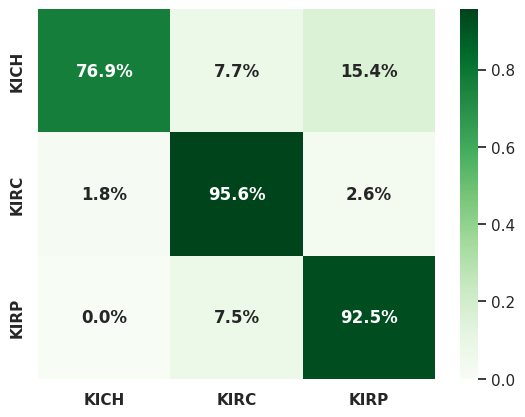

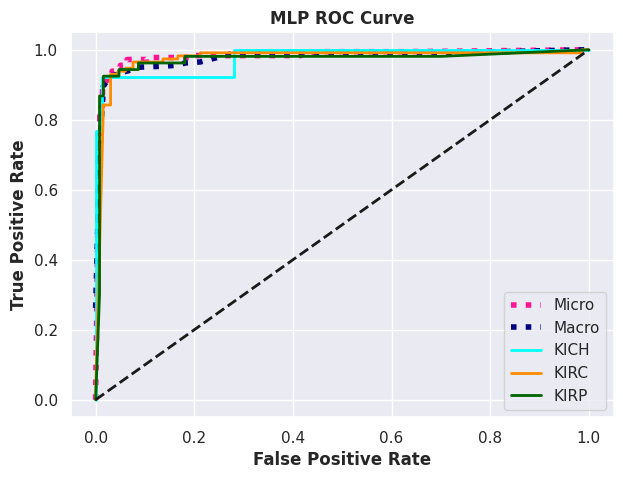

In [40]:
results = evaluate(search, "MLP", X_test, y_test)

In [41]:
filename = MODEL_DIR + '/mlp_all_genes.sav'

In [42]:
pickle.dump(search, open(filename, 'wb'))